In [1]:
# 基础工具
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.special import jn
import seaborn as sns
import pylab as pl
import matplotlib.pyplot as plt
from IPython.display import display,clear_output,Image
import re  ## re.split
import csv ## csv文件读写
import time
import datetime
from datetime import datetime as dt
from math import isnan
import warnings
# dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M:%S')  ## 读取时间格式
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d ')

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测
from sklearn import tree
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score,confusion_matrix,r2_score

#import pydotplus
# from datetime import datetime
# os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

D:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [2]:
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率

In [3]:
df_old = pd.read_excel(r'../数据/df_原数据117.xlsx')
df_old = df_old.drop(columns=['Unnamed: 0'])

In [4]:
df_old_1 = df_old.drop(columns=['尿素氮','中性粒细胞%','淋巴细胞%'])

In [5]:
df_new = pd.read_excel(r'../数据/df_新数据195_0708.xlsx')
df_new = df_new.drop(columns=['Unnamed: 0'])

In [6]:
df_new_1 = df_new[(df_new['预期TDM值']<=20)&(df_new['预期TDM值']>=10)]
df_new_1 = df_new_1[df_new_1['万古霉素日剂量']>100]
df_new_1 = df_new_1.reset_index()
del df_new_1['index']

df_new_1 = df_new_1[list(df_old_1.columns)]

In [7]:
# new_1 和 old_1 中的特征没有差异了；
print(list(set(df_old_1.columns).difference(set(df_new_1.columns))))
print(list(set(df_new_1.columns).difference(set(df_old_1.columns))))

[]
[]


In [8]:
print('测试集：',df_new_1.shape)
print('训练集:',df_old_1.shape)

测试集： (67, 28)
训练集: (117, 28)


In [9]:
df_old_2 = df_old_1.drop(columns=['预期TDM值'])
df_new_2 = df_new_1.drop(columns=['预期TDM值'])
import math
df_old_2['万古霉素日剂量'] = df_old_2['万古霉素日剂量'].apply(lambda x: math.log(x))
df_new_2['万古霉素日剂量'] = df_new_2['万古霉素日剂量'].apply(lambda x: math.log(x))
df_old_2['上一次万古霉素日剂量'] = df_old_2['上一次万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_2['上一次万古霉素日剂量'] = df_new_2['上一次万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0

### 信息统计

In [10]:
df_info = pd.concat([df_old_1,df_new_1],axis=0)
df_info = df_info.reset_index()
del df_info['index']

In [11]:
df_info.shape

(184, 28)

In [12]:
df_info.columns

Index(['patient_id', '年龄', '性别', '体重', '万古霉素日剂量', '上一次万古霉素日剂量', '预期TDM值',
       '上一次TDM值', '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸',
       '肌酐', '降钙素原', 'C反应蛋白', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '总蛋白',
       '红细胞计数', '白细胞计数', '血小板计数', '血红蛋白', '红细胞压积'],
      dtype='object')

In [13]:
df_info.iloc[:,1:8].describe()

年龄          性别          体重      万古霉素日剂量   上一次万古霉素日剂量  \
count  184.000000  184.000000  154.000000   184.000000   184.000000   
mean    65.847826    0.364130   63.367208  1734.575569   660.597826   
std     15.463643    0.482498   13.084766   710.892755   886.393301   
min     24.000000    0.000000   35.000000   250.000000     0.000000   
25%     57.250000    0.000000   55.000000  1000.000000     0.000000   
50%     68.000000    0.000000   62.500000  2000.000000     0.000000   
75%     76.000000    1.000000   70.000000  2000.000000  1500.000000   
max     97.000000    1.000000  174.000000  3428.571429  3000.000000   

           预期TDM值     上一次TDM值  
count  184.000000  184.000000  
mean    14.438261    6.125326  
std      3.048494    9.582571  
min     -1.000000    0.000000  
25%     11.827500    0.000000  
50%     14.505000    0.000000  
75%     16.662500    9.052500  
max     19.920000   45.060000

In [14]:
df_info.iloc[:,13:].describe()

免疫抑制剂          尿酸          肌酐        降钙素原       C反应蛋白  \
count  184.000000  176.000000  177.000000  143.000000  146.000000   
mean     0.293478  223.551705   87.318644    2.763846   77.246575   
std      0.456598  136.599821   73.774320    8.283748   56.548248   
min      0.000000   33.000000   14.000000    0.020000    1.000000   
25%      0.000000  119.675000   48.500000    0.145000   27.000000   
50%      0.000000  191.500000   68.000000    0.340000   64.000000   
75%      1.000000  287.100000   98.000000    1.340000  112.000000   
max      1.000000  828.000000  609.000000   65.000000  200.000000   

             谷丙转氨酶        谷草转氨酶        总胆红素       直接胆红素        总蛋白  \
count   173.000000   173.000000  173.000000  173.000000  173.00000   
mean     48.277457    74.121387   24.223699   11.254913   57.70289   
std      94.711824   216.577185   42.048204   30.361750   10.19925   
min       4.000000     8.000000    3.800000    0.000000   10.40000   
25%      15.000000    22.000000    9.000000    0.000000   52.60000   
50%      29.000000    32.000000   13.200000    3.900000   58.60000   
75%      47.000000    53.000000   20.600000    9.500000   63.00000   
max    1123.000000  2301.000000  329.700000  256.100000   83.50000   

            红细胞计数       白细胞计数       血小板计数        血红蛋白       红细胞压积  
count  174.000000  177.000000  184.000000  183.000000  184.000000  
mean     5.601264   17.945085  215.092391   97.202186   28.718424  
std     30.853848   73.095244  133.901102   19.758364    6.634431  
min      1.580000    1.000000    4.000000   53.000000    0.100000  
25%      2.707500    7.600000  110.500000   84.000000   24.800000  
50%      3.180000   10.900000  210.000000   96.000000   28.200000  
75%      3.567500   16.170000  291.250000  108.000000   32.700000  
max    410.000000  980.000000  694.000000  161.000000   48.000000

In [15]:
for i in df_info.columns:
    x = df_info[i].isnull().sum()
    if x>0:
        print(i,x,' ','%.1f%%'%(x/df_info.shape[0]*100))


体重 30   16.3%
尿酸 8   4.3%
肌酐 7   3.8%
降钙素原 41   22.3%
C反应蛋白 38   20.7%
谷丙转氨酶 11   6.0%
谷草转氨酶 11   6.0%
总胆红素 11   6.0%
直接胆红素 11   6.0%
总蛋白 11   6.0%
红细胞计数 10   5.4%
白细胞计数 7   3.8%
血红蛋白 1   0.5%


In [16]:
x = '性别'
df_info[x]=df_info[x].astype('str')
for i in np.unique(df_info[x].astype('str')):
    print(i)
    print(df_info[df_info[x]==i].shape,'%.1f%%'%(df_info[df_info[x]==i].shape[0]/df_info.shape[0]*100))

0
(117, 28) 63.6%
1
(67, 28) 36.4%


In [17]:
x = '免疫抑制剂'
df_info[x]=df_info[x].astype('str')
for i in np.unique(df_info[x].astype('str')):
    print(i)
    print(df_info[df_info[x]==i].shape,'%.1f%%'%(df_info[df_info[x]==i].shape[0]/df_info.shape[0]*100))

0.0
(130, 28) 70.7%
1.0
(54, 28) 29.3%


In [18]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost as ctb

In [19]:
# x_old = df_old_2.iloc[:,1:]
# y_old = df_old_2['万古霉素日剂量']
# tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old,y_old,test_size=0.3,random_state=416)
# x_new = df_new_2.iloc[:,1:]
# y_new = df_new_2['万古霉素日剂量']
# tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new,y_new,test_size=0.3,random_state=416)

# tran_x_new.index += 1000
# test_x_new.index += 1000
# tran_y_new.index += 1000
# test_y_new.index += 1000

# # 训练集
# tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
# tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
# # 测试集
# test_x = pd.concat([test_x_old,test_x_new],axis=0)
# test_y = pd.concat([test_y_old,test_y_new],axis=0)

In [20]:
from sklearn.model_selection import train_test_split
x_old = df_old_2.iloc[:,1:]
y_old = df_old_2['万古霉素日剂量']
tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old,y_old,test_size=0.3,random_state = 60)
x_new = df_new_2.iloc[:,1:]
y_new = df_new_2['万古霉素日剂量']
tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new,y_new,test_size=0.3,random_state = 60)

tran_x_new.index += 1000
test_x_new.index += 1000
tran_y_new.index += 1000
test_y_new.index += 1000
# 训练集
tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
# 测试集
test_x = pd.concat([test_x_old,test_x_new],axis=0)
test_y = pd.concat([test_y_old,test_y_new],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

# Tell auto_ml which column is 'output'
# Also note columns that aren't purely numerical
# Examples include ['nlp', 'date', 'categorical', 'ignore']

column_descriptions = {
    '万古霉素日剂量': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(tran_x, model_names=['XGBRegressor'])
# ml_predictor.train(tran_x, model_names=['LGBMRegressor'])
# ml_predictor.train(tran_x, model_names=['CatBoostRegressor'])


test_score = ml_predictor.score(test_x, test_x['万古霉素日剂量'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 万古霉素日剂量
Started at:
2020-08-03 09:46:22
[09:46:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:l

In [21]:
tran_x

年龄  性别     体重   万古霉素日剂量  上一次万古霉素日剂量  上一次TDM值  糖肽类抗菌药  袢利尿剂  氨基糖苷类  氟康唑  \
104   55   1    NaN  8.006368    7.600902     5.73     0.0   1.0    1.0  0.0   
53    62   1    NaN  7.600902    0.000000     0.00     0.0   0.0    0.0  0.0   
49    65   0  70.00  7.600902    0.000000     0.00     0.0   1.0    1.0  0.0   
115   76   0  60.00  6.214608    6.907755    45.06     0.0   1.0    1.0  1.0   
16    80   0    NaN  7.313220    0.000000     0.00     0.0   0.0    0.0  0.0   
...   ..  ..    ...       ...         ...      ...     ...   ...    ...  ...   
1008  45   1  61.95  7.600902    7.313220     9.76     0.0   0.0    0.0  0.0   
1035  77   1  55.00  7.313220    7.313220    14.35     1.0   1.0    0.0  0.0   
1015  75   1  56.00  7.600902    0.000000     0.00     0.0   1.0    0.0  0.0   
1010  83   1  55.00  6.214608    0.000000     0.00     0.0   1.0    0.0  1.0   
1065  59   0  65.00  7.600902    7.600902    12.03     0.0   0.0    0.0  0.0   

      ...  谷丙转氨酶  谷草转氨酶  总胆红素  直接胆红素   总蛋白  红细胞计数  白细胞计数  血小板计数   血红蛋白  红细胞压积  
104   ...   10.0   12.0  11.7    6.8  53.8   3.83   24.6  487.0  109.0   33.4  
53    ...   20.0   19.0  10.6    0.0  77.0   3.73    8.0  308.0  122.0   37.5  
49    ...   49.0   69.0  18.3    0.0  52.0   2.61    3.9   38.0   87.0   25.6  
115   ...   48.0   21.0  12.5    0.0  47.0    NaN    NaN   14.0   82.0   23.4  
16    ...   46.0  140.0  17.4   12.9  48.0   3.06   19.2   53.0   96.0   29.6  
...   ...    ...    ...   ...    ...   ...    ...    ...    ...    ...    ...  
1008  ...    NaN    NaN   NaN    NaN   NaN   3.13   15.5  345.0   94.0   28.2  
1035  ...   42.0   43.0   6.3    1.5  62.0   2.68   19.4  554.0   82.0   24.8  
1015  ...   30.0   26.0   4.7    1.3  66.9   3.13    9.2  223.0   83.0   24.9  
1010  ...   10.0   11.0   8.1    3.9  56.1   2.37    9.3  135.0   72.0   21.4  
1065  ...   10.0   12.0  11.4    6.9  54.0   3.31    6.0   68.0  107.0   33.1  

[127 rows x 26 columns]

In [22]:
tran_x.columns

Index(['年龄', '性别', '体重', '万古霉素日剂量', '上一次万古霉素日剂量', '上一次TDM值', '糖肽类抗菌药', '袢利尿剂',
       '氨基糖苷类', '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸', '肌酐', '降钙素原', 'C反应蛋白', '谷丙转氨酶',
       '谷草转氨酶', '总胆红素', '直接胆红素', '总蛋白', '红细胞计数', '白细胞计数', '血小板计数', '血红蛋白',
       '红细胞压积'],
      dtype='object')

In [23]:
im_auto = pd.DataFrame(data={'Variable Name':['肌酐','上一次万古霉素日剂量','上一次TDM值',
                                              '红细胞计数','年龄','体重',
                                              '氟康唑','性别','C反应蛋白','白细胞计数'],
                             'Importance Score':[0.1148,0.1112,0.1018,0.0614,
                                                0.0519,0.0493,0.0487,0.0426,
                                                0.0403,0.0368]})

In [24]:
# b = []
# for i in range(1000):
#     x_old = df_old_2.iloc[:,1:]
#     y_old = df_old_2['万古霉素日剂量']
#     tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old.drop(columns=['万古霉素日剂量']),y_old,test_size=0.3,random_state = i)
#     x_new = df_new_2.iloc[:,1:]
#     y_new = df_new_2['万古霉素日剂量']
#     tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new.drop(columns=['万古霉素日剂量']),y_new,test_size=0.3,random_state = i)

#     tran_x_new.index += 1000
#     test_x_new.index += 1000
#     tran_y_new.index += 1000
#     test_y_new.index += 1000
#     # 训练集
#     tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
#     tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
#     # 测试集
#     test_x = pd.concat([test_x_old,test_x_new],axis=0)
#     test_y = pd.concat([test_y_old,test_y_new],axis=0)
    
    
# #     tran_x,test_x,tran_y,test_y=train_test_split(x.drop(columns=['万古霉素日剂量']),y,test_size=0.2,random_state=i)
#     trained_model = load_ml_model(file_name)
#     params = trained_model.named_steps['final_model'].model.get_params()

#     model = xgb.XGBRegressor(**params)
#     eval_set = [(test_x, test_y)]
#     clt = model.fit(tran_x,tran_y,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
#     y_pred = clt.predict(test_x)
    
#     b.append(r2_score(test_y,y_pred,multioutput='variance_weighted'))

In [25]:
# print('最大r2:',max(b))
# print('对应的最大random_state:',b.index(max(b)))
# # 最大r2: 0.7316746151482905
# # 对应的最大random_state: 60

In [26]:
# b.index(0.6319221879612936)

In [27]:
'''
未 log()
 ============= 7:3 ==============
0.6088819057208887        327
0.57672403762354          410 
0.5512266612898225        112
0.5322679774436422        450
0.5229714196861397   273

 log() 后
 ============= 7:3 ==============
0.7316746151482905        60
0.6630077680548268        902 
0.6611028253253104        240
0.6444995618759257        541
0.6421280779466055        855

0.641494295256263         276
0.6411859039973263        150
0.6404612212348619        327
0.6344162313942889        473
0.6319221879612936        259
'''

'\n未 log()\n ============= 7:3 ==============\n0.6088819057208887        327\n0.57672403762354          410 \n0.5512266612898225        112\n0.5322679774436422        450\n0.5229714196861397   273\n\n log() 后\n ============= 7:3 ==============\n0.7316746151482905        60\n0.6630077680548268        902 \n0.6611028253253104        240\n0.6444995618759257        541\n0.6421280779466055        855\n\n0.641494295256263         276\n0.6411859039973263        150\n0.6404612212348619        327\n0.6344162313942889        473\n0.6319221879612936        259\n'

In [28]:
# # b.sort(reverse=1)
# c=sorted(b,reverse=1)
# c[5:10]

In [29]:
x_old = df_old_2.iloc[:,1:]
y_old = df_old_2['万古霉素日剂量']
tran_x_old,test_x_old,tran_y_old,test_y_old=train_test_split(x_old.drop(columns=['万古霉素日剂量']),y_old,test_size=0.3,random_state = 60)
x_new = df_new_2.iloc[:,1:]
y_new = df_new_2['万古霉素日剂量']
tran_x_new,test_x_new,tran_y_new,test_y_new=train_test_split(x_new.drop(columns=['万古霉素日剂量']),y_new,test_size=0.3,random_state = 60)

tran_x_new.index += 1000
test_x_new.index += 1000
tran_y_new.index += 1000
test_y_new.index += 1000
# 训练集
tran_x = pd.concat([tran_x_old,tran_x_new],axis=0)
tran_y = pd.concat([tran_y_old,tran_y_new],axis=0)
# 测试集
test_x = pd.concat([test_x_old,test_x_new],axis=0)
test_y = pd.concat([test_y_old,test_y_new],axis=0)
#============================= model ==================================
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x, test_y)]
clt = model.fit(tran_x,tran_y,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred = clt.predict(test_x)

[09:46:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:46:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [30]:
print('R2:  ',r2_score(test_y,y_pred,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y,y_pred))
print('RMSE:',mean_squared_error(test_y,y_pred) ** 0.5)
print('MAE: ',mean_absolute_error(test_y,y_pred))

R2:   0.7316746151482905
MSE:  0.057160972475305265
RMSE: 0.23908360980064122
MAE:  0.1932519162692619


In [31]:
im=pd.DataFrame({'Variable Name':tran_x.columns,'Importance Score':model.feature_importances_})
im=im.sort_values(by='Importance Score',ascending=False)

im['Importance Score']=round(im['Importance Score'],4)
im=im.reset_index()
del im['index']


In [32]:
im

Variable Name  Importance Score
0             肌酐            0.1312
1         糖肽类抗菌药            0.1107
2        上一次TDM值            0.1102
3          谷丙转氨酶            0.0729
4          红细胞计数            0.0554
5     上一次万古霉素日剂量            0.0528
6          直接胆红素            0.0467
7             体重            0.0385
8           血红蛋白            0.0378
9             年龄            0.0345
10          总胆红素            0.0325
11            尿酸            0.0299
12         血小板计数            0.0296
13           氟康唑            0.0282
14         谷草转氨酶            0.0273
15         白细胞计数            0.0262
16           总蛋白            0.0256
17         红细胞压积            0.0256
18         C反应蛋白            0.0251
19          降钙素原            0.0245
20          喹诺酮类            0.0227
21         免疫抑制剂            0.0117
22            性别            0.0004
23         氨基糖苷类            0.0000
24          袢利尿剂            0.0000

In [33]:
im[0:10]   # seed: 60

Variable Name  Importance Score
0            肌酐            0.1312
1        糖肽类抗菌药            0.1107
2       上一次TDM值            0.1102
3         谷丙转氨酶            0.0729
4         红细胞计数            0.0554
5    上一次万古霉素日剂量            0.0528
6         直接胆红素            0.0467
7            体重            0.0385
8          血红蛋白            0.0378
9            年龄            0.0345

In [34]:
# im_auto = pd.DataFrame(data={'Variable Name':['肌酐', '上一次万古霉素日剂量', '上一次TDM值', 
#                                     '红细胞计数', '年龄', '体重', '氟康唑', '性别', 'C反应蛋白', '白细胞计数'],
#                   'Importance Score':[0.1148, 0.1112, 0.1018, 0.0614, 0.0519, 0.0493, 0.0487, 0.0426, 0.0403, 0.0368]})

In [35]:
im_auto

Variable Name  Importance Score
0            肌酐            0.1148
1    上一次万古霉素日剂量            0.1112
2       上一次TDM值            0.1018
3         红细胞计数            0.0614
4            年龄            0.0519
5            体重            0.0493
6           氟康唑            0.0487
7            性别            0.0426
8         C反应蛋白            0.0403
9         白细胞计数            0.0368

In [36]:
list(im['Variable Name'][0:10])

['肌酐',
 '糖肽类抗菌药',
 '上一次TDM值',
 '谷丙转氨酶',
 '红细胞计数',
 '上一次万古霉素日剂量',
 '直接胆红素',
 '体重',
 '血红蛋白',
 '年龄']

##  SHAP (单因素 Top20)

In [37]:
import shap
explainer = shap.TreeExplainer(model)

# shap值
shap_values = explainer.shap_values(tran_x)

# 模型的基线ybase     (通常是所有样本的目标变量的均值)
y_base = explainer.expected_value
print(y_base)
y_pred_1 = model.predict(tran_x)  # 这里是训练集的预测值，不是   *****
print(y_pred_1.mean())


7.330238
7.33024


In [38]:
print(shap_values.shape)
print(tran_x.shape)

(127, 25)
(127, 25)


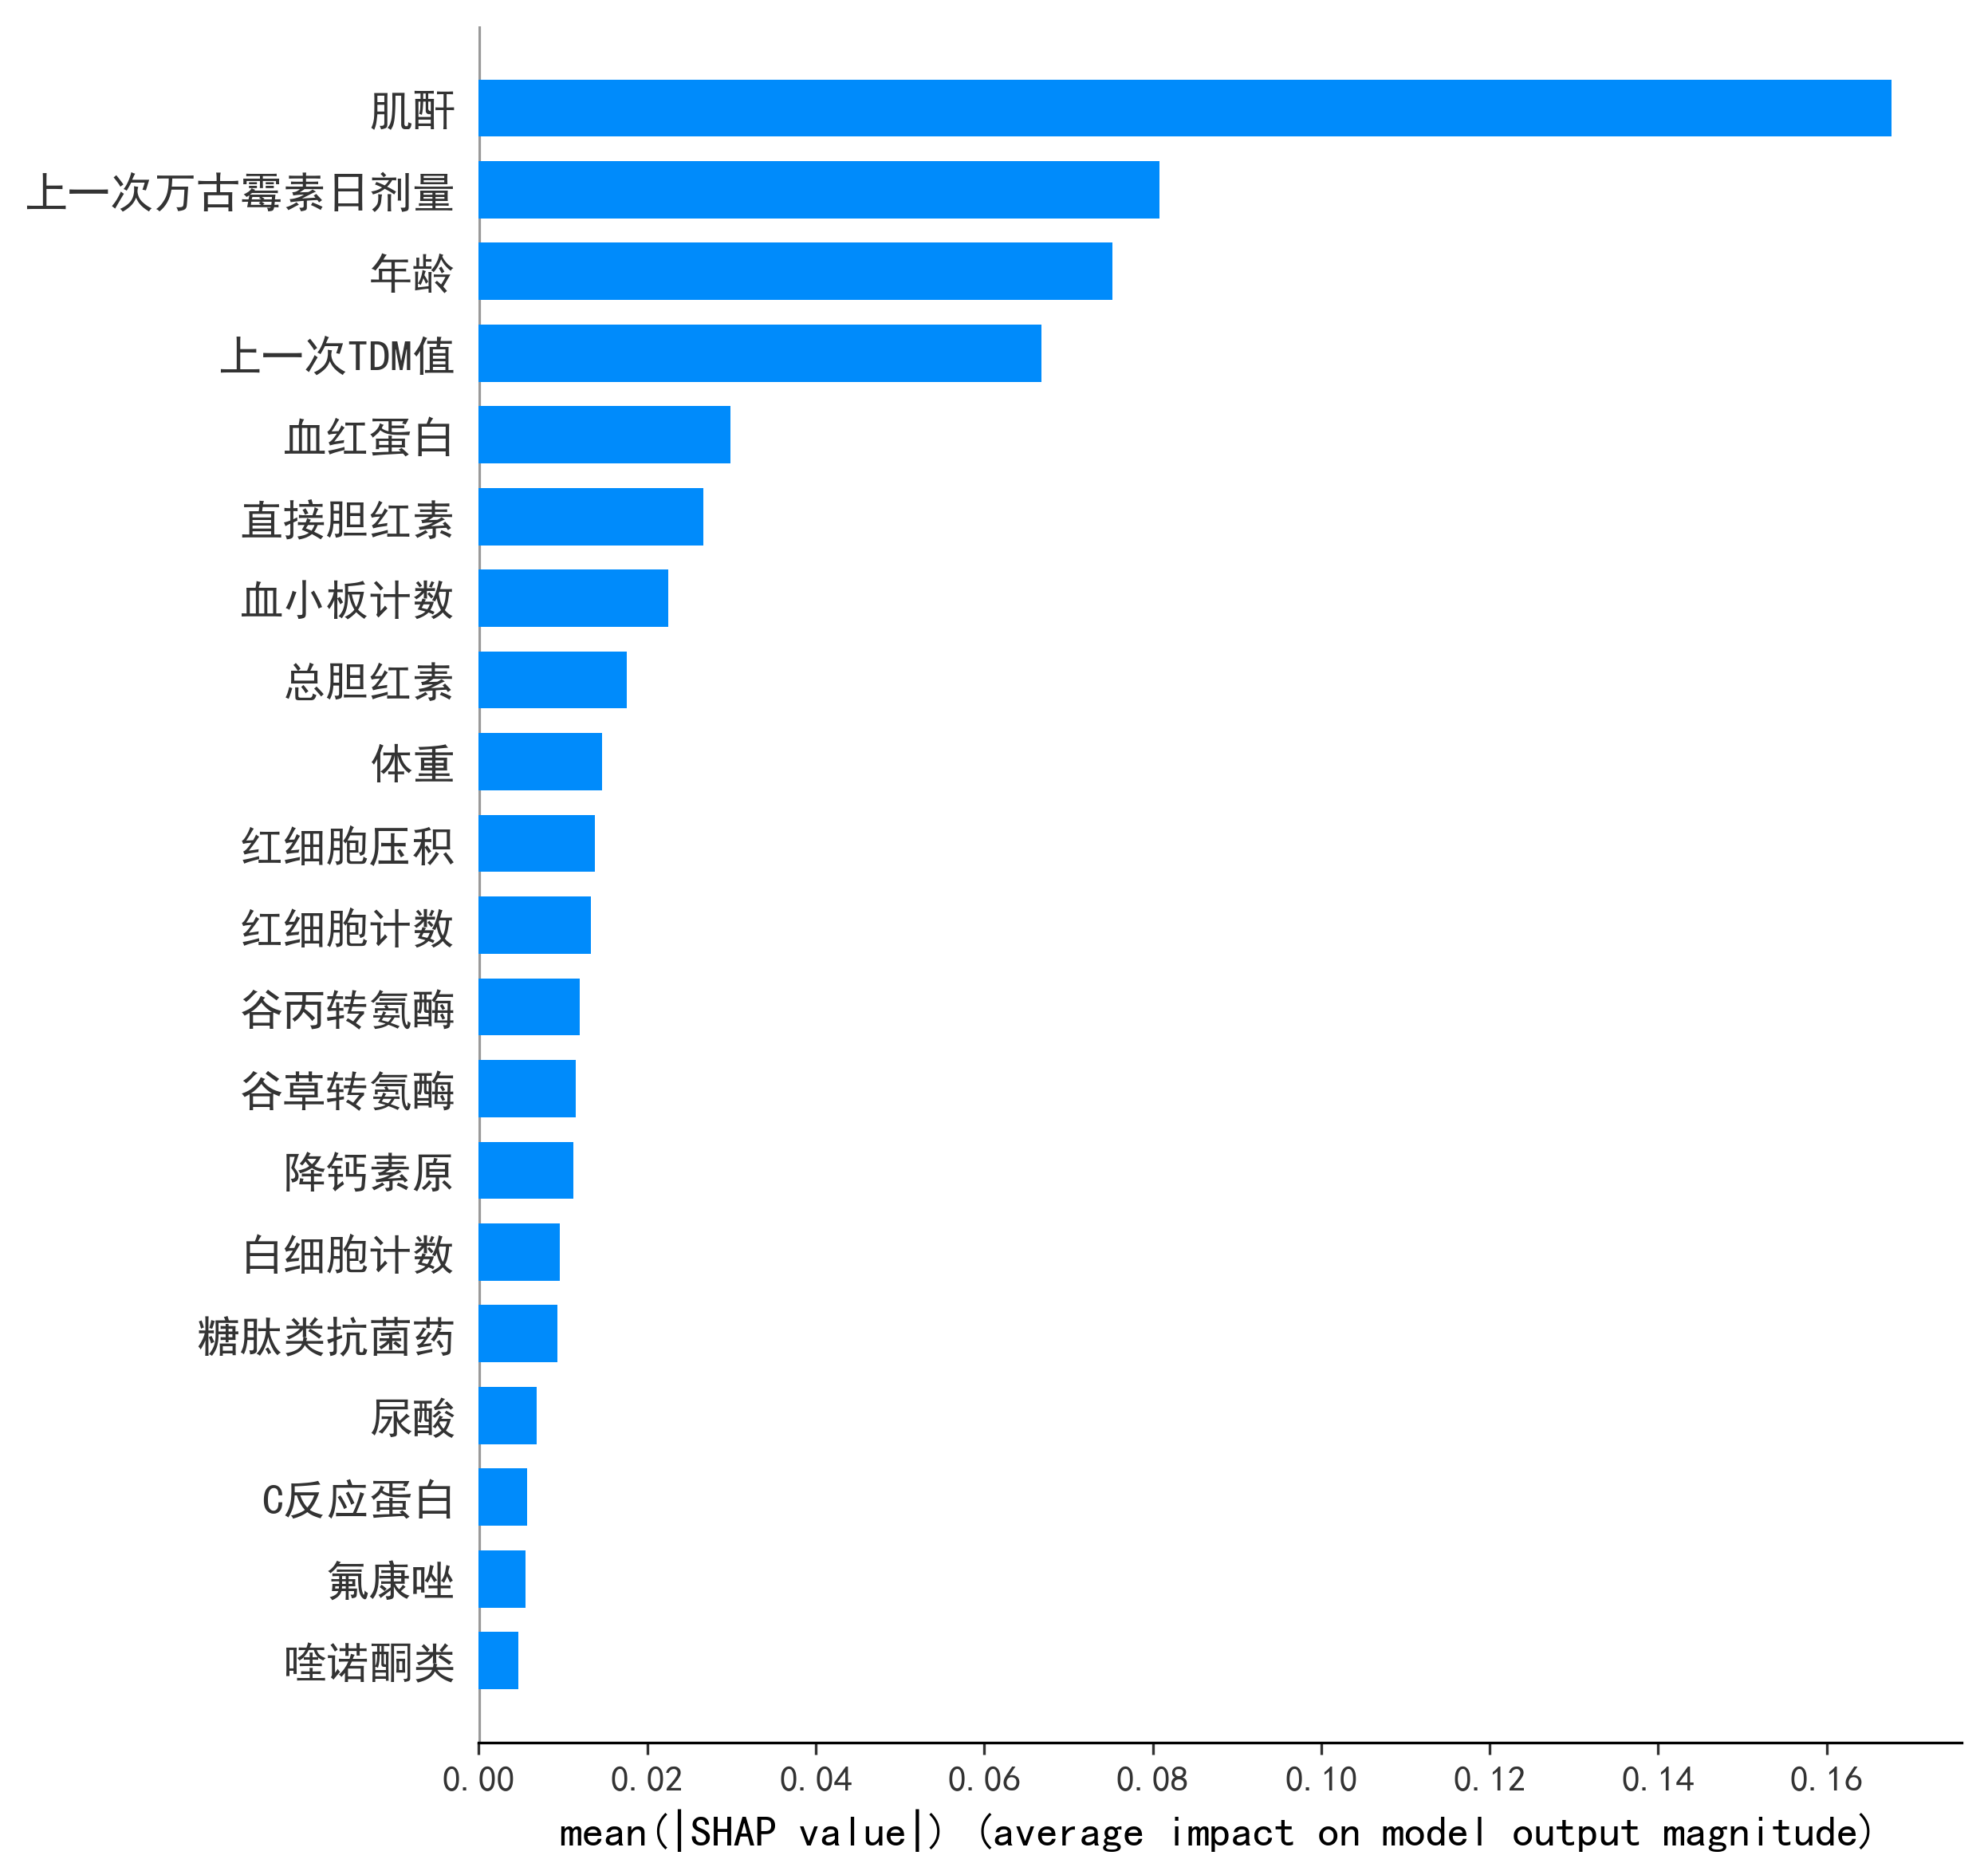

In [39]:
shap.summary_plot(shap_values, tran_x, plot_type="bar")
# 把一个特征对目标变量影响程度的绝对值的均值作为这个特征的重要性。

In [40]:
tran_x.columnsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACboAAAksCAYAAAA85Nn5AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAuIwAALiMBeKU/dgAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3XmYZVlZJ+pfZNZcWUUVVFnMFkjj0CgqC0QBBQURFGwFbAVkUFC7BZzQbhAuYCtDg9PFBvpRGepaaouKAyoKV0TwytWvtBEHBJmnEqqgpqzKqhyi/9gnzJM7YzgRZ584OzPf93n2E2etvfbaKzLOjgiIX31rZXV1NQAAAAAAAAAAADBWe5a9AAAAAAAAAAAAANiMoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIyaoBsAAAAAAAAAAACjJugGAAAAAAAAAADAqAm6AQAAAAAAAAAAMGqCbgAAAAAAAAAAAIzaacteAADASWg1SS677LIcOHAgD33oI3POOecue01wwlhZWclFF+07pu+qq27I6urqklYEJybPEgzDswTD8TzBMDxLMAzPEgzDswTD8TxxIrn44vNWlnFfFd0AABbsyJEjy14CAAAAAAAAwAlN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRW1ldXV32GgAATiorLzvkFywAAAAAAABYkk898aZlL+GkdvHF560s474qugEAAAAAAAAAADBqgm4AAAAAAAAAAACMmqAbAAAAAAAAAAAAoyboBgAAAAAAAAAAwKgJugEAAAAAAAAAADBqgm4AAAAAAAAAAACMmqAbAAAAAAAAAAAAoyboBgAAAAAAAAAAwKgJugEAAAAAAAAAADBqgm4AAAAAAAAAAACMmqAbAAAAAAAAAAAAo3bashcAAIxLa+30JHdKckOSA5PjUFUd2eF8e5OcnuTMJGcn2VdV/zLQcgEAAAAAAAA4BQi6AQB9d0jy/n5na+1IkkNJjkyO1Q2u3zN1nJZkZZ0xx/S11r45yS1J9if5TJJrN5m/79wk5yfZly5Id2aSP66qG2e8HgAAAAAAAICRE3QDAGa1J8kZC5r7t5LsHXC+uyT50IDzAQAAAAAAALBEgm4AMJDW2kOT3G6OKQ5V1a+sM+95SV46x7y/WFVXzHE9AAAAAAAAACyVoBsADOcHkjxsjuuvSXJc0C1dFbXvnWPeP06ynaDb1UmemuS6JDcmOZDkYLptS1eT/GSSB03G/kWSZ05ef26SX5+a5wGTj6en+xzOmRz7tv0ZAAAAAAAAAHBKE3QDgOHsn/P6GzfoPzTnvLdsZ3BVXZ/klzY631r7zFTzmqp656T/mt7Qd1bVrGt/YJJr0/0b3JwuWHd4ciTJ7ye539T4S9MF8fak+33mtBwN090qyZUz3hcAAAAAAACAE4CgGwAMZ6Og2qxu2qB/V4Nuy1BV79jsfGut/29wbVX1g3UAAAAAAAAAnKQE3QBgOP2Kbg+pqrdsNLi1ti/J9VNdGwXlDvbaV1XVxZvM+7Ekd5jqGn3QDQAAAAAAAAA2s2fZCwCAk8jNC7q+H3Rb3ea8gm4AAAAAAAAAnNAE3QBgOP1A2nYdXq+zqlaTHJnqEnQDAAAAAAAA4JRi61IAGM6RrYdsat2g28ShJGdMXi886NZaW0myd4PTK9OvW2trv0/0x+9tra07QVUd2u6aAAAAAAAAADh1qegGAOOxWfhrulrcblR0e+Dknusd3zo17uFT/X/fm+PARnO01r5sB2sCAAAAAAAA4BQl6AYA47FZgG06BLfdynE7CbrdvINrtuOmBc8PAAAAAAAAwElE0A0ATgzTFd22u+3ndivA9e+3CAcWPD8AAAAAAAAAJ5HTlr0AAGAm0+G2w7twv35Ft39O8uLJ62ckWdt69F1Jfm7y+nZJXjh1zXfnaPW55yW5dOrcTqrMAQAAAAAAAHCKEnQDgMV5c2ttqLmmtyvdjaBbv2rclVX12iRprT12qv+9U/1fkGODbpdV1aHJuafl2KDboivGAQAAAAAAAHASsXUpAJwY9k693o2g22ZBtH1Tr/fvcP7tbr8KAAAAAAAAwClM0A0ATgzTP7N3Y9vPzcJ05069vmEB8wMAAAAAAADAMWxdCgDDWem1X5rkHzcZf2aSV80493RFt90Ium1WcW066HbdDucXdAMAAAAAAABgZoJuADCcfqXUP6mqt2w0uLW2L+MNuh3Z5Nx00O36Hc4v6AYAAAAAAADAzATdAGA4/YpuQ9rtrUs3C7qdM/X6swuYHwAAAAAAAGDHVlYW+adblkXQDQCG06/oNqSzpl7ftMD7rNms4trZU6+v2eH8R5KktfaYyb32J7k5ycHJcXgyZnUyfl/v+nu21m5Jcka6LWDPnLw+I93vN6cleUdVvW+H6wMAAAAAAABOUBdd1P/zIicDQTcAGM7erYdsX2ttT5LTp7p2I+i2ul5na+303lqunnP+n01yhx1c/2czjHlyEkE3AAAAAAAAgJPAIivPAMCpZiFBtxxbQS1JblzQfaZttLXorXvtT28yx2b/HrYuBQAAAAAAAGBmgm4AMJxFVUo9q9fev6D7TFu3oluOr7728U3meOhGJ6pqo/kBAAAAAAAA4Di2LgWA4Zy+9ZAd6Vd0u35B95m2URDt7lOvb6yqqzaZ4xWttQ9X1bs2GfOgdFux3pTk5iSHp47VqXW8NcnXTF13YZJr04X2V9JVjzstyRnpgoH7svNtVQEAAAAAAIAT2FVX3bDsJZzULrpo31LuK+gGAMPpB91u31q72ybjz5lx3lv12ssMut1r6vWHe+f6lebukOSK1trbk9x5vcmq6n2zLKa1tt61q+kCcUlyKF1Qbjeq3QEAAAAAAAAjtrpqg6mTkaAbAAynH3R73UDzXtBrXzfQvDvxlVOvPzh9oqo+2lp7f5LPm+rem+SBu7AuAAAAAAAAAE5ie5a9AAA4iZyxoHn7QbdrFnSfTbXWzk9yn6muv1ln2LN2aTkAAAAAAAAAnEIE3QBgOLsVdPvsgu4zbb1avl+co1uFJkn1B1TV65M8PsknFrQuAAAAAAAAAE5Bti4FgOH0g27fn+QfNxl/dpI/nGHei3rt3Qi6rfQ7quovWmsXJ/nmJE/NOkG3ybjLW2u/keTOU/O8Ick9FrRWAAAAAAAAAE5ygm4AMJzTe+3fr6qPbjS4tbZvxnnv2Gt/elur2pnjgm5JUlU3JLl8cmyoqg4mef9au7V286CrAwAAAAAAAOCUYutSABjO+VOvD2e47Tv7QbdPDTQvAAAAAAAAAJwQVHQDgOHcZur1J6vq8EDzTgfdDiX5zEDzbqZf0e22rbUnzTHfbbYeAgAAAAAAAADrE3QDgOFMh7k+MuC8l069/mRVHRlw7o30g26fn+Q1Q03eWlupqtWh5gMAAAAAAADg5GbrUgAYQGvttCTnTXV9dKB5L8yxFd0+PsS8I9AP0gEAAAAAAADAhgTdAGAYl/bagwTdknxJr/2Bgebdyt4Fzy/oBgAAAAAAAMDMBN0AYBj9QNqHFzTv+weadyv93xH+PMnpcxxXbDE/AAAAAAAAAGzotGUvAABOEl/ca39woHnv12v/00DzbqVfcW21qg7tdLLWWr9L0A0AAAAAAACAmfkjMwAMox90e9+8E7bW9ib5+l73u+edd0aL/h3B7yAAAAAAAAAAzExFNwCYU2ttJcn9p7oOJvnAAFN/VZILp9r7M0BFt9bamUl+LMmrqurTGwxbdBBt74LnBwAAAAAAAOAkIugGAPO7V5JLptr/NOM2n1uFvb651/7rqjq8rZWt78IkP5Hk2a21Nyb5/aq6rDem/zvCua21e8xxz7N6bUE3AAAAAAAAAGYm6AYA83t4r/03M173eb32v4XjJlXXntg7/6fbXNea1V779pOPZyV5dJKvTbJV0K1l2G1TbV0KAAAAAAAAwMz8kRkA5vdNvfZfzHjdk3vtW3rnLuqd/8MZ5+0H2z6/1/6iXvv968yx6Ipr2w3b99ezMtRCAAAAAAAAABg/Fd0AYA6T7Tzv3ev+f9cZd/ck5yQ5M8kdknxDkqf0hn1iMva8JP9X79z7quqKGZf1ySR3nGo/t7X21qo6OGn/h9749SrQLTrodvo2x/d/ZxHWBwAAAAAAADiFCLoBwHy+v9d+d1V9cJ1x357kBVvM9Y7Jx59JcrveuVdsY03vyLHhu/sn+cfW2rXpfvbfszf+LevMcUav/baqeuA21nCM1loluddU13aDbuf22v31AQAAAAAAAHASUw0FAHaotXZ+ksf3un93g+Gvy/Fbik77QJJfa609LsdXevtMkl/extJeu8697pYuaNYPuV2d9bdE3W4Qbbu2O//5vfZZQy0EAAAAAAAAgPETdAOAnbt1ko/2+n51vYFV9eEkf7rOqYNJfivJV1fVzUnuk+RQb8xPVtX1sy6qqv4uyUtmHP6cqrpxnf5FB93O3Ob4S3rtfoU3AAAAAAAAAE5igm4AsENV9aEkX5rkhUmOJPnLqvqnTS559eTjx9IF4p6Y5HZV9eiq+vhkzh9Ico8cDcW9J8n/2MHanpXkyUkqyU3rDPlokmdU1as2mGLRQbeZK7K11m63zvhbDbscAAAAAAAAAMZsZXV1s13UAIBZtNYelmRfVb1+kzFnJLlNVX1yhvn2JHlOkj+tqncMt1J2w8rLDvkFCwAAAAAAAJbkU09crxYIQ7n44vNWlnFfQTcAgIEJugEAAAAAAMDyCLot1rKCbrYuBQAAAAAAAAAAYNQE3QAAAAAAAAAAABg1QTcAAAAAAAAAAABGTdANAAAAAAAAAACAURN0AwAAAAAAAAAAYNQE3QAAAAAAAAAAABg1QTcAAAAAAAAAAABGTdANAAAAAAAAAACAUVtZXV1d9hoAAE42q0ly2WWX5cCBA3nIQ74p+/adt+w1wQljZWUlF12075i+q666If63C2yPZwmG4VmC4XieYBieJRiGZwmG4VmC4XieOJFcfPF5K8u4r4puAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKMm6AYAAAAAAAAAAMCoCboBAAAAAAAAAAAwaoJuAAAAAAAAAAAAjJqgGwAAAAAAAAAAAKN22rIXAABwsll52aHJq8d2H35raUuBE9ihXvuspawCTnyeJRiGZwmGM9vz9Kkn3rT4pQAAAAAnFBXdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3QDAAAAAAAAAABg1ATdAAAAAAAAAAAAGDVBNwAAAAAAAAAAAEZN0A0AAAAAAAAAAIBRE3RjVFprpy17DQCL1lo7v7X275e9DgAAAAAAAAA4UQgVMTY/0lp7UJIXVdXblr0YNtZae1mSs3rdV1TVa5axHjbXWvuGJI+e6rqpqp6+rPWcylprFyd5U5JLW2sPrqq/XfaaAAAAAAAAAGDsTsqgW2vt25K8utf9nKr6uWWsh215SJKvS/LQ1to/JvmNJJdX1b8sd1ms475J7tfre9kyFrKmtXZWks9Pcv3kuCnJwSQHq+rILq3htCSnT459k+Osqvq73bj/Ji5N8t1T7Y8kEXTbZa21L0/yhiR3nnS9ZbfCbq211yf5lqmuP6yqRy76vgAAAAAAAAAwhJMy6Jbk5iTn9voOLmMhzG4SUpoOTn1Rkh9J8kvLWRFbeG+OD7q9dxkLmXJpkv+93onW2u6u5FjXJrlgmQtIck2v/dmlrGIDrbUXJnnWstcx8diq+rUFzf2FSW4/1b51di/sdmOSvVPt/TudqLX2e0keMfeK5nenqvrYshcBAAAAAAAAwOLtWfYCFmS9P97v+A/6bK619jmttSHeSw/J8VthvqSqPj7A3Axvva+LynvjdX2vfcNSVrGxQ8tewJSFraWqLk/yuCSHp7rXwm53WdR9J/pf8+vmmGuea4fUf18DAAAAAAAAcJI6WSu6rRfgEHRbgNbaVyb57XRbxf74nNN9a6/9mSQ/P+ec29Za25+uAuBNSQ4kuSVd8OVwkl3Z/nIDeyfHnnTP7llJzpkcb62qh+3yeq5dp+8zu7yGviPp1rW2demN6b52B3NssGgrXzP1+pPZXqW603P81qVzBadaa89Lt6Xv/nTf3w5M5lx7X87ijr32XVtrr9rGMtbec2clOXvq9buq6j9vY56NnBJBtySpqt9ore1L8suTriNJXlpVH1zkfdM9D5u1t6MfdHtDkg/MMd+svjfdM5UkqxF0AwAAAAAAADhlnKxBt/W2KR1TiOKk0Fr7riSvTHJGkme11q6oqt/e4Vyn5fht8H6hqpZRdWpvuvDYrZZw751aWcI91wuPLrVKWFW9NwNsEdpaW51q/l5Vfd+8c87pLkkeMPCct0sXGprXTQPMkaz/Pfqf0gVNF+m2SS7p9S18q+uqenVr7Q5JfjjJt1fVHy/6njk+FDnPz8V+SO7VVfXGOeabSWvt23M06HZzVS0zfAwAAAAAAADALjpZg27r/fFe0G1ArbUH52g1oqQLWr2utfaeqvrHHUz50CS3mWofSPILcyyRxVsvDKRyIju13vvp4VX1oUXetLX2/CTP63Vv6+dFa+2Lk3xtuipn1ye5OV1Ab6tqe3+Z5BlJDk++p65nT7rw7enpQsVn5mg1x4NVtZ2qfP3Pa56fiwsPA85gDGsAAAAAAAAAYJecrEE3Fd0WrKre0lq7PMnjprr3JXlDa+3eVdXf1m4rT+q1X1tVn55njXO4JV21opsmx8Ec3SZyNRtvX3qbJJf2+v52k/HbsZKjW5eubV96do5uXbqdbTmHst4zdWDXV3FqOJIuRLg/3XvzQLqv+dr7chbnJbn7VPuGJP+8jTWsvefO6h1DVdQa0/fo7a7lXkl+bhEL2cKHk8wTdJvn+0b/5+wrW2svm2O+WU1X3xN0AwAAAAAAADiFnKxBt/WCF6vr9DGfpyT5/CRtqu/u6Sq7fWtVzfRv3lq7MMduW7qa5GcHW+U2VdX5O7mutfbdSX6p133fqlr01ountNba1UluvcBbfG9rbYgtPqddXFVXzTq4qr4ryXfNc8NJxbA3T3VdUVUPnGfOgS0jrLmRMa1lS621L0vyN1NdB6vqjF1exh13+X4AAAAAAAAAnGJO1qAbu6CqDrTWviXJFUk+Z+rUf0jyX5K8eMapnpRuO7411yb5sdba+qN35kiSpy04dHZ6r31QyG1XXJfFBt0WYbsVD08FYwqXzbuWg+m2L51nnr3pqmSuOZyuwuRZOf5n9zW99mfnuO+s9u7CPbYyhjUAAAAAAAAAsEsE3ZhLVX2stfYfk7wlx4YOfrK19v9X1Vs3u761tifJ9/e6L0jy3cOuNH+5C6GzftDt+gXfb0uttS9O8iXpgi9rx3Xptme9JV0g52BVLX3byNbaGUnOSBd6PDPJhUkumhwHquoPNri0Hxpb29ZzHudOvT6ULrQ0j3PSbT+bdJ+LAOTxTuSg22+n+x54XZL9VTX359Ja+/kkz5jqenZV/ffJuTPTbUV79uRcP+h27bz3n0G/YtwjquqNi75pa+1jSe6wwRoAAAAAAAAAOIkJujG3qvqz1tpzkrxoqntvkl9rrX1pVV25yeUPT/J5C11g5w27cI9+0O2GXbjnVr4uM2wDO2D1vM8OXIlvzduSzBp0e0RVvWWem7XWprfd/eWq+r4557syySWT5o6ruU0CTo9J9966PsmN6QKLh7J1OOvSXvvc1to9trhmJd3PidPShYrOTVdl7Jyq+pVtLX5rJ2zQraquy4BV+iZbkU4HgN+Tqee4qm7OseHLfnBy3mDmLM7cesjCjWENAAAAAAAAAOwSQTeG8pIkX53kYVN9lyS5vLX2kKo6ssF1z1z4yjq7EXQ7t9deekW3U8SG2xe21r4nyV1nmOPlVfXxWW7WWvvPSe48w9DXV9UV6/T3A5HbcV6S/2eO66e1JO/e4bWHkwwddFt6VcEpQ1Rk+7okT0/39XrjJJw2y3XnJfm1HH1fH07ylKo6uMll/aDbblQMPKfXfmJr7f67cN/zp17vaa2doUIiAAAAAAAAwKlB0I1BVNVqa+0J6YIzt5069bVJnpXkp/rXtNYekORret33q6r/b561tNbelOShU11/X1X/Ms+cM7qg196N7QM5PnAz7bE5/j22nt9MMlPQLckTknzFDOPek2S9oNutWmt7Ngl/nqrGVNFtiK/NM5N8Q5JvTnJNa+1Xkryqqv5howtaaytJXpPk86e6f6qq/mKLe61u0V6EfrD30btwz/XsS/KZJd0bAAAAAAAAgF0k6MZgquqq1tqTk/xR79TzW2t/XFXV639ur/2mAUJuZ6WrLDftd+aZcxtu1WtfvUv33Y796ba9vDnJgXRVtI5kZyGjWye5U6/v73c410q6ClanJTk7XXjt/HTbZW7lkq2HjMqedKHInYZzDqb7Gu5Pt3XpocmxWcWvpKsGd/ep9g1J/nmLa1bSVaBb2770nHQBp0VsGbkb4axZzbWW1trXpwu5rbkgydOSPK219vYkP5/kd6qq/6z8bJJHTbXfkuQn5lnLAvWDbssi6AYAAAAAAABwihB0Y1BV9abW2i8meepU92qSL0/yb0G3ybZ+D+mN6QffduLr0gWlpp3KQbf/leRPkvxrkmvWCdbsWGvtSemqT017QFVdM+A9zk3yOUnO2mhMVd1uk3MP3ME9V3pdx3yfrKr7bnfOqrrt1qNmmueqzBb+O05r7cFJ3jzVdcVO/n0WaEwV7uZdy7lJ3pYudNt/Pz1gcnyotfbyJL9cVde21l6U5Aemxr03ybcN+cwOqaoeuew1AAAAAAAAAHBqOZWCbvdprW33812rMLX2ca2a0blJ/rCq/vewSzxp/GiSR6TbwvQ9SR5bVX+7drK1tifJT/euef06Fd924hG99pVJ/maAeWfRD1wtPehWVZ9M8sllr2Onqmp/kg/u8m37QbJ9u3z/U9WYKrrNFXSrqjckeUNr7a7pQr/fneTi3rBL030ffEFr7Yocu8XuJ5I8vKo+O886AAAAAAAAAOBkcioF3V4w8HyfSCLoto5JdaL/muRhSZ5SVTf0hnxfkntOtQ8mec56c7XWnpZue8UrqmrT7ekmAbpv7nX/QVXtVoDmDr320oNup7rW2p/l2ADRRu49FbQ8vXfumKBba+2dSb5ihjmfXFWvnWHccVprd0sXqF3bnvTmHN2idKcVvvqf154MHGL2AAAgAElEQVTJVr87tbad6enpQsBrQeB3V9XNO5hvTBXdBvmeUVUfSPKs1trzkzw2yQ8m+ZLesH059j36qSQPrqr3D7GGnZpUU3xkkpvSvQdvnHp9TN+yqs611s7O0fD5vt6xt6p+exnrAgAAAAAAAGAxTqWgG7vrsqp6Xb+ztXZpkpf0ul9RVe/bYJ5nJvncybXXJPlIuvDcX68z9ivTVZGb9rvbWfROTba7vH2v+4WttRcOeJurqqpfFYrhXdBrL6Oi2/OTPG7B93hAusDS0O6S5EM7uG5MQbdB1zIJ/r0myWsmW8j+aJKv32D49Unu3Vp7X1UdGnId23Rxkl+dZWBr7ZZ0geXddHaSPZuc/9ckgm4AAAAAAAAAJxFBNxZivSpqrbXTk1yWY4NDn8nm1fb2T72+IMl5Sd67wdhH9do3JHnzlosdxiU5fsvLodnGcPs+kq4i4FamA19n9675dG/sh3J8GG49184whqPGFHRbZBXIdyR5eJKHJFlZ5/znJXldkv/WWntRkl9acuBtFmdk8d//AAAAAAAAADjFnUpBt/3ptv2b1Wnp/nDf3+6Pnfu/01WRmvbcqtoswNXfAvFdVbVRgKgfdPv9qjqwnQXO4Qt34R6CbttUVU9Ye91auyzJB5L8TFVdt8k170vyBZuc//ZBF8lmfqq1dv2C79HW6VtI0K219q1JXprkrr1TH01yp17fnZO8MskPt9aeXVW/uYg1beFIup+bByfHeq/XPu729qV7kuydHGuvz546xh4OBAAAYAsrK+v992FAkqz3eHR9nhvYDs8SDMOzBMPxPMHWTqWg26Or6k07ubC1dkaSM3O0as0Z6SqRbXXd05KcleTA1HFzukDAkcnHtdfLsJIuHHBaukDf2ud5dpJzk/xRVb17wPv9apILkzwmXTDhr5O8aotr+tvh/f16g1pr90xyx173/9rBGndqvaDbu+ac867pKtitEXTbodbaDyX5zknzGa21y5O8tqquWOKyNvMLSV6fLqC7P13FucM5GiqaxROT/HiO/a3nQJIfSvKWGa6/S7rn9P0bnD99cpyWrkrjuZOP/Qp4s1ovXPbYHc41Gq21vUkeneTHknx57/TBJM9O8tNJHpzkhTk+ePfvkry+tfb2JD9YVX+z2BV3qupD6X4+AAAAwFJcdNG+rQcB/+Y2t/HMwBA8SzAMzxIMx/MExzqVgm47VlW3JLllB5c+M8nnDryc3fSJJIMF3arq7Une3lp7WbotTL+vqrYb8vvQBnO/q7V2bpK7J/nKJPdNsqNg4w59Ua/9kar60nkmbK39aZIHTXUJuu1Aa+1RSV421XVhkv+U5GNJBg+6tdbWqkudNjnOTnLO5PhUVV211RxV9c457n9ekp9P8uTeqb9N8p1V9Q8zzPH4JP8j3efxzKraKpB6spmroltrbSXJvdNVmfzOJLdbZ9jfJnlyVa0FYt+c5M2T9+uLk9ytN/4BSf66tfa6JM+uqivnWSMAAAAAAAAAnGgE3dh1VVWttXtW1SyVqc7stTfatjSTbUr/bnL8zzmWuBP36bWHCFCd32sLum1Ta+07k7w6XWWyaXuTvLi19uJdXtLT01VrG9ykcthTkrwgySVTp25O8lNJXrzVM9dau3u6kNw3THW/chK++p6q+uCwqz7GQrYL3Q2ttbOT/Pt0Adv7J3lgjv0aTLs2yfOT/EJVHbe9ZlX9Vmvt95M8Lclzk1wwdXpPugDjY1prL0q3De9ubc/8b1prd0rykd2+7wZeVFXPXvYiAAAAAAAAAFg8QTcWprX2vUn+ZL1wzIwhtyS5uNc+Y+6FDay1dlaSfvW2IbYXFHTboUnw6MVJnrHstSzCpGLYOUlum27b3Acm+fYkd+gNfXOSp1XVe6euPT1HK8ytHZ+TbqvT78j6Pxe+JskLWmtPraqbB/1kjlov6HaXyRaaC9Nae36S581x/YOS/HG6bVw3c0O6KnkvraqrNxs4qSL6M621y5K8NMmTekP2pQsvXjuZc7dtGDheAt8XAQAAAAAAAE4Rgm4sRGvtwnTbRR5srT25qn53B3OcmeO3/NuoStIytRwfchki6HarXnvQQEdr7b5J/nLIOZN8trW202u/pap+Z94FtNYema4q2aXrnF5USGva3smxssB7fEeSy7cYczDd8/NHrbXpUNt2vu//a5JXJnllVX1qJws92VXVW1trP5Hkv20w5H3pKkz+UlVtKyA22eb2ya211yZ5VZIvmDr9zknfMlyfLpg4/R7/lySHZ7z+jknOnWq/P8lx1e02cPsk50219894HQAAACeYq666YdlLgNFaWUluc5t9x/RdffUNWT1h90yA5fAswTA8SzAczxMnkosu2rf1oAUQdFusw0luSnIgXcDmQJJbJv1HJsfhzB4OGNKeHA3krL0+M8lZSc6efJzn2+XT01UdSpLfmVQm+oGqumYbc3xhjg8L3WOONS3KQ3vtwxkmQLbQoFu69+OYzPX/XrbW7p/kOTn+65F0oa8frKpXzHOPba5nJV0A8uwcDZl9ZqDpfzPJy5PcepMxp2fnz8uHkvz3JK9eYAW3vhP517MXp6uId7dJ+6okv5Xk8qp6+7yTV9XbWmtfluRFSX4g3feY76mqZfzsSFWtttZuybFbSz+gqq6c5frW2huTfONU1wOr6mMzXvubSR411TW272MAAAAMZNVfcmATx/83tqurnhvYPs8SDMOzBMPxPMFWBN0WqKo+b9lrWIZJ9ain97q/NcmPJ9lO0O2e6/Tdp7W2d1kBjw18U6/9V1U1VyhtUs3uzF730EG3mwaeb1437uSi1tqtk/xOkgdsMOR9SR5fVX+104XtRFWtpgu23pKBt3qsqltaa29J8m3bvPRwumDrRtXmPpHkJ9NVHztme+HW2j2T/NckT62qRfwn1YusgLdQVXWotfaidFsY/26St1XVv1Uoa609NV3w8MPp3gs3Jvm76THTWmsvzLFbF7+pqt6Y5Idaa7+X5F5V9e7FfDYzO5jjv0ctwy3LXgAAAAAAAAAAu0PQjUV4SpKLen0vmLViz5R7r9N3fpL7JvmLnSxsaK21O6ULt0x70wBT96u5JcNVA1uzXkDk6nTVvBbtDklu2+vbUeWwqvpMa+0VSe6T44M3R9JtYfrnc2ypOq//VFWvWcC870zyyHRfrw8k+WiSjyf5ZJJPpwtGfjbdNpPXp9sq8vlJnrTOXFemq+D2qqo6JgDZWjstyTPSBeDOTnLb1trD++MGMKag27bXUlWv3uT0o3JspcH9Wf8ZX/O4JHeeal+Z5I2T+7w1yVu3u74F6If03t5a287WpdP+rLW2na1Lp40p9AwAAAAAAADAAgm6MajW2r4kz+51/0OSn9vBdA/aoP8xGUnQLd12hX2LCroNXdHt4Dp9b6yqJw18n+O01l6c5L/MsJ6ZVNWvt9Y+nuSP0gW6jiT5xXTBr5/Y6bwD+fiC5n15kp+bVI7bUGvt3CQ/mOTHcmyVsCT513QBt1duElx7YpKfnmo/MMkbWmuPrCrVtGbTr4D3ri2qUu7foj1Gd9t6yIbmqX6qTjMAAAAAAADAKWLPshfASeeZSS7p9X3/Rlv0baS19u+SfNEGpx872dpzqVprKzm+OtZHk9QA0+9GRbcdVVBboB0H3ZKkqt6e5BFJ/jrJ/arq+3L8e3EZPrqISavq0GYht9baJa2156bbLvMnc2zI7VPpntW7VNXPbFadrap+OcmP9rofmuTXW2t7d/wJHO+Erui2hf6zttW2o/1tfLfa1rf/s3w3/i3P3oV7zGJM7xsAAAAAAAAAFkhFNwbTWrskyY/0ui+vqrftYLrH99qHk6yFai5O8h1JXruDeYf0sBxfieh1VXVkgLl3o6LbEOsc0rbCkOuZbOt4n6muL+4NeVRV/fZmc7TW/mOSVyW5IMkVSZ5XVX8w6xomWzBOB8AWEnTb4N63Shf2e0y69+fpvSGfSvLSJK+oqq3CU2tznpXk8nTbpD5g6tS3JHlta+0JW1WVm9GYAktDr6X/3n7fFuO3W9Gt/3XutxfhjF77dlV15SwXttbemOQbp7ruNOvW1q2130y3FewagX0AAAAAAACAU4SgG0N6XpJ9U+3rcnwlqC1NqrV9b6/7h5K8LEfDFc9trV1eVXNVAZvTc9bpe+1Ac1/Ya99SVf3tD+e12daJyzBo8K61dnaSr5jqOpAttpWdbPP5jTkaNLxXkje21v40ydOq6p+2uP78HBtyu24BX7fp+52R5J5JHjw57p/jA0hJckuSX0/yK5P1PWISirtgcky/vrD3+qxNlvD4JNckefoAn86YLDo89YktzveDbVuFEvs/yxcadJuEH8cSTNyNUB8AAAAAAAAAIyDoxiBaa/dI8tRe9/Or6pM7mO4pOXbLyQ8neUW60NETJ313TfLDSV6yg/nn1lp7aJKv7HX/eVW9f6Bb9INuQ1dzS07woFtr7XPS/Ttdm+SGJDdV1fTn9FVJpre4/autqphV1f4kT2itvSLJa5J8weTUhZktUNP/un1qar170m33eG6S85KcXlXvmWHOteu/Kl2o7fZJPjfJl6Tb3neWdZ2R5AmTY2hPa61dXVXPn3OeMVXmGjrE1Q8fXrXF+P6zsNWzcU6vfe6WK5rPeuHHt7fWZv2ecsde+88mlRBncfsZ1gIAAAAAAADASUjQjbm11lbSbfU4/X76hyQv38Fc5+X4Smkvr6rDrbWfSvK4qfu8oLX2R1X1dztY9o611k5L8tPrnFqvb6f6gamrB5x7zdi2Lt3u9pePTfKz0x2ttc3Gf3VrbadbbH5ZkndtMf967rbJPf8hyT22Mdd9M+x7bDv2J7l+ctyQ5EtzbBjsea21K6vqVXPcY0xBt6HXclGv/a8Dz3/BFu2hrRcuu9sc8/W3gN6OfVsPAQAAAAAAAOBkIOjGEJ6a5H69vqdX1awVeqa9JMltp9qfSPI/k+T/sHfnYZadVb2Af5105g5TEoiXyKQgoMjgQkBkUBnECIjKIKIyiQMoImEWGQREjANEZVBBgkHlKoMEQeAKV6+gskyCIjMCMkMSIGOn00ndP85pcnr3qa5TVae6TnXe93nOU+f79t7fXlVdu6ugf1lfd3+sql6VqzrHHZHkDVX13d29EUGw5Tw2ybcP5t6f5M1zvMdxg/FGfH5rDX2xOf4so+djrX9vX5BRYO2bJua+muSMjIJXX8ro++z88fzXx68LBp3yUlVPTfKbE1NfSPLxNda1x6JshZnMP+h24mD8xTmvf0GS50+MN/rZXqQuatfZ7AIAAAAAAAAAODAE3ViXqrpxklMH06/r7netYa37Jfn5wfSTu/uiifGvJXlQkmuOxzdJcmZV3au7L1ztPddQ4w2SPG/Koed19zzDJcPwhqDbyq5IMhmuPDx7h6cuXsVae7YZvSSr+zptz97bpV45rmHdIa7uPr+q/i2jLVn32JnksxkFQve8vpRRkGpPeO3LSc7t7l01akn3vonr/6e7f2kN5fxWknsl+b4kZyZ5RHevtB3nShapo9vcQnfjLWtvPDF1SZKvzGv9JOnuz2XfTpgbprs/lXV8jarqzCQnT0x9c3d/dr11AQAAAAAAAHBwE3RjzcYBjlcnOXZi+pIkp6xhre/MqLPUZHjin7v7jMnzuvvLVfWUjLZK3eOOSf6+qk7u7q+u9t6r9PLsu1Xe+5P8zZzvc8JgLOi2r1cneX1G3awuGnYQrKov5KpOWhd09zUzg6q6SZLXJrlDkg8m+bnuPmvGa385yYsnpl7S3U+oqsMzCsDteR2ZtX39fyOj742PJflEd38jMFVVt0vysXkFPqvqGkl2dffO4bHuXqqqxyT5we7+g3ncL4sVdJtnLTdPcszE+KNzDsUCAAAAAAAAwNWCoBvr8ewkdxnM/WZ3f2Y1i1TVdyR5Z/YOkF2Q5OHTzu/ul4+7v/3QxPSdkrxnHHb779XcfxV1/nKSHxxMLyX5hQ0IrlxvMF5vt6xpFmmryGSV9YxDjVODjVV17ey9XeQXZllz/L34nlwV3qwk/1ZVL0jy3Bm24/2mwfjT41p3JdmVZF0htO5+25Saj0zyjCRPTfKOqrrvcKvRNXpGkkeNtwt+6fC56u6PJ5lXyC1ZrO/HQ+e41l0H47PnuPYBN+5qeWSSi8avyzPqpLh7owN843D19oz+fA7L6GfGjiQ7u/t/NvLeAAAAAAAAAGw+QTfWpKrunVEQZtJ/Z99tTFda545J/jb7djB7+DhIs5yfTPLejLol7XHzJP9SVffv7veupo4Z6rxdkhdNOfTH877X2DcPxl/egHssUrAomW89tx6MZ9oWsbs/UFWPTfJHuSp4eWhG3+sfS/KaFZa4/mD8uVnuu1ZV9SMZPXPfMp66T5JXVNXPdveV61j3Okkek+RaGXVofGJV/X1GX5e3rGft/Zj28+iTo91WD7h5Bt1+ZjB+xxzX3gzPzb6fU5JkHX9Wn1nnn/Ors0wwGgAAAAAAAICDh6Abqzbe2vGM7Lu93xOnbXO4n3V+IskrM+oONOkF3f2G/V3b3V+rqpOT/GuS4ycOnZDkXVV1yry2VKyq6yZ5Y0ZbTk76UkZdtOaqqo7Kvp3BvjLt3HWaFiy7X1WdswH3Ghp+fsnGBt0uGndrm8XZSR6S5HeT3Cyj7oJPTnL2DGvcfDA+pqpum9H3+I4k18hoS94vzljLVFV11yTPy74dFZPkkUk+k1HHxbV6eUYhtz22ZdTN8AeTfLqqTsso5HnBOu4xNM9w2XrNpZaquk9GWyvvsSvJ2+exNgAAAAAAAABc3SxE0G28Hdmtk1yS5OLxa1eu2g5tHtvwzcW41sPHryOTHJ1RgOVL3b0RYaSFUlXXSPLmJMcNDv1Dd79xxjWOzChE9AtTDv9udw87xU3V3f9dVfdP8rZctdVkMgqknVZV90ryiO4+b5b1lql1R5Izs2+HtSuSPHS8fea83Tr7hgg/vwH3Gd4jSa49fm2GeQadbjcY33/8WotrJHnZGq991ZS5eyZZddBt/HfP/ZM8IdMDbkny7iS/l9H37JqM7/PWJDfJvl/HJLlhRl3kfr2q/jjJi1e7XfEyDqqg23j73JcOpv9yPX8fLaBLM/p5vXP8ftZOfyclOWZi/ImMft6v5NDxa/v4tWOwDgAAAAAAAAAHsYUIumUUFjtruYNz2rrurRu8Bd4vZO1hmK3kh5PcYjB3RZJfmeXi8Valf5Lk26ccPrW7n7SaYrr7PVX1/RkFc44fHL5vkv+qqicneU13L61m7ao6Osmbktx+yuFndfc/rGa9Ge+5LckvTzn0n/O+VxYrWJTM9++jTdnvciNU1YlJfiLJ4zIKn03zniRP7u5/XmG5w1a633hb0lcmeWVV3SnJk5L8SPbtuHeNJE9M8viqel1Gz+/ZK62/H9O+H1+b5MJ1rDmLSvJdM9Qy+4JV2zOq/YYT00tJfn/GJYYh1Hl1Ozx8Dms8P8kLk3x+rR39qurMJCdPTN29u2faXniZ9Vb8vgYAAAAAAABg61uUoBtbRHe/tqouTnJ6RkGXJHlFd+83iFVVxyd5TpKfz74hjiuSPKG7T1tjTT3eyvHtGXUKmnS9JK9O8piqenx3//ssa1bVNTPqivW9Uw7/XZIXrKXW8do3ySi4cnlGX4ujk1w3o05uD8u+Ia2Pd/eX13q//Vi0oNu8tos8LMnXMtrW9kC6fvb+/rs4yUdzVffHPVuXrhi4rKrrJPnJJD+e0ffgtO57SfKhJE+ftZtikrsPxvutpbvfm+RHq+oWSZ4yrmn4c2N7kocmeWhV3bm73zNjLUPT/vyf0d2fWuN6M6mqZ2ffoNuafzaOQ26vyWib10l/vIog4DC4te4g1zhEe6f1rtPdH1vvGvPW3Zdvdg0AAAAAAAAAbDxBN1atu99UVbdP8vqMwj3PXO7cqjo2ow5lT85VwbhJX0vyoO5+xzpr+tC4+9RfJ7nDlFPunKSr6u+SPG8c4Fmu5ptm1Mlt2LkuGYWnHrza7nAD90nyB6s4fzXnrsa0YNGru/vhG3S/b6iqF2YUnJo0j25Te0Ivd57HWsupquMy+r6+LKPA4jFJHj047fXd/dNrvMWlSe6R5K7LHP9SkmdnFJ6aurVzVd0nyXdnFLK7VpJvTfL9g9Nm2S4y3f2hJA+vqhck+Y0kD8y+XcbOWEfILZlDmGuO1vSzcdwF8rXZd5vcL2Tf7/fV3H9V9Yz/7O+d0TN+WJKjktwy+4ZoL5lhre8c33/3+HVxRl32LtzsgNk4vHdERt/je15HjT9+Yq0d5wAAAAAAAABYTIJurEl3f3S8Dekduvu84fGq2pHkWUkek+kBtyT5t4xCY5+aU02fHXd2+90kj13mtB9Kcp2quve0EERV/XSSlyS55pRr/zPJfbr7onWW+vIkT0jyLTOc+09JXrrO+y3niA1ad63mEnQ7ELr7vKq6Q0ZhouW8ex3rX1pVD8xoS97JcNoFGW1/+dszfB9+KaNncH/bXv7PKuv6aJIHj4OKv53kB8aHLkry+NWsNcUiBd1WXUtV3SDJG5LcbnDoiiQP6+6vreP+q63nS5ntz+NzM5zz+izzd9UctwP/zAZsLX7PJO+c96IAAAAAAAAAbJ7ltsM70C5Jcsckt8roH9RPTHLtJMdmtK3jYQvyOiKjzk3XTHJckhskuXlG2969Ye5flQXX3Rd19/9Z7lhGX7NpIbcrk/xOku+d97aE3b2rux+XUUelr0w55V1Jvm+ZkNuRGdU7rQvQh5Lcq7u/Oocadyd52QqnLSV5VZL7dfeu9d5zGYsWLFu0elby4v0cuyDJ69az+PjP/SeTfDXJ1zPqpHaj7n7WLGHL7j5rhhr+bI21nd3d90jygCSfSPKH0wKvq7RIwevVdlD75iRnZ9+QW5I8rrv/YZX3P2aF8X6N/+x7hdOuSPL3q1kXAAAAAAAAADbTQgQLuvvKjLaE3AomQ0fnb1oVW0B3/0pVHZVRV7c9Pprkkd39zxt877+tqm9P8ocZbbOYJJ9K8oDu3rnMNTuT/EFVvTKjINpPjQ/9Y5IfmUfIbcIZSV6UvbttXZnk35P8XZI/7+6Pz/F+0xy9weuv1lGbXcAq/UNGW5cOO+PtSvLoOXT+S3d/sarul+QDq+wItseLkjx4yvxZSV7U3W9eZ31vHG8HPI/ugJvV0W1nRkHCSVeuZoHu/kxVPS3JH2XvLYFP6e6VQq3T7FhhPIvXZN+tSic9q7u/OMM6X0/y+Yy2LL04o616d48/rmcL53mY3Lp0cgvTIzLjtrwAAAAAAAAAbB0LEXTjoPa4JN+R5DuT/FaSU5cLms1bd38lyYPGQaHTkvxidw8DLdOuuyTJT1fVBUmuk+QR3X3ZnGv7QlX9znj4yYy2RX3/tE5zG2jRgm6LVs9+dfdlVfXxjDo8fibJRzIKkL15np0Ku/v/rePas6rq7Rl9bc9O8i9J3t3dn59jfbuydwB4rTYl6NbdL0zywjms84qqujTJ6Rl1S/vF7n7FGpcbdnBbS9DtbzLa5nYyTPvJjLbUfXV3/99ZFunu71rDvQEAAAAAAABg7rYtLW12QxYOdlV1YpJt3f2FTazhqO6+dJXXbEuS7vaQADOpqqcmObu7N31b0Kp6ZkZd2D6U5D+6+3ObXNLVyrZTd/vZAQAAsA5f/plV/V95cLWybdu2HH/83v9t5LnnXhT/3gOr41mC+fAswfx4nthKTjjh2G0rnzV/gm4AAHMm6AYAALA+gm6wPP8ACvPhWYL58CzB/Hie2Eo2K+h2yGbcFAAAAAAAAAAAAGYl6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtt+2YXAABwsFk6ZfQr1umnn56dO3fmnvf84ezYcewmVwVbx7Zt23L88Tv2mjv33IuytLS0SRXB1uRZgvnwLMH8eJ4AAACA9dDRDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFho2ze7AACAg822U3eP3z109OFvNq0U2MJ2D8ZHbkoVsPV5lmA+PEsshi//zKWbXQIAAADAptHRDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0A4ACqqkOq6h5V5WfwMqrqGptdAwAAAAAAAACLZftmFwAAVzO3T/KOJJ+vqjOS/HWS7u4rN7estamqWyW59cTUOd39gXWs901JPlZVf5nklUn+Zat+bQAAAAAAAACYH91kAODAevD44/9K8qQk/5rkK1X1vM0raV3uneQ1E687rHO9Ww3itwUAACAASURBVCc5Jsmjkvxzki9W1XPWuSYAAAAAAAAAW5ygGwAcIOMtOR+1zOFXHcha5ujSwfgz61zvOwfjE5J8ZJ1rAgAAAAAAALDFCboBwIHzS0muMWX+4d39iQNdzJxcNhifu8717jIYn5PkL9a5JgAAAAAAAABbnKAbABwAVXVCkqdMOfTH3f3mA13PHO0ajC9c60JVdXiSuw+mb5zkuLWuCQAAAAAAAMDBYftmFwAAVxPPTnLsYO6LSZ504EuZXVX9d5Kjx8NzuvsHB6dcPhgPtzJdjTsn2TGYu2aS5yR57DrWBQAAAAAAAGCLE3QDgA1WVZXk56ccemp3f/1A17NKO5KcMH5/+JTjuwfjK6vqsCR7XseMXzuS/Gd3D8+f9MBl5n+uql7V3T172QAAAAAAAAAcTATdAGADVdWhSV6efbcL/3qSw6vq0XO+5baMAmmH7edjd/drZlzvkmXe73HlYPy5/ax1QpJzpx2oqiOTPGRi6itJ/jbJo5IcmuRPq6q6e9hBDgAAAAAAAICrAUE3ANhYj09yuynz10zyigNcyx6vTjJr0G3XxPvLphy/Yv3lJEl+JMm1J8avTvLbSR6cUTe470zy3CRPm9P9AAAAAAAAANhCht1lAIA5qaqbJ3n+ZtexTpNBt2nd1IYd3S5LsrSG+zx+MP7j7v5ykt+cmHtKVd1rDWsDAAAAAAAAsMXp6AYAG6CqtmfUNe3IwaELk3xwFUsdnuS2g7lzMr27WjLauvTQweuwJEcnOWr8GobT9mf3xPtZgm436u4vjrciHb6+Ou0GVXWPJHecmHpXd390/P7UJD+T5GYZfW5nVNV3d/cnV/E5AAAAAAAAALDFCboBwMZ4VpKaMv/w7n79rItU1UlJPjOYfkB3f2odta3GZJBt2jalU7u3dffOJDtnvMczBuNTJ9bZVVW/kOSdGQXdjk9yZlXdqbsvmHF9AAAAAAAAALY4W5cCwJxV1Q8mefqUQ3+2mpDbgpgMt03rBLeWbUq/oapOTnL3ialzuvvvJs/p7n9I8tKJqVtmFHY7Zj33BgAAAAAAAGDrEHQDgDmqqhsmOSP7/oz9VJJfPuAFrd+Vy7zfY81Bt6o6LMnvDKZfsMzpT87eW77eJcnfVdWOtd4fAAAAAAAAgK1D0A0A5mQcunpDkusMDu1O8hPdfeGBr2qh/XKSb5sYfzjJ30w7sbsvTvJjSS6amL5rkn+uqhttVIEAAAAAAAAALIbtm10AABwMqmp7ktclue2Uw0/v7n85wCWtSVXdMclNk1wwfq20Peg+Hd2qaltGv2McnuSo8RrXTPLB7t49Pudbkjx3cOlTu3ta17gkSXd/uKoelORvc9XvMN+Z5H1V9fDufssKtQIAAAAAAACwRQm6AcB8vDTJfabMvzXJqQe4lvX48SRPXObYo6rqUStc/4X9HDshybnjINyfJjl64ti7u/tNewZVdbMkP9Xdz5xcoLvfOq7hVbmqM+3xSc6sqlcneUJ3f3WFGgEAAAAAAADYYmxdCgDrVFWnJXn0lEOfTPKw7t6n69nV3NOT3G1ifFmSX0hG3eCq6olJ/iPJr1XVycOLu/v0JI9KMuz+9jNJPlFVT66qozakcgAAAAAAAAA2hY5uALAO45Db46YcujTJj3b3+Rt4721J9rwOnXhtT3JYrto+9Ijx69PdfcEabrWU5IrxaylXBcyWxvdORuH5yTq2ZYqq+oHsu2Xpc7v7w+P3P5u9O+D9XlW9o7t3TV7Q3X9WVZcmOT2jz3GPa2cUovvrJP896ycIAAAAAAAAwGITdAOA9Tkto85tP5/kpuO5pSSP7O5zkqSqdmYUNJuXT1bVWq67b5IzVzjnt5L8XpKLM+q0dll3DzunraiqDslVIbsjk+xIcmKSv8reHWX/3/iee7wmydOS3Gg8vmmSJyV5/vAe3f1XVXVektcnOXY8/aokj9JFDwAAOBht2zb1vynaMqaVP5rb2p8XHGieJZgPzxLMh2cJ5sfzBCvbtrTk34EBYL2qanuSX0zywiQv6O7nTRz7apJrbVZtE+7b3SsF3WZWVddNctsk71gpDFdV35Tk35KcNDF9fpLbdPdnBufeP8kbJ6YuSXLL7v70Mmt/e5I3J7kwye2H3d82w7ZTd/sFCwAAmLulU/x3ywAAAMBC2JQE5iErnwIArKS7d3f3S5LcfDLkNnbpZtR0ANwyyduSfLqqTq2qO463U53mi0mekeRr4/GVSX5yGHJLku5+U5K3T0wdneQlyxXR3f+V5LuTPGwRQm4AAAAAAAAAzJ//BBAA5qi7/2fK9DB89cgk75txyesleedg7uQkX8gosL5t/PGQJIeOPx6W0c/4w3LV9qFHJHn/jPdMVd0qyR0mps7p7h6cdoPxx5OSPDHJ3TIKnO1jvJXo6VX1nozCcS/r7rftp4SnJblnrvovAe5dVd/W3R9ZZv1zk5y7n/UAAAAAAAAA2MIE3QBg4w2Dbp/s7g/McmFVfW3K9Ae7+1Prrmr/7pbktInxE5MMg27fMRg/fxxoS5JU1ZuS/MDE8Xt293urqrp72uf1Dd19VlX9dZIHJnlTkid09ydX+0kAAAAAAAAAcHAQdAOAjbcVt9O8eDCe1i3tNhPvv5TkzYPjVyY5ZnBOVgq5TXhmkrd296tmPB8AAOCgdu65F212CeuybVty3HE79po777yLsrS0zAXAVJ4lmA/PEsyHZwnmx/PEVnL88TtWPmkDCLoBwMa7YrMLWIPLBuMLJgdVdUiSO05MvaG7h5/nzsH4/NUUMN6mdOpWpQAAAFdHS1v+Xze27TOztHQwfF5woHmWYD48SzAfniWYH88TrETQDQA23sEQdBt2eLtNkmMnxv9nyhqXD8bfCMtV1Vcy6nR3UUaBuF0ZdYBb62/qr+3ul6zxWgAAAAAAAAAWnKAbAGy8rRh02z0YXzoY32swvvGUNSaDbpd295UT46OSHL/G2oYuTPJXc1oLAAAAAAAAgAV0yGYXAABXA1sx6Dasedjh7d6D8bOr6oaDucmw3HAb03n6je7+0gauDwAAAAAAAMAm09ENADbeWrfj3EzDoNuuPW+q6vgk3zs4fnSSP0zywxNz+wu6PSajrUy/llG3uFnDgE9J8pCJ8ceSvHjGawEAAAAAAADYogTdAGDjbcWg25WD8eQ2pD+Wq36HuDTJkUm2JTm5qu7f3W8aH1ta5vp092tXW1BVnZjkfoPpX+3uXdPOBwAAAAAAAODgYetSANh4B0PQbbLj2k9NvD8zyesnxi+uqqOmXDPZ3W2tnplR57g93tbdZ85hXQAAAAAAAAAWnI5uALBGVfXYJDfLqFvZrvHHy6eMrzu49OSq+tYZb3PtKXMPrqrzZrx+W5JDx69DkhyWUQe2o5McleR93f2XM6xzRZJU1W2T3Hli/g1JPpRRl7ckuWGSJyV5bvYO+M26NelUVXXjJD87MXV5kiesZ00AAAAAAAAAtg5BNwBYu/smufcarjtlnfd94Tqvn/TyJNOCbsMudHs6vP3qxNyFSd7U3ZdU1VuSnDyef3JV/Wn27go37BC3Ws/NKKS3x2nd/eF1rgkAAAAAAADAFiHoBgBMs20wvrKqbpXkoRNz/7u7Lxm/f1GuCrodk+RZSS5Y6SZVdUiSl2bUWe5PljnnToP7fjmj4BsAAAAAAAAAVxOCbgCwdlcm2Tl+XTbxfvf42JUZbdm55+NaHJ7ktoO5c8b3m8W2jLYs3bNt6faMtiw9MsmO/dQ1DLolyanjdfZ42Z433f2PVfW+JLcfT52YFYJuVXVEktckeWCSx1TVTZI8o7uXJs45LMkrBvd9end/fX9rAwAAAAAAAHBwEXQDgDXq7h/a6HtU1UlJPjOYfkB3f2qDbz0Muj0yyb0mxt3d7xuc89KMgm7P6O4XVNWLVrjHIzIKue3xtCTfXFWP7O7Lx3OnJPmOyfsmedUsnwAAAAAAAAAABw9BNwBgmmHQ7RZJdmXUYS5Jfm/KNX+T5Brd/eLxeGnKOd/Q3S+rqhtkFHDb42FJTqyqH01y3STPnDi2lOSXuvvK2T4FAAAAAAAAAA4Wh6x8CgBwNXToYPykJDdJ8hdJPpvkdcMLuvuCiZDbTLr76Ul+fTB9jyT/mOSVGW2zusdruvtfVrM+AAAAAAAAAAcHQTcAYJp9fkfo7s9190OTfE93717vehPr/kaSZwymb5PkrhPjC5M8ZZX3BAAAAAAAAOAgIegGAEwz7Oj2Dd39mZUurqprJrnWxNR+f+fo7hck+d39nPKc7v7iSvcFAAAAAAAA4OC0fbMLAAD2a1pA7EAE1Q9b7kBVHZvk+km+OclJUz7eIMk1BpfNUvMpSU5I8lOD+d0ZbZkKAAAAAAAAwNWUoBsALLZpndWW7bY2R4cPxn9eVdfOKMg2DLHNYsWau3upqh6Z5DpJTp44tD3Jm6rq7t198RruDQAAAAAAAMAWZ+tSAFhs0wJiByKoPuzoduckt8zaQm7JjDV39+4kD0lyzuBQJfmrqjoQIT8AAAAAAAAAFoygGwAsts3q6HbUCsd3JvlQkrckeUlG244+MMmdktwoyY4kL5o4f+ZwXndflOS+ST4/OHRykt+bdR0AAAAAAAAADh62LgWAxTbcQjRJjjgA9z0qyeVJ/jvJR5J8bPz6aJKPJ/lsdy/tb4Gqmjw+7BC3X9392aq6b5J/THLMxKFfqqoPd/cfrWY9AAAAAAAAALY2QTcAWGzHzDg3b69I8pLxVqLzcORqL+jus6rqJ5O8Pnt3oX1xVX2gu/9xTrUBAAAAAAAAsOBsXQoAi+3oGefmqrsvmmPILVlD0G1cx5uSPHkwfWaSs9ddEQAAAAAAAABbhqAbACy2o6bMbXjQbQNsq6ppn8uKuvt3krx8PDw1yY9294VzqwwAAAAAAACAhWfrUgBYYN39liTbNruOtejupyZ56pyWe1ySf+ruM+a0HgAAAAAAAABbiKAbALDwxtuoCrkBAAAAAAAAXE3ZuhQAAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABba9s0uAADgYLN0yuhXrNNPPz07d+7MPe/5w9mx49hNrgq2jm3btuX443fsNXfuuRdlaWlpkyqCrcmzBPPhWQIAAACAxaCjGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaNs3uwAAgIPNtlN3j989dPThbzatFNjCdg/GR25KFbD1eZZgPjxLs/jyz1y62SUAAAAAcBDT0Q0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAJi7qtq+2TUAAAAAAAAAAAcPQTcANsITq+ptVXW3zS6EjVVVJ1bVYZtdBwAAAAAAAAAHNx13gIVVVQ9K8srB9K919+9vRj2syj2T/ECSe1fVB5O8LskZ3f3xzS2LDfD8jP6cX5zkFd399bUsUlUfSXLu+HVekq8m+YfufsvcKgUAAAAAAABgy9LRDVhklyU5ZvC6fFMrYkVVdWSSO09M3TLJE5NcujkVsVGq6pAk901y/SQvSvKFqnptVX3PGpa7WZLvSXK/JI9I8qtJzp9XrQAAAAAAAABsbYJuwCK7eMY55qCqrjsOLq3XPZMcOZj7re7+3BzWZrHcOckJE+Ojkvx4kl1zWPtz3f3eOawDAAAAAAAAwEFA0A1YZBdNmRN02wBVdack70/yG3NY7kcH4/OTvHgO67J4fmzK3O92d89h7X+bwxoAAAAAAAAAHCQE3YBFNm2b0t0HvIqDXFU9Msm7k5yY5GlVNQyqrWat7RltZTnpD7p7WmiRLayqDk/yk4PpryR5/pxu8Yk5rQMAAAAAAADAQWD7ZhcAsB/TQm2CbnNUVfdI8qcTU9uSvLqqPtzdH1zDkvdOctzEeGeSP1hHiSyu+yU5fjD3wu6+sKpunuTnklyQ5JIkl2W0nenuJEvj10puXFWP3s/xbRn9HrPntSPJNZOc091/vppPBAAAAAAAAIDFJ+gGLDId3TZYd7+zqs7I3p25diR5Q1XdvrsvWOWSDx+M/6y7v7KeGlejqu6e5F0bsPRzuvvZg3vdKMkn93PN7iSXJjkvyWeS/GeS9yZ5W3efu5qbV9XDk7xqmcP37e4zV7j+Vkn+Y5nD+3xuM3rkYPyVJC8dvz8pya+sYc1JP5bpW6Ou5E+TCLoBAAAAAAAAHGRsXQossiunzM3SCYrVeXSSHszdLKPObttmXaSqrp29ty1dSvJ76y9vy9qe5NgkN0pylyS/mOQ1Sb5UVW+sqjvN6T63m9M5M6uqb8uoe9+kF3f3pfO8DwAAAAAAAADsoaMbwNVcd++sqgck+fck15049CNJnpLkhTMu9fAkR0yMv57kyVU1jzL3uDLJ47p71zwXPcAOSXL/JPevqtOTPLa7L1rHered0zmr8ZTsHZa/OFd1cwMAAAAAAACAuRN0AyDd/dmqenCSdyY5dOLQ86rqX7t7v9uBVtUhSR47mL5WkkfNt9K8d4WQ2wVJ/nWFNW6ZUae1SeckuWw/13x2htqS5MIkHxy/Pyqj4ODxWf7n7U8n+a6qukd3f3HGewwd0I5uVXVSkocNpl/d3edPjP8lybcluSjJzoy+trvHr6Xu3qtbY1XdK8nfD9a8dXcvt91qxt0Gt0+8jhm/dq72cwIAAAAAAABg8Qm6AZAk6e53V9WvJfnNielDk/xFVd1mhSDWDyX5lg0tcOQN+zvY3WclueP+zqmqdye522D6Ad39qXVVNnJWd999cL8jk3xfkgckeUT2/dn77UneXlV37O5L1nDPG1TVcd193rSD40DYrdew7nKeluSwwdwfTA7GHeo+uoo1/9eUuc/t74LuXkpy+fiVjEKGAAAAAAAAABykDln5FACuRn4ryVsHc9dLcsa4a9tyTtm4kvay36DbIurund391u5+TJJbJXnvlNNuleR313Gb/W1N+q1JrrGOtb+hqm6R5DGD6U9294fWufT1B+PLlgvuAQAAAAAAAHD1pKMbAN/Q3UtV9dNJ/jPJiROHvj+jTl7PH15TVXfJvh3S7tzd71lPLVX1tiT3npj6QHd/fD1rbrbu/nBV3TPJmUnuPjj8s1X10u5+/xqWvl1G285Os78Q3Gqdmn1/d7hy2omrNAy67bebGwAAAAAAAABXP4JuAOylu8+tqkdk385uz66qv+/uHsw/czB+2xxCbkcmuetg+o3rWXNRdPfFVfUjST6Q5KSJQ4dk1Bnvp9aw7O3WeGxmVXWfjLaoXe11P5Tk9SucNtwK9cZVtXPGW5zW3U9abV0AAAAAAAAAbC22LgVgH939tiR/PJheyiA0VVU/kOSeg3OGwbe1+IEkRw3mDoqgW5J099eT/PqUQw+qqrVsM7q/rm3r7uhWVUcn+aM1Xn5xkiNWeA1/H9k2wzV7XhevsS4AAAAAAAAAthAd3YCt5rurarV/dx2a0d93ez4eneSY8evvuvuc+ZZ40HhSkvtmtIXph5M8tLvP3nOwqg5J8juDa/73lI5va3HfwfiLSc6aw7qL5IyMtgK9zsTc4UlOTvIXq1zrplV1bHdfOOXYPLYu/Y0kN1rjtRsdRLtkg9cHAAAAAAAAYAEIugFbzXPmvN7nkwi6TdHdX6+qpya5T5JHd/dFg1N+PsmtJ8aXJ/m1aWtV1eOSfCTJv3f3+fu77zhAd//B9Fu6e2k19S+67t5VVX+b5OGDQ3fPykG3Tyd5Z5JHjcfbktwmyT9NnlRVJyU5YWLqHRmF6e42a51VdYckj5/1/CkuHYw/190nTT1ztnoel+S0ialZtzgFAAAAAAAAYAuzdSkA+3N6dz9kGHKrqhsl+a3BuX/U3R9bZp1Tkrw9yXlV9dWqen9V3X6Zc++UURe5SW9aZd1bxbumzN1hxmuHHe6mdW673WC8qq54VXVUktMz6oa4Vpev49pZ7Nrg9QEAAAAAAABYADq6AbCsaV3UquqwjMJPOyamz8/+u+1Nbl95rSTHJvnoMuf+2GB8UUadyA5GZ0+Z+7aqOqS7r1zh2mFobRhqS/YNv52V5I6zFpfR1qo3G8y9LsmDVrHGFas4dy02en0AAGBG27Zt2+wSWHDTvkVGc753YDU8SzAfniWYD88SzI/nCVYm6AZsNRcn2b2K87dntFXjYRtTztXSS5LcZTD3zO7+6n6uuWwwfn93f32Zc4dBtzd398G6PeXHkixl799Oj0xyUpL/WeHa92cU8trTbW1a0G3NHd2q6kFJfnEw/T9JXpjFCrodVFvaAgDAVnb88TtWPgkGjjvO9w3Mg2cJ5sOzBPPhWYL58TzB3gTdgK3mx7v7bWu5sKoOT3JERsG3Pa/zZ7jucRmFj3ZOvC7LKMBz5fjjnvebYVtGYaftGQX69nyeRyU5Jslbu/s/53i/1ya5dpIHZrQF9vuSvGyFa4bbV35g2klVdeuMQl6T/moNNW4J3b2zqr6S5LqDQydmhaBbd19aVR9O8u3jqVtU1ZGDUOBkR7cLknxilrqq6jZJ/mTKoccnuXSWNfbjsPH6a3X9dd4fAAAAAAAAgC1I0A242ujuXUl2reHSU5LccM7lHEifTzK3oFt3/1OSf6qqUzPawvTnZ9hmc+hTy6z9/qo6JqPtMu+U0Tabawo2biHnZ9+g2/EzXntWrgq6bU9yq4yCh6mq45J888S5Z3f3UlXNsu6pGW0vO+kN3f3Gqrr5jLUt57qZvmUrAAAAAAAAACxL0A2ANenurqpbd/ewW9s0RwzGy21bmnFHsv8Yv16+jhK3igumzB0z47VnJfmpifHtMg66ZR3bliZ5SJJ/THKL8fj8JI9dxfUAAAAAAAAAMFeCbgDsV1X9XJK3d/cnh8dmDLklyQmD8eHrLuzgMe1rOOvXZxhem9yqdM1Bt+4+t6ruk+TfMurA9tju/sKs1wMAAFdP55570WaXwILbti057rgde82dd95FWVrapIJgi/IswXx4lmA+PEswP54ntpLjj9+x8kkbQNANgGVV1bUz2sby8qp6RHe/aQ1rHJHkmwbT15tHfQeJadu+bpvx2rOTLE2cPxluu+3g3NV0dEt3f7qqHpLkQd39l6u5dgWf6+6T1npxVT0uyWlzrAcAAJiTJf/POyva93/uLi353oHV8yzBfHiWYD48SzA/nidYiaAbwMquSHJpkp1JLht/3DWev3L8umL8OtAOSXLo+LXn/RFJjkxy1Pjjen7z+aUke6LYb6yq05M8vru/too1bpF9fyv7jnXUdLCZ1r3tslku7O4Lq+rjSW46nrpVVW3v7t3ZO/R2SZKPrLaw7n5Xknet9joAAAAAAAAAmDdBN4AVdPe3bHYNm6Gqjs4o6DbpR5M8I8lqgm63njL33VV1aHdvRjhw0RwzZe7SVVx/Vq4Kuh2Z5BZV9ckk3zpxzvt9rQEAAAAAAADYygTdAFjOo5McP5h7Tnd/dpXr3H7K3DWS3DHJP6+lsIPMtafMfXkV15+V5MET49sluVb27qK3qm1LN9hhVXWbdVx//blVAgAAAAAAAMCWIegGwD6qakeSpw+m/yvJ769hue9bZv6BuZoH3apqe5ITpxz6wiqWGYbYbpfkmiucs5mum+TszS4CAAAAAAAAgK3lkM0uAICFdEqS6w3mHtvdu1ezSFXdNMktlzn80Ko6Yi3FHURulOTQwdwlSVbTNW9a0O22K5wDAAAAAAAAAFuKoBsAe6mq6yV54mD6jO7+v2tY7mGD8RUT709I8hNrWPNgMm0Lzw9299KsC3T3+Uk+PTH1vUkePjG+LKNufAAAAAAAAACwZdm6FIChZyXZMTG+IMmTVrvIuFvbzw2mn5Dk1CSHj8fPrKozuvvytRR6ELjblLm1bOd6VpIbLnPsAwv29f1cd5+01our6nFJTptjPQAAAAAAAABsATq6AfANVfUdSX52MP3s7v7CGpZ7dPbe/vTTSf4oyV9MzN0kya+uYe0tr6oOSXK/KYfesYbl9rc1qW1LAQAAAAAAANjyBN0ASJJU1bYkL8ve3T7/K2vonlVVxyb5tcH0ad19xf9n787DLL/qOvG/q5PO2oFAElkMiCCIimx+QBZ1RBEEWX6O4O4ALmNAEFRAJegEZBFBQJGJICNMEBQVQQFBZHVQZPwwIAOyyCKEJQlJSEh3Okt3+vfHvTV966a6qm7Vrbq3ql+v5zlP3XPu93vO51bVl+onvJ9zkjwzyYGR8adV1R0nXWMHeFCSW46NXZLkreuYS9ANAAAAAAAAgB3N0aUALPq5JPceG3tcdx9Ykg5y/wAAIABJREFU7uJVPCfJTUf6X0zykiTp7n+vqpfn8M5xxyd5XVXdvbsvWcda205VnZDk2cu89UfrPGb0/Su8N29Bt2OHOweu182mVgkAAAAAAAAA24agGwCpqq9P8ryx4T/v7neuY66HJDlrbPjJ3b13pP/UJD+c5IbD/q2TvLGq7tfdV0y65nZSVbuTvDLJN4+9dXmS569nzu6+sKq+lOuHwA4k+dB65txEN0nyf2ddBAAAAAAAAADbi6NLAY5yVbUryf9McsrI8JVJnriOue6Y5FVJFkaG/7G7XzV6XXdflORXx26/R5K/q6obTbrudlFVt0zyxiQPW+btX+nuL29g+uV2bvtod1+1gTkBAAAAAAAAYC4IugFwTpLvHBt7dnefP8kkw+Mo35Zkz8jwV5M8crnru/slSf52bPieSf6pqm49ydrzrKqOq6rvraoXJfl4kvstc9m53f0/NrjUckG3eTu2FAAAAAAAAADWxdGlAEexqrp/krPHhj+d6x9juto890jyN0nOGHvrkd39yRVu/Ykk701y+5Gx2yf556p6aHe/d5I65sBdq+qfh69PSHJ6kq9JsnuFe16Q5FemsPZ2Cbp9obvPXO/NVfXYJC+aYj0AAAAAAAAAbAN2dAM4Sg13TXtVrv+34FcmOe6yqn4syTtz/ZDbs7r7dSvd292XJfmBJBePvXVGkncOQ03bySlJvn3Y7pTka3PkkNtFSX64u3+5uw9NYe3tEnQDAAAAAAAAgInZ0Q2YmqralUG458ok+4btmiQHkhzo7oMzLG+JYa3HDdsJSU7K4MjNC7v7y7OsbStU1Q2SvCHJaWNvvaO7X7/GOU5I8vwkj17m7ed39/hOccvq7k9X1UOTvCWDoNii45O8qKrul+RR3X3JWubbBi5Icm6SF3b3V6c1aXd/rqouzmAXuSS5LskHpzX/iIWxvtA8AAAAAAAAAJtO0A2YppOywg5SVTWNNd48pXmO5NFJ/nAzF5gTD0ryTWNjB5M8YS03D48qfVmSb1nm7ed195MmKaa7/6mqvifJm3M4qLXowUk+UlVPTvLKKe1+thUOZhD6vDDJp5J0krcn+YdNDH3+nyT3G77+9+7euwlrjP/b4Zjk/4VHb5fkKxmEXK/OIOS66apqIYPA3XFJTswgMHlVd1+4FesDAAAAAAAAsPkWDh3aLnkBYN5V1Z4kV8y6jg16dHcfDUG3DHdROy/JDYZD53b3Y1a55/QkT0tyVq6/k9fBJL/U3S/aQE3flOStSc48wiX/mOTx3f3+9a7BxlTVXbI00PqF7j5zDp//Z3b3U2e1+MLzDvgHFgAAR52LHrF/1iUw5xYWFnL66XuWjF188d74b9QwGc8STIdnCabDswTT43liOznjjFPGTwLbEo4bAzhKdfdfJ7lbko8kuSzJbxzp2qo6parOzmBnssfk+n8/LkvygI2E3IY1fTTJPZO87wiX3DtJV9WbquqeG1mLdTtmlT4AAAAAAAAATJ2gG8BRrLs/keQeSR7W3ZeMv19Ve6rquUk+n+QZObz726j/neQu3f33U6rp80m+K8mLV7jsgUmeX1XL1cPm2j3WP34mVQAAAAAAAABwVDl21gUAO8qVGYSm9g1f70tydZIDGRxree3sSltiVwb/+7fYTk5y0vDrF2ZY10x0994kbz/Se1W1O8sH3K5L8oIkv97dU/3Zdvc1SR5bVW9N8rIkZ4xd8s4kD+zuq6a5Lmty8lj/pOHXa5P8fpLLM3j+9w/Hrs3gd+W6JNPeV3khg+d5VwYBvOOG9e1J8s9TXgsAAAAAAACAGRJ0A6amu6/LkY+cnDfXjLy+dGZVbAPd/YSqOjHJfx0Z/kSSn+7uf9zktf+mqr4lg93dHj4c/o8kPyjkNjPjQbfjq2pXd1+d5PGzKAgAAAAAAACAnc/RpQCsxWOT/FOSvUl+I8mdNjvktqi7v9zdP5zkoUk+l+Qx3X35VqzNssaDbkly4pZXAQAAAAAAAMBRxY5uAKyqu6+tqh9KstDdX5pRDX9TVX/f3ftnsT4D3f3qJK+edR0AAAAAAAAAHF0E3QBYk+6+YA5qEHIDAAAAAAAAgKOQo0sBAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuHTvrAgAAdppDTxz8E+u8887LVVddle/7vgdlz55TZlwVbB8LCws5/fQ9S8YuvnhvDh06NKOKYHvyLMF0eJYAAAAAYD7Y0Q0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa8fOugAAgJ1m4XkHhq9+fPDltTMrBbaxA2P9E2ZSBSu76BH7Z10CAAAAAABwlLCjGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMANk1V/XpVnTHrOgAAAAAAAADY3gTdAJgbVXXsrGtgeqrqdkmeleQzVfXcqvq6WdcEAAAAAAAAwPYkUACwA1XVrZLcJsk/dvdVMy5nTarq3kleXlVnJ/nL7j4065rWqqq+KcnBJPuSXJnk6mH/QHcfnGVtM/Z9w68nJ3likl+qqjck+anu3ju7sgAAAAAAAADYbgTdAHamuyX58yRXVdV7k3wgyb8meUt3XzTTyo7sJ5PcNoO6P1RVL07yqu7eN9uy1uTNSZbdrayqtriUNTmU5A7d/W+bvM4PjvWPSfIhITcAAAAAAAAAJiXoBrAznTn8ekKS+wzbhUneMLOKVlBVu5M8fGTojkmeneQtGeySxnS9drNDblV14yT/aWz4PUmetpnrAgAAAAAAALAz7Zp1AQBsilsvM/bk7v7KlleyNg9PctrY2M929+dmUcwOdyjJb23BOj+apYH6a5L8THdftwVrAwAAAAAAALDD2NENYGe6/Vj/k0leNYtC1uhxY/0/7e7XzaSS9XliBsdy7hu2a5IcTHJg2Cb18iR3Huk/KskH1zHPDyR5xtjYX3b3h9Yx16QeOdZ/cXd/YgvWBQAAAAAAAGAHEnQD2JnuMNb/w+4+OJNKVlFVd0tyj5Ghy5L80hrvvVOSq5LszSBgdm2G4bK1ft6q2pXk+AyOeR3/ell3f3a1Obr7L9ey1lpV1fhxrZ/s7omCblW1kOQVY8MHk/y3DZS21rXvnORuI0OXZWt2kQMAAAAAAABghxJ0A9hhquqMJDcdG55qEGvKnjrWf1p3X7jGe9+d5IbLvVFVGypq6CVJzprGRFV1Znd/fhpzrdF/TnKnsbE/7u6PbsHajx/rP3eOj80FAAAAAAAAYBsQdAPYee481v/oWnYlm4WqukuSh4wMfSLJi2dUzmZ7Q1V9Nclzk/xtd1+3yev97yQ/mqSSPDzJjZP8xnonq6ofTnK/NV7+o2P9b62ql6137TU4t7vfv4nzAwAAAAAAADBjgm4AO89dx/rvmkURa3TOWP+Xu/vaWRSymarqa3M4gPhdSc6vqj9L8szuvnwz1uzu85O8JslrqurJSc6cYKe85dw5yc+s897x4Nu0vW6T5wcAAAAAAABgxgTdALaBqtqf5IR13v7oqnr0NOsZ+pvufuh6b66q+2Tpbm5v7u43HeHahST/X3ePB5pemuRQkiuT7EtybZIDSQ4O26HhdX80dt/PJ1ncUW1XkuOP0N438Qdb3iPH+rdIcuIEIbcHVNU3rHLNMRn8XT82g9pPHraD3X12kvPXXu6y9m/w/s20b9YFAAAAAAAAALC5BN0Atocrs/6g22ZZd7ioqnYlecHI0P4kj13hlvsn+auq+uMkT+juK5Kku5+8xvXGg25/3N0HJih53apqd5LHjA1/LMmvTDDNUzZQwoVJzt7A/YuunsIcm2WeawMAAAAAAABgCgTdALaHK5PceNZFjLlyA/f+1yR3Guk/s7s/vcL1vzr8+tNJ7ltVv9jdf72B9bfSo5PcfGzsnO6+ZhbFbMB4mOyz3X2rrS6iqs7M9XenE3QDAAAAAAAA2OEE3QC2h/EgzxuSfPEI156S5MdH+p9O8vdHuPYeWRo4W2neuyW560h/XUGtqrpZkt8eGfpQkt9Z4frvTPLdI0O3TPKsqnprd8/zcZqpqpskefrY8CVJ/mrCqT6eZO8q1yweW3pMkuMyOLb0pAyOc52GeQ6TbbfQIAAAAAAAAAATEnQD2B7GQ0bP7+53LXdhVd0qS4NuH+jus45w7fOyNOi20rzPyNKg23qDTy9LcsPh64NJfqa7VwpjPWusvy/Jf94GIbeFJH+cw5910Q2S/FJVPbe7D61xup/t7vdMtcDJHZzx+ivZkmNoAQAAAAAAAJidXbMuAIA1mdauXNM0cbioqp6Q5IEjQ7/b3b3C9Q9K8h1jw4/r7o9PuvYMnJOln3XR7iTPSfKeqvquLa1oYwTdAAAAAAAAAJgZO7oBbA/zGOSZqKaqemCS544M/VuS31zh+mPHrk+Sv+rul0+y7ixU1S/k+p+tMzhK9JuH/XsleXdV/UOS/5HkL7v7yq2rcmLzHHS7btYFAAAAAAAAALC5BN0AtodtG3QbHuH5qCT/PYf/7hzKIAj29VV1cpI9I+0Gw3anJLcfmeqiJMsewTpPqurxSV44NnxZkodl8Bl+J8ljcnhX1e8athdX1TuSvDmDzz9v1nrM6izMc20AAAAAAAAATIGgG8D2MI9BnrXuovXTSV42NraQ5C8nXO+s7v7yhPdsmao6LsmLk/zs2FvXJfmx7v7ssP+4qnp1kt9LcreR6/Ykeciwjfv+qtqT5NIke5PsyyBouBg23DVsxyU5OYOd404eeb0nyRlJbprkJiNfb5Lk3ms8Cnaed02bx+cDAAAAAAAAgCkSdAPYHuYxyLPWml6T5PnZ2C5l/7O7X7eB+zdVVd01g+NH77zM27/Y3W8ZHeju91bVtyd5aJInJrn3KkucPZVCr+9Tawy5AQAAAAAAAMBMCboBbA/zvJvWirp7b1W9IskvHuGSgxnsVHbhsN02yS1H3v9UksdtZo3rVVVnJHlKksdm+b+pv9bdL17u3u4+lOT1SV5fVbdP8sNJHpzkrjl8rOlme9sWrQPADrWwsDDrEljBcj+ewZifG0zCswTT43mC6fAswXR4lmA6PEswPZ4nWJ2gGwBb4cVJfi7JvyR5d5KPJPl0kv9IcvEw9JWqul2SD4zcd20Gx35esaXVrkFVPTDJn2dwPOi4g0l+obtfspa5uvtjSZ6e5OlVdWoGO7zdPYMd4m6f5OuT7J5G3WM+sglzAnAUOf30PbMugQmddpqfGUyDZwmmx/ME0+FZgunwLMF0eJZgejxPsJSgGwCbrrs/UVU37O5rj3RNVR2b5JVJThoZfnJ3/8umF7g+b03yriQ/MDa+L8mPdPeb1jNpd1+W5E3DliSpql1Jzkhy0yQ3zuAY2JMzCL8dM2wLw3ZMBjvCLY7vzuDv/eLX44avdw/rBwAAAAAAAIC5J+gGwJZYKeQ29PQMdjFb9PrufuEmlrQh3X2gqh6e5J8y2HktSS5I8qDufv9G5q6qf8jSwN/zuvvPMjjadV7cvKo+OIN1N2NnOwAAAAAAAADmnKAbADNXVd+T5FdHhj6V5JGzqWbtunt/VZ2V5L1JPprkgd392SlMfasktxjpz+Pf691J7jTrIgAAAAAAAAA4Oszj/3EOwFGkqr42yZ9mcNxmkuxP8rDuvnx2Va1dd7+vqh6T5M+Gx45Ow1eyNOj2lSnNCwBTdfHFe2ddAitYWEhOO23PkrFLLtmbQ4dmVBBsU54lmB7PE0yHZwmmw7ME0+FZgunxPLGdnH76ntUv2gSCbgDMTFUdl+QvknzNyPAvdPcsjsRct+7+wylPeeVY/6opzw8AU3HIf2GZcwvXGzl0yM8NJudZgunxPMF0eJZgOjxLMB2eJZgezxOsRtANgFl6aZJ7jvRf0t0vn1Ux01JVL0vyM1Oc8m1VtZH7L+vuG02rmKHPdvetpjznqqrqzCTnb/W6AAAAAAAAAMzWrtUvAYDpq6pnJ3nEyND7kvziGu47uaq+ZrXrZuzSWRcwZlscAwsAAAAAAAAAR2JHNwC2VFUtJHlOkieNDF+U5Ie6+5rhNcckuVWSb0xyu2FbfP21SX4tye9sXdUTGw+WXbDM2EpumeTEkf7nkuyf4P5dSW67Qj0AAAAAAAAAsK0IugGwZYY7sb0syYPH3npLkl+sqsUw222SHLfCVB/dnAqn5tqx/q939yvWenNVvSfJvUeGfqK73zPB/acm+crI0FVrvRcAAAAAAAAA5pGgGwBboqoel+ScJDde5u3/MuF0F2y4oM01HnSbtQOzLgAAAAAAAAAANkLQDYCtcuMsH3JbzXVJzk/y70k+leSTST4xxbo2w6FZFzBG0A0AAAAAAACAbU3QDYCt8sIkT0yy5wjvX5rBkaQfzSDI9vEMw23dfc2WVLhz7Zp1AQAAAAAAAACwEYJuAGyJ7r68qv40yc8lOZjkA0nekeQfknygu784y/o22ddW1R0muP6ksf7XV9VlE9x/ylh/9wT3AgAAAAAAAMDcEXQDYCv9TpI3Jnl3d18+62I20fgOas8YtvU6bwP3JsnxG7wfAAAAAAAAAGZK0A2ALdPdn0zyyVnXsQVuOOsCxsxbPQAAAAAAAAAwEUE3ALaNqtqV5NuS3D/JM7v70IxLOpJ5C5bdaNYFAAAAAAAAAMBGCLoBMNeq6lZJ7jts35fkxsO3npvk6hmVtZqTx/qP6u5XrPXmqnpPknuPDN2nu981wf3f1N0fXev1AAAAAAAAADDvBN0AmCtVdbMk3z1s35vkNke4dE/mN+i2exaLVtWZSX4/yQ9W1bOSPHWKu94dM9a/WVX1lOaexHLf24UtrwIAAAAAAACALSXoBsDMVNWxSb4lyd2T3CuDXcxuu8bbT09yySaVtlFPS/IHI/3PbOZiVbWQ5JwkT0py4nD4KUm+qap+sruvnMIy42Gy4zI4RnYeCLoBAAAAAAAA7HCCbgBsiao6Lsk3J7lTkrskudvw64kr3TfmE0nenuQdST477Rqnpbs/k00Ot42td6iq3pnk57P0+/mDSd5VVQ/u7gs3uMw8/5thfLc5AAAAAAAAAHaYef4/rQGOOlX1pSSnJrkqyf6Rr183dunLqmrvEaY5bqx/36r64BGuvfkE8950rH9WVT0sg78lx2YQsDp52B7Q3W9bvLCqHpTkrzL5kZ4XJHnbsL29uz8/nO+VSf6kqq5McmUG36cDI201XVXjY8cM27EZfA9PGrYTk9ykuy+esPYt1d3vqqpvT/LXGYQJF90tyXur6gHd/fENLDHPYbKZHBULAAAAAAAAwNYRdAOYLwtJThi2U1e47jYTzHnDLA0+rWSSeW8ybGvxdxmE1m6xynVXJ/lfw+vf2t0fOsJ1C0mOH7YbrbGGUWv9fmxYVR2fw6G5k5PsGbbFUOBxORywW2w3G5vmvGGobzGMt3usHTf8uusIZXx9kvdU1fd39/vX+VHG/83w2e6+1TrnWreqOjPJ+WPD/j0DAAAAAAAAsMP5P4YB2HTdfW1V/UGS5yzz9kVJ/mbY3tHd+7a0uA0a7mr36gx2krt22JLBTnAnZhDK26jVAoJrcXqSd1TVQ7r73eu4//gp1LBZxncxBAAAAAAAAGCHEXQDmC8HcvgozsWjSxdfH5xhXeOOyeEd1RbbcSOvDy1zz6uTPDuDXcf2Z3DE5nkZ7Nw26Wc7mGRvkn3Dtvj9WQybrcfojmq7c3jHtZNXue/NGXzexWDbrFyX5Ioklw/bZUnOSHL7kWtukOQtVfXw7n7jhPPP8/Gggm4AAAAAAAAAO5ygG8Ac6e4zZ13DZunuz1fVuUk+kuTV3X35BuZ6RJJHTK24DejufVX1/iT33MA0+3I4oHZFkq+OfB1vo2G2xUDb5Um+2t1LAoZVdYMMjoK948jwCUleV1UP7u63TFDjPO/oNs+1AQAAAAAAADAFgm4AbJnufuysa9gkH8jhoNslSb6YwZGsFyW5cPj10mXaVzMIqG3Kbn3d/dWqemCSf06yGKK8IslvJvn7Caeb5zDZLHfSAwAAAAAAAGALCLoBwMY9I8nvJvlCd18962JGdfcXquoBSd4zbI/u7vPXMZWgGwAAAAAAAAAzI+gGABvU3V+adQ0r6e4PV9W3dPcXNjDHE5M8cYplrbeOzydZmHUdAAAAAAAAAGytXbMuAADYfBsJuQEAAAAAAADArAm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4dO+sCAAB2mkNPHPwT67zzzstVV12V7/u+B2XPnlNmXBVsHwsLCzn99D1Lxi6+eG8OHTo0o4oAAAAAAACYNTu6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5duysCwAA2GkWnndg+OrHB19eO7NSYBs7MNY/YSZVzKuLHrF/1iUAAAAAAABsKTu6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAObasbMuAIDZqqobJrl7knsl+U9JLunuh8+2KgAAAAAAAACAwwTdAEZU1W2SXJPkgu6+dtb1LKqqeyT57bHhx3b3h6cw/XlJHjLS31tVx3X3NVOYmyRVtXuefp9mpaoen+RbR4Y+2N1/MKt6AAAAAAAAANg+BN0AljonyU8mOVRVlyW5LMm/d/f9Z1pVcmkGu62N+vKU5n5Vlgbd9iT5jiTvmNL8S1TVtyc5ZZ23/1t3f3Ga9Wy2qjoxyceq6twkv9fd+2dd0wzdM8mPjPTPm1UhAAAAAAAAAGwvgm4AS+0dfl1IcqNhe83syvl/PpPkUAZ1Jcn+7r5wSnO/JcmBLP2b8IBsUtAtyQuT3GOd9z4i2y8c9ZAkt0zy7CSPr6qXJnlpd39htmXNxGVj/a/MpAoAAAAAAAAAth1BN4Clrltm7E1bXsWY7r62qi5Pcupw6JIpzv3VqvqXDHbbWvT9SZ40rTXGXLqBe693nGpVnZRk3wbmXM7Hu/v2U5rrJ0Ze3zTJbyT5lyRHY9DtirH+3mWvAgAAAAAAAIAxgm4AS40fqbk/yftmUcgyDh7h9fVU1a2HL7+S5Kok13b3gRVueXeWBt3uUFVndvfnjzD/rgy+V6dmcNTpcUkuWuMuZVMNumXwM5q2qQTnquoWSR44Nvyi7n7jNObfSlX110lukMH3Zm8GP4sDw7ZcQHQ5dx/rf39VnT5BGcclOWHYThx5/bLu/h8TzAMAAAAAAADANiPoBmx7VfW2DEIvVw/bVSOvr87aQzhJcu+x/v4kL6qqScvalWR3lgZzTk5yeXc/dNLJ1uH5SZass47PcP6E9zwzyVPXcN34Ll5PTfKqI1z7vCQ/NNK/XtCtuw9V1dVJjl9LkWt09ZTmeUySY0b6n0ry61Oae6vdKcnXTXnObxu2jZr5rosAAAAAAAAAbC5BN2AnuHOS0zZp7hsn+fkpzvfZKc61XY0fX3lJd//HchdW1Xgo7kgBtGuzNOj2lCRfnqCmeyV51Eh/uZ3jJlJVJyb52bHhX+juK9dw720y+Dx7M9hB7eoMd09bZWe+0TkWcjhoeXwOBy6PT3Kouz+8xo8CAAAAAAAAADMn6AbAVls16LWCIwX/lqyOAAAgAElEQVTQrh3r/0V3f3Ktk1bVgSwNuq0pTLaKs5KMHsv51939d2u893cztiPfonXszLecjye5/YT3HEjy1Qx+fvsy+J4vHl264lG6I26e5GYj/S8l+eIENezO4cDeaDs0wRwAAAAAAAAAbEOCbsBOcDCDI0avPkKbJLR0lwx2wVr0ySSXTFjPMcN27LCdmOSkYZtGgGot/jrJBzLYPe2qDAJi12WyY1xXc2IGx7GenMFne+8a79vIsaBrDbpt1IZ+TlV1QpInjwxdk+SJG6poxrr7GzY6R1U9I8nZI0Mv7e5zNjovAAAAAAAAADufoBuw7XX3TaY1V1Xty9Kg21nd/fZpzb/K2qdmcFTql7p7/0bm6u6XT6eqpKrOTnJqkt/p7kmOAz2SjQTdjnTvNAN8ycYDiY9OctOR/u9PssMcAAAAAAAAALCUoBvAUFV9TQY7k436zBaWcN8kfzGs5fIMjoncn8GObIcyCJstunlV/WsGRzmemGRPkhsk+bbu/vCRFqiqhSQ/n+T87n7TGuu6d5IHJHlMVf1Rkhd2939M8LnGbSREdqRA21qPzlyrdc9XVTdO8hsjQxck+a0Vrn9Ikr/t7tHvy99msJvgvgyOCr1qWNPBDL5/i0d1PinJ7Ubue36Sjw5fL2QQ2jwhyfFj7Svr+GgAAAAAAAAAMDOCbgCH3WqsfzDJ52ZQR5LccNiOZHeSO04yYVXdL4PA1d2TfLqq3tbdK+6uNgzG1bB7UpLHJzmrqu6wgR3Kpr37WnI4+DUP8z09yY1G+r/c3V9d7sJhKO7PkvxrVf3U4ve0u1+6loWq6iezNOj25u5+2/rKXpuq+rok90qyN4OjcfdncHTsgaz+sz1jrP81VXWHVe7ZlcPHAJ+QwVG5e5Jc3t1vnax6AAAAAAAAALYrQTeAw75urP/FsV22tq2qOivJuSNDt07yhCTPWeXWb871w0kv2uAxnNPefS2ZfnhuXfNV1bdmsGPeord195+ucMvjMtiR7x4ZhN2eluQF3X3tetbfIndL8uopzfXoYVuPtycRdAMAAAAAAAA4Sgi6ARw2HnT7/BavfyjJ1RnskHXl8Ovi60NJvi2H/3f7miQfyuGjS0/J4GjTI+1E9ookT0xym5Gxp1TVH3f3l1eo6T5j/b1Jnr22j3NE4zU+pKrOPMK1d1nnnBs18XxVtSvJS3P4Z3Rllobexq+/YQY75C06KclvJnljkn+bdH0AAAAAAAAA2MkE3YAdq6p+N8kvb2CKe1bVRgJU39jdn1jrxd392iSvPdL7VXVxktOG3S91990mmPuqqvq1JH8xMnyDJP8tyWNXuPUHxvp/3N2XrnXdNXrAsG3EzINuSX4lg53ZFj21uz+9wvVPytIjTpPkrO6e95DboSRXZRB63JdBGPNgBseXrrZb382T3Gyk/6UkX1zlnmNy+OjS3RkcXXryGtYCAAAAAAAAYAcRdAN2sstnvP6VM15/3GuTfDjJHUbG/mtVPX+5QFZVnZzku8eGzx2/bk5M++jSiVTV3ZM8Y2TovUl+b4Xrb5rB0bGjzuvuP9mE8qZqtUDmSqrqGUnOHhl6aXefM426AAAAAAAAANjZBN2AnWzWQbN9M15/ie4+VFXPSfLKkeHdSR6ZwZGZ474/yQkj/f/V3R/bhNK+mOQrR3jvazM4knVST6+qr05w/TeuY40kSVXdKsnrkxw3HNqf5JHdvVL47rcy2JVs0X8kedx6awAAAAAAAACAnU7QDdjJ9o/1/yXJSzdprROT/P7Y2KyDdsv58yTPyyCU9fIMjiL9yBGu/ZGx/ss3qabf6u4/XO6NqnpFkkesY84f21BFa1RV90ryZ1l6HOeLkhyqqjsn2TPSTsnguNgzkjxq5PpDSR7V3ZME8zbdsP4DGfwe78vgaNIDw7beHfSOGesfW1UnLHvl6hZy+EjT45KclEF48Nju/uA65wQAAAAAAABgTgm6ATvZtWP9T3f3yzZjoao6NWNBt+6+ejPWWkMtJyd5eJJLknw5yeeTfLG7r+vua6rqxwbl9RWrzPEDI0NXZey4yqo6PsmNk9wkg53XLuruf5nqh1m7Q1u9YFV9Q5J/XOatJw/bWr2ou981laKm640Z/Fw309lZepTpNHw2ya2mPCcAAAAAAAAAMyboBuxk40G3rbTeHa+m4UZZZve1qlqxv4oTkly+yj3PzGDXvFlY2OoFu/uTVfXOJPfZwDQfS/JrUyoJgKPIwsKW/+ljG1ru12Qw5vcHJuFZgunxPMF0eJZgOjxLMB2eJZgezxOsTtAN2MlmGTY7MMO1SW7b3Z9c68VV9cis72jWF+XIQbdDSS5PclGSCzM4vvQuI+9fk+THu3v8iF0AWNXpp++ZdQlsU6ed5ncHpsGzBNPjeYLp8CzBdHiWYDo8SzA9nidYStAN2MnGj7M8taruvElrnTLWP7hJ6xxRVd2ou7+y1ese5f4myX8k+WqSdyd5f5LPJPl0kgu6+0CSVNUJSXrs3id39we2rtSJPTqDZ2jfsF2TQYBzsa1md5LnJHnw2Pj5SX4mg+/Tau6R5CNJljtmd2G4xu4kx2UQJDx5DXMCAAAAAAAAsA0JugE72fiObvcftlmsvWmq6l5JnpTkhkm+J8neJL+XQfjqiiRXZhBSGg/+JYNg0L4NLH9MBsea3jDXD3JtpWnv17um+br7YFXdrrtXOyb3WUm+ZaT/+u7+vXVXtwW6+w3rvbeqbp3BDnnfPvbWa5I8prsvXeX+45M8PYPf688meWR3v3u99QAAAAAAAACw/Qm6AWxTVfU9Sc5J8p3DofcmSXdfluQJa7j/Zkk+keRPkrx0zncXW81Mgm5JslrIrarul6U/j88kedQ665prVXVqkrOTPC7J8SNvXZDksd392jXMcd8kf5DkG4dDt0ryzqr6gyRP6e69Uy0aAAAAAAAAgG1B0A1ge7plkrePjU16QPv9h/ecleSsqvo/SV7U3a/YeHlbbmZBt5VU1U2TnDcy39VJHj4MI25rVXVMBr8/t0hyxyT3S/JDWfp7eF2SP0xy9uhnHh7letJYu22SX0jyn5ZZbiHJTyX5XJLnTfuzAGxHF18s98vqFhaS005b+k/ESy7Zm0PL7fMLHJFnCabH8wTT4VmC6fAswXR4lmB6PE9sJ6efPmk8YToE3YCjyWu6+0c3Y+LhTlZf2Yy5h/PfMYMjQhctF8Sa9C/Jj4z175pk/4RzrMeJmzDnMVOeb8NBt2EQ7M+S3GRk+PHd/f6Nzj0nzk3yc6tcc3mS+yT5YFUtBtpOTLJrgnX+bwZH8b6qu69aT6EAO9Eh/2WDNbn+P2kOHfL7A5PzLMH0eJ5gOjxLMB2eJZgOzxJMj+cJViPoBjCnqurmSR6W5MeS3GOFS8/PIAj0RxPMfdMk9x0bfnd3v2bSOtfh5LH+uVV17gbnnPaObtMIzv1Olu5O9j+7+yVTmHdevDSrB91uNGzr8d4kz+zuN63zfgAAAAAAAAB2EEE3gDlRVccnuWeS703ywCR3ycoBrg9nEKb60+4+MJzjW5N8W5IvJflykkuTLHe22Vm5/t+AF1TV6ROWvZDBTnKnDNvJSd7X3ZevcM9m7GE67R3dNjRfVT0yyS+PDH0wyaM3Mue86e6uqguzdMe6tbg2ye4V3n9/kqd291vG36iqH01y1+5+8oRrAgAAAAAAALDNCboBR5NTq+rOmzT3KVOY480ZHPO4Fp9PcsfuHt+n9tuSvHyd679+nfeNu1uSXuH98R3dpmGSozDXYt1/H6vqQRnsdrboK0n+c3eveCxsVe1OcpPu/vx6156B9yX5riSfGbYvZPC7eUGSizP47JcnuWLYviHJC5J8xzJzfTDJ07r7er+HVXXjJL+d4Q5yVXWou3912h8GAAAAAAAAgPkl6AYcTe4/bPPqhTly0O3fk9wyyfHD/sFlQm7bxfiObq/LYOe55XxXktuuYc5p/z1b145uVfWwJK/M4R3LrkvyY939mZFrbp7kdsP2jSNfvz7J32ewm9928fDuvma1i6rqFkmen+S/5Prf239N8vQkr1vhd/qFSX5qpP/kqrqyu5+2jpoBAAAAAAAA2IYE3QDmxxuTfC6DQNuiD2UQAvqrDI4iPX6Z+7abM8b6T+juzy13YVW9IusLun1/VV0wQU011l/paM3r3zzYje2cJL+epcfN/nOSe1bVIzIIs902K+/+99FJ1p211UJuVfUtSZ6QQcDtuLG3/2+SpyX5qzWENn86yQ2SPHRk7JyquqK7nz9Z1QAAAAAAAABsR4JuAHOiu6+rqvOSPDXJZ4dfX93d1yVJ1XgWa1kfSPKLGRwZuT/JgSQHR96/R5KzR/oHMjgO8uIV5nxuktuP9J+U5GMj/V0Z/D05KcnpSb64So3jwbULV7l+LcZDVC+a8nxHVFXfm+TFGQTZxt1r2NZqknDeXKqqWyb5oSQ/nMHv27gPZxBwe+0EuxKekMHzcO8MfscW/W5V7e3uly5/GwAAAAAAAAA7haAbcDR5TXf/6GZMXFWnZhAu26g/SbIvyQu6++pJb+7uf83gKMhlVdWvjg09q7tfscL1t8jgaM1Fn0ryu+s9NrWqjsngiM5Fl67ncy5j2jvdTTLfgSwfcluLizI4lvaTGXxv37jOeWamqk5Jcs8k9x22uxzh0kuSvCTJWzPY1e7Hq+qGSU5Nsvh1sd1o7PVK/145t6ou6+4/3/inAQAAAAAAAGBeCboBzJHu/niS396MuavqIUm+Y2ToQ0mescptj89gx7ZF/329Ibehr8vSY0E/u4G5kiRVdWKWHhc6DSet9cLufndVvSdLv7ej9mewA95Hk3w8yScyCLd9oruv2GihW6mqfjCDo3VvnuQ2Se6c5NZZ2/f/tCRPGbZp2pXklcOw21unPDcAAAAAAAAAc0LQDeAoUFXHJnnOyNB1SX62u69d4Z4zkpw1MnRpko0eETl+bOlnNjhfunv/cFexabpuwuvPzeGg2yeTvHPYOsmnFo+f3QEeleTBM1j3uiR7k1wxbAtZuovecUleW1X36e6eQX0AAAAAAAAAbDJBN+Bo8jVV9d2bNPeeTZp3Wh6b5PYj/X/L4CjJlTw9yckj/Rd2994N1nHHsf7HNjhfkmQKdW3Ua5Mck+Rd3X3+jGvZTH+U9QfdrsvgeN+FJDceGf+3JG9JckGSi4ft0iSXJbl82PaO7iRYVbuSvCHJA0fm+cjwPgAAAAAAAAB2IEE34Ghyn2E7qlTVzZKcMzZ8h+T/Z+++o227yrrxf286JIEAQYj08iIgAuJDh1dQUEAERYoICNIDIr0LEnozFKX+IEBA6aIIAhJ6U96HIiCCgtJrQkLaTbnJ/f2x9vXuu+7pZ9979rn5fMZY4+w511xzPXvvs3LuyPiOOfPNqvpUktckeWt3b5265tpJHjA1/kdJXjSDcn591P7KDObccN19dpI3bnQde8GHk5ybXbefPTXJd5P8MMn3M/yu7Dh+kuTHk58ndff5VfWYJC+Yuv6D3f3o1RQxmec+GcJtl8iwWuFTu3vbWt4UAAAAAAAAAPNP0A1g33eRJB9Icqfs/t/9m06OF1XVq5K8JEMo6TUZVijb4cnrXTVtsn3qTUfdn1/PnPuSqrpqkt9K8qHu/vpG17OQ7j6jqo7OsNraN5L8d3eftuN8Vd2iuz86q/tNts89cXo1t6laflpVD0xyyizvCQAAAAAAAMB8EnQD2MdNQlN3q6rLJHlwkgcm+YXRsCOSPD7Jw5J8Msn1p859IsnrZlDKb07us8NJ8xro2huq6mJJfiPJrTIE3K48OXWbJHP7uXT3a8d9VfWLSf4qyZ2q6knd/ZwZ3e49SY6oqlckeX13nzKq5e9ndB8AAAAAAAAA5pygG3BB8t4kj9hDcx+eOV+drLu/n+QpVfWMJHfLEGq7/mjYhTOErqb92UIraq3BXUbtD6/gmv1H7VnUsSGq6vAkN0tyiwwBt+sl2W+BoYftxbLWpaoOSvJnSZ6SYeXAJHlWVf2ou9cVjqyqWya5waT5osm8b0nysu6e62cNAAAAAAAAgNkTdAMuSE7v7m/siYmr6ojlR82H7j4nyRuTvLGqbpQhqHSXLP434Z+r6tgMAaPTFhmzpEnIaxx0e+8KLr30qH32ZL4rJDk0ydYkZ039PHu9obzJFqsXyhD62/HzZ939o1XOc+UMQcKbZNiy9brZPbi3kCNXVfAGqKr9k9wzyV8kudLo9JYkr62q73T3h9Y4/+FJxivHXTjJfZPct6r+NcmxSd7Z3eet5R4AAAAAAAAAbC6CbgCbx0Krf63XZ5N8KsnvZOeKXGOXTPKcJI+rqhcneUl3/3yV97nPaP5zk7x7qQsmQbGbjrpPnfx8VpJ7LHLdKktbkWOSPG2R+21JcpUk10nyq0kqQ8Dt4quY/8dJPpJhlbslP5eNVFWHJfmTJA/P8J7Hzk3y1iTHdvcX1nGrAzJsl/ugJJdZ4PwNJ/f51uR38rXdffo67gcAAAAAAADAnBN0AzalSbgoM9pSc0NU1X7dff4Kxx6Z5GIzvv/vJnl6hpXGpp2XIXj1i6P+i2UIfD2yql6S5MXdfcoK7rN/hm1Sp72/u0+eGnOlDNtTbs2wItglktwow4pqO2xN8pPl7rc3VdWlknw9yUVXeekZST6W5INJPtTdX57Md/8k362qM5OcmeE9b5s6xr/vVx21X1lV48DXfhn+3u+f5MDsXKXuwknu3t3vWK7YqvrlDGHFB2Th93p+kjcn+fPu/tYy0x243P0mvxvPqKrnJPn9JI9P8msLDL1ikhcneVpVvSrJS7v7B8vNDwAAAAAAAMDmI+gGbFa/nuTDVbU1QyDojAyrSe0IBJ2X3YNhv11VX9xD9Yy3pLzQ1L32yxDuOSDJIUkOy7Dt5t9mCA+txL1G7XPXUuQkmHW3DCtlXXOBId/JsCXlZ5M8JMmTM4TOph2RYcvKh1fVizIE3k7N4u6d5P+M+nbZlrK7/6eqrpbkGkvM0929bYnze113/7iq3p/hM13K9iRfSPL+DOG2T3X3Yt/hgRnCZKsNzyULr7K2JpPv454Ztpy9+hJD35/k8d39pRXMuSXJ/x11LxpWnXzfb0/y9qr6rSRPTHKLBYYekSEMd/+qutJat9gFAAAAAAAAYH4JugGb2ZbsXJnqyBWMP2Jy7A37ZdjKclUmQaDjMqzkdWKSczKsWjUOup24wvmOyrAy2o0zBIQqw+e2kLcledDUKm0vqqrjkjwhySMyhPSmHZFhhbdHVNULMqymdcYC7+exo+t+kOQ9C9z/9Umet8TbeenU6w9mWN1ta5KzJj+3Jjl7ietX6oDsDCYelmHL1c8uMf7YLBx025ohBPbuJO/r7h/PoLa96Zwkf5jdQ4o7fDHJY7v7hMUmqKqjk1wqwzN68Qyrso1XEFxReLG7/znJP1fVbyZ5dpIbLDDsCUJuAAAAAAAAAPsmQTeAOdLd26vqW0metszQf1mos6runSFgd40kv5zkciu47aeSHNPdH1ygnp8neWJVvTLJ85PcdYHrL5YhePRnVfVr01tHTt7PTZM8JsmjkxyU5OXdfd4C83x0kfp+lOTp01tsdvcbVvC+9oru/mxV/WeSq2VYnexjSd6Q5B3dPd5GdDnbMwTkzpgcZ2bnKoXnZonVz5awf4a/9zuOQzMEzw5dar7u/tYkVPavSY6aOvU/GX4/37SCrXcPybD631K+s8z5cV0fSnLDqvr9DL+TO7Zv/Ux3v2Y1cwEAAAAAAACweQi6AZvV9gyrd+0IA01vXXpeVrhK1F6yI2h0YIag1+EZVgpbKOyVJK9J8tQMq8It5JwkL1vk3JFJHrnCuj6eIUD2oeUGdve3k9ytql6W5OUZQnRjL54OuU1d+7MkT6qqtyZ5U5JXLnKbL2RYne30JP+WIcx3QpJPztuWpQt4SYaVy17X3d9a6yTd/dqMtnXdSN393aq6T5IPJPlmhkDj8av4Pl6eYTXAyy9y/tQkf7fG2t5VVe9N8vAkf57k6WuZBwAAAAAAAIDNYcv27WtZHAaAPamqPpzklgucOjHJfbr7vYtct3+Szye59iJT/2eSd2QIK319jbUdmGF1tr/Izu1M39Td4+1VF7r2gKVCUlV1xNTWqcyJqrpNkhPWEjisqkcneeGo+9wMIcY/7+7Pz6C+S3T3SeudZ5a2vHCbf2ABe9RP7r11o0tgE9iyZUuOPPKwXfpOPPH0+P8AsDqeJZgdzxPMhmcJZsOzBLPhWYLZ8TyxmVzykodv2Yj7WtENYD5NB91+mOSzSd6T5G3dfepiF3X3eVX14iTHTbpOybBy24eTvH+t4bbRPc5N8tyqeleSNybZkuQBK7x2yaCUkNt86u73r+Py45IcneS/knwuyWeSfLy7T5tFbUkybyE3AAAAAAAAAGZP0A1gPr0uyXuTfHuy9edqvCfJfTKE477W3Xsk4t/dX6+qmyQ5orvP2hP3YPPr7pOTXHWj6wAAAAAAAABgcxN0A5hD3f39JN9f47U/TfKG2Va06L22ZdhOFQAAAAAAAABgj9lvowsAAAAAAAAAAACApQi6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5dsBGFwAAsK/Z/pjhn1jHH398zjrrrNz61rfPYYcdvsFVweaxZcuWHHnkYbv0nXji6dm+ffsGVQQAAAAAAMBGs6IbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcO2OgCAAD2NVteuG3y6o+GH+/csFJgE9s2ah+yR+/2k3tv3aPzAwAAAAAAsD5WdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMtQM2ugAA9ryqekaSS051/Vd3/+VG1TNWVb+WZMtU13909xkbVc+8q6pfSHKRqa6zu/u7G1jPZZMcMdV1Unf/cI1zXbi7z5xNZQAAAAAAAADsKwTdgAu0qrpikqsk+VR3n7XB5exJd0pyzan2+5LMTdAtyWeSHDjVvl6SL+ztIiaBrQck+WR3f3Ad81w+yYW6++szK25XT03y0Kn2p5PcdA/dK0lSVUctEV57RpL7TLVfmuThC8xx5e7+72Vu9R9V9YUkb0zywe4+dS31AgAAAAAAALBvEXQDLuiun+RtSc6qqs9kCFf9W5L3d/dPNrSy2RqvkHX6hlSxuDOTXHSq/fO9cdOq2i/JtZL8dpI7JLlJhm29P5NkTUG3qrpxknclOb+qbrmHwm4nj9p79POqqocneXpV3bq7P7vAkHFIdOsCc9woyaeq6u+TvDzJR7r7/NGYiya5/OS4Y5Lzquo13f3gWbwPAAAAAAAAADYvQTfggu6yk5+HJLnl5Phxkn/csIr2jHHQbbcg0gYbB91mvopXVR2W5KoZgm3XSvKrSW6UXbcA3eHGVXWn7v67Vd7jz5K8IMlBk66PVNWvd/d/rb3yBY23dT1txvMn+d/P7KVJ/mTS9b6quskC4b1lg25J7p0hRHinyfHoJMeOxlxz1N4/G7CyHwAAAAAAAADzR9ANuKC78gJ9j+vu8YpZm9046Hb2hlSxuDXVV1UXzhCQO2Jy7Hh9mSRXmByXn/y82Cpr+quq+mh3/2yFteyX5IbZGXJLkqOyM+z2zVXefynnjNp76vs8MMk1ptoXT/JPVXXD7j5xqn8cbNulXVWHJ7nHVNe3MqzqNlaj9tkZVlwEAAAAAAAA4AJuv40uAGCDXX3U/kaSv9mIQvawbaP2uRtSxeLGQbdxvbupqtdlWNnsB0m+muTTSd6X5M1JXpjkYRm2I71uVh9y25ZhlbIVb5k52Ybz3kneOTp1mQxhtyuusoaljINue+T7nAQ+b5XkX6a6r5zkbyfBvh3GK7qN2/dNcvhU+5ndPR6TDFsJT3v/Phg6BQAAAAAAAGANBN2AC7prjdqv7O7zNqSSPWscHJu39zheEWzZoFuSn67jftuT/DDJZzIE456T5EEZQl1XTnJId1+lu5+9mkm7e1uSuyd5z+jU5TKE3S63jpqnnT9qb5/RvLvp7jOS3D5DCHSHWyd5wlR7/Pv0v99fVR2U5DFT576X5PhFbnfDUXscGgQAAAAAAADgAsrWpcAFVlVdMsmlR93v2Iha9oJxEGkclNpo46DWSoJbJ47a25OcmuRnSU6e/DwxQ6DtB1PH95J8p7vHq6LNRHefW1V3TXJCkptMnbpikg9PtjH9wTpvs1e/v+4+qaruliEYuGNr1kdW1V9396lZ+vfrQUkuO9V+SXfvtgJdVR2V5GpTXecl+ad1Fw8AAAAAAADAPvOMOqgAACAASURBVEHQDbggu+6o/R/d/e0NqWTPW8kKaZvNaaP2S7v7ERtSyUh3b62q2yf5ZJJrTp26apIPTcJuP9mY6tamuz9fVc9P8udJ3pTkMZOQW7J78O68JKmqLUnuOtV/cpJXL3KLW47a/9rdJ62vagAAAAAAAAD2FbYuBS7Irjdqf3QjimDNTl1+yMbp7pOT3DbJj0enrp7khKq6xN6vat2em+Tm3X2v7p5+X+MV3c5Lku7e3t03T3KNJH+d5DlT4bixcdDNam4AAAAAAAAA/C8rugH7lKramuSQNV5+dFUdPct6Jt7d3XfcA/Ne0J290QUsp7u/U1V3SvKR7NzyM0l+Jcl9k7xgQwpbgaq6SpInJDkjyVkZPu9zk2yrqhtnCLNtnxw3G11+q6q6yOT1fpPj+0kOqapnJLlQkkOTfKS73zYZd9vRHO+f7TsCAAAAAAAAYDMTdAP2NWdm7UG3PeWMjS5go1XVwUkun2EVtjOTbO3uJbdTraoDMnyX00e6+xuTIXMfdEuS7v50VT0kyWumuv+8u+c25DZxyST3X+O1d58cy/l5krdV1XWSXGaq/9wk166qX1nBHAdmCBFeOMkRSb7X3a9YZb0AAAAAAAAAzDlBN2Bfc2aSi290ESNnbnQBc+BKSf5juqOqtifZluT87LraWTKsILb/AvP8e5JrTV6fM+Ma95jufm1V3TLJXZPcr7vfuNE1zZnbjdoHJjlujXN9IImgGwAAAAAAAMA+RtAN2NeMV/n6xyQ/WGTs4Un+aKr930k+uMjYGyW5zgrnvX6S6021ZxrIqqoLJ9nS3Xt8pbiqunF3f2YPTb8lQ6BpIQuF3MbOn2Ete8PRSV7d3R/f6EJm4LwMn/9i39/ZkzHJsG3pARm+0y2LjL/TTKsDAAAAAAAAYJ8j6Absa8ZBt2O7+6MLDayqK2bXoNsXuvvBi4x9YXYNui017zOza9Bt1lts3i7Jq6rq9UnelqS7+7ylL1mdqvqFJH+V5K5VdYvu/tgs55+RTRV06+7TkmymkNu/JblahhUJdxzbdvyuVdXLM4T3FvLg7n79uLOq9ktycIZtaA9NcvbkOaxZFw8AAAAAAADAvkXQDdjXnLvRBSxg24znu0WG7VkfNTnOqKrndvcz1ztxVW1J8tgkT05ykUn3C6vqBt29fR1Tn5LkVUlOnxxbM6z4tS3JrZL8zmj8I7NzJbADM4SiDk1y8tSYcbjv4VX18HXUOPZH3f3mGc63qXT31iT/tdC5qrpvFg+5JZOV26rqoCS/2d3vm8x5fobvfmsm32VV/cno2q9n5/a0i/mnJLeeal8pw+/YxbOy1QABAAAAAAAA2GQE3YB9zaxDZbMw65puM2ofmuSTs5i4u7dX1W9kZ8gtGVbbuluSt6xj3h8lWWy1vBsu0P3X3b3c57bfWutZod7D829KVXWXJK+e6tqeIXg2HVbcMgm5vT3J71bVfbr7+EWmvPuo/arlvvuquvio6+fdfUqGsBsAAAAAAAAA+yBBN2Bfs08H3arqakmuMur+bpJZbi36mAyrrE2vjPXsqvq77j5nhvfZYaGg20rsyZW7TknyjaUGTAJ6907y8ySnJTkju68yN/aB7v6vyfVbMmyHe+rk+jMzrEh47jpXz1us3i0ZVsfbsULeRZLs391fX8UcRyf56+waMnxchrDbdNBt/yR/k+QOk/ZxVbW1u98+mu/6Sa47us1XVlDKJaZen5fhOwAAAAAAAABgHyboBuxrZh4QmoHzZzjX7y3Q9zezDEZ191eq6rgkD5jqvlKSByX5q1ndJ0mq6oqTuddiy6j9/iTfTPLQqb4XJfnSCua6fZI/mGp/bgWf6ZWy9PadC/mD7NwO9OAkX1hoUFWtctrcr6rut9qLkvxrkhstN6iqDs7w3T9gdOrZ3f3CqnrsqP+AJO/I8H63ZBJ8q6qzuvsfp8aN50uSayb54DIlTa/o9tPJlqgAAAAAAAAA7MME3YB9zTwG3WZZ00JBtzfOcP4dnpJhS8nDpvuq6vXdfdoM7/O767j2wFH7cxk+i+mg20nd/frlJqqqW4669tS2pWfuoXn3mKq6dobV2a41OvXU7n7G5PX4uziwu99aVVdI8rypMW+vqt/t7g9W1UWy+7alSfLLy9RzYHbdWveHK3kfAAAAAAAAAGxugm7AvmafXdmpqo7K7tt8fq67vzrre3X3j6vqeUmeMdV9ySSPTvK0Gd7qjuu49uBRe2uS/0xycpKLTfputsK5rjNq/7911LWUTRN0q6rDkjwpw1a200G2bUke0t3/31TfQaPLD0mS7n5+VV01O1duOzjJ31fVbZLcOLsGKXcYfxdjlxu1v7XMeIAV2bJlvFAobH4L/VoPfX7fYTU8SzA7nieYDc8SzIZnCWbDswSz43mC5Qm6AWwed06y36hvT6zmtsNfJnlIkqOm+h5VVX/V3Setd/LJal/jldTGY66V5Lrd/aYFTo/DVWd29/aq+pckt5303aSq9ltqa8vJCmHXGHV/aunqkyT/kuE7OTVDyO6sDCGwbRlW8Ts/yQlJfnG6xqnX52fYOvSsqWPHPGcvc+9rJrn5VPtrST62gpr3zxA2OzRDyOw74wFVtSXJI5M8LsmlRqdPTnLX7j5h1H/hUfuQqdcPTXLV7Pyuv5/kxCSPWKTG61TVgd197iLnx1vd/s8i4wBW5cgjF8rewr7nEpfwuw6z4FmC2fE8wWx4lmA2PEswG54lmB3PE+xK0A1g87jzqL0tyZv31M26e2tVPSfJS6e6D0/y+AwhqPX6k+we3Nvh0lX1pCQPTHJWVZ3Q3T8ajTlk1D598vOT2Rl0u0iSayf54hJ1XCO7hua+tsC9dtPd38oyq4lV1Tis9b/t7j4nyY2Wu88i8z44uwbdPtXdD17LXGOTsOBbk/xGkt+ZOvX5JHfu7oWCZYeP2v/7L+7uPreq7pwh1Hdakt/KsAXvUVnYwRm2Sf3CIuevOGp/c5FxAAAAAAAAAOxDFgsYADBHqupy2X0bzvd390/28K1fneR7o74/nWyjumZVdVCS+y8x5ItJjs6wAtmhSY5ZYMw4XPXzyc+Pj/pvm6WNt4P96DLj12PbHpx7Zrr7+0nukOStGWp+bpIbjUNuVfVrk21IT0jyxKnjg6P5fpbhe/iNDGG3p45u+e5R+8ZLlDde0e3ry70fAAAAAAAAADY/QTeAzeFe2f2/2W/Y0zft7rOTPHvUfaEkT1jn1PdKcpklzr9i1L5fVV1z1HfoqH3q5Odns+sWoXdappbfHLU/ssz49ThvD849U5PtXh+Q5Ne6+4mLbCX64CTvy/C7eKMkJyV5WXd/cDywu7/R3ackeViSy02dOjnJgzJs5brD9Gp1Y1cetQXdAAAAAAAAAC4AbF0KsDnca9Q+Ock/7qV7vzZDsO3yU30PrKrndfcPVjtZVe2X5LFTXecn+XF23cryBUnum+QXJ+39J33TW2keMZr6lGTYErSqPp7kNjtvWZfr7u8uUMuWJLccdX90xW9m9TZN0C1Juvu0JF9aYsitJj8PTXLHDCHI1y02ePJ532XU/bzu/lFV/XuSX5n03aKqtnT39gWmufbU69OTfH+J+gBW7MQTT19+EGwyW7Ykl7jEYbv0nXTS6dm+0F9YYFGeJZgdzxPMhmcJZsOzBLPhWYLZ8TyxmRx55GHLD9oDBN0A5lxV3TTJ1Ufdb52strbHTYJjz0ryqqnuQ5I8PsnD1zDlvZL80lT73RlCbtNBtzOT/EWS/2+q73ZVdavuPmHSvvho3p9Ovf5AdgbdkuT3k7x0gVquleQXptr/voe3g91n/hlaVbdIcsWprhOT3LO7F92etbu3V9WNMqyi9+gk10zyksnpj2Vn0O3SSa6TYQvb6Xsekl1/d764SBgOYNW2+z8F7JO27Nazfbvfd1g9zxLMjucJZsOzBLPhWYLZ8CzB7HieYDmCbgDz72EL9O3xbUtHjk/yjOwaCntAVT2zu3+6yDW7qaqDkxwz6j42w2ptY6/PsPLb1abHVtWvdvd5WTro9o9JXjTV/oMsHHS7zaj9noUrv+CpqnckuVSSs5OcM3XsaF9vdMn3kzyjqlYy/dlJbpfk8O4+a9L3kSR/OjXmdzIKuiW5QXb9t8vnV3IzAAAAAAAAADY/QTeAOVZVRyW506j7a939L3uzju4+q6pell1DahdK8ogkT17FVA9PcoWp9qe7+xMLhaO6e1tVPT3Jm6a6f5Tk8AzblF5uqn9rd586de03q+pL2bnN5c2r6ord/a3Rbe4xar9rFe9lX3fdJFdZxfjrTI6VOGGyEtupU30fSnJukgMn7Tsnedbout8YtT+3ivoAAAAAAAAA2MT22+gCAFjSn2Zn8GeH121EIUlenmTrqO/oqjp0JRdX1WWTPGXUPW6PvSXJ/2TYyvRB3f1b3X3K5Nx0YO77C1w7HZDbkuTeo3qumV2DWd9L8tll6mE23jfu6O6fZ9i+dIfrVtUvjYbdetT+xKwLAwAAAAAAAGA+CboBzKmqumiSh466t2XYRnSv6+4TF7j3xZL8yQqn+Oskh021P9rdH17mnucleUKS6u5X7+ivqotl2FZzh+8ucPnrk5w11b5fVe0/1b7naPxxk1XGGGxLcnqSnyT5dpKvJ/lyki8kOW809nNJ/nWRY7zq2vYsvnLe20btB+14UVWXSXLjqXNf7+7/WeF7AQAAAAAAAGCTs3UpwPz60yQXHfX9Q3f/aCOKmXhxpsJHEw/NEGJbVFXdP8kdp7q2J3ncSm7Y3ePwU7JzS9IdvrrAdT+tqjdkZ72XS3KHJO+qqkOya0Dv/CTHraSeC4ruvvpC/VV1oySfmer6ZHfffLF5qupOSd451fXxJQJqb0vykgzb4ibJn1TVX3T3aRm2Mt0yNXa3VeEAAAAAAAAA2HdZ0Q1gDlXV4UkescCpl+/tWqZ199eSfHLUffWq+r+LXVNVN8gQXpr2+u7+f+sopUbtLy4y7tgMIbYdHjP5ed8kl57q/8fu/vY66lmzqrpuVV18I+69Rk8dtZ+0zPgHjtqLbr072b50esvZI5L82eT1fUfD/2GZ+wIAAAAAAACwDxF0A5hPj01y5Kjvq8tt9bmXvHaBvnstMf5eSS481T4tyRPXWcM4WLdg0K27/zO7BqJuUlW3y+6ryT1rnfWsyWQL1ncleetoW9W5VFU3THLbqa4PdPcnlhj/K0l+e6rrR0nessxtXjxqP6Gq7ppdV/H77yQfW75iAAAAAAAAAPYVgm4Ac6aqLpXkUQuc+su9Xcsi3p4hrJYk5yR5R5beRvJRST441X5Cd/94rTefBMJuNtV1XpKvLHHJMRm2St3hrUmuMNX+53WuLrcmk/fxliRXTHKrbPBqfSs0HQjcnuTJy4x/yqj94u4+e6kLuvurST4w1XVYkr8ZDXtdd28PAAAAAAAAABcYgm4A8+f6Sb436vthdg/7bIjuPiNDQOtNSa7a3Xfp7r9bYvy5Sf4ww2pen0jyinWWcNMk01t9frG7z1ri/v+WXVcRO2zq9flJnrDOetbqpUl+a6r9wKo6ZoNqWVZV3TbJb051nZ3k/lX1h1V11ALjb5bkLlNdJ2Xl3/3zR+0DRvc9boXzAAAAAAAAALCPOGD5IQDsTd39niTvqaqbJHl2kl9P8pzlVsLayx62mnq6+2dV9YAk/zmDlbjuOGq/dwXXPDVD6Gr8d++47v7COutZtap6UpKHjLpPS/L+vV3LSlTVQUleNOo+JMmDJ0eq6htJPj45/l92D6M9vbtPXcn9uvvDVfXpJDdZ4PSru/sHqygfAAAAAAAAgH2AoBvAnOruTye5RVXdN3OymtsOawndTQJ861JVBye516h72aBbd3+jqj6f5AajU3v9c62qB2bXLUCTIeT22939mb1dzwodkOTpGVagu1WSyyww5qqT474LnPtGVr+S3zOy+5a4ZyV57irnAQAAAAAAAGAfYOtSgDnX3cfN2WpuG+kuSS451f5Jkl7uoqp6ZnYPuSXJ26rq2jOqbSX+OMkrR33zHnJLd5/Z3X/b3ffp7ssmuUaSP03yriQ/W8EUl0/yN1X1m8uO3OnmC/QdmOSGq5gDAAAAAAAAgH2EoBsAm0JVHZjkKaPud3X3+ctc94AkT17k9CWTfLiqfnUGJa7EU5JsmWrPfchtId39te5+WXffKcNneL0kj07y7UUuOShDSPGEqvpqVd138n0uqKqemuRJC5zaP8mbq+pW63sHAAAAAAAAAGw2gm4AzIP9VzDmIUmuNuobr462i6p65AJjvpFk+1T7Ekk+VlW/t4IaVuvgJc5typDbWHef391fSHJKksuNTm9f4JJrJHltkuPHJ6rqoKp6VZJjlrjlwUn+fpWrwwEAAAAAAACwyQm6AVwwrCRItpEOHbV3qbeqLpfkaaMxH+3uLy40WVXtV1UvTXJsdv1b9+UMW1/+cZJtU/2HJ/m7qjqmqqZXXFuzqjosyaUXOb1PhNySpKoOraqXZwivTX/W783w/u+f5JOjy85L8rzRPFdO8okkDxyNfXeSO0yu2eHQJO+rqvut+w0AAAAAAAAAsCkcsNEFAKxFVf0wyRFJzkqydernFUZDX1NVpy8yzUGj9q2qasHgVJJfXMW843DTg6vqzhn+m3tAkgtlCOocmuS23X3CIvPM0qVG7fMWHLVxLjxqH5Dk7GQIrSV5Y4bve9pTF5qoqi6V5A1Jfnt06t+S3Lq7f5bkTVV1RpK3ZOfvwZbJnDerqgd093+v8b3scPtF+s9McvvNHnKbBALvmuT5SS4/Ov26JA/u7nMyBOBeW1XXTvKEJHdL8oodIcXJPA9K8oIkh43meWeSu3f3uVX1qCQvmTp3YIbn8OpJntjd2wIAAAAAAADAPkvQDdistiQ5ZHKMA1DTrrKKOS+a5DorHLuaeS+V3YNme01VVYZVzKadshG1LGEcdJte0e3JSX59dP6fuvsT40mq6q5J/irJL4xOfSbJ73T3yTs6uvtdVfVbSd6V5GJTY38jyZer6ilJXtLdqw4FVtVBSf5igVNnJ/n97v74auccGa86N5NV6Faiqg5Jcvckj0pyrdHpM5M8prtfMb6uu7+U5I+q6tgM28dmEn57RZKbLHCrVyZ52I4AW3e/tKqumuRho3GPSfJ/q+q+3f3va39nAAAAAAAAAMwzQTeAfURV/UGSx2XYPvKgDCvHXSzJkQsM/+5eLG0lDhm1D0iSqrpLkmNG585O8vDpjqq6RoZtSm+zwNzvSXK37j5zfKK7P1ZVN8mwzeaVp05dOMlfJnlgVR2T5K3dff5K30x3n1NVn09y9anubUnu2t3/vNJ5ljD++71Ht6atqv2T3DTJHyW5S5KLLzDsI0mO7u6vLzVXd3dVHVVVz09y3+xe+5kZVoN74wKXPzzDez961H+DJF+oqpcleU53/2S59wQAAAAAAADA5iLoBmxW2zIEYqa3Lt3xep625dw/ycGj46Cp19tneK/3Jnlpdt9mdWx7kg/N8L6zMA47XWiy2tcbsvtqZc/t7h0rgl0+yZOS3H+BOZLh83jUUquydffXquqGSd6W5Jaj07+U5G+T3DbJH6/wvexwvyT/J8n1k5yf5J7d/e5VzrGYg5dpr1tVXS7D53GrJLdLcolFhn4zyZO7+60rmPMKSR6ZYavScbgxST6X5D7d/ZWFru/u7VX10AzP/3hltwOTPCLJA6rq5t39heXqAQAAAAAAAGDzEHQDNqXuvuxG1zBvuvusyYpWz1pm6Gu7e95WdNst6NbdX6qq2yV5WnZuXfqlJM9Okqq6ZZL3ZeGQ11Krgu2mu0+sqlsneW6GrTCnnZDkgSuZZzTnWVV1pySd5AkrCYKtwqGj9njr11m4fZKXZAiQLeQbSV6Q5HXdfe5yk1XVEUneneTaC5w+PcP3/OLltort7u1J/qyqvpohyDhd35lJ/kDIDQAAAAAAAGDfs99GFwDATP3NEudOTfK8JA/ZS7Wsxm5BtyTp7o929y0yrN61Nckfd/c5k3MfybBV6Y9G1345yfVXGnLbobvP6+7HJvm9JCdNuv8ryZ27+6zVzDU15/eS/HJ3v34t1y/hsFF75kG37n5Fhq1Fxz6a5M5Jfqm7X72SkNtkvlOS3DjJP0x1b09y/GSuv1wu5Daa75VJbpFhRblkWOXtjt39gZXOAQAAAAAAAMDmIegGsA/p7m8n+e8kpyX5jyR/n+QZSX47yaW7+wkrDSbtZeOg2y7Bre7+6yTX6O5/G/V/NEN46jsZtgd9UZIbdPdX11pId/9Dkl9J8v4Mwbqfr3WuyXwnLT9q1S6yTHsmuvtNGVZh+36G1duu0d237O53dvf5a5jvzCT3yhAgPCFJdfe9u/sHa6zv0xlWiHtRkqd19wlrmQcAAAAAAACA+bdl+/btG10DADNUVQd399kbXcfeVFW/muSw7v7ERteyr6mqiyQ5fS3BtqXm7O5TZzXfPNrywm3+gQWbzE/uvXWjS4CZ27JlS448cteFYE888fT4/wCwOp4lmB3PE8yGZwlmw7MEs+FZgtnxPLGZXPKSh2/ZiPsesBE3BWDPuaCF3JKku7+w0TXsq/ZEIG1fD7kBAAAAAAAAMHu2LgUAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcO2CjCwAA2Ndsf8zwT6zjjz8+Z511Vm5969vnsMMO3+CqYPPYsmVLjjzysF36Tjzx9Gzfvn2DKgIAAAAAAGCjWdENAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMy1Aza6AACAfc2WF26bvPqj4cc7N6wU2GN+cu+tG10CAAAAAAAAFyBWdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrB2x0AQDMh6q6UHdv3eg69kVVdWB3n7vRdWy0qnpGkqOmuk7o7rdsVD0AAAAAAAAAbB6CbgCbXFX9fpIfdfdn1jnV8VV1SJLnd/cnZlDagqrqFln735/PdffJMyxnj6uqyyb5zCTkdVx3b9vomjbQrZPccKr9/Y0qBAAAAAAAAIDNRdANYBOrqrsleVOS06rq5t397+uY7uZJLpXk9lX1+STHJ/nb7v7pDEqd9uYkl17jtbdI8rHZlbJX3CPJZZO8Ksnjq+oVGQJvP9vYsjbEKaP2pgotAgAAAAAAALBxBN0ANqmqenmSoyfNiyX5QFXdqLu/t4a5rpch5LbD9ZJcM8mHksw66PazrD3odva4o6qumWQ9Ab+FfKC7bzOjue4x9frKSZ6Z5MMZPocLmtNG7dM3pAoAAAAAAAAANh1BN4DN61uj9mWSvGeysts4ULScOyzQ9/Tu/sqaKlvaegJe5yzQt3Ud8y3mjFlMUlU3SfIro+4ndvfnZzH/3lRVn80QTDs9w+dzbpJtk5/bVzjNdUfte1RVraKMg5McMjkuNPX66d39T6uYBwAAAAAAAIBNRtANYJPq7udX1f9Jcv+p7uskeVNV/V53rzR8lCR/MGp/M8lfrrfGRYxX8bpPFt+O9C1JbjjV3ltBt91Wjlujh43an0rykhnNvbddfw/MeYvJsV4Xn8EcAAAAAAAAAMwxQTeAze3oJFdMcqupvjskeVKSZ61kgqq6TpJrjbqf1N0LhcpmYbza3I+7+1sLDayqs0ZdCwXQzl2g70FJzl9FTXdI8rtT7XW/96r6xewaINyW5MHdvWxdVXWNDKuknTE5zp5cv627z1vh/bdk5wpo0yuhHZzkrO7+z5W/GwAAAAAAAADYWIJuAJtYd2+rqjsn+WKGwNsOx1TVh7v7MyuY5h6j9heTvH1GJS7kzHVcu1AAbaGg23HdvW2lk1bVZbNr0G3F1y7h8UkOnGq/bBVbwb45w+p8u1ndTp+L+kCS26zymm3ZGbw7M2vbuvRK2XX1tW8lOWkVNRyUnYG96WM1qxcCAAAAAAAAsAkJugFsct3986q6d5KPJNlv0r1/kgckWTLoVlUHJLnnqPuYVW57ulrr2RZ0pUG39VpX0K2qjkrywKmuk5Ics66KNlh3H7j8qKVV1Zuya7DymO5+/XrnBQAAAAAAAGDft9/yQwCYd9398STHTnW9PLsGrRZz+yRHTbW/nOQfZljaQtYTdFvo2tVsUbpS613R7QkZVhrb4S+6++R1zgkAAAAAAAAAF1hWdAPYRCYrsC3maUlum+TTSR6+gvFJcv9R+wVJ9l9qe8zVbAm6iPVcv1Co7bx1zLeYNc9ZVVdLcvRU15eTvHKJ8Xfq7r8bbqrdNwAAIABJREFUdb8lyT9n2CL0jAwr2Z2X4bM7Lzu36nxukktMXfekJD+dvN6S5OBFjm+s9n0BAAAAAAAAwEYSdAPYXM7JEGBayi9n2LZ0LY6fHIuqquruz61x/mT2K7DtiW1W1zPnsUl2bPO5PcmDu3vB4FxVXSPJO6vqPUnu390/TpLufu5KblRVf55dg25v7+49GmKrql9Ocq0kp0+OrRkCeOdm+c/toqP2ZarqWstcs1+Gz/OADKvkHZbk0CTf6+5Pr656AAAAAAAAADYrQTeAzeXMDCGfjXTOOq+f9Qpse2Lr0jXNWVW3SfI7U12vXSaM9bjJz9sn+WpVPTbJ67p7T4T3ZuW2GVb+m4VnTo61eG2G1QsBAAAAAAAAuAAQdAPYXOYh6Hb2Oq8fh7j+uKputsjYKy03WXdvX2qr1TVaddCsqg5N8vKprh8meewS46+c5J5TXRdP8qwk703y49XeHwAAAAAAAAD2ZYJuAJvLGUkuOdW+xh6+3/5JvjLqW2/QbezuM55vFtayotrzs2sw76HdfcoS45+eXf8On5fkD3dsXzrHzs8QuDwjw9alZ2fYunRbll+t70oZAn07fCvJSctcs3+Gz+mAJAdl59ale2IlPwAAAAAAAADmlKAbwOaybbrR3V/bkzerqoX+Tsw66DYL5yfZb6NuXlW/n+QhU11v6+53LTH+Otk94Pes7v7Ynqhvlrr72CTHruXaqnpTkntMdR3T3a+fRV38/+zdd5RlaVk37F/15JkeBpghgyIoKIIEbzDygoGgIioGFFAQ5yOIikhQEAUJgi8ZJUgSxkQUQV4JAoKCpBvJSdIoEibPwISe6fT9sU8zp09XdVWdOlV1qua61tqr6nn23ve+q7p2V8+a33oeAAAAAAAAgO1N0A1ga9mz/CXrbtZBt//OsDLYYr4tyfFT1HxOVa1mVbap9z6tqlslOW1s6swkD1rmtqfm4GDe+5M8ftoeAAAAAAAAAGC7E3QD2FqW2xpyI8w66PaA7n7TYieq6h1JbjdFzfutqaMVqqqfTvKyDNtpHvCEJCdX1bdk2GJzZ5ITR8eVMoT3fnzs+l1Jfq275yHE+E1VdZsM25NelGGr0t25fIvSabZ2TQ5dde+oqjp2DbXGtzQ9YXTs7u5PTVkTAAAAAAAAgDkl6AawtWzHoNssTBu8mlpV/ViS1y9y6tmrLPWo7v7MDFqamdGWte/bgEe9YHTM0juT3H7GNQEAAAAAAADYZJMrqwAw3+bh7+0ND5WtwMImPPPtST63xhr/muSZM+gFAAAAAAAAALY1K7oBbC1HbHYDSY5JcslmN7GMo1azFWhVPTbJY1bzgO7eX1XPTfL0JS7Zl+S8JGcmOSPJtZLceOz8uRm2LJ3H4CAAAAAAAAAAzBVBN4CtRdBtvvxVhoDcZzJsmfmRJF9M8oUkZ3b3viSpqlOSfGzi3vt29/9uYK+rsTfJ3ZNcNDouTLI7yZ7RsZItdE9M8pwkPzAx//Ek90ty1gpq3C7Je5Jctsi5IzL8O+bIDD+TO0fHhSuoC8zAwsL6Laa5WOlhbjMW8ISty7sEs+FdgtnxPsFseJdgNrxLMBveJZgd7xMsT9ANYGuZl6DbvJn1v+5WVK+7z6+qq3X37mUufUGSa46Nn9Xdr5u6u3U2WmXuldPeX1W3TPLyJDcam96fIfj2iO4+bFCyqq6U5FlJ7pMhPPhr3f3RafsB1scpp+zc0OedfPLGPg+2K+8SzIZ3CWbH+wSz4V2C2fAuwWx4l2B2vE9wMEE3gK3l2PFBVT1/nZ+3WOBL0G3MciG3qrpfkp8bm3p/kkdM2ddcq6prJ3l8hoDajrFTn01yv+5+xzL3LyT5xSTPSHLt0fTNk3ygqp6Y5EkrCBUCAAAAAAAAsA0JugFsLcdNjO+/CT3MY9Bt1mYSnKuqm2QIbR1wbpJf6u7FtuLcUqrqyAzbk35rklsl+YkkP52Dfz4uTfJnGQJqu8buPS7J8RPHzZP8TpJbLvK4o5M8MMOWsH8z668FAAAAAAAAgPkn6AawtUwG3TbDWoNuM/0aqmo9tnNdc9CtqnYmeU2GEFcybN15r+7+77XWnhP/nOQOy1xzfpJfSnKfqjoQaDsuq/v+vjvDNqav7e490zQKAAAAAAAAwNYn6AawtRy7/CXrbq09nDAxfmNVraXerLctTZI1hedGW3D+VZLvHJt+XHe/cU1dzZcXZPmg2zVGxzTelOQJ3f3uKe8H1tnZZ1+4brUXFpKTT9550Nw551yY/fvX7ZGwLXmXYDa8SzA73ieYDe8SzIZ3CWbDuwSz431iKznllJ3LX7QOBN0AtpDu3rHZPczArH/jrceKbmut+ZgkvzA2fmOSx62x5rx5c5I9Wf2/JXYnOeow59+W5A+7+32TJ6rqd5Ps6O6nr/KZwDrYv67/ZX1ohnn//vV+JmxH3iWYDe8SzI73CWbDuwSz4V2C2fAuwex4n2A5gm4AVxBVtaO79212Hzl0Rbe1Wo/w39S/H6vqARmCbgd8Ick9l/veV9UxSa7a3V+d9tkbqbu/UVWfSHLdDF/jF5N8eXSckeTsJOcluSDJN0bHrZM8M8lNFyn5ziSP7e53TJ6oqusl+fMkPzMaX9Ldz5vxlwQAAAAAAADAHBN0A7gCqKofTvK8qvqp7v6fTW5nckW30zKs8rWYn0pyzWXqrcfvsqlWdKuq30nyjLGpS5LcrbvPG51fSHK9JDdOcqOJj9+S5C+T/Ob0bW+423T3ZctdVFXfleQvkvzsIqf/LcmfdPfbl7h3R5K/TnK7sennjMJuL119ywAAAAAAAABsRYJuANtcVf1kklcnOS7JG6vqB7r761PUOSbJZd291rVxrzb2+d4kv77UamdV9Y5MF3S7W1WtZvW6m0yMD7e15iGqameGgNupE6feluSXqurRGQJt35Hhz2Epn1rNczfbciG3qvr+JL+X5Odz6Mp778qwgtvblnnGvqq6S5K3Jvm+0fRCkhdV1UXd/aqpmgcAAAAAAABgSxF0A5hzVVVJjuzu9y5x/ro5+O/zM7v74tG5qyV5VS4PV90kycur6i6r2cZ0FOR6fZLPV9X9pg27jVY0u+HY1Fkz2E716EXmXrEONRdVVXdP8rQk11nk9F1Gx0p9bRXXzqWq+s4kv5Dk7ll8i9J3Zwi4vXWF9RYyhOQenuQtSY4dnToiyd+Owm7/vObGAQAAAAAAAJhrgm4A8+8BSX6jqj6Z5EVJXtbd546df1eSbx0b/3ySf0iS7j5rtJ3mi8bO/0SSJyR51EoeXlXXG9WrJD+SYZvRabfXvF4uDyolyVemrDPu2OUvWbVjVvn8xUJuy9mf4ev/bJLPJ/lckvdMUWdTVdVVk/xwkh9Pcock37nEpf+b5M+TvC/JSVX1q0lOSnLlsY8HjqtMjJfaSvaoJK+uqjt197/P5AsCAAAAAAAAYC4JugHMvx8ZfbxJkqdnCEa9Yez8pRPXXzI+6O4XV9UtkzxobPoPqup93f26FTz/ZRlCbgc8sKr2dvdvr6j7g337xPi/p6gx6fgZ1FhLzb9J8tgk11/i/DcybEn6qST/leQzGf4MP3dg5b2toKqOTnK3JNfOEOz7jiS3yBBeXInrJvmzdWjtuCT/VFW36+6PrEN9AAAAAAAAAOaAoBvAHKuqb0lyg7GpS5K8beKyyybGuxYp9XtJbpPk1qPxQpKXVdX3dvfnl2njHhlWjRvfcvS3quri7v79Ze6d9B0T4y+u8v7FfCbJiTOoM27PSi/s7r1V9cIkT8ywStsnkvxrknck+WB3zyLMt+m6+7KqelSSm23C4/dmCAweOI7Nwe/FSUneWFU/1N2z+JkCAAAAAAAAYM4IugHMtx+bGL+1uy+ZmDvsim7JN0NK90zyoSQnjKZPSvKqqvqB7p6sMX7v16rqDkneneRaY6ceUVUXdvfjV/KFjHzPxPjTq7h3qf72JblwrXXW6IUZth791+4+a5N7WU8vTPLsKe/dm+TcDNvCXmls/n1J3pnkzCRnj45zk5yf5IIkF3T3ReOFquq4JP+RYUW5Az6Uzf85AAAAAAAAAGCdCLoBzLe7Toz/aZFrVrKiW7r7s1X1sCTPG5u+ZYZtNx95uCa6+4tVdeck/5YhIHfA46rq6939rMPdP+Z2E+OPr/C+uTYKt71ys/vYAG9aZO7cJF9K8tUkX0nytdFxxthxZpLzunt/Vf1FDt5G9+Xd/czVNNHdl1TVr2QIty0k+f1V/AwCAAAAAAAAsAUJugHMqao6Nskdxqb2ZfGg27Iruh3Q3c+vql9M8qMZVth6aoYtN5fV3R+tqp9J8uYMq3Id8IyqOqO7X364+6vqakluMja1J8lHV/LsK4KqulmSOyZ5WXefvdn9LGYUlnxIki9kWMHu9O6+OEmqaiHJbbv732b1vKq6enefuUQvn66qBw2ftp8jAAAAAAAAgG1O0A1gfv1YLt9mNEne091fW+S6yaDbktuQjtwvSSe5b3e/djUNdfc7q+peGVYvWxhNLyR5WVWd1d1vO8ztdxu7J0k+Orkl5RVJVV0zw5/xHUbHtUen3pBh+865tNjqa1V1oyQvSHK7qrpnd//dWp9TVUcl+c+qOiPJc5P8/YFQ3VgvL1nrcwAAAAAAAADYGnZsdgMALOkeE+PXLHHdcsG2g3T355PcaLmQW1X9YFUdscj9r07ysInpo5O8uqpufJiSvzgxPlwo7oDJ5+9fwT1zqapOrqqfq6pnVdXHMmz1+TdJ7p3LQ25JsnNTGpxCVZ1YVX+aYWW+A9vSvqSq7jSD8vdKcp0kt0ryoiRfrqpnjEJ1AAAAAAAAAFzBWNENYA5V1ZWS/NzE9D8scfm+ifEh4bRJ3X3WCto4LcmeqnpikteMr6bV3U8fBY7uP3b9lZM8IMlDJgtV1bcl+ZGJ6f+3gh6uOTG+dFTvOzL8Drskya4DH7t7VaG/xYxWEjs+yXGj4/gkX+3uc1dRYyHJjZPcJskPJvmhJN+dg1e0W8opq+15o1XVMRn+rB+V5OoTp49J8tqqqu7+5JT1r5vkaRPTV07yu0keXFVvTfL07n7TNPUBAAAAAAAA2HoE3QDm0y9lCFkd8N7u/u8lrt07MT5qrQ+vqlOS3CBDMOu0JM+rqsd291PHLvutDGGu24/GL8mhK72NXzu+iugZSd61TA8/kOTbx6Z2d/eu0ed/lSE8NnnP4Uquxa8neeliJ0ar3t04yc2T3DJJJfneJFdaRf3/ybDC3duTvHctja6n0c/F/ZM8KMm1Frnkogzfp2d192fX8Kh9SV6c5L5JrjpxbiGj7V6r6uNJnp7kb7v7sjU8DwAAAAAAAIA5J+gGMJ9+a2L894e5dvfE+LhFr1qdu+Xg1cdOSHLO+AXdvaeq7p7kP5O8MslDu/uQrUWr6qQMgaVxr+zuvWPXfH+SR2RYsW1Hkmsk+YGJe06f6itZR1V1iyTvSXLsKm89L0Oo7V+SvK27Pzeq9/gkL66qi5NcnGGluj2jY28O3br12hPj11fVZOBrR4bf90dk2GL2wGp1xyf5/u7u5ZqtqlsnOTXJr2bxn6/LkvxlksevYLXAZYOY3f2VJA+vqj9Ocs8kD0+y2JalN80QsHxiVf15kud393nL1QcAAAAAAABg6xF0A5gzVXXnDKuDHbA3Q5BsKRdPjG+U5ENreP4JGUJn4y5J8o+T13b3mVX1fd395cOUfGiGbSfHvWRi/OEMK8Nd5TB15m6ls+7+cFV9JMn3LXPp3gz9vynJW4Zbe3LL2WQIFx49Oia/ZyvxXVPcs6iqulWGkNnPJ/nWJS7bnyGE+eju/uIKah6VYSvXyRqL6u5Lkryoql4y6uORGVbNm3StJH+a5Fer6qZLfG8BAAAAAAAA2MIE3QDmz+0nxm/u7q8d5voLJ8bPr6obZlhp7LwMq4Gt1LWT/HGSG07Mv3SplbIOF3KrquNz6Op07+/uD0/U2FVVL0/ywCVK7U/yF2Pjf0jyvgwBvEuS7Bp9nMX2lUdl+P14VJITR8enD3P905O8YpH5ryf5pySvT/KW7j5/Br1tpP1J7pXk6kucf0eShy+1IlxV7ciwle0Jo+PkDCG3yZXZlv35HAXXXlVVr84QeHt8ku9c5NIHC7kBAAAAAAAAbE+CbgBzprv/oKpemuTBSX49h65+NunMifGVkzxxhi2dn+QJ09zY3RdX1c2S/FGS+2VYsezZS1z+jiwedPtCkkd09/vH6j59mn7WyeszhNqulCG09aYkpyV5fXdfuspa+zKs0HfR6Lg4l29duieHWf3sMI7M5VuXHpXLg2cnHK5ed3+oqu6Y5N2jaw/4aIYV3P7pcA/t7n1VdZ0kv7NMf/+z7Fdwec39SV5dVa9Ncp8MP5fXHJ3+++7+l5XWAgAAAAAAAGBrEXQDmEPd/ekkD6yqxyU5e5nL35DksVmfv9N3Jblnd39l2gKjFd8eUFWvSPK0LL0N63tGH7+aYevV92bY5vP9o4DTXBqtRveMDMG007r7jDXU+uMMK+rNhe7+SFX9XpK/TPKRJI9L8tpV/Hk8Icl9k+xc4vz/JHn7FH3tTfLi0c/UH2YIhU4VxgQAAAAAAABga1jYv39uswMArFBV3S7J7yW5dZJTMqzcNa09Sf47yb8keXp3f3btHQ6q6sjuXnKryqo6qbsvmNXzWLvRFqR3SvKmaQKHVfXnOXT72ksyBDQf2d2fn0GPp3T3coHQDbXw1D3+gcW2d+a9L1m32gsLCznllIMzsmeffWH8twusjncJZsO7BLPjfYLZ8C7BbHiXYDa8SzA73ie2kqtd7cSFzXiuFd0AtoHufmeSd661zijUtH+9VlA7XMhtdF7Ibc50974kb1xDiecm+akkH0vSSf4jybu7e9cM2kuSzFvIDQAAAAAAAIDZE3QD4JtGoSaYme7+VJIbbHYfAAAAAAAAAGxtOza7AQAAAAAAAAAAADgcQTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMtSM3uwEAgO1m/8OGf2Kddtpp2bVrV+5wh7tk584TN7krAAAAAAAAgK3Lim4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4dudkNAABsNwtP3TP67B7Dh9dsWitsc2fe+5LNbgEAAAAAAAA2hBXdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHPtyM1uAACuCKrq+O6+eAZ1TkjybWNT+7r7k2utCwAAAAAAAADzTNANANZZVZ2S5AtV9YokL+ru962h3C2SvGtsfE6SU9bS31ZQVd+e5Laj40HdfckmtwQAAAAAAADABhJ0A4D1d5skJyY5NcmpVfWxJM/s7pdMUeuiifGFa21uXlTVQpLrJLlhkhsn+a4k35Mh3HfVsUs/l+RPN7xBAAAAAAAAADaNoBsArL/vmxjfLMnxU9aaXMlszduhrreqOiLJlZNcLck1xo5rZgi2XTfJt4yOY1ZQ8o+r6s3d/cH16RgAAAAAAACAeSPoBgDr784T4y8mef6UtS5bZrwuqupbk9wxQxDt6NHHA8fOJCeMjp2j46QM4barJLnSjNs5Jsnrq+q23f2FGdcGAAAAAAAAYA4JugHAOqqqqye59cT007p7z5QlJ4Ntu6ess1pnJ3lchlXYNsOuJGdMHHdI8peb1A8AAAAAAAAAG0jQDQDW108mWRgbfyPJy9ZQb+/EeEOCbt19UVU9KcmzZlz67CRfGR1fS/LV0cevZQizfS3JGd19/oyfCwAAAAAAAMAWIugGAOvrnhPjv+3uC9dQb98y4/X0siRPSnL8aLwnyblJzkly3sTH80efHzguSHJckrdM1Lx1d5++3o0DAAAAAAAAsLUJugHAOqmqayf50Ynpl66x7OSKbpPjddPdF1TVLTOsIndud1+wmvur6rrr0xkAAAAAAAAA252gGwCsn3sm2TE2/q/uft8aa06u4LZ/jfVWpbv/ayOfBwAAAAAAAADJwf/zHQCYkapaSHLqxPTfbUYvAAAAAAAAALDVWdENANbHnZLcaGLuFQc+qarvzhCEuyDJ1zNsB7o7yZ5l6h4/Mb5WVU0G6payI8Pv/qOT7Exy5SR/1t1nTV5YVb+S5DeTXJjk4iSXJLl01N+0q8idsMjcE6vqG1PWW0hyRIav55gM35sTkuzp7jtOWRMAAAAAAACAOSToBgDr47cnxmd196fHxtdL8rszeM6NkrxwDfc/P8khQbck10jyw2uou1L3WIea56xDTQAAAAAAAAA2ka1LAWDGqurbk/zExPS+zegFAAAAAAAAALYDK7oBwOw9LMO2mlvZ/gzblV44+nhJksuS7B0d0zgqyfdMzH1sVHcaOzJsXXpUhq1Lj8uwdenuKesBAAAAAAAAMKcE3QBghqrqmknuvYJL/yPJTZJ8Pck3MoSz9nT3QSGtqtqZ5NwMYa4k+XKS64xdck6Sk8fGj+ruJy3R2xEZfvcflWRnkpOSfGmxa7v7WUmetYKvY8Wq6rqLPO+u3X36LJ8DAAAAAAAAwPYj6AYAs/WIJMcud1F3fz1DyG05t8/lIbckeV+Su42NP5HkpkmuOhrfJcmiQbfuPrAa26UZVmr72gqeDwAAAAAAAACbbsdmNwAA20VVXSvJA2Zc9g4T4/dNjPcn+fex8fdX1ckBAAAAAAAAgG3Eim4AMDt/nOS4Gde8y8T43Ytc8/YkPzP6fEeSn03y4hn38U1V9cM5OFy3Fl+sqmnu+3/dPfm9AQAAAAAAAGCbsqIbAMxAVd0kyaljU/uSXLbGmj+c5AZjU1/IsFXppH/IsLLbAfdby3NX4OJ1rr8SK9n2FQAAAAAAAIBtwopuADAbz8nBv1dfleT2Sa6xhpr3nhi/brGLuvt/q+rdSX54NHWbqrp5d39kDc8+nIvWqe5qzEMPsOkWFhY2u4V1sdiXNcxtz68X1ot3CWbDuwSz432C2fAuwWx4l2A2vEswO94nWJ6gGwCsUVXdL0Oo7YDdSR6d5F1rqHlSkl+amH7tYW75u1wedEuS30nyG9M+fxm7Jsb7VvisqyR5+sTcw5OcvYJ7fzaXb8+aJJes4B7Y9k45Zedmt7BhTj75ivO1wnryLsFseJdgdrxPMBveJZgN7xLMhncJZsf7BAcTdAOANaiq786h4a1nd/fnqmotpX8nyZXGxp/u7n+vqisvcf3fJHlSkpNG41+rqid392fX0sQSJkNm+7v7pcvdVFXXzaHfq1d39+kruPf6OTjotqZtYQEAAAAAAADYWnZsdgMAsFVV1Y4kL09ywtj0V5L8yRrr7kzy4Inp5xzunu7+RpIXjk0dmeSxa+njMHavU93VmIceAAAAAAAAANggVnQDgCl1976qukeSNyT5ltH0745CZ2vxiCQnj40vTHLaCu57VoaA3FGj8a9U1Qu6+51r7GfSZMhsoapOXcF9V1lk7u5Vdc4K7r3VxHjfCu4BAAAAAAAAYJsQdAOANejuj1XV7ZN8KMm/dfer1lKvqm6UIeg27pnd/fUV9PK/VfUXSR4ymlpI8pKqull3X7yWvibsnRjvyMGrya3Gk6e8b/+U98G2cvbZF252C+tiYSE5+eSdB82dc86F2e/Nh1XxLsFseJdgdrxPMBveJZgN7xLMhncJZsf7xFZyyik7l79oHQi6AcAadfcXq+reST64ljpVtZDkuUmOGZs+J8lTVlHmcUl+Nckpo/ENkjw9yQPW0tuEhRnWAtZg/7b9r9tD/5rZv387f72wXrxLMBveJZgd7xPMhncJZsO7BLPhXYLZ8T7BcnZsdgMAsB109+u6+3/XWObhSX5sYu6JK1nNbayP85P80cT0/avqgWvsbdw8/PtB2A4AAAAAAADgCsSKbgAwB6rqtkmeODH94SR/MUW5v0xytyR3GJt7dlV9obvfPGWL446eGO/t7mX/TVFV103ypYnpb+vu01dw75uS3Gls6ojl7gEAAAAAAABg+5iHFVkA4Aqtqm6Y5JU5OIC+J8mvd/fu1dbr7v1J7pPk3LHpI5P8Y1XdZQ2tHnDUDGqs1Tz0AAAAAAAAAMAGsaIbAGyiqrpOkrcmuebEqT/t7g9PW7e7v1JVv57ktbk82H5sktdW1a93999MWzvJcRPjhar6hRXcd9VF5n6iqs5awb3XmBhPrioHAAAAAAAAwDYm6AYAm2S0lee/JLn+xKm3JnncWut39+ur6g+S/N+x6SOT/HVV/WCSh3T3pVOUPnZivCN2e7fmAAAgAElEQVTJq6Zs87lT3jcZtgMAAAAAAABgG7N1KQBsgqq6eZL3JvnOiVOnJ/nl7t47i+d091OSvHCRUw9M8r6qqinKzkPI7PjNbgAAAAAAAACAjSPoBgAbrKrumuTfk1xn4tTXk/xsd58z40c+MMliW5XePMn7q+qvqurqq6g3DyGzK212AwAAAAAAAABsHFuXAsAGqapjkzw1yYMWOX1xkp/q7o/M+rndvbeq7p1kT5L7TJxeSPKNJBetouR7k5w4RSvXTvKZibnvTvI/U9TaM8U9AAAAAAAAAGxRgm4AsHF+O8PqapMuTfJz3f2uqrpekldnCL4dOC7NEOzak+SIiXtvVFXPH32+Y3T+qCTHJjkhyX9190O6e19V3TfJeUkeMnb/A7v7+VmF0baqF67mniSpqosXmb64u1ddCwAAAAAAAIArFkE3ANgg3f2UqvqPJH+f5Hqj6QuT/EJ3v2U0PibJbVZR9lpJ7n+Y88eMPX9/kt+rqo8neV6SZ6825AYAAAAAAAAAm0HQDQA2UHe/u6p+MMk7Mmz/+ZPd/cEN7uElo7DbR1dzX1X9VJKdSS5JsivDSnOXjY49SfYl2X+YEtdYZO5GVbVzBY/fkeHfLQdWrDsuyfGj46zufvsKvwwAAAAAAAAAtiBBNwDYYN39v1V11yS7uvsLE6f3J9mdg7cu3ZVkb4YwWZLcauz6byT51OjzIzL8bh/fuvTSJXp4/xSt/1GS75vivsN58wxqvC6JoBsAAAAAAADANiboBgCboLs/ucT855McvdR9VXXVJOeMTX2ou2834/YAAAAAAAAAYK4IugHA+lnYgJpHrMMzlrI3yUUZti69ePRxz2h+/FjK0UluOTH34Syx6tyEo5Ics8hxbIYtUwEAAAAAAADYxgTdAGD97Bj7fFahtx0T4w0LunX3D63l/qq6bpIvTUz/XHefvpa6AAAAAAAAAGx/k/+zHACYnfFw26x+506G1DdyRTcAAAAAAAAA2BSCbgCwfsZDaLNaRVXQDQAAAAAAAIArHFuXAsD6OXKJz9fi6InxMTOqe5Cq2pHkmUkuGTsuTbInyd7RsW+VZa+yyNzdq+qcKVpcyPA9PWL08dgkx4+OL3T3c6eoCQAAAAAAAMCcEnQDgPUz/nv2qBnVnAy2HTujupN2JPntdao97snrUPPNSQTdAAAAAAAAALYRW5cCwPoZD6UdU1ULM6g5uaLbegXdAAAAAAAAAGBuWNENANZBVR2bYXvNcccluXiNpY+bGK9n0G1fhu1KLxsdly7ycf86Pv9wFjKskndg+9ID25aekGFbVQAAAAAAAAC2EUE3AFgfJy4yd6WsPei2IVuXdveeDAEyAAAAAAAAANh0gm4AsA66+6wcuqLbLOq+Yz3qAgAAAAAAAMA827HZDQAAAAAAAAAAAMDhCLoBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrh252Q0AAGw3+x82/BPrtNNOy65du3KHO9wlO3eeuMldAQAAAAAAAGxdVnQDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHPtyM1uAABgu1l46p7RZ/cYPrxm01phCzvz3pdsdgsAAAAAAAAwN6zoBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QDYdqrqxM3uAQAAAAAAAACYHUE3ALajd1XVM6vqpM1uBAAAAAAAAABYO0E3YFurqiOramGz+5ilqnpwVV1ns/uYV1V1zSTfk+TBST5XVb9fVTs3ua0rpNH7d9Rm9wEAAAAAAADA1ifoBmx3d0/ygar68c1uZBaq6hpJnpbkM1X1+Kq6/ia3NI/uPPb5KUmenORFm9TLFVJVnVxVv53kk0kesdn9AAAAAAAAALD1HbnZDQCss3sl+d4k/1JV707ynCSv6e7LNretqf1ykiOSnJDk0UkeXVV/29332ty25srPTIy/nOR+G/HgqtqR5INJ5mUVwYUMv+uPSnJskuOTnNTdM11lraqOSHKLJD+a5CeS3DaX/xvjD6vq5d39+Vk+EwAAAAAAAIArFkE3YNuqqqsnGV/J7YeSXDPJPyfZqkG3UyfGlyZ5ymY0Mq2q+vYkn53y9k90900PU/v4JHecmH5Md399yuetSnfvq6obJzluI563Garq6CQ3TnKzJLfMECS9dZKltoc9LslLq+p23b1vY7oEAAAAAAAAYLsRdAO2s1Nz8N9ze5P8SndfsEn9rElV3TbJZMjrMd39kc3oZw2+sYZ7L13m/F0zrFp2wBlJ/noNz5vGBdniQbequkmGFdqOSXK1JNdOcsPR8e0ZVohbjW/JEEB8U1X9nyTvnF233/SI7t5SoU8AAAAAAAAAVk7QDdiWqurIJA+cmP6/3f2BzehnRn5rYvzxJE/bjEbW6OI13Ltc0O2eE+PnbcI2tV/PsHLgVnZ8kr+d8t7Lknw4ybtHx7u6+4yx82sJOh7OetUFAAAAAAAAYA4IugHb1c8lue7Y+AtJHr/cTVV1RJLvSXJhkotGx+4ke5LsWenWi6M6xyQ5dpGPZ3T3V1f8lQz1bpDk5yemH9zde1Zw72VZ/Qpc03hYd68keDcZVntDkkce5voPJjl6iXu/abRV7Z3Gpi5L8vwV9DNrk9ukvqy777PRTVTVjiQLSXZk+PM/OskJSa6y3L3d3VX10Qzvwkp9PskvZthe9nDhwktWUXM11hKgBAAAAAAAAGDOCboB205VLSR51MT0Q7t7JQGbE5P852Fqr6W1Ax6Z5MmrvOdhSY4YG7+5u9++wnsvSnLlVT5vGrtWclF3Xzbxfbyguz++1PVVtX9seLgA1X1ycKDvlRMriW2UCzfhmYcYC2XuzRDWvDjJ+Um+vMISf5XkGWPjLyX5VJJPjz5+Nslbx86f390fWkHdyZ+T/0oyzZajD09yo8PUBQAAAAAAAGAbEXQDtqOfSXKLsfG/dvc/blYza1VV10ty37Gp/Tn8CmiTLszGBN1Ws1LX3hwc3Fupw21d+hsT43tV1b2meMakF3f3qau4fqZBt9Gf//j3am93f2mWz1jCaUkuSPLJJJ/s7oO2Bh1tDzyNyUDaV7v7RastMvqzHQ+6bfQWtQAAAAAAAABsIEE3YFsZbdf4mLGpvUl+d5PamZU/zrDt6QF/t9jKWVV13BKr1k0Gr34jyVJbsP7V2OdfGj17KY9K8h1j49WsqDXToFtV3TkHh55m6RvLX7Km65fz3iTXHht/KMmtZvyMQ3T3uTn452FW9q5DzWTYXhgAAAAAAACAbUrQDdhu7pODV3N7QXd/dLELq2pnkh/s7reMTV+a5M8zbPN40ejj7gzhnL25PExzcg7efvS8JI8YGx+RIZy22LHk1qiL9Hjj0dd0wGVJHr3IdbdM8rqqekh3v2bi9GQA6LTuXjQUVFXjwaZzu/ulh+nt1EwfdFsqaLecpVZ0e9iU9VZitSu0XTzj55+fg4Nun59x/Y22e4vVBQAAAAAAAGAOCLoB28YouPaEsakzMqw6tpR7JXlOVf1Zksd292WjFdF+ZwXPun4ODrpdPM32iyvwzBz8d/Vzuvv0Ra67X5LrJXl1Vb0/yfOSvLy7d2XjVrpazdal0wbdDvlaqupWSX5sbGp3hlX8pt3K8rZJfm1sfNGUdWZlMmh31qZ0MTv716nutD9TAAAAAAAAAGwBgm7AdvLoJNcaGz+0u89f7MKqOiLDKmA7kjwyyV2r6gHd/a71b3Nlquqnk9x5bOrcJE9c5Lrjk9xjbOo2Sa6f5B8zrLK2UUG31azoNktPmhi/tLufO22xqjoq8xV0m1zFbrUrzM2b9QqkrVeADgAAAAAAAIA5sGOzGwCYhar6niQPHZt6Y3f/7WFuuUeSG46NvzvJn1TVwnr0t1pVdaUkz5mYflR3n7PI5fdOcqWJuYePhfz2zrq/JawmaDSTUFJV/XiSO45NXZaDV/WbxmQIfNZbka7W5J/fUtu3bhUCaQAAAAAAAACsmqAbsOWNVuB6WS4PKF2Y5AHLXP8nE9NfTfLL3T0vIZynZtiK9IAPJHnh5EWjlekeOjH97u4+bR17m4Uj1lqgqo7OsLXruL/s7v9ZY+nJoNtqtmRdD5NBt40KLgIAAAAAAADA3LB1KbAdPCXJLcbGj1gm7HT/JN82Nt6f5Fe7+6z1aG61quqeSf6/sal9SX6zuxfb8vHnc/DKdHuT/NY6tjcr40Hru1TVxw9z7dFLzP9RhpX4Drgwa1/NLUmOmhhvdtBtw1XVEd0900BdVe1Y4mcYAAAAAAAAAJYl6AZsaVV1vyQPHpt6W5LnH+b6k5I8ZmL6Gd39tnVob9Wq6vuTvGBi+pVJvlZV188Qwjo+yQmjj4+cuPb53f3h9e5zBsaDbieNjhWrqlsn+f2J6ad095lrbSyHBt12zaDmVnN+VR2bIeR36ei4LMnu0bFYCO4mVfXhJAsZVuw7KkNI8bgMP6+nJ7nZuncOAAAAAAAAwLYk6AZsSVV1ZJKHJ3ni2PSlSR6X5DurameGcM3OJCeOjpOS/J8kp4zd86kkf7gRPS9nFCx6Q4YA27hfHh3LOSfDKmdbwdRbZ1fV1ZK8JgcH0i5M8uaquukqy53d3V+bmJu3rUs3w0KG78OBd2cljkty82VqAgAAAAAAAMBUBN2AreoxSR49MXdMkneuosaeJPfu7rlYsau7d1XVK5L85pQlHtXd582yp3U0HnT7cJJXHObax+fg31enJrnexDU7k7x3ij6ekEPDgVZ0AwAAAAAAAIA5I+gGbFUvTvKorGFlsCRP7O4PzKifWXl0kvvk0FXdlvOfSV408242xie6+8lLnayqx2bs91V3P6mqTk7y0NHUB5JcJ8m1p3j2BYvMHT0xviIG3fYkuSgHb126azS/O8m+JLfIwaHAi5J8MsPKbTty6Naluzeod9g2FhauuAshLvalD3NX3O8JTMO7BLPhXYLZ8T7BbHiXYDa8SzAb3iWYHe8TLE/QDdiSuvv0qnpDkrsuccnuDFt5njE6vjfJyWPn35NhNa+50t3nVdU/JrlHhv7/I8n7k3w2yZeTnJ3kKknenuTY0W37kzyou/dtfMerV1VHrLVGdz+sqq6Z5CeT/FKSd0xZ6uJF5iZXdLt0ytqLqqofzbDV6oUZwmG7MwTI9o6OSZO/q4+tqisv85iFJEfk8qDZiUl2d/cnVtJjdx+2/uh7/+WJ6U93921WUh9YmVNO2bnZLcyVk0/2/YBZ8C7BbHiXYHa8TzAb3iWYDe8SzIZ3CWbH+wQHE3QDtrK/SPKjGcJg/5bk00m+kOT08S08q+r/JPnXsfvOT/Ir3b1nA3tdjadl2Mrzjd19yCpYVfXqXB5yS5IXdfc023Zulv+fvTuPkqQq8z7+LZqmG2h2UBBQUBTcQPQRFAdHBRRHXEEUdARBEdwVxgFkREVUEB13cEEEkWEdcWOXTUYdfRR0ROAFFRBk62Zteu+u94+IsqOiM6syq6I6s4rv55w8XffGzRtPVWVAc/z53BkN7XMQEGXosTp/bGbWj7UFICJewvDPQqtubRN9dOnPxvn+fy9f3ToP2Guc9x7yOsbeTXHcQcc2xtPdUZIkSZIkSZIkSZLU5wy6SZq0MvPSiFhvpMBaRKwNnMrwEMwBmXnbhBc4Rpn5O4qjSFcQEa8D9qxMzQGO6PIWW0dEq85hdTMiYpsRrq/e5X2H1I8GHZPMnEcRcByPVsdpTnTQbSrYZxzvnaig20TtK0mSJEmSJEmSJEnqAwbdJE1qHXRlOxHYojL+Ymb+YOIqmjgRsT7w9dr0BzNzTpdb/bHDddsAN3S5dyea6ujWhFaBv5m1sUG3ijL8+OJxbDFRf/fw7zSSJEmSJEmSJEmSNIX5PwpLmrIiYn9g38rUL4GP9KaaRpwIbFIZ/zQzT+9VMePQSEe3hixrMVcP4s1fGYVMIoeMdDEingmcBLwqMx9uscSOblKHZs+e2+sSemZgADbYYNawuTlz5jI42KOCpEnKZ0lqhs+S1ByfJ6kZPktSM3yWpGb4LEnN8XnSZLLhhrNGXzQBDLpJmpIiYluGdz+7D9g7M1sdVdn3IuLtwN6VqQeBd/WonPHqp6BbK9WOboPAwnHuV//MvQW4H3gUWFReX1req1Xw7lvACyrjE1mxs1/dtPI1HVgDmAU81G3hdRGxEfCOEa6/BjgNWAf4CrBfi2X1jnlPi4iTxlDO00bZV5r0Bh/T/+U6sMLM4OBj/WcijYXPktQMnyWpOT5PUjN8lqRm+CxJzfBZkprj8ySNxqCbpCknItYDzgNWL6eWAvtk5h29q2rsImJ74Ku16UMy884xbjmT1kd2wvBQ1u+BGGGfK4EXjeH+/RR0W/Fvi8s/NwALMrPbvznWO4sNC8pl5hndbBYRj9am7s3MTo+fbdqHKYJzrTwdOJ/lP9O3RcRPMvOc2rr6+zehmdBmu7okSZIkSZIkSZIkSVOAQTdJU0pErAqcA2xVmT4qM3/Wo5LGJSK2AC5geIjn1Mw8cxzbLs3MJW3uN2zcbl2rtV1YszbeNyLePML6iTySslXQrVrfvDHsuU5tPN6OcH0hIjYDPlCZehhYuzK+iaLT4Esrc9+IiF/UQpkTFUgz6CZJkiRJkiRJkiRJU9gqvS5AkpoSEasApwK7VKZ/ABzXwXvXiYj1J6q2sSiPibwI2LgyfQPw3t5U1Ji1a+MBlh+12eo1kVoFvtetfF3vptaJetBt/hj26FpErBYRr53AWxzL8G5336hdX0ZxLOt9lbn1gFMjohooNOgmSZIkSZIkSZIkSeqaHd0kTQkRsRpwCrBvZfpGYL+hoycjYjrwFOBpwNa1Px8PvAk4eyWW3VZEPJWik1u1M93DwOszc265Zh2KYx+HXk8o/9wM+EpmXrNSi+5cPejWS62OUX1C5eu5Y9hzg9p49hj26ErZ+e9MYIeI2D0zL2l4/52Bf61MzQe+BPxbdV1m3hUR72H4c7QL8EHgP8s1V9G6k54kSZIkSZIkSZIkSW0ZdJM06UXEk4HvATvVLl0MfCIihsJsWzJyh7AbJqbC7kTETsAPgQ1rlx6k6I61MUUwb2abLR4B3j5xFY7berXx8cCFI6y/BJjexf6HR8Rhba7VO5kO+xlGxKa1+h7u4r5DNquN7xnDHh0rg2XHsfzI1dMiYrvMbOS+ETED+CbDw2nfoM33lZnnRMQPgNdXpj8TEZdm5h+bqEmSJEmSJEmSJEmS9Nhj0E3SpBYRnwY+QOtjCz/Q5XZ3j7+iRmzLiiE3gCeWr9FckZnzmi2pUZvWxldm5pXtFkfEsi737+bI0zVr431q47u6uXFEzGTFjm73drPHGKzL8O/j8cDJwB4N7X8MsE1lPBf4zCjv+RCwO8uPOp1B0W3xyPrCiFglM7v9HUuSJEmSJEmSJEmSHmPqnW0kabLZhNYht9EsAW6h6CT2VYqjFe9vsK7x+A7w93G8/w9NFTJB6kG3O3tSRWHdiNg+IvaOiG8An65dv7nL/bZqMXfrmCrr3PHAn2pzr4qIg8e7cUTsBtS74x2fmSOG9zLzNuAL5fB+YO/MXCHkVvpSRHy+PFq4k5rWj4htO1krSZIkSZIkSZIkSZo67OgmabI7FtiP4ccqVt1LEQK6Afh/5etm4K+ZuWSlVNilzFwUEScD/1G7tBS4A/gbcDtFGO7vFEdI3gM8ADzEBB+V2YAn1cZNB92OzcyjOl0cER8Hjm5z+eou7/3M2ngh8Ncu9+hKZi6OiHdR1Fp9Dk6IiIszc0z3j4jNKY4Eru75Z+BzHW5xAvAs4L2ZeUebezwZeBfF0bQ7R8TbMvPGEWraDvgBMD0inpuZ93VYiyRJkiRJkiRJkiRpkjPoJmlSy8xbIuIyYDdgEfBr4HLg58B1mTm7l/WNw8nADsCvKDq0XU8RzlvU06qa8fTK1wszc07PKimcSHGkZr2j2PXARV3u9aza+OaVcSxnZl4TEd8BDqxMr0nxOXpZt/tFxBrADymOQR0yCLwzMxd0WNODwOtGWfZZlv/cnw9cGxGvycxLa/VMo+gs9wmKY1AB/isiXu6xp5IkSZIkSZIkSZL02GDQTdJU8O8U3aOuycx5vS6mCeXRj7v3uo6mlQGqake3Ce121onMvCciLgJeXU4NAmcBH8rMpV1u98LaeGUeI/sx4C3AzMrcSyPigMz8TqebRMRqwHnA9rVLX8vMK8Zf5j/u8zLgjbXpvwH/0+YtL2F5yA1gF4qOjkc0VZMkSZIkSZIkSZIkqX+t0usCJGm8MvPazLxkqoTcprjnMfwozN/2qpCa04HbgOOAp2XmPpl5dzcblF3HdqxN/6Kh+kaVmX8HTmpx6RVdbnUkK4YsbwQ+Mpa6WinDdF+pTS8G9m31HJeBwzdRHD1cdXhEvKGpuiRJkiRJkiRJkiRJ/cugm6THvIiYHhEvjogP97qWx4CdauN+CbqdC2yZmYdn5i1j3OOFwKza3EoLupU+CwwFxW4D9srMN3W5xyeA/YChoN8iigDa/GZKBOAo4Bm1uY9mZrZ7Q2Y+DLyB5d/fkFMj4ukt3iJJkiRJkiRJkiRJmkI8ulTSY1JEbAPsCuwGvBRYiyLY84Ve1tWEiNiMInSVmdnzo0Frdq6N2wabVqbMXFYdR8QOwN7A4Zm5pMNt9qyNH2DlHl06dAzrV4A1gSMyc+4Y9hgETiuPcz0duDAzr22qxoh4LnB4bfoSiuOHR6vt+oh4H3ByZXoWcH5ERGY+0lSdkiRJkiRJkiRJkqT+YtBN0mNCRGwJvKR87QJs2mJZvRtX34uItSiOA92B4tjMHVn+vW3Tq7paiYiZFKHCIcuAxgJUDdseOBTYNSKOAC4qA2AtRcQqFN3Gqi4qj9xc2Y4YqdZOZea9EbE7MO69hpSf17OA6ZXpu4F/7bTmzPxOROwGvLky/TTgFGCvpmqVJEmSJEmSJEmSJPUXg26SppyImAFsRxH+elH52ryDt86KiBmZuXAi6xuriFif4vt6DkW47bnA1rQ+hnoZ8Jc2W70tIpa1uVa1fkTsP8L1x3WwR9UuwBqV8W/G0nFsJdmh/HM74ALgzojYNTNvbLN+D+CJtbmfTlRxI2ki5FbZq5PPSTe+DWxVGS8F3pKZ93a5zyEUx+BWf+Z7RsShmfn5cdYoSZIkSZIkSZIkSepDBt0kTWoRsTrwbIpA0nOB5wPbMrxj1EgGKY6XvLx8LZ6AMrsSEQPAU1geahv6s5Ow3pC5mdnuezm5zXzd5hRdsjrVKnBXtU9t/MPRNoyIVYHVKlOdhLjW62DNaF5cG88Abhlh/ftq40UUAbmpbFo3iyPiYxTHwVZ9NDMv7/bGmflgROxH8cwOVC59NiJ+nZk/73ZPSZIkSZIkSZIkSVJ/M+gmadKKiHcDX2H0gFXdbcClwGXA5Zl5X7nfz4FzImIeMA9YACyh6Dq1pLbHarXx4yLiuhb3mkbxz9ppFGGpNcrX0sxcu8X3dCbwKsZ+jOp8iuDe1bUaVoa24cKImAW8rjY9atANCIYHmdoF3aqdx3aOiIGxdjaLiGcxvOsYwJmZWf8MDK3fAdi1Nn1BZj5QXt8IeAIwl+L3s5AiULmkVnc79c/3quUxsJ0YKN8/neIzuzqwJrBaZrb6vHaj/neIts9hGUr7eG36vzPzuLHePDOvjIgvAR+s1XR6RGyXmQ+OdW9JkiRJkiRJkiRJUv8x6CZpMjsLOJ4iuDOSuRSdny4BLsnMm9usGwBmlq/1u6xlOkXntU492mb+NroLuf0ZuBK4CvgtcFNmLq2tGai/aYLUw39V+zP893RLZv6p3eIyyPV84Gu1S+2OlZ0NbFl+/WzgWxHx6cxsd3xru3s+p8U9Ab45wls/02Lu+5WvX0V3nfFG89HyNR5/ZsUwX7fWqI1bBh0jYi+KLoLVz+GNFJ+J8ToCeCXFEb5DngicyIodBCVJkiRJkiRJkiRJk5hBN0mTVmbOiYjTgENaXL4d+AHwU+CqzFy0UosbuzOAj4xw/U7gYuAK4IrMvLODPesBpOntupN1IyKuAV5UmZrRZt004P216XNbrNsXOIkiENUu7HdDm/nLKYJxQw4EDoyINsu7clFm/l+rCxHxCuBltenZwI+buHGfGzXoVnZyO5nhXQUfBt6QmY+Mt4DMXBARBwA/Z3hHuTdHxAWZ+b3x3kOSJEmSJEmSJEmS1B8Mukma7E5nedDtIeAc4DTgmjEcXbkEeISi29qjLD+6dOg1FtMZfnTpmuWr5ZGVmYWJSYMAACAASURBVPn7iLgD2KycGgT+lyI49ZPM/MMYa1gZ2h2nuT/w1Mp4KfCN+qLMPCMiDgO2b7PPIloE5EqfB94MPKmjSjs3Hzi01YWyA9xXW1w6OTPbdZ6bStatjYf9/iPiWODI2prFwJ6Z2S6w2LXM/EVEnAi8pzK9iOY/C5IkSZIkSZIkSZKkHjLoJmlSK0MuZwAXAudl5vxx7PWSxgobn0spjpU8C/jvzLxrnPvVO29NlHZBt/nA9cAzy/GPM/PWNmu/BHy3xfxC4MDM/HurN2XmfRGxI3AMsBewXoc1tzMPuBr41AhHrB7Fisd/LqM4NvOxoB50q3f0+z1FYLR6ZO07M/OyCajlSGBPYGPglxSflcbCdJIkSZIkSZIkSZKk3jPoJmnSy8y39LqGhr0zM5c2uN/KCrq1vE/Zqe1M4AiKINqXR9jjfIqOb0NHXc4Bzga+kJm3jHTzzLwHOAg4KCKeAKzD8CMzO7GY4mjNuzvoCPhn4CZg68rceZl5W23dj4CnAXMpAnSLy9cyYDAzW3b3a0J5bOwAyzsLrk7xe2p5zGyXNqyNh/3+M/PsiLgRuADYFDg6M09t4L4ryMyHI+IjFJ0DP9Hw8yNJkiRJkiRJkiRJ6gMG3SSpz0xASGedhvcbcjpwTWV8XbuFZZjr2Ii4LjOvGGHdQxHxSWA2xZGt144lCFZ2fmvZ/a0pmXlKRJwGHAwcR9G57NgW6+4H7p/IWtqpfJaGjt59pMHtN6iNVwg6ZuYfIuJFwAGZ+ckG772CzPzeRO4vSZIkSZIkSZIkSeqtgcHB0RrWSJKkkUTENsB7MvN9va5F/WHghCX+BUvjdu9+Yz6Ne9IbGBhgww1nDZubPXsu/reL1B2fJakZPktSc3yepGb4LEnN8FmSmuGzJDXH50mTyUYbrTXQi/va0U2SpHHKzBsBQ26SJEmSJEmSJEmSJE2QVXpdgCRJkiRJkiRJkiRJkiRJIzHoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL62aq8LkCRJmmoGDyv+inXaaaexYMECdtttD2bNWqvHVUmSJEmSJEmSJEnS5GVHN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL62aq8LkCRJmmoGTlhSfrVv8cd5PStFk8S9+83vdQmSJEmSJEmSJElSX7OjmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXDLpJkiRJkiRJkiRJkiRJkvqaQTdJkiRJkiRJkiRJkiRJUl8z6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkjTlRMRava5BkiRJkiRJkiRJkiQ1x6CbJGkquiYivhgR6/S6EEmSJEmSJEmSJEmSNH6r9roASZpIEbEqsDQzB3tdS1Mi4gPAuZl5Z69r6UcRsTGwbfl6S0ScAHwtM+f2trLmRMTjgLUrUwsz8289rGczYN3K1JzMvGuMe62RmfOaqUySJEmSJEmSJEmSNFXY0U3SVPcm4DcRsWuvC2lCRDwe+DxwU0QcExFb9LikfrR75esNgc8C316ZBUTEEyNi6wm8xceAmyuvMyfwXgBExCYjXD4G+L/K6/A2ezy5g1vdEBHnR8SeEbH26MslSZIkSZIkSZIkSY8FBt0kTXVvBZ4HXBoR10TEPhGxWq+LGoc3A9OANYGjgL9GxOm9LanvvLY2vhM4aGXdPCJeCPwauGICw24P1MYPTdB9gH90EbwxInZos2RBbTy/xR4vAG6OiPMiYpeIWOHvIOVRs0+k+B2eC9wfESeNr3pJkiRJkiRJkiRJ0lTg0aWSpqzyeMdqJ7cXARsDFwCLelLU+L2jNl4IfK4XhYxVRGxF0YVsLK7PzGeNsPcawMtr00dn5sNjvF9XIuL9FL+PoTDlFRHxz5k51u+3nUdr40ca3h+AiJgFfBl4ezl1YUTslJk31ZaOGnQD9qMI2L+hfB0KfKG25hm18TTg2m7rliRJkiRJkiRJkiRNPXZ0kzSVvYPhgd6lwD6ZOaHdryZKROwM1ENeR2fm73tRzziMJ5S1cJTrrwHWqIzvAb43jvt1rOxQtiPLQ24Am1CE3Z7S8O3qQc3Rfi5jNR14emW8PnBBRGxYW1cPtg0bR8RawFsqU7cCX29xv6iNFwJnd1qsJEmSJEmSJEmSJGnqMugmaUqKiFWBQ2rTx2fmb3pRT0PeWxv/Efh8LwoZp3njeO9oga631MYnZuZK6d6XmcsoupadV7u0KUXYbYsGb1f/nhY3uPc/ZOYDFF0Rf1WZfjJwRu3o0XpHt/r4AGCtyvhTmVlfA/D82viisgZJkiRJkiRJkiRJ0mOcR5dKmqpeD2xWGf8FOGa0N0XENGBbYC7F8ZCPUoSIlgBLyjDTqMp9ZgAzW/x5T2be1fF3Uuz3ZGDP2vQHMnNJB+9dRNGZa6IdlpmdBO/qYbWfAEeMsP63LO+S1jboVh5V+4rK1CLgpA7qaUxmLomIfYD/BvaoXNqcIuz24sz8WwO3qn8OBxvYs6XMfDQi9qAIu21VTu8GHA58uhwvrb3tH5/LiFgNOKxy7Q7gtDa327E2rocGJUmSJEmSJEmSJEmPUQbdJE05ETEAHFmbPjQz68crtrIW8LsR9h5PaUOOAD7b5XsOA6ZVxhdn5uUdvvdRYN0u7zcWrTp0rSAzF9V+jg9l5h/brY+IaohrpO5s+zM80Hd2Zt7TSU1NyszFEbE3cBmwU+XSFsDlEfHPmfn3cd6mo8BlUzJzTkS8Cfgly0OHH4qIr2bmw6wYdKvW9y6Gh06/lJkrdKCLiE2Ap1WmlgIXjLt4SZIkSZIkSZIkSdKUYNBN0lT0WuA5lfEVmXl+r4oZr4jYnOLoxyGDjNwBrW4uKyfo1kmQcMhShgf3OjXS0aUH1sZvjYi3juEedSdn5ju6eUNmzi+7oF0DPKNyaSvgZ2XY7d4GaltpMvN3EXE8cBRwOkUHv4fLy/Xg3VL4R+h078r8A8A329zipbXx/2bmnPFVLUmSJEmSJEmSJEmaKgy6SZpSImIV4OjK1FLggz0qpykfozj2dMgZmXltfVFErN6ma93c2vhA2ncEO6Xy9d/Ke7dzJPDUyrijjm6lRoNuEbE7w7uBNemRsbwpMx+IiFcCvwYeX7m0DXBZRLx0Ega5PkvRTfCa2ny9o9tSgMwcBHaOiG2A9wC3V8JxdfWgm93cJEmSJEmSJEmSJEn/YNBN0lSzP8O7uX0zM//QamFEzAJ2ysxLKtMLga8A8yiO/JwHLKYI7iwFlpTrNmD48aMPAB+pjKdRhNNavdoejdqixq3L72nIIoqOWvV12wM/jIgPZeZ5tctLauPTMrM+N7RPNeh2f2Z+d4Ta3sHYg25jPXqzXUe3w8a4XyfqQcGOZebtEfEG4AqWH/kJ8GyKLn2fG2dtEyYingIcTvEcLKD42S8GlkTECymeh8Hy9U+1t+8aEWuXX69Svu4EZkbEMcDqwJoU3RbPLte9srbHRc1+R5IkSZIkSZIkSZKkycygm6QpowyufaoydQ9F17F23gp8LSKOAz6emYvKjmjv7+BeWzA86DYvM7/dfdWj+iLD/1n9tcy8tcW6g4DNgXMj4tfAicCZmbmAFYNuE6Wbo0vHGnRb4XuJiOcCu1SmFlN08Vs0xnvsDLytMn50jPsAkJm/iIh3A9XPx1GZ2bcht9JGQFdHtlbsU75G8xBwdkRsB2xamV8MbBsRz+5gj+kUIcI1KI7ovSMzT+yyXkmSJEmSJEmSJElSnzPoJmkqOQrYpDI+NDMfbLUwIqZRdAFbBTgCeE1EHNziSMaeiYhXA7tXpu4Hjm2xbg1g38rUDsAWwPkUnbhWVtCtm45uTfpMbfzdzPz6WDeLiOk0GHQDyMyTI+KlwN7AgZn5vfHuOcX8S208HfjOGPe6mCLoKUmSJEmSJEmSJEmaQlbpdQGS1ISI2BY4tDJ1YWZ+f4S37As8pTJ+JvCJiBiYiPq6VR77+LXa9JGZOafF8v2AtWtz/1YJ+S1tur42BidobVsRsSvw8srUIoZ39RuLegh83jj3G3IIsOsUCbktpei61s5Cip/bPJaHLUf6nb+hudIkSZIkSZIkSZIkSVORHd0kTXplB65TWf7PtLnAwaOs/0Rt+i7gzZnZSACrASdQHEU65DfAt+qLys50h9am/yczT5vA2powbbwbRMRqFEe7Vn0jM28f59b1fzd2cyRrW5n5CHB1E3utJL8HnsbywNo8YElmLgWIiK9ThPdaOTgzv1ufjIhVgBnATGBNYGF5DHA0XbwkSZIkSZIkSZIkaWox6CZpKvgc8JzK+COjhJ3eBWxZGQ8C/5qZ901Ecd2KiLcA76xMLQPenZnLWizfk+Gd6ZYC753A8ppS7Si6R0T8cYS1q7WZ/w+KTnxD5jL+bm5QHJtZ1UjQbbLJzPnAza2uRcQBtA+5AQyU61YDdsnMC8s9l1H8POcDD5Rr3l57703As0Yp7wJgt8p4S+BBYH0aCFFKkiRJkiRJkiRJkvqPQTdJk1pEHAR8oDL1M+CkEdavAxxdm/7PzPzZBJTXtYh4AfDN2vTZwN1l56vpwBoU3bDWAI6orT0pM6+b6DobUA26rVO+OhYRzwf+vTb9ucy8d7yFsWLQbUEDe04ZEfFGhn9GBymCZ6+qzA2UIbdzgFdHxP4jdBncpzb+RmYuGaWG9WtTD5VH9T7Yar0kSZIkSZIkSZIkafIz6CZpUoqIVYF/A46tTC8EPglsExGzKMJgs4C1ytc6wIuBDSvvuQH46MqoeTQRMRP4CUWArerN5Ws0cyi6nE0Gq4y+pLWI2Ag4j+GBtLnAxRExWiewutmZeXdtrqOjSyNiR2A/4CHgEeBRio56I7k4M28u3z8AbAc8XL5/HrAYWDwRR+iW95tevtYE1gamZeZNXexxCPBVhv/+PkIRdqsG3aYB3wdeU46/ExHzM/Oc2n7PZ3g3RoCRuvsN2aDy9VKK34EkSZIkSZIkSZIkaQoz6CZpsjoaOKo2NwO4qos9lgD7ZWZfdOzKzAURcRbw7jFucWRmPtBkTROoGpS6DjhrhLXHMPzfV+8ANq+tmQX8agx1fIoVw4GddnTbkpGP72xlT5YfBzoDuLbVoojoclsOjIgDu30T8L/AC0ZbFBEzgK8w/EhdgE9n5gkR8W+1+VWBcym+3wHK4FtELMjMH1fW1fcDeAZw6SglVTu63dfmWF9JkiRJkiRJkiRJ0hRi0E3SZHUycCTj6AwGHJuZv2monqYcBezPil3dRvM74NuNV7NyXJ+Zn213MSI+TuXfV5n5mYjYADi0nPoNsCnwhDHcu1UnsNVq4yaDkPMa3GuliIhtKbqz1bvlfSwzjym/rocDp2fmWRHxJOC4yppzIuLVmXlpRKzNiseWAjxzlHqmU3SjG3JXJ9+H1O8GBgZ6XUJfafXjKOb8OUnd8FmSmuGzJDXH50lqhs+S1AyfJakZPktSc3yepNEZdJM0KWXmrRHxE5YfjVi3mOIoz3vK1/MYftzhLym6efWVzHwgIs4H9qWo/xfArym6gN0JzAbWAy4HZpZvGwTeM1m6WkXEtPHukZmHRcTGwL8AewNXjnGrVsGzemhr4Rj37vR+fak8/vdI4DCG/0yWAO/OzG9V5urhwJkAmXl8RGzF8s5tM4DzI2J34IUUnfjqthultHo3v1tHWS9NChtu2OpxUNUGG/gzkprgsyQ1w2dJao7Pk9QMnyWpGT5LUjN8lqTm+DxJwxl0kzSZfRV4GUUY7GrgRuAvwK3VIzwj4sXAFZX3PQjsk5lLVmKt3fg8xVGeF2bm4vrFiDiX5SE3gG9n5liO7eyVGQ3tcxAQZeixOn9sZtaPtQUgIl7C8M9Cq25tnR5d+itgL+BhYH65bkn5GgSWAZcxvNNcNei2jOLo0AWV19A+o4XrngHsXBnfSGfH9k6j+PmvSREyu72+ICIGgA8BHwEeX7v8ALB3Zl5Wm693IKx+Pt8DbAW8tBwPBTY/2KbG7SJieqvPfmnL2vivbdZJkiRJkiRJkiRJkqYQg26SJq3y+MP1RgqslccjnsrwI04PyMzbJrzAMcrM31EcRbqCiHgdsGdlag5wRJe32DoilnawbkZEbDPC9dW7vO+QevevMcnMeRQBx/FoFabqKOiWmbcySjexiKjv/49xZi4CXjBqha33PZjhQbf/ycyDx7JXXWYORsRZFCHSV1Uu/Q7YKzNbBcvWqo3/8X8tyczFEbEXRajvEeDlwOuATdqUMIPimNRr21zfojb+c5t1kiRJkiRJkiRJkqQpxKCbpEmtg65sJzI8GPPFzPzBxFU0cSJifeDrtekPZuacLrf6Y4frtgFu6HLvTjTV0a0JrQJ/M2vjdh3dxqJfuwgOk5l3RsRrgDMogpUnAB+rd1mLiOcBG1F0rquGR39b2+/+iHglRSe3+cDHarf8EcOPIX4h7YNu9Y5uN436DUmSJEmSJEmSJEmSJj2DbpKmrIjYH9i3MvVLiuMYJ6sTGd4F66eZeXqvihmHRjq6NWRZi7l6EG9+g/frpJNeX8jMZRHxTuDTmfmHNssOBt4BPEoRdvspcGZmPtJiv1sAIuIwYPPKpQeAdwF7sLzz4s6sGOoc8uTa2KCbpoTZs+f2uoS+MjAAG2wwa9jcnDlzGRzsUUHSJOWzJDXDZ0lqjs+T1AyfJakZPktSM3yWpOb4PGky2XDDWaMvmgAG3SRNSRGxLcODMvcBe9c7Uk0WEfF2YO/K1IMU4aDJqJ+Cbq1UO7oNAgsb3HvSBN0AysBau5AbwK7ln2sCr6U4zvaUdosjYgB4Y236uMy8OyKuB55dzr0kIgYys9Vf27etfD0XuHOE+qRJY9D/Sq0ZWGFmcNCfk9Q9nyWpGT5LUnN8nqRm+CxJzfBZkprhsyQ1x+dJGs0qoy+RpMklItYDzqMI3UARLtonM+/oXVVjFxHbA1+tTR+SmWMN+MwEprd5Vf1+hHXTgf8Z4/37Kei24t8Wl39uABa0CVuN1ZT5W2hEvIThxwLPBt460nHC5c/yBcBuwEXA7cCXystXVZZuDGzX4p4zga0rU9c1/PuRJEmSJEmSJEmSJPUpO7pJmlIiYlXgHGCryvRRmfmzHpU0LhGxBXABsEZl+tTMPHMc2y5tF0aKiGHjkUJL9bVdWLM23jci3jzC+mljvVEHWgXdqvXNm8B797WIOBd4PEVHu0WV19D4ubW33Akc0+HnYiHwL8BambmgnLsCeG9lzauA62rv24Hhf3f5XSc3kyRJkiRJkiRJkiRNfgbdJE0ZEbEKcCqwS2X6B8BxHbx3HWBaZt4/QeV1LSI2ouh6tXFl+gaGh4Emo7Vr4wEmNsw2klb/Hly38vWjK6uQPvQc4CldrN+OFl3Y2ris7MT2cGXuZ8BilncW3As4tva+l9XGv+2iPkmSJEmSJEmSJEnSJGbQTdKUEBGrAacA+1ambwT2GzraMCKmUwR3nkZx/GH1z8cDbwLOXolltxURT6Xo5FbtTPcw8PrMnFuuWQfYpPJ6QvnnZsBXMvOalVp05+pBt15qdYzqEypfz11ZhTzGXFifyMyHIuIqYNdy6jkRsXVm3lRZtlvtbT+fqAIlSZIkSZIkSZIkSf3FoJukSS8ingx8D9ipduli4BMRMRRm25KRO4fdMDEVdicidgJ+CGxYu/QgcGpEbEwRzJvZZotHgLdPXIXjtl5tfDwtgk8Vl7C8y1cnDo+Iw9pcW6U2HvYzjIhNa/U9zGPXEoqg3zxgPrCA4sjSJcC2DH+WflvOt7Iq8LzKeJCi02IrZ7M86AbwLuDD8I/fzQsr127KzL928o1IkiRJkiRJkiRJkiY/g26SJrWI+DTwAWCNFpc/0OV2d4+/okZsy4ohN4Anlq/RXJGZ85otqVGb1sZXZuaV7RZHxLIu959G50ehrlkb71Mb39XlvaeMzNym1XxEvAD4ZWXqmszcud0+EfEG4LzK1NUjBNTOBr4ErF6O3x4RR2fmIxRHmQ5U1o4UjpQkSZIkSZIkSZIkTTEG3SRNdpvQOuQ2miXArcDNwJ+BW4D7mytrXL4D/AfDj9Dsxh8arGUi1INud/akisK6EbE98FRgF1bshHfzRBcQEc8Bbs/Mfvn8jeZjtfGRo6w/qDY+pd3C8vjS04F3llPrAu8HjgUOqC3/4Sj3lSRJkiRJkiRJkiRNIQbdJE12xwL7MbzTU9W9wJ8ojiX9f+XrZuCvmdnuqMWeysxFEXEyRditailwB/A34Hbg7+XrnvL1APBQ+XU/e1Jt3HTQ7djMPKrTxRHxceDoNpevbqSi9vdej+IYz1siYvfMXDqR9xuviNgReGVl6uLM/PkI658NvKIydTdw5ii3+SLLg25QHEV7M0WnwyF/Aa7qqGhJkiRJkiRJkiRJ0pRg0E3SpJaZt0TEZcBuwCLg18DlwM+B6zJzdi/rG4eTgR2AX1F0aLueIpy3qKdVNePpla8XZuacnlVSOJGiK9n02vz1wEUTddOImEYR+tqifH0deNdE3a8hx1a+HgQ+Osr6eljzi5m5cKQ3ZOafIuJilgfkZgHfry07JTMHRytWkiRJkiRJkiRJkjR1GHSTNBX8O3ACcE1mzut1MU3IzNuA3XtdR9MiYg2Gd3T7a69qGZKZ90TERcCry6lB4CzgQxPcYe3LwMsr44Mi4u7MbNddrqci4pUUx7sOWQi8IyKeClyVmXfV1v8T8MbK1ByKUGEnjmd4J7jq31cWUhzvK0mSJEmSJEmSJEl6DDHoJmnSy8xre12DOvY8hh8z+9teFVJzOsXRmGcC387MWybyZhFxJPDu2vQjTGAHufGIiNWA/6xNzwQOLl9ExC0UR71eDfyGFcNon8zMhzu5X2ZeHhG/AHZqcfmbmfn3LsqXJEmSJEmSJEmSJE0BBt0kPeZFxHTghUBk5hd6Xc8UVw8u9UvQ7VzgnJVxHGZEHMTwI0ChCLm9IjN/OdH3H6NVgU9SdKDbFdi0xZqtytcBLa7dQufd3IYcA1xYm1sAfLbLfSRJkiRJkiRJkiRJU4BBN0mPSRGxDUVgZzfgpcBawN3ApA+6RcRmFMG9zMyeHw1as3NtnD2poiYzl1XHEbEDsDdweGYuafBWbwOOqs31e8iN8kjgM8rX0POzS/n6Z2D9UbZ4IvD9iPhGZv6sw9vWPysA04EdgR90uIckSZIkSZIkSZIkaYow6CbpMSEitgReUr52oXVHqlkrsaRGRMRaFMeB7kARANqR5d/bNr2qq5WImEkRKhyyDOjXY2e3Bw4Fdo2II4CLGur29h+1cd+H3FrJzBuBG4GvRcQqwHYUv9v3A09q8ZbVgDcCb4yIG4ATgO9l5uJW+0fEx4AjW1yaBvxXROyRmZeN/zuRJEmSJEmSJEmSJE0WBt0kTTkRMYMieLMD8KLytXkHb50VETMyc+FE1jdWEbE+xff1HIpw23OBrYFVWixfBvylzVZvi4hlba5VrR8R+49w/XEd7FG1C7BGZfybzJzb5R4ryw7ln9sBFwB3RsSuZcCrGzNGuDYpQ251ZTe8ayNie1Z8zgaBgdrc04GTKbop7lO9EBGrAV8BDhrhljOA8yPitV10h5MkSZIkSZIkSZIkTXIG3SRNahGxOvBsikDSc4HnA9tSHHHYiUHgD8Dl5atlh6mVKSIGgKewPNQ29GcnYb0hc9t1y6IIGXVic+CULu7ZKnBXtU9t/MPRNoyIVSm6gQ3ppKvaeh2sGc2La+MZwC3dbBARs4CN21yeEiE3gIhYE/gccEjt0k+BA4BXA/sD/1S5thQ4rrbPk4H/YnnIcMiPgG9THFc6rZxbE7gwIg7JzE4/z5IkSZIkSZIkSZKkScygm6RJKyLeTdH9abSAVd1twKXAZcDlmXlfud/PgXMiYh4wD1gALKEI5Syp7bFabfy4iLiuxb2mUfyzdhpFWGqN8rU0M9du8T2dCbyKsR+jOp8iuHd1rYaVoW24sAx9va42PWrQDQiGdwRrF3SrdqjbOSIGxnrUaEQ8C9iqNn1mZtY/A6PZo838PGCPyR5yKwOZewPHA0+sXT4FODgzF1EEK0+OiG2Bw4E3ASdm5nWVfd5FEZarf+7PA/bJKEeWwwAAIABJREFUzMUR8WHgS5Vr04FvR8Q2wBFj+P1IkiRJkiRJkiRJkiYRg26SJrOzKEI2a46ybi5Ft7ZLgEsy8+Y26waAmeVr/S5rmU7Rea1Tj7aZv43uQm5/Bq4ErgJ+C9yUmUtra+pHR06Uevivan+G/55uycw/tVscETMpuvN9rXap3bGys4Ety6+fDXwrIj6dme2Ob213z+e0uCfANzvdp9xrNeDoFpcWAq/PzKtbXOtG/Xe6sn7HQz+nfYAPA8+qXZ4HHJaZJ9bfl5l/APaNiC9Qdscrw28nAju1uNVJwPuGAmyZ+eWI2Ap4X23dYcCLI+KAzLx+7N+ZJEmSJEmSJEmSJKmfGXSTNGll5pyIOI0Vj0wEuJ3iqMOfAleVnaUmgzOAj4xw/U7gYuAK4IrMvLODPeud1qY30f0qIq4BXlSZmtFm3TTg/bXpc1us25ci3DRA+7DfDW3mL6cIxg05EDgwItos78pFmfl/3bwhMxdFxO+AbSrTS4C9M/OSBmqq//t7Qrv2lb/DFwH7Am+kdRD0CuCQzLxppL0yMyNik4g4nuJo03rt8yi6wX2vxds/QPG915/5HYBrI+JrwGcy897RvidJkiRJkiRJkiRJ0uRi0E3SZHc6y0MvDwHnAKcB14zh6MolwCMU3dYeZfnRpUOvsZjO8KNL1yxfy1otzszfR8QdwGbl1CDwv8CPgZ+UXbHGUsPKMLPN/P7AUyvjpcA36osy84yIOAzYvs0+i2gRkCt9Hngz8KSOKu3cfODQMb73QIrv+/kUv++3ZuaPGqqrHipsGTIcj4jYHHgpsCvwL8AGbZb+GfhoZp7VwZ5PAj5EcVRpq8/Lb4H9M/OPrd6fmYMR8R6K57He2W068EHgnRGxc2ZeO1o9kiRJkiRJkiRJkqTJw6CbpEktM38REWcAFwLnZeb8cez1ksYKG59Lga0ojmb978y8a5z7rTH+kjrSLug2H7geeGY5/nFm3tpm7ZeA77aYXwgcmJl/b/WmzLwvInYEjgH2AtbrsOZ25gFXA58a6YjVkWTmgoh4A5DA4Z0EwbpQP653In7He1D8PtoFJW8BPgeckpmLR9ssItYFfgRs2+LyXODjwBdbHL07TBlgfX9E/An4cq2+ecCehtwkSZIkSZIkSZIkaeox6CZp0svMt/S6hoa9c7SwT5dWVtCt5X3KTm1nAkdQBNG+PMIe51N0fBs6znIOcDbwhcy8ZaSbZ+Y9wEHAQRHxBGAduj/SczHwMHD3GDoCtqrpjoh4ZmbOGe9eNfWjXRv/HWfmiRHxCFA/QvRK4KvADzKzZWfCNvs9GBEvpDie97Xl9GC5/xHtQowj7HdSRPyBooPjUyi6vL02My/rZh9JkiRJkiRJkiRJ0uRg0E2S+kzDITcoAl8T4XTgmsr4unYLy0DUsRFxXWZeMcK6hyLik8BsiiNbr+0mTFXZ5+9AV8GpiTIBITeAtUcZNyIzT4+INwLPowiofSczbxzHfvMi4l8pjii9Dfj3zPzdOPb7RURsC3wKmGPITZIkSZIkSZIkSZKmroHBwXE3rJEkSVNURKwNzB1L4HCkPTPz4ab260cDJyzxL1jqyr37jfnk7SlpYGCADTcc3rxy9uy5+N8uUnd8lqRm+CxJzfF5kprhsyQ1w2dJaobPktQcnydNJhtttNZAL+5rRzdJktTWRATSpnrITZIkSZIkSZIkSZLUvFV6XYAkSZIkSZIkSZIkSZIkSSMx6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXVu11AZIkSVPN4GHFX7FOO+00FixYwG677cGsWWv1uCpJkiRJkiRJkiRJmrzs6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXDLpJkiRJkiRJkiRJkiRJkvqaQTdJkiRJkiRJkiRJkiRJUl8z6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXDLpJkiRJkiRJkiRJkiRJkvqaQTdJkiRJkiRJkiRJkiRJUl8z6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXDLpJkiRJkiRJkiRJkiRJkvqaQTdJkiRJkiRJkiRJkiRJUl8z6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gm6T/z96dh1lSlvf/f/esMDMIOMPiElliEpfEjVt+xKhfQEEloIhLZAlgVAQUUSEgLgFRg4BGVARREL6IIAoRcQOVRYgx0RvxqwjKIgi4DcM+zAwzw8zvj6q2q2vO6T7ndHX36Z7367rq6lNPPfU8T1d3zQyXH+9HkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1tVmTvQBJkqTpZuBjq8tP+xRfLp60pWiCLT5g+WQvQZIkSZIkSZIkSZqWrOgmSZIkSZIkSZIkSZIkSeprBt0kSZIkSZIkSZIkSZIkSX3NoJskSZIkSZIkSZIkSZIkqa8ZdJMkSZIkSZIkSZIkSZIk9TWDbpIkSZIkSZIkSZIkSZKkvmbQTZIkSZIkSZIkSZIkSZLU1wy6SZIkSZIkSZIkSZIkSZL6mkE3SZIkSZIkSZIkSZIkSVJfM+gmSZIkSZIkSZIkSZIkSeprBt0kSZIkSZIkSZIkSZIkSX3NoJskSZIkSZIkSZIkSZIkqa8ZdJO0XomI2f04lrS+i4iDIuK1vleSJEmSJEmSJEmSpFZmTfYCJGmCfSUiHgCOzszFvQ4SEUcBe0fEqzLzzuaWt36KiEOBm4D/ysxVDY67EDgC+CVwI/CrzFze1PhdrGMecDrw6czMiZ5/ijgceAZwT0R8BbgI+EFmrp3cZUmSJEmSJEmSJEmS+oEV3SStNyLin4E9gQOB2yLiYxGxbQ/jHACcCDwH+GlEvLzRha6fPgRcSRFyujAi9omImQ2M+xfAMcB5wE+BpRHxnw2M2629gf2Bn0TEVeX3t+EkrKMvRcRWFCE3gM2AtwFvn7wVSZIkSZIkSZIkSZL6jRXdJK0XIuLpwGmVpgUUlb6OiIiTM/OoDsfZDjij0rQQ+HZEnAh8IDNXj3GdTwAeDywFlgHLgRVjHbdJETGD4u+PWcAcYF7luDsz7+tyvCdRfM8AGwOvB7bMzPMbWO6WtfMZwBcaGLdbb6t83hF4HnAL8JNJWMuoIuJ95cdlwKPAqvJYDawpj7qB8pgFzGTo92MOMJfinbsyM69sce9etfP7gIOt5iZJkiRJkiRJkiRJGmTQTdK0FxEbA/9JEbSpWgt8EPhwF8O9niK0UzUAvAfYOSL2yczbel0r8CaK6mbDRMQYhpxQewNf7vKeHVq0vbeBtQA8pXZ+F/CthsbuSES8Gnhupekx4JWZ2Zcht9JhwBbjMO5Sisp9dQfUzk/IzCXjML8kSZIkSZIkSZIkaYoy6CZpWouIOcDXgKfVLi0F9s3MS7sZLzOPjohbgFOA+bXL2wM/i4h3ZObZva55PfTi2vlVmfnDhsbeqnZ+6URWCSu3Xz2+1vxV4MGIeM44TTvAUEW1mRQV1TYENii/Xp+ZN47T3F2LiO2BZ1ea/gB8ZpKWI0mSJEmSJEmSJEnqUwbdJE1bETEbuADYqXZpCbBbrxW1MvPMiPgBcD5QL7W2APhCROwBHGRVqo7sUjv/eINj/1Xt/L8bHLsT7wb+ttb2hvKYLO8Cugm6LafYsnQ1RTW6hRRhOoD7gZUUYbpNy7a1FO/YTIrqhxuUn9t5d+38Z8C+XVYxHGBoi9SNgU2A4zPz3m4GkSRJkiRJkiRJkiT1L4NukqaliJhLUTlrj9qlPwA7Z+avxjJ+Zt4SES+g2Pr0aGBGrcurgRdExEFdVo1bC6wCHqEIGC0DHi3bxuIvGb5168PAb3ocq1otbBYwrzw27HagiNgaeHql6Wbg2z2uq5V60O1HDY49ooh4KnDcRM3XsOdQ/O4tzcw11QsRsYQi7AawV2ZeHRE7AleVbfdl5ua1e+YCG1H8LlfbtwVeW5v7FeUxVp8ADLpJkiRJkiRJkiRJ0jRh0E3StBMRW1JsV7pD7dKf6CDkFhEzgKdk5h0j9cvMVcB7I+K7wBeBJ9e6bAF8PSLOAQ7PzIdGW3tmfgT4yGj9uhURVzK8st3VmfnKpufpwZ618882tbVo+XP8m0rTnzLz9ibG7mDuDYGLKAKAg+4GfjcB08+gCCHOpqhytgFFpbPB7UtHfb6Z+ccmF5SZj1ILuZU+yMjV3iRJkiRJkiRJkiRJAgy6SZpmImI74BLWDZ3dQ+eV3PYDzo6IS4BTMvPakTqXFa2eDXwe2KtFlwOBl0TEmzPzux3MPx7qf96vnKiJI+LtwCkUFepWVI7lwBNr3d8SEfuOMuRbM/O6iHgaxTand1JU6ru3HHOwAtkmDK8ytyQiDhxh3BkUwbT5la8/ysyLR1lPK58Dnl05XwzskJkTEXSbEiLiucA+k70OSZIkSZIkSZIkSdLUYNBN0rQREftRBIzqW2jeC7w0M2/sYIw5FFWmZlCE1vaKiN9SbIN6Rmbe2uq+zLwPeE1EvIUi1DWv1uUvgMsj4nPAoZn5WOffWSPqVbNaVdca7/kXMHz71FaePsp1KLbApBxrty7W8Ezg7C76A3wS6CroFhEnUIQlBz0GvMGQ25CImEnxrla3/P0R8ML6VqkdjjeDomrdHIqA4ybA7xtYqiRJkiRJkiRJkiSpTxh0kzTlRcQi4DTgdS0u3wPsmpk/73C4twJb19q2AnYHThzt5sz8fET8EPgy8He1y6uBayYh5AaTH3RbL0TEUcB7as2HANeWleoeBJZRVJ5bCaxiqALdWM2k+Ht9FsUWpRtSVKXbBFgIfLOTsOcEOQaIyvmjwJt6CbkBlPctL48Hgd+OeYWSJEmSJEmSJEmSpL5i0E3SlBYRewKfBbZocfn3FJXcbupwrEXAv7W4dA/wssxc0sk4mXljRGwP/AdFyAlgLbBfZl7YyRjjYIPa+UQG3f4AXAE8BDxCEUZ6FHgx8KxKv6+ybhWumRRVujakqOC2MUWQCYpn+iDwALC0HHMNRQU1gG2AzStj3UQRMmtnJjCbojLYfIrKcR0HryLi/cCHas0fKMOPC4DzOh1rnNwMTHrQLSJ2Bo6rNR/f6XsqSZIkSZIkSZIkSVo/GXSTNGVFxGzg5bQOuf0aeEVm3t7FkJ8CFrVo3zcz7+xmbZm5Ajg0Iq4EzgJOn8SQG6y7neuEBd0y82JabP8ZETdUTh8A9i+fW6fjXkdRrayliLiaoaDbWoptMe/rdPxORcQs4FSKaoBVH83MDzc930Qog5qtQp8Aj6t8PiEi7qWoGPfn6xHxzTb3nkjxu1CtMPhT4KRe1ypJkiRJkiRJkiRJWj8YdJM0ZWXmKuDgiLgYuBDYtLz0Q+CV3YSaImIPYO82l3cHvtfjGi+KiOtYt1LZRJu0oFsrEfEs4JmVpi91E3LrYPw5wPaVpl+OU8jtKcAXKarTVR2bmcfX2h6jeO4ryuPRytex/DxmAAMMbVs6i6IK3tzy6wblsbaLMTcB/rGDfju0aJs9wr2XMjzkthY4GXhaRLS+ozu3Nvl7JEmSJEmSJEmSJEnqHwbdJE15mfm9iHgZ8H3gIuCQzFzZ6f0RsTnF9qftvCMirikrk/Wyvm6qyo2XetCt4+czTuqhwjMaHj8Y/j1f2/D4g97P8JDbGuBdmfmpaqfMXMrU+jt3vIKQlwJXA98G/pKimtsFDY7/DIotaiVJkiRJkiRJkiRJ08xU+h/dJamtzPxJRDwjM3/XzX3l9qcXA08cpes5EbE4M8crMDVMROxHUSlsvLw/It7f0FifyszDO+1cPvMDKk3XZOYvyms7AE+tXPt1Zv6khzW9qHZ+TQ9jjCozD4qICyl+VhsBe2fmNyPiyRSV1pYCy4CVmblmPNYwTupByNuB35SfX0xRtQ3gOoptZzcFnle2rWLoeW8LbFMdKDNvjoidgI9QBN6aDLotb3AsSZIkSZIkSZIkSVIfMegmadroNuRWOhV4YYv2g4D9GKrWtQD4TkTslpnjEpqqmUrbLz7SZf83AE+onJ9a+bwf8LbK+UlAE0G3cQsoZuYVEfEcYLPM/GXZ/Flq23dGxFpgNUXVt4n21cz85y76r6qdn5uZxwFExH0MbRP8rsy8NiJ2BK4q2x7KzJeWfY8Djq0Pnpl3AftHRDdr6oRBN0mSJEmSJEmSJEmapgy6SVpvRcS/UgTa6t6fmZ+PiKuABDYu2+cD346IA3rdxrQLUymws7TL/u+sfL4L+Frl/KFa34dbDRARWwMbUFRLGzyWZ+baiJgB/EOl++2dhCAjYibF34uzKCqWzQfmlcdvMrPlWgAyczGweJQpBhiqhDbRug1O1oNuVTMqnx/rYS1V9S11d8vM71QbImJuZrbcSjUizgP2rTRNpfdGkiRJkiRJkiRJktQFg26S1ksRcSRFtbC6T2fmRwAy89aI2Bf4OjCzvD4fuCgiTqAIxI1Xda5WwaRbWDcI1omFwNa1tp/RW0hpJvCcWlvHFd0iYheGtrgE+Exmrq6c14NKy9oM9THgNS3Gb9V3m7Ka2ljsBFw9xjEmU7e/N6tHuFYN640UiOvEvNr5sNBkRLwW+EREvKCsAlc3p3Zu0E2SJEmSJEmSJEmSpimDbpLWOxFxFHBii0vnAodXGzLzWxHxVuDMWt9jiqHijT1umTqaVoGdd2TmZd0OFBH/Bnyw0vQosF0vIb2I2AS4v9a8ssN7B4ATKk2PAJ+rdatX7upo7D70TuBfKYJbyyiCiyuBx+rPPSLmAHtS/E59IzP/bayTR8S2wG2VprbV6NoYKcBWDZe1rLTWhXpFt6Xw52fyMeCwsv0sYNdR1vJYZo41eCeN2cDAwGQvYVpo9RiLNp+v1A3fJakZvktSc3yfpGb4LknN8F2SmuG7JDXH90kanUE3SeuNiJhFEZ45vMXl84A3ZuY6lb8y86yImA98snZpF+CGiHh7Zn6p4eV2u9XkSOoV2G5suBLdSNW/qt4ObFc5Pzsz66G5elBpSgaXMvPWTvpFxBOAnwOLyqanRsSnM/OeMS6h/vd7txXdWv5+lAG06tjtKu51qmXQDdgSOLDSvktEvDkz64HTuZXPVnNTX1i0aMFkL2HaWrjQZys1wXdJaobvktQc3yepGb5LUjN8l6Rm+C5JzfF9koYz6CZpvRARWwBfAV7c4vIFwIEjhb8y81MRsRo4leGR+U2A8yLidcCRnQacOtBkaOd5tfNscGzoIOgWxZ6iH600rQFOadG1/jNo9zP5DnArRYDrYYpA3GAo7gyGtpq9G/jAaOsDZlCEptod41G1j8z8Q0ScChxXNi0AjgaOHOPQM2vn3Qbd2m1ru3HtvNtKcXX1rUsfBsjMOyPicOALlWsfjYiLa+HIakU3g26SJEmSJEmSJEmSNI0ZdJM07UXEjhQV257U4vK5wL9kZrtgz59l5mkRcT9wDsMDNgCvAnaLiNOAD2XmvWNaNKxTWa4XEfEMYKta8383MXbFiGuNiO2AbzE81HRJZt7Wons92DYQEfPKewePFZl5Vpu5XsTwkNflmXnOyMufdCcBhwKbl+eHRMRJmbl4DGOOtaJbu5/pwtr5A12OW9euohuZeXZEvB54eWXuD1FUBhxk0E2SJEmSJEmSJEmS1hMG3SRNWxGxGcVWpfu36XJ8Zh7bzZiZeUFELAYuoqjmVjWbYlvUAyPiTOD0NmGuifSqFm0/mOA17MhQiGvQXhHRSZjvjPKouhh4bZv+u9fOr+hgjkZFxHXA/C5vm1f7fH1EdFMt7cLa7/KM2vVGti4FnlH5vDQzH+1y3Lpq0G0t8Ejt+sHAjQw9n90j4ujMHOzn1qWSJEmSJEmSJEmStJ4w6CZp2omIWcCbgBOATVt0WQW8OTPP7WX8zLwiIrYHLmF48GfQxsARwLsj4jLgTOCyzFzWy3xjtHeLtv+IiLdk5pIJWsOXgBNZdzvN8VAPul05AXPWPR7YeoxjPLHL/vVgW92qUa7XtatwWA1O3t2mz8YRMb8SRhtJNeC3LDOHhR8z87cRcQJwDMUWtJ+pheus6Ka+s2TJ0tE7aVQDA7Bw4YJhbffeu5S1jdQ7ldYfvktSM3yXpOb4PknN8F2SmuG7JDXDd0lqju+TppJFixaM3mkcGHSTNG1ExFzgjcDRtA8a3QXsl5nXjGWuzLwlInYATgf2bdNtAHhFeSyPiO9RhOOuzMzfjmX+TkTELsDftbi0J7BDRLwxMy8b73Vk5h8j4vvAy8ZznojYmuHBwxsy80/jOWcb9zD2oFu36hXbxvrP3XXuj4htgddXmm6pfK4G6WYB34uI84Hn1obZoNyO9EGKbU+rlf5WRMTftljL5cANwK3AX0VE9Vr1X08zIuI5wAYU25zeMBHvmVS31v/abMjAOi1r1/p8pe75LknN8F2SmuP7JDXDd0lqhu+S1AzfJak5vk/SaAy6SZryImIRcADwbkauhHUBcGhmPtDEvJn5MLBfRFwOfIp1tzKt2hB4ZXkQEb8DrgUOzswHm1hPC0eOcG1L4NsR8XHg6Mxst1VlU75IEXq6DrgDuBO4lyKg9RCwujxeCbyzct9JwGUU28JuQPGM24XXJn3b0lL1X6D/NzMPbNUpIuaOZevPiFjK0Bap9QpsTQfd5gLnUPwMBv248nlxrf/fl0fdJsCFbeZcCPyi8yWu41nA9ZXzvQGDbpIkSZIkSZIkSZI0TRh0kzQlRcRM4OUUFdz2YPgWhnX3UwTcvjwea8nML5YVyz4NvKbD254E/Hi8Qm4RsTuwa6359wwPAg5QhOH+JiL2yczx3G/v/Mz80midIuKZtaZbMvOqDuf4x9r5IRHx5g7vbeXfM/Pfe7hvow77nRYRmwMfyswfj9p7ZPNq503/3zre0WKOapDwNorw4lManleSJEmSJEmSJEmSJMCgm6Sp6zDgEx323RS4ICIuGMf1VP0a+CPwf0bo873M7HT9XYmIDYBP1pqXAc8HDgeOql3bA/iviNgjM+8ajzVl5rjW042IecCOteY5jByAHE2v9242WoeImAW8iqKK2e4RcT3wusy8rcc5F9XOV/c4TjuXUFRj2608/y3wP4MXM3NNRLwKOJni92zjhueXJEmSJEmSJEmSJK3nDLpJmpIy85SyGtYxbbr8imLbyy9M3Kr+7P9l5j+V1cneBvwzsKByfS3FNqvj5dPAtrW2f8/M3wNHR8QSimdT9WzgfyLipZl50ziubby8lOHbak6mnYAZ5ef72vTZlSLkNugPwG+6nOdwii1dofh9r1rZ5Vh19WDiLZl5XETsRBFmO78eXszMnwG7VNsi4jjg2ErTvcB2FM/lPuA/gZeU136TmX9ZX0hE7FBeq2+PSkTcAjy1PP0BsDPFNsGLgIdH/zYlSZIkSZIkSZIkSVOFQTdJU9n7gL8Ddq+03Q8cD3yGIvg0GUG3pQCZ+Uvg0Ih4D3AAcCjwNODyzLxhPCaOiLcA9e06f0El2JaZJ0fEUopnNFDp90Tgmoh4eWZeNx7rGy+ZeSnDv5eORMQc4Fpg+9qlFcBPe1zLzzvo9p7K5weBN3Vb9S4zzxrh8qPdjNVCy2eZmVdFxPPp/d8PqzLzz881IqoB0EeqHSNiNkWo7rDya/WZDZpd+bwqM9eU4zzSoq8kSZIkSZIkSZIkaQoz6CZpysrMtRFxAPBzigpOpwIfycz7ASJiTYvbvk+x7WKTXkEREhu0orbOhyiqrH06Il7C2KtttRQRu1M8g6oVwH6Zuaq2ptMjYgVwJkPVx6B4jleW25heMx7rHIuImAlsBTyQme2qpXXj06wbcvs9sEc1kNXh2rah+Nk+AizNzJbbh0bEjsCLKk3vzcw/djnXbGAuxfaqcyvHb8qf9bgE3eDP29Cuane9S4+rfP5zOK0MIF7O0Ha0h0bERzPzgdr91e1lx+W9kiRJkiRJkiRJkiT1B4Nukqa0zLwvIvYAlmTmXbVrj0XEaob/WfeZzLykyTVExPcZHnRrGzLKzCuanLuyht2Bixke/AE4rF2Fscw8uwwDfoHhYbfHAZdFxKsy83vjsd4u7BQRfwP8DfDXFFuyzgZeDYzp5xgR/wIcVGu+HXhJZt7ew5BXUYTwBscfDIStZvhWoPWf0ckRUd9Ktp2ZFIG2dkG0bYA7gGW19m63de26Ol6PNqp8Xjr4ITNXlkHMar/DgA/V7q9WdDPoJkmSJEmSJEmSJEnTmEE3SVNeZl4/wuVHmfg/61pW8hovEXEw8CmGh34APpmZZ450b2b+37I62OcYHm7aELg0IvbMzMsbXXApImYAmwFPoAgKPhHYpdZtn3GaezuKrVur7gZ2zsw7GppmgCLUVg+21c1raL4/y8xlZYhxMMDY7Rz1oNvmEfG3PSxl81GuV4Nu9e1G3wncwND7+86I+GRZIXGQFd0kSZIkSZIkSZIkaT1h0E3SdPfYJMw5IUG3iNiAYqvSN7W4fBFwRCfjZOaZEbEA+ETt0gbA18uw22U9rnEGRWBpM2CL8ngCsCXkrWpaAAAgAElEQVRFCGpmL+OORUQspKh+V61ydj+w6xhDbquBhygCW8soglcrgTXlAfDMyrwPATd1MO5s4HmV84eA2xjatnReecxneOW4RxgKkm3a3beyjkPKo2kLKp+HBd0y89cR8fnKvI8H3gF8uNLNim6SJEmSJEmSJEmStJ4w6CZpupvQ6moTNWdEvBA4k2JLz7pvA/tkZschv8w8JSK2AN5TuzQXOCMi/joz227JOsK4ayLiCIZv7dqLlcCtwC0UIa9f1jtExDajbTkaETOBr1DZYpRie9E9M7OT0FlbmfnUUeZ+AfBflaaDM/OC0caNiPcxPOjW0X3AAwwF3RZ10L9q3AOIETG/Ns/SFt0+CBxIUWEQ4F0RcUpmDva1opskSZIkSZIkSZIkrScMukma7taM3qVxa0fv0ruIeAXwLdbdXhLgP4G9M3NVD0O/lyIAtnel7Y/Ay3sJuVX8jN6DbqcApwO3jRTci4i3AqdGxGnAcZl5f5uuJwM719relpnX9Li+jpTbw57B0M/sOx2G3P4aeF+l6YoOQ25Q/Oz+ovz8pE7XWpoxepcx26h2Xt+6lMz8U0ScTVHV7WvAxwdDbhExwPCgnEE3SZIkSZIkSZIkSZrGDLpJmu7GNXQ2GXNm5nci4gSKYFrVGRShrZ62a83MtRHxL8BfAUFREewlY610RhF0261F+xrgduDG8vgV8FyK7SkH/TIzbx5p8DIM9h8Uf6e9A9g3Ij4AfK76LCJiX+BdtdtPz8zPd/ft9ORI4G/LzyuAw0a7oQzHfYmhamYPA2/uYs7fVz5v3cV9sG7Q7YOZeVyXYxARxwHHtrn8uNr5OkG30seB0zKzXsVvTu3coJskSZIkSZIkSZIkTWMG3SRNd5NR0W3cZeb7ImJb4A0U3+NRmfnxBsZdERF7AT8G9svMG8c6JkXQ7VHgp0AC1wO/oAixLa92jIh6+GlEETELOB+YV2leCJwGvDUiDsvMayPiuUA90PZj4J3dzNeL8uf0gUrTKuCYiPguRYW2e9vc+imKwOGgd2bmHV1MfXfl89O6uA8mp6LbC8pgXEsR8bpa0+za+fMj4oMUAbgFwP9m5nljXqUkSZIkSZIkSZIkqS8YdJM03bXa3nO6OBTYDjgkM69oatDMvCsinpmZ9zU05DeAjTvc/rT+8xrx55eZqyPiSOBo4OW1y88GromIC4EdGKqMBnAf8LrMnIgqYB+vzb0R8KbyWBMRPwWuLI9rM3NZRBwDHFy559zM/EKX8/688nmbiNgkMx8AKJ/ZGZn5cJt7Z7ZpH6vqz7MeatyZdbeV7cbfl8egxwCDbpIkSZIkSZIkSZI0TRh0kzTdTURlqroJCddl5v1lIG3VOIzdVMiNzFzRRfd6wGrUZ5mZVwNXR8QLgY8C/1Dr8k8tbntjZt7ZxbrG4p+A5wM7AS+hCGPNLa/NoKjaFsBRwKqIuIFiC9dBP2Z46K1TP6l8HqB4Lt8qz/8RODQi3pWZX29xb71a2rER0W4L0m5Ux61XdJMkSZIkSZIkSZIkqS2DbpKmu3pQ6uCIqFf+Gqv6tpBNhOs6qqg1HiG3UWwwzuPXv++On2Vm/hfwwojYB/gY8IQ2Xc/MzEt7XF/XyqpxPyyPD0fEhsCLgV2BlwHPrHSfzfCQ21rgRKCbsOCgG4BlDG3rugdDQbeNgG2ASyLissx8Re3e8fr3QfX353+AXcYw1vOBf6+cfxk4p5xjE2CigoySJEmSJEmSJEmSpAlg0E3SdFf/c+5lkzBnLyajEl0nnt2ibU2D49eDbl1voZmZ50fEN4CTgLeybthx74j4aWae3uMaxyQzlwOXl8cREfEs4GvAti26DwAXA3dHxFeACzIzO5xnVUR8B3hN2fT6iHh3Zi4DNqt0bfX7Ou5Bt8xcDHy/14EiYvNa0y8z8/Jex5MkSZIkSZIkSZIk9TeDbpKmu8n4c66JOetbR066iHgScHKLS79vcJo5tfOenmVmPgwcEhFfBr7A8BDZfOC0iNgTeFNm3t3TSscoIp4P7F8ej6tdXsnwZ/Fk4N3AuyPiZuB84IuZ+ZtRpvkKQ0G3TYHDI+L0crxBN7e4r/7cTwdOG2WuVg4FDqmcz2vXsQcvrp0/2ODYkiRJkiRJkiRJkqQ+Y9BN0nQ3GX/ONRFSm5SgW0S8jCIINrf8uinwJIrtNV/IuluXrqXYIrMp9e97TD+/zPxBRDwbOAV4U+3yrsAvIuLgzLxwLPN0IiK2Av4e2JmisuBTWnS7HjgSSOB1FCG4FzG8Kt1fA8cBx0XED4FzgQszs1XQ6xvAn4AtyvPjgJczvGLg9S3um1s7X5yZXf+cI2JxramnoFtE7AocAPyOYhvXbYA31Lr9qpexJUmSJEmSJEmSJElTg0E3SdNdvULYqzPzkiYniIjvAy+pNNVDQr2oB8omyg4UYahOXZGZf2xw/nrQbcyBv8xcCrw5Ir4JnAU8vnJ5E+DLEfEK4LCyElxPIuLvgWdRbOW6UTn2kylCWc9k+HahdXdQPPdzM3Nt2XYWcFZEbAO8GXgj8ITaff9QHp+MiAuAt2TmY4MXM3N5RHwU+ETZNId1K6Fd2WI99femVzcD36qc9/p8fwh8lXUr3w1aBVzX49iSJEmSJEmSJEmSpCnAoJukaSsi5jC8EtZEaSIkNFlBt48BhwELO+j7CPCOhuevhwSbCA0CkJmXRMR1FNt+vrB2+QCKamOvH8MUfwS+T+dVyx4FLqHYWvX7mbmmVafMvB14X0QcC+wOHA7sWOu2AfDdasit4nTg7cBftrj2kzbbnzYSdMvM8yme91jHeSQivgHs26bLhZl531jnkSRJkiRJkiRJkiT1rxmjd5GkKaunbRL7ZN5JWXtmPgKc00HXq4HnZ+ZNDS+hHmxrNPCXmXcBOwH/Ubv0MHDMGMe+HTh5lG73ABcC/wI8ITPfkJnfbRdyq42/OjMvycydgOcAXwRWl5fPyMwvt7nvUYptPpe1uHx8m+muAZ5bOT472vomwDVt2i8FDp3IhUiSJEmSJEmSJEmSJp4V3SRNZ/On8LyTFdID+CZwROV8JfBr4Hrgv4HLM/OOcZq7HnRr/Dlk5mrgiIj4X+Dsco6DM/O2BoY/jSIwNwv4HXAT8Avg/wH/k5m3NDAHmfn/gP0j4jiKqnrHjtI/I2JX4Dxga4qA3LGZ+c02/R8CftbEWht0Z/l1FfBT4Argy5n5i8lbkiRJkiRJkiRJkiRpogysXbt2stcgSeojEbEAeDVwN3AHcGebLTGnvIh4LvC6zHxvg2M+GVicmSubGrMpETELeDrw+8y8d7LX042IWAQ8EfhVPz7buoGPrfYfWOupxQcsn+wlTAsDAwMsWrRgWNuSJUvxv12k7vguSc3wXZKa4/skNcN3SWqG75LUDN8lqTm+T5pKNttso4HJmNeKbpKkYTJzKcW2mNNeZl5PUamuyTHvbnK8JpXV7KZkBbTMXAIsmex1SJIkSZIkSZIkSZImx4zJXoAkSZIkSZIkSZIkSZIkSSMx6CZJkiRJkiRJkiRJkiRJ6msG3SRJkiRJkiRJkiRJkiRJfc2gmyRJkiRJkiRJkiRJkiSprxl0kyRJkiRJkiRJkiRJkiT1NYNukiRJkiRJkiRJkiRJkqS+ZtBNkiRJkiRJkiRJkiRJktTXZk32AiRJkqabtUcW/8Q699xzWbFiBbvssjsLFmw0yauSJEmSJEmSJEmSpKnLim6SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9bdZkL0CSJGm6GfjY6vLTPsWXiydtKRpHiw9YPtlLkCRJkiRJkiRJktYbVnSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0mSJEmSJEmSJEmSJElSXzPoJkmSJEmSJEmSJEmSJEnqawbdJEmSJEmSJEmSJEmSJEl9zaCbJEmSJEmSJEmSJEmSJKmvGXSTJEmSJEmSJEmSJEmSJPU1g26SJEmSJEmSJEmSJEmSpL5m0E2SJEmSJEmSJEmSJEmS1NcMukmSJEmSJEmSJEmSJEmS+ppBN0nrlYiY3Y9jSeu7iDgoIl7reyVJkiRJkiRJkiRJamXWZC9AkibYVyLiAeDozFzc6yARcRSwd0S8KjPvbG55Pa3lycD7a80fzcw7Orx/Q+ATteYzMzMbWF5HIuJQ4CbgvzJzVYPjLgSOAH4J3Aj8KjOXNzV+F+uYB5wOfHoin+sUczjwDOCeiPgKcBHwg8xcO7nLkiRJkiRJkiRJkiT1A4NuktYbEfHPwJ7l6Wsj4gzgtMz8TZfjHACcWJ7+NCL2y8zLGlxqt+YCb621fbKL+1e2uP87wEQGsj4EPB54MCIuB74OXJiZj41x3L8Ajqmcr4mIr2fmXmMct1t7A/sD+0fE1cDnga9NRuiuH0XEVhQhN4DNgLcBWwI/mLRFSZIkSZIkSZIkSZL6ikE3SeuFiHg6cFqlaQFFpa8jIuLkzDyqw3G2A86oNC0Evh0RJwIfyMzVTa25Cw+0aLu/05sz87GIWErxTAYtHfOqOhQRT6IIuQFsDLwe2DIzz29g+C1r5zOALzQwbrfeVvm8I/A84BbgJ5OwllFFxPvKj8uAR4FV5bEaWFMedQPlMQuYWX6dUx5zKX6/rszMK1vcWw8e3gccbDU3SZIkSZIkSZIkSdIgg26Spr2I2Bj4T4YHuQDWAh8EPtzFcK+nCO1UDQDvAXaOiH0y87Ze19qjVlXBlvUwxqQE3YAdWrS9t6Gxn1I7vwv4VkNjdyQiXg08t9L0GPDKzOzLkFvpMGCLcRh3KdAq6HZA7fyEzFwyDvNLkiRJkiRJkiRJkqYog26SprWImAN8DXha7dJSYN/MvLSb8TLz6Ii4BTgFmF+7vD3ws4h4R2ae3euae7Cyw7ZuxpjIoNuLa+dXZeYPGxp7q9r5pRNZJSwiZgLH15q/SrFF63PGadoBhiqqzaSoqLYhsEH59frMvHGc5u5aRGwPPLvS9AfgM5O0HEmSJEmSJEmSJElSnzLoJmnaiojZwAXATrVLS4Ddeq2olZlnRsQPgPOBqF1eAHwhIvYADuqlKlVE3Aw8kaIq2/LyWEnr7SLb+Z+I+tJGtHnt/KsR0S4sNwOYTVHZboPymA+clJkf6GbS0i6184/3MEY7f1U7/+8Gx+7Eu4G/rbW9oTwmy7uAboJuyym2LF1NUY1uIUWYDootcldShOk2LdvWUrxjMxn6HZk5wvjvrp3/DNi3y9/fAYa2SN0Y2AQ4PjPv7WYQSZIkSZIkSZIkSVL/MugmaVqKiLkUlbP2qF36A7BzZv5qLONn5i0R8QKKrU+Ppgh/Vb0aeEFEHNRt1bhyrPmsWzGuG88evcuInt7DPQOjdxkuIrauzXUz8O0e5m6nHnT7UYNjjygingocN1HzNew5FEHLpZk5LGAZEUsowm4Ae2Xm1RGxI3BV2XZfZm5eu2cusBHwaK19W+C1tblfUR5j9QnAoJskSZIkSZIkSZIkTRMG3SRNOxGxJcV2pTvULv2JDkJuETEDeEpm3jFSv8xcBbw3Ir4LfBF4cq3LFsDXI+Ic4PDMfKjjb2L9sWft/LNNbS1a/hz/ptL0p8y8vYmxO5h7Q+AiYF6l+W7gdxMw/QyKCmqzKaqcbUBR6Wxw+9JRn29m/rHJBWXmo9RCbqUPMnK1N0mSJEmSJEmSJEmSAINukqaZiNgOuIR1Q2f30Hklt/2AsyPiEuCUzLx2pM5lRatnA58H9mrR5UDgJRHx5sz8bgfzrwYeBh4BVlBsHbmqPNbQegvT/692/r8dzFP1XIpQ1KCf0TqYNGguRYhr8NiwzbqIiLcDp1B8Hysqx3KKLVqr3hIR+46y1rdm5nUR8TSKbU7vpKjUd2855uA6NinXNWhJRBw4wrgzyu9lfuXrjzLz4lHW08rnGF5VbzGwQ2ZORNBtSoiI5wL7TPY6JEmSJEmSJEmSJElTg0E3SdNGROxHETDasHbpXuClmXljB2PMoagyNYMitLZXRPyWYhvUMzLz1lb3ZeZ9wGsi4i0Uoa55tS5/AVweEZ8DDs3Mx9qtITOfNto6a2ueDaysNb8wM1d3McYdwFaVptdn5i3drGMUM4EF5TGSTrZM3aj8ugDYrYs1PBM4u4v+AJ8Eugq6RcQJFGHJQY8BbzDkNiQiZlK8q9Utf39E8XvbMjA5yngzKMKXcygCjpsAv29gqZIkSZIkSZIkSZKkPmHQTdKUFxGLgNOA17W4fA+wa2b+vMPh3gpsXWvbCtgdOHG0mzPz8xHxQ+DLwN/VLq8Grhkp5NajOaN36drscRhz2ouIo4D31JoPAa4tK9U9CCyjqDy3kqEqfU2YSfH3+iyKLUo3pKhKtwmwEPhmJ2HPCXIMEJXzR4E39RJyAyjvW14eDwK/HfMKJUmSJEmSJEmSJEl9xaCbpCktIvYEPgts0eLy7ykqud3U4ViLgH9rceke4GWZuaSTcTLzxojYHvgPipATwFpgv8y8sJMxurTR6F26Nr/Bsf4AXAE8RLEd63KKYNOLgWdV+n2VdatwzaQI8m1IUcFtY4ogExTP9EHgAWBpOeYaigpqANsAm1fGuokiZNbOTIqA31yK738jugihRcT7gQ/Vmj9Qhh8XAOd1OtY4uRmY9KBbROwMHFdrPr7T91SSJEmSJEmSJEmStH4y6CZpyiq37Hw5rUNuvwZekZm3dzHkp4BFLdr3zcw7u1lbZq4ADo2IK4GzgNPHKeQGRcWupi1saqDMvJgW239GxA2V0weA/cvn1um41zHC9x4RVzMUdFtLsS3mfZ2O36mImAWcSlENsOqjmfnhpuebCGVQs1XoE+Bxlc8nRMS9DP99eVxEfLPNvSdS/C7MrLT9FDip17VKkiRJkiRJkiRJktYPBt0kTVmZuQo4OCIuBi4ENi0v/RB4ZTehpojYA9i7zeXdge/1uMaLIuI61q1U1qS7gBfV5l3d5RivpdjuctCvxrqokUTEs4BnVpq+1E3IrYPx5wDbV5p+OU4ht6cAX6SoTld1bGYeX2t7jKLq3IryeLTy9dExLGMGMMDQtqWzKKrgzS2/blAea7sYcxPgHzvot0OLttkj3Hspw0Nua4GTgadFROs7unNrk79HkiRJkiRJkiRJkqT+YdBN0pSXmd+LiJcB3wcuAg7JzJWd3h8Rm1Nsf9rOOyLimrIyWS/r66aqXEsRsQ3wf7ro/9QxTvnUEYJHN2Xm/45x/Hqo8IwxjlcXFNudDrq24fEHvZ/hIbc1wLsy81PVTpm5lKn1d+5YgncjuRS4Gvg28JcU1dwuaHD8Z1BsUStJkiRJkiRJkiRJmmam0v/oLkltZeZPIuIZmfm7bu4rtz+9GHjiKF3PiYjFmTleganRPAs4e5LmrjsZ6DnoVj7zAypN12TmL8prOwDVkN6vM/MnPUzzotr5NT2MMarMPCgiLqSo6rYRsHdmfjMinkxRaW0psAxYmZlrxmMN46QeFL0d+E35+cUUVdsArqPYdnZT4Hll2yqGnve2wDbVgTLz5ojYCfgIReCtyaDb8gbHkiRJkiRJkiRJkiT1EYNukqaNbkNupVOBF7ZoPwjYj6FqXQuA70TEbpk5LqGpUTw8CXO289AY738D8ITK+amVz/sBb6ucnwQ0EXQbt4BiZl4REc8BNsvMX5bNn6W2fWdErAVWU1R9m2hfzcx/7qL/qtr5uZl5HEBE3MfQNsHvysxrI2JH4Kqy7aHMfGnZ9zjg2PrgmXkXsH9EdLOmThh0kyRJkiRJkiRJkqRpyqCbpPVWRPwrRaCt7v2Z+fmIuApIYOOyfT7w7Yg4oNdtTMegnwI8K8Z4/zsrn+8CvlY5r4foWgb8ImJrYAOKammDx/LMXBsRM4B/qHS/vZMQZETMpPh7cRZFxbL5wLzy+E1mtg0bZuZiYPEoUwwwVAltonX7M6sH3apmVD4/1sNaqjasne+Wmd+pNkTE3MxsuZVqRJwH7Ftp6qf3RJIkSZIkSZIkSZLUIINuktZLEXEkRbWwuk9n5kcAMvPWiNgX+Dows7w+H7goIk6gCMRNVHWuelDpt5m59URM3CJM1HPQLSJ2YWiLS4DPZObqynk9qLSszVAfA17TYvxWfbcpq6mNxU7A1WMcYzJ1W4Vv9QjXqmG9kQJxnZhXO19aPYmI1wKfiIgXlFXg6ubUzg26SZIkSZIkSZIkSdI0ZdBN0nonIo4CTmxx6Vzg8GpDZn4rIt4KnFnre0wxVLyxxy1TuzXWyllNGikE1VZEDAAnVJoeAT5X61av3LWyl7n6wDuBf6UIbi2jCAeuBB6rhyMjYg6wJ8Xv1Dcy89/GOnlEbAvcVmnqduvbkQJs1XBZy0prXahXdFsKf34mHwMOK9vPAnYdZS2PZeZYg3dSVwYGBiZ7CdNWq0dbtPnMpW74LknN8F2SmuP7JDXDd0lqhu+S1AzfJak5vk/S6Ay6SVpvRMQsivDM4S0unwe8MTPXqfyVmWdFxHzgk7VLuwA3RMTbM/NLjS94uH4K8PQUdAPeDmxXOT87M++v9al/n/30fXcsM2/tpF9EPAH4ObCobHpqRHw6M+8Z4xLqf793W9GtZaXCMoBWHbtdxb1OtQy6AVsCB1bad4mIN2dmPXA6t/LZam6acIsWLZjsJaxXFi70eUtN8F2SmuG7JDXH90lqhu+S1AzfJakZvktSc3yfpOEMuklaL0TEFsBXgBe3uHwBcOBI25Bm5qciYjVwKsMj85sA50XE64AjOw049WCitkjtRNfV5aLYU/SjlaY1wCktuta/z3bf93eAWykCXA9TBOIGQ3FnMLTV7N3ABzpY4gyK0FS7Y1yq9mXmHyLiVOC4smkBcDRw5BiHnlk77zbo1u5nvHHtvNtKcXX1rUsfBsjMOyPicOALlWsfjYiLa+HIakU3g26SJEmSJEmSJEmSNI0ZdJM07UXEjhQV257U4vK5wL9k5qjhrcw8LSLuB85heMAG4FXAbhFxGvChzLx3TIteV73S3FYRsU71uQnS1bwRsR3wLYaHmi7JzNtadK8H2wYiYl557+CxIjPPajPXixge8ro8M8/pZr2T4CTgUGDz8vyQiDgpMxePYcyxVnRr9zNeWDt/oMtx69pVdCMzz46I1wMvr8z9IYrKgIMMukmSJEmSJEmSJEnSesKgm6RpKyI2o9iqdP82XY7PzGO7GTMzL4iIxcBFFNXcqmZTbIt6YEScCZzeJszVi36q6NatHRkKcQ3aq8Og3hnlUXUx8No2/XevnV/RwRyNiojrgPld3jav9vn6iOimWtqFtd/lGbXrjWxdCjyj8nlpZj7a5bh11aDbWuCR2vWDgRsZej67R8TRmTnYz61LJUmSJEmSJEmSJGk9YdBN0rQTEbOANwEnAJu26LIKeHNmntvL+Jl5RURsD1zC8ODPoI2BI4B3R8RlwJnAZZm5rJf5SgOjd+lbXwJOZN3tNMdDPeh25QTMWfd4YOsxjvHELvvXg211q0a5XteuwuGrKp/vbtNn44iYXwmjjaQa8FuWmcPCj5n524g4ATiGYgvaz9TCdVZ006RasmTp6J3Uk4EBWLhwwbC2e+9dytrJqmWq/5+9+w639Crrxv+ddNIhofcioPIi6I2CIBAgNAGVIigioLw0X5Dmq4BKEOGH0kWCCAiGlxIQiBSlSgtIuekgJfQECCEkISQhZTLz++PZQ/Y8c86ctmfOPpPP57qe6+y1ntXO3uc5c3LxZS02KM8SzIZnCWbH8wSz4VmC2fAswWx4lmB2PE9sJEceefDSjXYBQTdgj1FV+yd5cJI/z+JBo5OT/EF3f3Atc3X3SVV18yQvTnL/RZptSnKXyfXTqnp3hnDcf3X3t1c45TjI9KMkf7HCMVbrj5PcfKq8otBdd59aVe9JcqeZrmqkqq6V7YOHX+juH+zKORfxw6w96LZS4x3b1vrn7g79q+o6SX53quqkqdfTQbp9kry7ql6T5KajYQ6YHEf64wzHnk7v9Hd+Vd1ogbW8M8kXknwtyc9V1fS96b+e9qqqmyQ5IMMxp19YxXMGK7LVf1nuQjv+U7N1q/ccVs6zBLPhWYLZ8TzBbHiWYDY8SzAbniWYHc8TLEXQDdjwqurIJA9M8rjsfCes1yZ5ZHefNYt5u/snSf6gqt6Z5B+y41Gm0y6T5B6TK1X13SQfSvLw7v7xMqYb/1VzTne/bOWrXrmqum3WEHSbeFWG0NMnk3wryXcyhPXOnlybJ9c9kjxmqt/fJ3lHhmNhD8jwHi8WXuu7tJQAACAASURBVFv3Y0snpt+ff+3uBy3UqKr2X8vRn1V1Ti45InW8A9usg277J3llhs9gm49PvT5t1P4Wk2vs8CTHLzLnEUk+v/wl7uDGST49Vf69JIJuAAAAAAAAAHsIQTdgQ6qqvZPcOcMObnfP9kcYjp2ZIeD2ul2xlu5+1WTHshcmudcyu101yceXGXJL5uv39WrW8prufvVSjarqF0dVJ3X3+5Y5x2+Oyo+oqocss+9CntHdz1hFv0OW2e7YqrpCkqd198eXbL1zB47Ks/6/dTx6gTmmg4RfzxBevMaM5wUAAAAAAACAJPMVnABYiUcled4y2142yWur6rW7cD3TvpLk1CS32Umbd3f3ctefzNfv6xWvpbt36X66VXVgktuOqvfLzgOQS1lt38sv1aCq9knyWxl2MbtbVX06yX26++urnPPIUXnzKsdZzAkZdmO766T87SQf3Xazu7dU1W8leVaSmyU5bMbzAwAAAAAAAHApN0/BCYBl6+7nT3bDeuIiTb6c4djLf9l9q/qZz3b3fSe7k/1JkgckOXjq/tYMx6yuxPj39cFr3K1sJa47Kq8lPLar3CHbH6u5no5Kstfk9RmLtLljhpDbNt9P8o0VzvOnGY50TYaf92kXrnCssXEw8aTuPqaqjsoQZnvNOLzY3Z9JcvR0XVUdk+QpU1U/SvIrGd6XM5K8KcntJ/e+0d3jn7VU1c0n98bHo6aqTkpyvUnxA0lul+GY4COT/GTpbxMAAAAAAACAjULQDdjInpzkfyW521TdmUn+JsmLMgSf1iPodk6SdPcXkzyyqv4iyQOTPDLJDZO8s7u/sMIxLzMqH5HkpWtd6CrNS6DsZ7r7LUk2rbRfVe2X5ENJfnV06/wkn1rlWj63jGZ/MfX6x0n+eKW73nX3y3dy+4KVjLWABd/L7n5fVd0sq//74aLu/tn7WlXTAdBzpxtW1b4ZQnWPmnydfs+22Xfq9UXdvWUyzrkLtAUAAAAAAABgAxN0Azas7t5aVQ9M8rkMOzj9Y5Knd/eZSVJVWxbo9p4Mxy7O0l2SXGWqfP5onWcneWGSF1bV7bO63bYOXP3yZm4cutttqmrvJNdMclZ3L7Zb2kq8MDuG3L6X5O7Tgaxlru3aGT7bc5Oc090LHh9aVbdN8htTVU/q7lNXONe+SfbPsLve/lPXN7r7ouyioFvys2NoL1rj+NscOvX6Z+G0SQDxnbnkONpHVtUzu/usUf/p3QXXuosdAAAAAAAAAHNM0A3Y0Lr7jKq6e5LTu/vk0b2Lq2pztv9d96LuPmGWa6iq92T7oNuiIaPufu8qpzl06Sa7zWG7ca6jquoGSW6Q5PpJrpNhF6/fSbKmz7Gq/ijJQ0fV30xy++7+5iqGfF+GEN628bcFwjZn+6NAx0e/Pquq/n6Zc+ydIdC2WBDt2km+leS8Uf1Kd+Fb8e54q3TI1Otztr3o7gur6vxRu0cledqo//SOboJuAAAAAAAAAHswQTdgw+vuT+/k9gXZ/b/rFtzJay26+w1ZQ/ioqk5NcsVJ8QfdfaWZLGwNqmqvJJdPcuUMQcGrJDl61Oz3d9Hcv5LheNtppyS5XXd/a0bTbMoQahsH28Zmvltfd5832dFwr1XOMf5Zu0JV3WgVS7nCEveng27j40Yfk+QLueT5fUxVvWCyQ+I2dnQDAAAAAAAAuJQQdAP2dBevw5wzD7ptVJMw22MyBNquOLmunORKGUJQe6/Dmo5I8sZsv8vZmUnuuMaQ2+YkZ2cIbJ2XIXh1YZItkytJfnFq3rOTfGkZ4+6b5Jenymcn+XouObb0wMl1ULbfOe7cXBIku+zKvpUdPGJyzdrBU6+3C7p191eq6qVT814uyaOT/O1UMzu6AQAAAAAAAFxKCLoBe7r1CJ0Juk1095aqeny2P9p1NS5M8rUkJ2UIeX1x3KCqrr3UkaNVtXeS12fqiNEMx4v+dncvJ3S2qO6+3hJz/3qSE6eqHt7dr11q3Kp6crYPui2rX5KzcknQ7chltJ+2ywOIVXXQaJ5zFmj21CQPSnKZSfmxVfX87t7W1o5uAAAAAAAAAJcSgm7Anm7L0k1mbuvSTS5VPpPVB92en+TFSb7e3YvuzldVD0vyj1V1bJJjuvvMRZo+K8ntRnV/0t0fXOX6lqWq9k3yklxyJOh/LjPkdv0kT56qeu8yQ25JcmqSq09eX3W5a53Ya+kma3bIqDw+ujTd/YOqekWGXd3enOQ520JuVbUp2wflBN0AAAAAAAAA9mCCbsCebj1CZ6uas6qukeGIyXMm17lJzu3uuQvOTXZG2zvDvyP7Zjg28+AkB3X3p0fNP5PkrgsMsyXJN5P8z+T6cpKbZjiecpsvdvdXl1jL9ZM8d7KWRye5f1X9VZJ/ng7HVdX9kzx21P3F3f3SnY0/I09IcqPJ6/OTPGqpDpNw3KtzyW5mP0nykBXM+b2p19daQb9kx6DbU7v7mBWOkao6JslTFrl96Ki8Q9Bt4jlJju3u8S5++43Kgm4AAAAAAAAAezBBN2BPtx47uq3Wo5M8flxZVbOe54pVtSvDc5tG5c8kuSDJp5J0kk8n+XyGENtPpxtW1Tj8tFNVtU+S1yQ5cKr6iCTHJnlYVT2quz9UVTdNMg60fTzJY1Yy32pU1XWS/NVU1UVJnlhV78qwQ9uPFun6D0mmP/zHdPe3VjD1KVOvb7iCfsn67Oj265Ng3IKq6j6jqn1H5ZtV1VMzBOAOTvKx7v5/a14lAAAAAAAAAHNB0A3Y041DV+x+b01yWHdfsIy2489rp59fd2+uqick+fMkdx7d/qUkH6yq45PcPJfsjJYkZyS5T3fvjl3AnjOa+5Akfzy5tlTVp5L81+T6UHefV1VPTPLwqT7Hdfe/rHDez029vnZVHd7dZyXJ5D17SXf/ZJG+ey9Sv1bTn+c41Hi77His7ErcYnJtc3ESQTcAAAAAAACAPYSgG7Cn2x07U40J103p7vNX0HwcsFryvezu9yd5f1XdKskzk9xy1OS+C3R7cHd/ZwXrWov7JrlZkqOS3D5DGGv/yb29MuzaVkn+b5KLquoLGY5w3ebj2T70tlyfmHq9KcP78vZJ+TeTPLKqHtvd/75A3/FuaU+pqsWOIF2J6XHHO7oBAAAAAAAAwKIE3YA93Tgo9fCqGu/8tVbjYyFXG677dpL3JjkryU8yHHF5UZJZHDP64FxyvOdPkxy3xvH2zvBvyLavB01dax132rLfy+4+Mcmtqur3kzw7yZUXafqy7n7LKte3YpNd4z48uf62qi6T5NZJ7pjkTkl+car5vtk+5LY1yd8lWUlYcJsvJDkvl3zud88lQbdDklw7yQlV9Y7uvsuo7676++CAqdcfTXL0Gsa6WZJnTJVfl+SVkzkOT7K7gowAAAAAAAAA7AaCbsCebvx77k7rMOeydPcLk7xwxmtJklTVvXNJ4Ons7l7NDmG7wzjotuIjNLv7NVX11iR/n+Rh2THs+HtV9anufvEq17gm3f3TJO+cXI+vqhsneXOS6yzQfFOSNyY5papen+S13d3LnOeiqvrPJPeaVP1uVT2uu89Lcvmppgv9vO7yoFt3n5bkPasdqKquMKr6Yne/c7XjAQAAAAAAADDfBN2APd16/J7zu3X19huVVxsa/EmSR1TV65L8S7YPkR2U5Niq+u0kf9zdp6xqpWtUVTdL8oeT69DR7Quz/XtxtSSPS/K4qvpqktckeVV3f2OJaV6fS4Jul03yp1X14sl423x1gX7j9/3FSY5dYq6FPDLJI6bKBy7WcBVuPSr/eIZjAwAAAAAAADBnhDGAPd16/J7bdx3m3FOM37s1fX7d/YGq+qUkz0/yx6Pbd0zy+ap6eHcfv5Z5lqOqrpnkFklul2FnwWss0OzTSZ6QpJPcJ0MI7jey/a50109yTJJjqurDGY6hPb67Fwp6vTXJD5JccVI+Jsmds/2RsJ9eoN/+o/Jp3f2FRb61RVXVaaOqVQXdquqOSR6Y5LsZjnG9dpL7jZp9eTVjAwAAAAAAALAxCLoBe7rxDmG/090nzHKCqnpPkttPVY1DQvPgoKnX8/y7fxx0W3NosLvPSfKQqnpbkpcnudzU7cOTvK6q7pLkUZOd4Falqm6R5MZJtiQ5ZDL21TKEsn4x2x8XOvatDCG047p766Tu5UleXlXXTvKQJA9OcuVRv1tOrhdU1WuT/O/uvnjbze7+aVU9M8nzJlX7Zced0P5rgfWMn5vV+mqSt0+VV/v+fjjJG7LjznfbXJTkk6scGwAAAAAAAIANYJ7DDgBrUlX7ZfudsHaXWYWEZqKq9s72QbcD1mstyzAOCc4sNNjdJ1TVJzMc+3mr0e0HZtht7HfXMMWpSd6T5e9adkGSEzIcrfqe7t6yUKPu/maSJ1fVU5LcLcmfJrntqNkBSd41HXKb8uIk/yfJdRe494lFjj+dyc9wd78mw/u91nHOraq3Jrn/Ik2O7+4z1joPAAAAAAAAAPNrr6WbAGxYqzomcQPPu5irZ/vA30GT8Ns8GgfbZhrK6+6TkxyV5LmjWz9J8sQ1jv3NJM9aotkPkxyf5I+SXLm779fd71os5DYaf3N3n9DdRyW5SZJXJdk8uf2S7n7dIv0uyHDM53kL3P6bRab7YJKbTl3/tNT6doMPLlL/liSP3J0LAQAAAAAAAGD3s6MbsCc7aOkme9S8i1loJ6/Dk/xody9kGcZBt5mHBrt7c5LHV9XHkrxiMsfDu/vrMxj+2AyBuX2SfDfJl5J8Pslnk3y0u0+awRzp7s8m+cOqOibJo5M8ZYn2XVV3TPL/klwrQ0DuKd39tkXan53kM7NY6wx9Z/L1oiSfSvLeJK/r7s+v35IAAAAAAAAA2F02bd26db3XAADroqpumuQ+3f2kGY55tSSndfeFsxpzVqpqnyQ/n+R73T2PQcdFVdWRSa6S5Mvz+N6ObXr2Zn9gXQqc9sCfrvcS9libNm3KkUcevF3d6aefE//tAivjWYLZ8CzB7HieYDY8SzAbniWYDc8SzI7niY3k8pc/ZNPSrWbPjm4AXGp196eTfHrGY54yy/FmabKb3YbcAa27T09y+nqvAwAAAAAAAID1sdd6LwAAAAAAAAAAAAB2RtANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMy1fdZ7AQAAe5qtTxj+xDruuONy/vnn5+ij75aDDz5knVcFAAAAAAAAsHHZ0Q0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzLV91nsBAAB7mk3P3jx59fvDlzeu21KYsdMe+NP1XgIAAAAAAABcKtnRDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXNtnvRcAwPqoqr2TvCLJsd390XVey1WT/HWSF3b3F9ZzLQAAAAAAAADA/BF0A7j0uleSByR5QFW9PclTu/sT67SWWyV5aJKHVtXHkrwlyfHd/fV1Ws+6qqpjk+w3VXV8d797vdYDAAAAAAAAAOtN0A1gDlXV5ZPsv8rum7v71GW0e/zU699McpequkV3f3yV867Frade/1qS/5XkjeuwjnlxzyRXnCp/eL0WAgAAAAAAAADzQNANYD69IcltVtn3TRl2a1tUVd06ya+Oqp+8TiG3ZAjaTfv/uvsrO+tQVZdLco0kZyc5N8l5SS5IsmWNa9kvyUFJDpx83a+7P7PGMVfqrGwfdDtzN8+/g6o6Isnd13sdUzYl2TfD53WZJIcmeUd3CwUCAAAAAAAA7IEE3QDm0/lr6PvKZbR50qj83iR/t4Y5V62qbpLkmlNVZyV5wTK63i5DIHBX+0GSK+2Geab9ZFQ+ZzfPv5AjkrxivRexhO/G7ncAAAAAAAAAeyRBN4D5dMEq+52e5B07a1BVd0pyp1H1C5Jct6pWM+f53X3KajpO/MGo/LLuHge9NoSqunKSN2fYYe6cDLvMXZhk8+Tausyhrj4qP7qq7r3MvpsyHHt7wOS6zNTrh61hd7qzV9kPAAAAAAAAANZM0A1gPo2Dbv+a5FsLtPv1JEdPld/Q3RctNmhV7ZPkuQvcestKFzjlL5M8fTUdq2rvJPefqro4yQvXsJb1tn+SX9sF487qyNCD19D33BmtAQAAAAAAAABWTNANYD6Njy59ZXe/f9yoql47qnrNEuM+PMkvrGFdY6cmef4a+t8z2x8L+ubu/k6SVNWmJAcmOWjqOqO7vzdpe1KSZ2U45vPcyXVBhp3Txn4vyV2nys9M8sVF1rT/ZN6DJ3NevOLvas+0UIDyN7r7xNUMVlW/nOTL3X3eKvrulWHnur2T7Jvh8zosw7G3AAAAAAAAAOyBBN0A5tOFy2x31NTr7yT58GINq+rIJMesYU0L+ZvuXstOX48Zle9dVTs73vOpmXwP3f3ZJJ9dziRVdZNsH3R7b3e/ZwXrXK6tGT678zIE787LJceWXpTlH116g2y/+9pXMwT6lmv66NLpa7nzL2TRnQJX6VVJrldVJyZ5V5J3TD7TJXX3lsnLizO83+cm+eGM1wcAAAAAAADAHBF0A5hPW5ZqUFU3SnLFqarXd/fOgkzHJjliVPfELH9Htn9K8sCp8leSvGyZfXdQVbfJcPTqHqO7v50hZLYmk/DXLaeqHrbQjn672VpCctuZHKF7vST7Jbnd5LpOkofNag4AAAAAAAAA9iyCbgDzaTnHZd5+VD5+sYZV9XtJ7rPArb9N8onufu/OJqqq22f7kNvWDOGrtezy9cw19GU36+4tVTWr4W6cIeS2zTlJnjKrwQEAAAAAAADY8wi6AcynJXd0S3K3qdff7O5eqFFVXT/JSxYZY+8kx1fVLbr7pEX6Xy7Jv4yq/6W7P7CMNS6oqu6b5OZTVT9McpckF0zVbcoQhtovySFJDkuy4BrZcMY7+b2su09dl5UAAAAAAAAAsCEIugHMp53u6FZVl01y26mqNy7S7rAkb84QFNvm5CSfSXL3SfmIJP85Cbv9cNR/U5JXJbnGVPX3k/zZ0t/Coms/Isk/jKqf0N2fXO2Y86iqfi3JNZP8JMOOZRckuSjJ5ix9DOiBo/K1q+r0JfrsneHf9X2THJDk4Mn1P939uZWtfpc7alR+w7qsAgAAAAAAAIANQ9ANYD4ttaPb3bL97/B/Gzeoqv0yBOB+Yar6oiS/m+TLST6bSwJs103y9qq6Q3efPdX+uUnuOlW+OMn9uvvM5XwTi3hhkitMld/f3cetZqCq+uVsv9vcud19yzWsbZYekORPZjTWeEe9lfirJLst6FZV10hy6BLNbjP1+qwkP6mqG61yyu919xmr7AsAAAAAAADABiHoBrAx3XPq9clJPj59cyrkdvtRv0d390cnbe6f5P0ZdgJLkpsleWdV3aW7z6qqY5I8ZtT/yd39wdUuuqoemuT3pqouSPKI1Y6XYWe0X5oq/2ANYzEbf5/kvitof3jWFsT7oySvWEN/AAAAAAAAADYAQTeADaaqLpftd1l7U3cvdBTmJ5McnWT/Sfkl3f1P225294lV9X+TPGeqz82TfLSqPprkgaPx3pghxLTadf9Kdjyy9C+7+8urHTPJeaPyucvs94iqutuobq8k+2U49vOwJId39/iIzZXYMlnPuRmOLr0ww7GlF2XpHftukOHY0W2+muEI1J3ZZ3LtneF7OGhyLTXXrJ21h88HAAAAAAAAwDoQdAPYeO6XIZC1zQnjBt19YZJjquotSd6e4ZjS/7NAu+dW1VWTPG6q+gaTa9oHktx/kUDdkqrqyknelEtCd0nyoQxHo67FT0flcfBtMfdcusnadPejkzx6NX2r6sQk00ewPqy73z+Lde0Gyw0bzspyP3MAAAAAAAAANjBBN4CN5w+nXp+R5MTFGnb3p6rqV5Oc0d2bF2n2hCRXSvL7i9z/bJLf6u4LVrPYqjokyX8kucbo1uuT3KaqzssQWNv2da8MO5IdkOQyU1/ftUDQbvw9jYNv7H7jn5Ond/dfzmrwqhr/DKzq5xIAAAAAAACAjUXQDWADqarrJ/m1qaq37yTAliTp7pOXGPawJIfu5P7BGY40feeyFrmj45LcZFT3uSQvXOE4+2bHYNvFo/JyQ08LHR+612SOZauqA5LcKENI79zJ181T16p2wEuyaVTebzLXauyVS4413T+XHGl6Tnd/fZVj7sz4M9nVdvd8AAAAAAAAAKwDQTeAjeWBo/K/r2WwqrpPkucnucpOml03yTsmx2n+Q5J/nxyNulx/k+RmSa46Kb8wyfeS3HjlK97BUsG3xdy1u98zrqyqTRnCYIdPrqVcLcknljnnWqw2ZLgz/5rkQbtg3N0dPFttmBAAAAAAAACADUTQDWBjucGofPskb1zJAFW1V5J7JHlyklqgyZlJvpnkl0f1t5pcZ1fVO5K8P8lHk3y5uxc9MrS7P11Vt0vy30k+kuSxSf5sJWveiZmGnCZHo56f5NTJBQAAAAAAAADMAUE3gI3lUUluneTyk/Ijquo93f2mpTpW1S8kuV+SP0hy7QWabEny0gwBuDOTPCzJMUmuMGp3aJLfnVxJsqWqTklycpLvJzkryQu6+wvbOnT3V6vqDhlCcRdX1fFJPjiZ55wMu7z91tQct07ynSQHJjkkw/GqC+0UNj5+lPlz+aq60XovAmZl06bxycLsCgu9zUOd9x9WwrMEs+FZgtnxPMFseJZgNjxLMBueJZgdzxMsTdANYAPp7u9X1YOTvG2q+mVV9dHu/t5026raL8mvJLlDhlDazsJG70jyF0m+kOQyGQJmr0ryb0n+MMljMhzTuZC9klxjciXJl5M8YoG1f3rq9Tcz7Bq3ba3nj5r/sLu/vZP1brPef9WdmuG9PTdDYO/cDMepbruWc4znFZO8LMkNR/UfyhBsPHeJ/puSHJXkfVl4h7u9k+yb4d/8/TMEBw/K7tux7qGTC/YIRx558Hov4VLriCO89zALniWYDc8SzI7nCWbDswSz4VmC2fAswex4nmB7gm4AG0x3v72q/inJwydVl80QlLprklTVIzKEr34tQ2htZz6c5End/cFJ31smOXHq/ju6+y5V9fwMx50+KMmdk+y3kzGf1t2bV/RNrd66Bt26+5wkb1ht/8kud69KcqWp6ouSPC3JM7p7p0G5qrpSkpdn+Ozfl+TBywwIAgAAAAAAAMCGIugGsDH9WYbA2bUm5btU1f27+9UZwmvPzuIht61J3pXkWd393tG9M0bls5NkErh6c5I3V9XhSe40mf+oJNecav/DrCH4tQrrvaPbqlTVzyX5uyS/M7rVSR7S3Z9dov8+Sf53kmckOXxSfVSSz1fVnyf5p+5eaHe3WdsdcwAAAAAAAACAoBvARtTd51TVnyR5+1T1c6rq37v7c1X1xCQvGHU7Ocmrk7y8u7+2yNBnj8o/WWDus5IcP7lSVVfNsHvcTZL8qLsvWvE3tHpz/+9YVe2b5LAk105ysyR3S3LHDEeKbvPjJH+d5EXbdnGrqk255BjZ6evXk/xpkustMN0hSZ6Q5OsZwoyz/D4WChVesIyuT+/uv5zhOoTrAAAAAAAAAC6F5j4gAMDCuvs/quqdGXZXS5IrZghAPT3JsUken+TCJG9N8qYkH17GLl/jkNp5y1jHdyfjv2n5q5+ZvZdusn6qaq8kn09ygyWanp3kkUmeUFXbAm0HZPk71m1N8s4kz0/yrl20m9sBC9TtEIRcBxtyVz82rtNPP2e9l3CpsGlTcsQRB29X96MfnZOtoq6wIp4lmA3PEsyO5wlmw7MEs+FZgtnwLMHseJ7YSI488uClG+0Cgm4AG9vTcknQLUkeWlXP6O7NVXWT7j6zqu6W5J5J7lBV5yY5P8NOXFsWGO/AUfkGVfWQBdrtN2l7cJJDk/xnd797sUVW1d4ZdiD7YZJzuvvCZX5/qaptcx2S4ZjOr0z1n+t/x7p7S1W9LMmzlmh69VVOsSXJ65M8o7s/v8oxlmv8s5EkCyV+dnf4cK5/BtjzbPVfk7vJjhnWrVu9/7ByniWYDc8SzI7nCWbDswSz4VmC2fAswex4nmAp/sdhgA2suz9cVT/IsJtbklwjyY2SfL67z5zUVZLHrnKKO06upXwvyaJBtwwhtS9vK1TVUuN9aSdtrp3kW5PXlxndu80yj7Z89zLWsM3x3X2/5TZewNuzdNBtIZuz+L/TWzPsoPdX3f2l6RuTUOEzknyyu1+/inkXc+QCdWcuUCfoBgAAAAAAAMDM+R+HATa+U3JJ0C2ZBN3WaS272/67YY7T1tK5u79UVWdl2EXvGxlCet+dXD9I8qMMgbEfZ9gh7ScZdul7dpJrLjDkW5Ic092fzQeJpQAAIABJREFUHt+oql9I8pIkt0pyUVWd391vWcv6p1xpVD6/uxc62nb8mTy5qp48ozUsZL9dODYAAAAAAAAAc0LQDWDjO2BUvuy6rGJ97I6Dv9cUdJu44nKOa62qmyd5ZpLbLHD7rRkCbp9apO+BGXZ5u8Gkat8kr6+qe3T3u1a37O1cZVT+0SLtDprBXCuxPoe/AwAAAAAAALBbCboBbGCTcNPPjaovGJX/OcnxSc7OsFvYRUk2d/dFC4x3eLY/jvID3X3bBdodlCHQdPDk6w+XWOrmJO9J8tUkJyc5d3Jtmdx/RJJfnWr/pCTfn7zeL8mBSQ5Ncvjk+9jmG0kevMTcK/WXSa47VV4s0LVsOwu5VdWmJHdI8mdJjl6gydsyBNw+ucQc51XVbZJ8JMl1JtX7J3lzVd2pu09c1eIvMf45+94i7Q5Z4zwrtbvnAwAAAAAAAGAdCLoBbGwPyI5HN54yXeju72XxUNKqdPe2oNqydjvr7nOycIgrSVJVd872Qbc3d/eXlzHuqUleuZw1LFdV/fmoas1Bt0Xm+eUk905yvyTXXqDJfyR5Snf3MsfbK0PI8c+S/FuSTZNbByZ5e1Xdbqmw3BKuNyqfsmCr4fN43wrGfXCSX58qn5jkX1fQ/yMraAsAAAAAAADABiXoBrBBTHb+2ifDkZTXT/I7GUJN0y5O8slJ+2OSnJfkpCRfS/K17v7p7lrvBnb5Ufn0WQxaVVfKcCTpHTKE/q65SNOvJnlekq8kuVpV/WKSwzLsZrft67brslOvD0uy1yJjHprkHVX1G8sJEC7ihqPydxZq1N3vXsmgVXWrbB90+0p3v2yFawMAAAAAAABgDyfoBrBxHJHh2M8DdtLm7d29LZj1R0muPnXvz5P8/S5a2x5hsivaZUfVSx3LOh7jsCR3S3LVJFfJEBC7SZIrLnOI6yd58UrmXKYjk7yrqm7Z3SevpOPkffnFUfXXZ7YyAAAAAAAAAFjCYju/ADBnJgG21+ykyblJnpD8bPe3K4zuv20XLW1PckR2/LfxBysc4/wkz0/yd0n+NMmdsvyQ21ptTnJmkm8n+WKS747uXz3Dzm6XW+G418twBOq0ryzVqar2r6rrrHCunY138KzGAgAAAAAAAGBjEXQD2FgW2+nr9CR36e6TJuUrJtl/6v4Z3f0/u3Rlu8FkZ7Fd6chReUtWeHRpd1+Q5Lg1rOGiDOG680b1707yzCSPTfKAJHdJcvMMO8ZdOcmB3b1vd1+uu6/V3TdKctMkp4zG+XiSC1a4plqgrpfR76+TfKSqbrzC+XZcQNUzk3y8qq6x1rEAAAAAAAAA2HgcXQqwgXR3V9X3MhyJmSTnJHlFkr/t7tOmmt5w1PWcqnrIMqa4zKh85UX6bUqyd4Z/R/ae9Ds4yUFJntfd31nGXCtSVT+X5LiqOqq7z5/1+BPjoNuPunvLKsZ5R5LHTZW3ZjgC9ZQk38+w09oPkpw6+brt+mF3n5UkVfW2JL85Ncax3X3CShbR3T+sqj9M8t4kZyd5WHcfv4rv56hR+avdfcbOOlTVTZP83ww/Ix+oqt/t7nevYu5U1ZMyHL2bJP9dVXfu7s+vZiwAAAAAAAAANiZBN4D5tLOdy56RIZD1sSTvXyT09fOj8jWSvHQV67j+Kvq9OslMg25V9RtJ3pzhaNHfT/Ivsxx/yuVH5dMWbLW0E5M8PsmXknw9ybcnO72lqvZL8ivd/d+rXuVIVV1hFHT8me5+X1U9Psmbuvvbq5xiHHT72BLrOTDJK3PJ3xmHJ/nPqrptd5+4komr6reTPH2q6ipJPlRV9+juD65kLAAAAAAAAAA2LkE3gPm0abEb3f2iZfS/6QzXsq6q6kFJXpJkv0nVo7Lrgm7jHd1WFXTr7p8mee64vqpuluRlSX6+qo7u7g+sZvzRmEck+WZVfSLJsUne3N0XjdbzvDWM/3NJrjuqXjSkNzle9tVJxseVvj7Jh1exhHcleWuSu0/VHZbknVV13+5+yyrGBAAAAAAAAGCD2dmOQQCsn7X+ft7wQbeq2qeqnpPhaNb9pm7dpKpusYumndWObtupqitU1T8l+WiGANi+Sd40Od5zrR6d5MAkt0lyfJJvV9XfVNXVZjB2kjxoVN6a5D920v7vkvz2qO4DSR7U3VtXOnl3n5fkd5L88+jWARnewwesdEwAAAAAAAAANh47ugHMp73X0rm7b7aaflV1eJIzp6o+0N23XaTt3hnWuW+G0NFlkhya5FurmXvk6hl2cbv1qH5rhp3SPjmDORZyxKi8pqBbVR2a5HGT65DR7csleUdV3bi7f7DK8W+a5C9G1VdO8ldJnlRVJyR5bnd/ZJXj75VkHCT7yGJHoFbVXyZ5wqj6f5L8dndfuJo1JEl3X5zkYVX1vSTHTN3aO8m/VtXB3f3i1Y4PAAAAAAAAwPwTdAOYT2sKuu0Ok/DRxUkuTHLuGocb76T29gwBumnfTfLA7n7vGufamWuNyqsKulXV1TMcsfq/kxy+QJMzMgT5/nG1IbeJczPsePcHSQ4a3ds7yb2S3Kuq/jvJs5Oc0N1bVjD+3TOEDqe9btyoqjZlCCA+ZnTr60mO7u6zVjDnorr7qVV1VpLn5ZLjfTclObaq9u3uf5jFPAAAAAAAAADMH0eXAsyncchrj1VVhyQZH0U6/v7fmuSXdmXIbRLWGu+Ed/IK+u9VVbetqtcm+UaSP8uOIbdzkvxNkmt295O6+3s7GXLJn4Hu/mp3PzzJVZM8PkMYcCG3SPLGJF+tqj+pqgOXGnvyfjx1VH1xkjeM2h2c5NXZMeR2SpI7LPE9JisMdXb3C5L8cZJxYO8FVfWIlYwFAAAAAAAAwMYh6AYwn9Yr6LZpVN4dO8s9PMOxpwu5MMlju/se3f2jXbyOByS52qjui0t1qqpbV9WLk3w/yfuS3C877pi6OcmLkly3u5/S3ecsMeahSW46qt66WPvu/nF3PzfJdTLsIve1RZpeN8k/JnnzzuafuHeSXxrVnTC9A11V/WqSzyT5vVG7U5Lcvru/tYx5brCMNtvp7lckeUh2fE/+sapuvtLxAAAAAAAAAJh/ji4FmE/rFXQbz7vkzl9rUVU3SfKURW5/N8k9u/vjM5hnrySVITh3cYZA3/5JDs2wG9pvJHnwqNu5WUbQLckBGUJy46NDt3lzkj/v7pMWWdtBSR6bZL8kB2c4xvW22fE4181LLaS7L0zysqp6ZYbv56+zY3jvgiSP29k4k13a/n6BW8+farN/hmNTrztq8/UMO7l9a4Fxn5XkSkkuyhCivG523EXvwp2tbZvufkVV7ZvhCNhtXpTkY8vpDwAAAAAAAMDGIugGMJ/mJei22E5rs3JUFg6IfTjJvbv71FlM0t1bquppSe64gm6v6e6fLmPsd1XVPZP8R7bfAe9DSZ7Y3R9eov+5VXWzJPdYYqrvLLWWqTE3J3lpVb0qyf9J8pdJDpvcfm53LxXge1aSa43q/ru7T5ya44Kqul2SdyW58aT6M0nu2t3fX2Tcs5I8YYm5lzrq9Ge6+5+r6ooZjoN9fnc/drl9AQAAAAAAANhYHF0KMJ/2X6d5DxiVd+mObt39vCRPG1X/a5KjZhVym3LMCtp+P0N4alm6+125ZAe0D2Y4tvPWS4XcpjwpyZadTZHkC8tdz9S6zu/uZyf5uSQvTXJ2kufurE9VXS3JvRa49fQFxv9BkqOTnJTk9UluuZOQW5Ict8SStyZ52xJtxmt4WpL7Z4ld6gAAAAAAAADY2ATdAObTfus07yGj8q7e0S3d/ddJ/nNSfH6SB3f3Rbtgnv/OsOPYzmwLWt2uu09Z4RTPyBDQu013/9cK1/bFDDvCjZ2d5OVJ7tbdW1e4nunxf9jdD01y3e4+fYm2p2Q4zvV3knxyUv3R7n77Iu1PS3Lz7r5vd5+3xNgnJ/nKIrcvTPL47l7qM1po3Nes5f0BAAAAAAAAYP45uhRgPq3X0aXjoNsu3dFtyoOT/EF3P2cXz/OOJDeZvD4ryTeTfC3DbmmfSXJid5+xmoG7+5wk71/D2v4xyfWTfC7JJzIc3/qxyTGkM7FUyG2q3UVJTqiqtyT5oySfX6L9St6zDye5QYb3/8tJPpvkI0n+Y7nrAwAAAAAAAODSZ9PWrTZAAeDSoaqukOTgJKcutfsYu0ZVXTbJlu7+8XqvZVfa9OzN/sDaQ532wJ+u9xIuFTZt2pQjjzx4u7rTTz8n/tsFVsazBLPhWYLZ8TzBbHiWYDY8SzAbniWYHc8TG8nlL3/IpvWY145uAFxqTI7ZPG2913Fp1t1nrvcaAAAAAAAAANh49lrvBQAAAAAAAAAAAMDOCLoBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBc22e9FwAAsKfZ+oThT6zjjjsu559/fo4++m45+OBD1nlVAAAAAAAAABuXHd0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFzbZ70XAACwp9n07M2TV78/fHnjui2FKac98KfrvQQAAAAAAABglezoBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QDY41TVIeu9BgAAAAAAAABgdvZZ7wUArLeq+uUkN0zyuu7est7rYSZOrKr3JXlKd/94vRcDAAAAAAAAAKyNoBtAcu8kT0zyV1X1dxkCb+ev85oWVVV/muTfuvu7672WeVRVV0py48l1/6p6dpIXdfc567uy2amqKyQ5dKrqgu4+eR3Xc7Ukh09V/ai7v7/KsQ7s7vNmszIAAAAAAAAA9hSOLgVIjp58vWGSVyQ5uaoetY7rWVRVXTHJc5J8paqeVlXXWuclzaM7T70+Mskzk7xsdy6gqq5RVTfYhVP8dZKTpq7X7cK5kiRVdeWd3H5aks9PXX+xyBjXWcZUX6qqE6rqXlV16NLNAQAAAAD+f/buPF63cu7j+Oec0+k0nOYMlQYpMhTqp4RMlal4kKJECQkZIh6SRPSQzEOk9EgPicxFpmTW80PCQ0SSUJrP6czD88dau7P22ve819773vt83q/X/dr3da1rXeu6h7XP7vX69rskSZK0NjDoJmmtVlai2qPWvR5w2RQspxfPAeYAGwInAtdExHlTu6Sh8x+19vXA0ZN18YjYG7gcuHQCw2631toTuj1rWUXwDxGxZ5sh9QqIi1vM8XDgTxFxYUTsGxFj/gaJiE2A7Sg+wy8At0TEx8a3ekmSJEmSJEmSJEnSTODWpZLWds8AZtX6XpOZV07FYnrwolp7KfDuqVjIoCJiJ4oqZIP4XWY+qMPcGwBPqHW/JTPvGPB6fYmIV1J8HuuWXZdGxGMyc9DX286dtfaChucHICLmAx8EXlB2fSMiHpGZV9WGdg26AUdQBOyfWT5eC7y3NuYBtfYc4Ff9rluSJEmSJEmSJEmSNPNY0U3S2u55tfb3M/MTU7KSLiJiH6Ae8npLZv56KtYzDuMJZS3tcvxpwAaV9g3Ap8dxvZ6VFcr2Yk3IDWArirDbfRq+3LJau9v7Mqi5wP0r7c2BiyNiy9q4erBtVDsiNgKeW+n6K/DRFteLWnspcEGvi5UkSZIkSZIkSZIkzVwG3SSttSLiAcDDKl2rgOOmaDm9OLbW/i3wnqlYyDgtGse53QJdz621z8jMeihsQmTmKoqqZRfWDm1DEXbbocHL1V/T8gbnvktm3grsB/ys0r0j8Jna1qP1im719lHARpX22zOzPgZG348A3yzXIEmSJEmSJEmSJElay7l1qaS12dG19qcz84opWUkXEbEjcFCt+1WZuaKHc5dRVOaaaMdnZi/Bu3pY7evAGzuM/wVrqqS1DbpFxN2BJ1a6lgEf62E9jcnMFRFxKPBF4MDKoW0pwm6PzszrGrjUqlp7dQNztpSZd0bEgRRht53K7v2BNwCnlu2VtdPu+l5GxLrA8ZVjfwfObXO5vWrtemhQkiRJkiRJkiRJkrSWsqKbpLVSRMwHXlDpWg6cPDWr6cnxwJxK+5LM/F6P5945AetppVWFrjFaVFi7PTN/2+7B6BBXp+psRzI60HdBZt7Q08oblJnLgUOAn9QO7QB8LyK2buAy9aDbhMrMm4FnM/r9Py4iNi6f14Nu1fW9BLhXpf2B8j0aJSK2Au5b6VoJXDzwoiVJkiRJkiRJkiRJM4oV3STNKBHxfmB+D0O3BTautG8CToyICVkXsCQz61uP9iQitqXY+nHEajpXQKtbCGw6yLX7tLiPsSsZHdzrVaetS19Yax8eEYcPcI26szPzRf2ckJmLyypoPwIeUDm0E/DdiHhMZt7YwNomTWb+MiJOA04EzqOo4HdHebgevFsJEBGzKEJ/I24FzmxzicfV2j8vA3aSJEmSJEmSJEmSJBl0kzTjHAJsNcB5WzE2KNWkm4CBgm7AScC8Svszmfmr+qCIWD8zW4XNFtbaL6R9RbBzKs+vK6/dzgnAzpV2TxXdSo0G3SLiSYyuBtakBYOclJm3RsSTgcuBe1QO7QJ8JyIeNw2DXO+kqCb4o1p/vaLbSoDMXA3sExG7AC8H/lYJx9XVg25Wc5MkSZIkSZIkSZIk3cWgm6SZpp+qYpNpoO1DI+J+FFtyjlhGUVGrPu6hwFci4rjMvLB2eEWtfW5m1vtG5qkG3W7JzP/usLYXMXjQbdCtN9tVdDt+wPl6UQ8K9iwz/xYRzwQuBdatHNqVokrfu8e5tgkTEfcB3kDx3V1C8d4vB1ZExN4UYbbV5eNRtdP3q2xrOrt8XA+sFxGnAOsDGwKXZuYF5bgn1+b4ZrOvSJIkSZIkSZIkSZI0nRl0kzTTdNracioNuq73M/p39Ucy868txh1NsR3rFyLicuAM4PzMXMLYoNtE6SdkOGjQbcxriYjdgX0rXcuBV1OEAgexD/D8SnugkOKIzPxJRLwMOKvSfWJmDm3IrXQ3oK8tWysOLR/d3A5cEBEPBrap9C8HdouIXXuYYy5FiHADii16/56ZZ/S5XkmSJEmSJEmSJEnSkDPoJmmmqQfK3pqZJ0/2IiLiROCUSlffQbeIeCrwpErXLcA7WozbADis0rUnsAPwZYpKXJMVdOunoluT/qvW/u/M/Oigk0XEXBoMugFk5tkR8TiKrXVfmJmfHu+cM8xTau25wCcHnOsSiqCnJEmSJEmSJEmSJGkGMegmaaYZ1opufVUXK7d9/Eit+4TMvLnF8COAjWt9r8vM28rnK/u59jisnqCxbUXEfsATKl3LgLePc9r6v42LxjnfiJcCZ2bmDxqabyqtpKjKN7fN8aWs+d7NpnhP5wCz2ox/ZqOrkyRJkiRJkiRJkiTNOAbdJM00kxXq6le/VdVOp9iKdMT/Ap+oD4qIOcBra90/zsxz+7zeZJsz3gkiYl2KrV2rPp6Zfxvn1PV/G/vZkrWtzFwATKeQ26+B+1IE/UYeKzJzJUBEfJQivNfKMZn53/XOiJgNzAPWAzYElkbEDkA0vXhJkiRJkiRJkiRJ0sxi0E3STDPtg24R8VzgxZWuVcDLMnNVi+EHAfeptFcCxw60wsk1u/L8wIj4bYex67bpfzPwwEp7IeOv5gZjq5Q1EnSbbjJzMfCnVsci4ijah9ygrNxWhhH3zcxvlHOuong/FwO3lmNeUDv3KuBBXZZ3MbB/pX1v4DZgcxoIUUqSJEmSJEmSJEmSho9BN0kzzbAG3VqF1MaIiIcDZ9a6LwD+VVa+mgtsQFENawPgjbWxH8vMK8a31ElRDbptUj56FhEPA/6z1v3uzLxxvAtjbNBtSQNzzhgRcTCjv6OrKYJnB1T6ZpUht88DT42IIztUGTy01v54ZnYMhkbE5rWu28utem9rNV6SJEmSJEmSJEmSNP0ZdJM006ye6gW00XVdEbEe8HWKAFvVc8pHNzdTVDmbDmZ3H9JaRNwNuJDRgbSFwCUR0a0SWN1NmfmvWl9PW5dGxF7AEcDtwALgTroHLS/JzD+V588CHgzcUZ6/CFgOLM/Mxr/H5fXmlo8NgY2BOZl5VR9zvBT4MKM/v9dTfL+rQbc5wP8ATyvbn4yIxZn5+dp8DwMeUrtMp+p+I7aoPF9J8RlIkiRJkiRJkiRJkmYwg26SZpqeKqdNga7BpcxcEhGfA1424DVOyMxbBzx3slWDUlcAn+sw9hRG/3v1ImDb2pj5wM8GWMfbGRsO7LWi273pvH1nKwexZjvQecCvWg2KiD6n5YUR8cJ+TwJ+Djy826CImAd8iNFb6gKcmpmnR8Trav3rAF+geL2zKINvEbEkM79WGVefD+ABwLe7LKla0e3fbbb1lSRJkiRJkiRJkiTNIAbdJGm4nAgcydiqbt38Ejir8dVMjt9l5jvbHYyIk6n8e5WZ/xURWwCvLbv+F9gG2HqAa7eqBLZurd3k1qWLGpxrUkTEbhTV2erV8k7KzFPK5/Vw4NzM/FxEbA+8qzLm8xHx1Mz8dkRszNhtSwEe2GU9cymq0Y34Zy+vQwKYNWvWVC9BPWr1URV9foZSP7yXpGZ4L0nN8X6SmuG9JDXDe0lqhveS1BzvJ6k7g26SNEQy89aI+DJwGMVWpD8BLqeoAnY9cBOwGfA9YL3ytNXAy6dLVauImDPeOTLz+Ii4J/AU4BDg+wNO1Sp4Vg9tLR1w7l6vN5QiYj5wAnA8o9+TFcDLMvMTlb56OHA9gMw8LSJ2Yk3ltnnAlyPiScDeFJX46h7cZWn1an5/7TJeusuWW7b6ymm62GILPz+pCd5LUjO8l6TmeD9JzfBekprhvSQ1w3tJao73kzSaQTdJGj7vodjK8xuZubx+MCK+wJqQG8BZmTnItp1TZV5D8xwNRGb+tbbV5zsy88RWJ0TEY4FLK12tqrX1unXpz4BnAXcAi8txK8rHaoptdL/D6Epz1aDbKoqtQ5dUHiPzdAvXPQDYp9L+A3BZl3Og2EJ0HrAhRcjsb/UBETELOA54PXCP2uFbgUMy8zu1/noFwur38+XATsDjyvZIYPPVbdb44IiY2+q7X7p3rX1Nm3GSJEmSJEmSJEmSpBnEoJskDZnM/CXFVqRjRMTTgYMqXTcDb+zzEveLiJU9jJsXEbt0OL5+n9cdUa/+NZDMXAT8YJzTtApT9RR0y8y/0qWaWETU57+rnZnLgId3XWHreY9hdNDtx5l5zCBz1WXm6oj4HPB44IDKoV8Cz8rMVsGyjWrtu/7XksxcHhHPogj1LQCeADwd2KrNEuZRbJP6qzbHd6i1/9xmnCRJkiRJkiRJkiRpBjHoJmmmO6YMh022eiWscYuIzYGP1rpfnZk39znVb3sctwvw+z7n7kVTFd2a0Crwt16t3a6i2yBWNDjXhMnM6yPiacBnKIKVpwMn1ausRcQewN0oKtddWzn0i9p8t0TEkykquS0GTqpd8qvA0yrtvWkfdKtXdLuq6wuSJEmSJEmSJEmSJE17Bt0kzXT3YAJCZ1PkDEZXwbooM8+bqsWMQyMV3RqyqkVfPYi3uMHr9VJJbyhk5qqIeDFwamZe2WbYMcCLgDspwm4XAedn5oIW810NEBHHA9tWDt0KvAQ4EJhd9u3D2FDniB1rbYNu6tlNNy2c6iWoR7NmwRZbzB/Vd/PNC1m9eooWJE1T3ktSM7yXpOZ4P0nN8F6SmuG9JDXDe0lqjveTppMtt5zffdAEMOgmSdNARLwAOKTSdRtFOGg6GqagWyvVim6rgaUNzj1tgm4AZWCtXcgNYL/y54bAf1BsZ3tOu8ERMQs4uNb9rsz8V0T8Dti17HtsRMzKzFZ/tu9Web4QuL7D+qRRVvtfgtPIrDE9q1f7GUr9816SmuG9JDXH+0lqhveS1AzvJakZ3ktSc7yfpG5mdx8iSZpKEfFQ4MO17pdm5qABn/WAuW0eVb/uMG4u8OMBrz9MQbexfy0WYa0RS9qErQY1Y/4KjYjHAjtUum4CDs/Mttuzlu/lw4H9gW8CfwM+UB6+rDL0nsCDW1xzPeB+la4rGv58JEmSJEmSJEmSJElDyopukma6t2bmyZN90Yg4ETilgXl2AC4GNqh0fyozzx/HtCvbhZEiYlS7U2ipPrYPG9bah0XEczqMnzPohXrQKuhWXd+iCbz2UIuIL1Bs+7sUWFZ5jLR3r51yPXBKj9+LpcBTgI0yc0nZdylwbGXMAcAVtfP2ZPTfLr/s5WKSJEmSJEmSJEmSpOnPoJskDamIuBtF1at7Vrp/z+gw0HS0ca09i4kNs3XS6t/BTSvP75yshQyhhwD36WP8g2lRha2N75SV2O6o9H0XWM6ayoLPAt5RO+/xtfYv+lifJEnJ1IHqAAAgAElEQVSSJEmSJEmSJGkaM+gmSUMoInamqOS2U6X7DuAZmbmwHLMJsFXlsXX5817AhzLzR5O66N7Vg25TqdU2qltXni+crIWsZb5R78jM2yPiMmC/sushEXG/zLyqMmz/2mk/nKgFSpIkSZIkSZIkSZKGi0E3SRoyEfEI4CvAlrVDtwGfioh7UmwpuV6bKRYAL5i4FY7bZrX2abQIPlV8izVVvnrxhog4vs2x2bX2qPcwIrapre8O1l4rKIJ+i4DFwBKKLUtXALsxugrfL8r+VtYB9qi0VwNfajP2AtYE3QBeArwG7vps9q4cuyozr+nlhUiSJEmSJEmSJEmSpj+DbpI0fHZjbMgNYLvy0c2lmbmo2SU1apta+/uZ+f12gyNiVZ/zz6H3rVA3rLUPrbX/2ee1Z4zM3KVVf0Q8HPhppetHmblPu3ki4pnAhZWuH3QIqF0AfABYv2y/ICLekpkLKLYynVUZ2ykcKUmSJEmSJEmSJEmaYeqVbSRJU++TwD/Gcf6VTS1kgtSDbtdPySoKm0bEQyPikIj4OHBq7fifJnoBEfGQiNh8oq/ToJNq7RO6jD+61j6n3cDMvB04r9K1KfDK8vlRteFf6XJdSZIkSZIkSZIkSdIMYkU3SRoymbksIs4G3lw7tBL4O3Ad8DeKMNw/gBvKx63A7eXzYbZ9rd100O0dmXlir4Mj4mTgLW0O/6CRFbW/9mYU23heHRFPysyVE3m98YqIvYAnV7ouycwfdhi/K/DESte/gPO7XOb9wIsr7TdExJ8oKh2O+AtwWU+LliRJkiRJkiRJkiTNCAbdJGk4nQ3sCfyMokLb74BrMnPZlK6qGfevPF+amTdP2UoKZ1BUJZtb6/8d8M2JumhEzKEIfe1QPj4KvGSirteQd1Serwbe1GV8Paz5/sxc2umEzPy/iLiENQG5+cD/1Iadk5mruy1WkiRJkiRJkiRJkjRzGHSTpCGUmdcCT5rqdTQtIjZgdEW3a6ZqLSMy84aI+Cbw1LJrNfA54LgJrrD2QeAJlfbREfGvzGxXXW5KRcSTgX0rXUuBF0XEzsBlmfnP2vhHAQdXum6mCBX24jRGV4Kr/r2ylGJ7X0mSJEmSJEmSJEnSWsSgmyRpMu0BzKq0fzFVC6k5j2JrzPOBszLz6om8WEScALys1r2ACawgNx4RsS7wvlr3esAx5YOIuJpiq9cfAP/L2DDa2zLzjl6ul5nfi4ifAI9ocfjMzPxHH8uXJEmSJEmSJEmSJM0ABt0kSZOpHlwalqDbF4DPT8Z2mBFxNKO3AIUi5PbEzPzpRF9/QOsAb6OoQLcfsE2LMTuVj6NaHLua3qu5jTgF+Eatbwnwzj7nkSRJkiRJkiRJkiTNAAbdJGmGiYh7AXsDmZlTvjVozT61dk7JKmoyc1W1HRF7AocAb8jMFQ1e6vnAibW+YQ+5kZmLgM+UDyJiF4ptTPcFHgNs3mWK7YD/iYiPZ+Z3e7xs/bsCMBfYC/hSj3NIkiRJkiRJkiRJkmYIg26SZpo5tfbREXHgFKxjq1p7VstR4xQRG1FsB7onRQBoL9ZU29plIq45qIhYD3hcpWsV8KspWk43DwVeC+wXEW8EvtlQtbc319pDH3JrJTP/APwB+EhEzAYeTPHZvhLYvsUp6wIHAwdHxO+B04FPZ+byVvNHxEnACS0OzQE+GxEHZuZ3xv9KJEmSJEmSJEmSJEnThUE3STNNPVC2FWNDZ1Nh3EG3iNicIlD0EIpw2+7A/YDZLYavAv7SZqrnR8SqNseqNo+IIzscv3sPc1TtC2xQaf9vZi7sc47Jsmf588HAxcD1EbFfGfDqx7wOx6ZlyK2urIb3q4h4KLBt7fBqxn737w+cDewPHFo9EBHrAh8Cju5wyXnAlyPiP/qoDidJkiRJkiRJkiRJmuYMukmaaYb191q90lxbETELuA9rQm0jP+shok4WtquWRREy6sW2wDl9XLNV4K7q0Fr7K90mjIh1KKqBjeilqtpmPYzp5tG19jzg6n4miIj5wD3bHJ4RITeAiNgQeDfw0tqhi4CjgKcCRwKPqhxbCbyrNs+OwGdZEzIc8VXgLIrtSkfuow2Bb0TESzOz1++zJEmSJEmSJEmSJGkaG9ZAiCQNqudA2SSb28ugiDgfOACYP+B1FgNXAj+o9E3We9L2NZahr6fXursG3YBgdEWwdkG3aoW6fSJi1qBbjUbEg4Cdat3nZ+aKPqdqt2XuIuDA6R5yKwOZhwCnAdvVDp8DHJOZyyiClWdHxG7AG4BnA2dk5hWVeV5CEZarf+8vBA7NzOUR8RrgA5Vjc4GzImIX4I0DfD6SJEmSJEmSJEmSpGnEoJukmab+e+2tmXnyZC8iIk4ETql09fr79lr6C7n9Gfg+cBnwC+CqzFxZGzPubVN7tG6HY0dSVOEacXVm/l+7wRGxHvAw4CO1Q0vbnHITcO/y+a7AJyLi1Mxst31ru2s+pMU1Ac7sdZ5yrnWBt7Q4tBR4Rmb+oMWxftQ/08n6jEfep0OB1wAPqh1eBByfmWfUz8vMK4HDIuK9lNXxyvDbGcAjWlzqY8ArRgJsmfnBiNgJeEVt3PHAoyPiqMz83eCvTJIkSZIkSZIkSZI0zAy6SZpp5k31AtroFAKr+gzw+g7HrwcuAS4FLs3M63uYs15pbW4T1a8i4kfAIytdLd/7iJgDvLLW/YUW4w6jCDfNon3Y7/dt+r9HEYwb8ULghRHRZnhfvpmZv+nnhMxcFhG/BHapdK8ADsnMbzWwpvq/3xNata/8DB8JHAYcDGzeYtilwEsz86pOc2VmRsRWEXEaxdam9bUvoqgG9+kWp7+K4rXXt0ndE/hVRHwE+K/MvLHba5IkSZIkSZIkSZIkTS8G3STNND1tEToFegq6ZeavI+LvwL3KrtXAz4GvAV8vq2L1a7Lek/Xa9B8J7FxprwQ+Xh+UmZ+JiOOBh7aZZxktAnKl9wDPAbbvaaW9Wwy8dsBzX0jxuh9GsbXq4Zn51YbWVQ8VNh7wjIhtgccB+wFPAbZoM/TPwJsy83M9zLk9cBzFVqWtvi+/AI7MzN+2Oj8zV0fEyylCg/XKbnOBVwMvjoh9MvNX3dYjSZIkSZIkSZIkSZo+Zk/1AiSpYcNa0a2fdX0b+CFwLLBNZu6dmacOGHID2GDA8/rVLui2GKhuKfm1zPxrm7EfaNO/FDgqM//R6mBm/hvYC/gEcGv3pXa1CPgmsH+nLVY7ycwlwDOBG4AX9hIE68OGtfZEfMYHAmcBz6N1yO1qisDa/XsMuW0KfJWiKlv9u7KQYgvSvdqF3EZk5urMfCVFVbfltcOLgIMMuUmSJEmSJEmSJEnSzGNFN0kzzbAG3dbvY+yLM3Nlg9eerKBby+uUldrOB94InAJ8sMMcX6ao+DayneXNwAXAezPz6k4Xz8wbgKOBoyNia2AT+t/SczlwB/CvzFzd57mt1vT3iHhgZt483rlq6lu7Nv4ZZ+YZEbEAqG8h+n3gw8CXMnNVH/PdFhF7U2zP+x9l9+py/je2CzF2mO9jEXElcC5wH4oqb/+Rmd/pZx5JkiRJkiRJkiRJ0vRg0E3STDPtg24Nh9ygCHxNhPOAH1XaV7QbWAai3hERV2TmpR3G3R4RbwNuotiy9Vf9hKkq8/wD6Cs4NVEmIOQGsHGXdiMy87yIOBjYgyKg9snM/MM45lsUEc+j2KL0WuA/M/OX45jvJxGxG/B24GZDbpIkSZIkSZIkSZI0c81avXrcBWskSdIMFREbAwsHCRx2mjMz72hqvmE06/QV/oE1hG48YvFUL0E9mjVrFltuObp45U03LcT/dpH6470kNcN7SWqO95PUDO8lqRneS1IzvJek5ng/aTq52902mjUV17WimyRJamsiAmkzPeQmSZIkSZIkSZIkSWre7KlegCRJkiRJkiRJkiRJkiRJnRh0kyRJkiRJkiRJkiRJkiQNNYNukiRJkiRJkiRJkiRJkqShZtBNkiRJkiRJkiRJkiRJkjTUDLpJkiRJkiRJkiRJkiRJkoaaQTdJkiRJkiRJkiRJkiRJ0lAz6CZJkiRJkiRJkiRJkiRJGmrrTPUCJEmSZprVxxd/Yp177rksWbKE/fc/kPnzN5riVUmSJEmSJEmSJEnS9GVFN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaagbdJEmSJEmSJEmSJEmSJElDzaCbJEmSJEmSJEmSJEmSJGmoGXSTJEmSJEmSJEmSJEmSJA01g26SJEmSJEmSJEmSJEmSpKFm0E2SJEmSJEmSJEmSJEmSNNQMukmSJEmSJEmSJEmSJEmShppBN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaagbdJEmSJEmSJEmSJEmSJElDzaCbJEmSJEmSJEmSJEmSJGmoGXSTJEmSJEmSJEmSJEmSJA01g26SJEmSJEmSJEmSJEmSpKFm0E2SJEmSJEmSJEmSJEmSNNQMukmSJEmSJEmSJEmSJEmShppBN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaagbdJEmSJEmSJEmSJEmSJElDzaCbJEmSJEmSJEmSJEmSJGmoGXSTJEmSJEmSJEmSJEmSJA01g26SJEmSJEmSJEmSJEmSpKFm0E2SJEmSJEmSJEmSJEmSNNQMukmSJEmSJEmSJEmSJEmShppBN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaagbdJEmSJEmSJEmSJEmSJElDzaCbJEmSJEmSJEmSJEmSJGmoGXSTJEmSJEmSJEmSJEmSJA21daZ6AZIkSTPNrNNXlM8OK35cOGVLWevdeMTiqV6CJEmSJEmSJEmSpAZY0U2SJEmSJEmSJEmSJEmSNNQMukmSJEmSJEmSJEmSJEmShppBN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaagbdJEmSJEmSJEmSJEmSJElDzaCbJEmSJEmSJEmSJEmSJGmoGXSTJEmSJEmSJEmSJEmSJA01g26SJEmSJEmSJEmSJEmSpKFm0E2SJEmSJEmSJEmSJEmSNNQMukmSJEmSJEmSJEmSJEmShppBN0mSJEmSJEmSJEmSJEnSUDPoJkmSJEmSJEmSJEmSJEkaautM9QIkTa2IeDoQla6fZebXG77GFsC+wCHAjzLz/U3OL0mSJEmSJEmSJEmSpJnNoJukRwPHVdqnA40E3SJie+DbwM6V7u2AaRt0i4h1gZWZuXKq19KPiNiY4r2v+n0vryMidgWWZeZVE7CueUB93k9l5lsamn8b4GhgUWa+q4k5mxIR3wU2qXS9KDOv6OG8oyle04hLM/N1Ta9vUBGxB/DiWvd7M/OPPZz7fGDHSte3MvMnTa5PkiRJkiRJkiRJkjQ9GXSTtKDWXtjUxJl5bURcw+igW0TEvTLz701dZ5I9Fzg7Im4BbgL+DVyRma+Y7IVExBMz85Iehz8SuLjWtxlwW5drzAHOAXaOiOdn5lf6X2l7mbk0IrYC1q10bzDeeSNid+ANwDMo/q27NSI+nJl3jnfuBt27fIzoNTy5PrBHpX1lYytqxhbAS2p9vYYMDwKeVmn/CzDoJkmSJEmSJEmSJEky6CaJxbV2Y0G30knAEyrtWcCBwMeaukBEPAm41zim+G5mXtPj2DspXsMW5eN+wJJxXHsgEfEe4DUR8dbMPLmHU25t0dfLZ30sa0JVX46IM4HXZmaT35PbgbtV2vXv5CDuCxxcaW8GHAF8tIG5m3J7rd0xdNhhXH2eqXZHi77rezy3/tp6fU8kSZIkSZIkSZIkSTOcQTdJy2vtZU1Onpk/j4jfALtWug+gwaAb8ArgKeM4/yCg16Db0hZ9147j2n0pt/r8BPC8sustETEvM9/Y5dR6JbOlmbmiy7XuD5xa6z4aWAG8vMcl9+IORgfdWr3H/foC8G5GByBfHREfy8xVDczfhEW1dq+Byfp5w1SlDsaub0Fm9vp7pX5uvS1JkiRJkiRJkiRJWksZdJPWEhExG3h4Zta3AayHne7aPjEi7kkRqvoa8I3MvK7sPwjYto/L31hr7xsRr660Z5ePORS/l+YC84D1gA2Bz2fmtzvMP94KYP0Eq6Y06AY8GHh6re8NEbFeZh7X4bx60KhjOKoM1J3P2G1EzwNe1ctC+1Bfy7jDlpm5IiI+DLyz0r0zxbaYXx7v/CMi4ljgEIrqeAspwmrLKe6r1V1Ov3et/a6I6OW171BrPykituzhvNkU99e6FJ/rxsCyzBxPSLSV+mvop/pf/fdRxzCmJEmSJEmSJEmSJGntYdBNmuEi4kHAs4FDge0iYpvM/HdlSD2MUw2W7EWxzeiB5Vz/BxwOHAPsN45lrQ+8r4/xVwITGXTrJ1hVr4AHkxh0y8zLI2If4BvAVpVDry7DaS/PzFYBq5W1drcqYB8Fdqv1nQu8YAIqotXX0uo9HsSZwJspwpIjXk+DQTeKinH7NDTXCwY8bw/WbC/brxtadZbV/NahCHYuqf1c2uY7NqL+Xevn86yP7VZ1cCQUOxKMnVd53JiZ/+jj2pIkSZIkSZIkSZKkIWbQTZr5HgOcWGkfBnyg0q6HlqrtvWrH7gH8juaCSE2pb/n41sw8ud3giPgrsH2lq5+gWz3EA3BdH+ePW2b+OiIeA3wf2Lpy6KXAvIh4cQ9htLbHI+J1wFG17s8zMSE3GLs9ZSPfr8y8NSI+SbG17YgHRcROmXl1E9eYwT5Nh/BcRPQz13YR0a26XTuX9HmtqjcDbx/0ZEmSJEmSJEmSJEnScDHoJs18nwHeQ1HhCOAIRgfdOtmz1v58Zi5rsb3iZfS/xeCs8ufs8vkc1mxfui7F9qXrUWyxWA+y1U3m1qWtgm43j/P6fcvMP0XEY4EfUgQQRxxFEXY7IjNbrbWjiDiM0dt9QhGoO3yCQm4wNtjW97o7eA9FAPAXwLuBizKz2/epH6soKtLdSbFF51KKe2E53bcuvR8wv9JOenvtmwH3rbT/CfRSuWzkPptHcV/Np4FtYiVJkiRJkiRJkiRJmgwG3aQZrqxq9W3K7UeBh0bErpn5m07nRcQs4GG17q+WP+vhmKdn5m3jX+3Axhtc6ifs0yrstWCc1x9IGXY7gCKIVg1MPRe4CPhsP/NFxCEU25POrnRfBTwzMycyEFUPGvYbmmwrM6+NiD0y88qm5qzNfwJwwiDnRsRPgL0rXfv3ch9FxNOBL1W6zs7MNw+yBkmSJEmSJEmSJEmSpguDbtLa4QusCboBPBvoGHQDdgc2rrQXAZeWz/veWrK2deHHM/OYfufoYLwhrPFuXTreinIDy8xfRMSzga+xJqB2amb2FXIrbUwR5JtTtm8BDszMW8e/0o7q73+nbVXnU1Qjuz0ze6rEN2jIrQx7bghsBNzacCU4KCoWNmGjhuap+i3F93ppm0enanWbAM+ptBdQBCh78UjgIZX2RcDfO4xft3zMKx/V571UuZMkSZIkSZIkSZIkTRMG3aS1w0UU4aGRINQBwIldzjmw1v5OJegz07Y77Gfr0lYBnyl9PzLz4oh4M/AO4FOZ+aYB5zkrIv4MfJGiQtzBmXl1g0ttp/6edgpRPQs4ByAilgJ3lI8F5c9BQ4ezKQJjG1ce81lzzzyOonJekzZvaJ7NGprnLpl55KDnRsQDGB10uyUzj+3x3NMZHXQ7IzMvGnQtkiRJkiRJkiRJkqSZw6CbtBbIzJsi4pdAlF0PiYhtMvP6DqcdUGtfWHnesqJbRDwQeBRwO0UFuKXl2HqFrq0j4rFdlv3nzLyuy5imdApW9TK27wp33UTEqRThqnYVtVpdcyGwKiI+1uLYxrX2Fm3GAVwBbAccUm5nWjWb4t+OdSiqZ21AUfVsQ+D5mfnHLi+tlfr3o9fPYx5wt/IxHV1I8b6N6DVweQ3w8Ur7142tqBnrNjjXht2HSJIkSZIkSZIkSZLWBgbdpLXHt1gTdAN4CvCJVgMj4u61sYuBL1Xa7SqYPQxoF56qemr56OSVwId6mGuytQphtdrOdLx2BB4+wHkv6HHcfOAlXcZ0O163QavOiNiUYmvVm4BbKYKQI1XY7gR2qJ3y+IjYCbgnsAVF5bOPZOYFfa5nqGXmawc879dAk1v/Nq0eqhyPLRucS5IkSZIkSZIkSZI0jRl0k9YelwEnlM9voPMWjwcAsyrtr2bmgkq78QpmLSzoPmRo1CuSabR1KCr99ep5Lfo+X2vfBvybIjzXrdJdr+aVj/UoKoltWT5aBvjqIuI+FFX4ht3fM/ObTU0WEc8BvpWZt5RdA22lGhFzgMuB3VkTKP3H+FcoSZIkSZIkSZIkSZoJDLpJa48fA98DzgIuzMx2VdkALgJeTBF42w/4VO14p3ObMp6g20kRcWKH43PqHRGxB/AMiopjiyheY6tKbTu06HteRLQLWM0G1q89yMwT2oxvZWG5rqXlukZ+drPbyPVaWAb8po81jJhD8W/HHGAuRQhsZPvSfraAHdRngf/JzMkIWwIQEevRW9W+3WlTJXHIfAVoJOgWETsD5wF3RsT7gXOAnzI68Lekx+n2Bj5HEW77KkU498Ym1ilJkiRJkiRJkiRJmv4Muklricy8E9i3x7E3UgTizoqIeYytkjVr7FkAXEqxJerIlpTLy8dq4KrKuM8CJ9XOfRNwZKXdazimlVm0CLN1cf9yDYM4s8/xt7Omul47rwOOB/6dmUv7XVBEvITO28j+MzOr29MSEa8AHgO8JjP/1u81O1hN8XneRhEiXEzxvVhRHtuRYovSEddQvEcbABtRbIW5CmCQ92K8MrPX72KnKonDpMlqiSdS3GsbU9zTbwbOyMyXDzDXIeXPrSm2Zj0G+FZEPDkzrZooSZIkSZIkSZIkSWs5g26SOmoTLGoZdMvMa4FrWx2LGJWpuiMzr64dv712yoo+ljnjZOZ1g54bEUcCH611/zejg4T1cx4GnA6sCzw5Ik4FTm8iWJaZN9O+shwRcR7w3ErX2zLzv8d73SkwXYJuC5uYJCJ2BA6rdV9CEdDsd671Gbtl7dXAcwy5SZIkSZIkSZIkSZLAoJs045VVut5MUUlrpJrWCoqtGFcAW9VOeV0ZlFqnfKwPzKfYmnLvzPwTxXacE208QbcvAV/scPx9wJbjmH9oRcQbgVNr3ReWfUe2OWdT4AKKkBsUldTeDhwRES/LzO9MzGpnnHrlt2szc4epWEhVRJwMvKXSNZ5qiVUnMfrviMuBZ/RRAa/qBcCmtb6jMvPWQRcnSZIkSZIkSZIkSZpZDLpJM9884G59jL9v+WhlZDvQ+u+O4yOin3DL7hFxYq1vz1r78IjYlyL8sjQzj+tj/isz87x2ByPi7YwNul0MPIhiy9VFIz8zc3Xt3M8Ah9bOPSAzL+5wvfUpwmMjP9dtN3ZQEbERxRaqz6kd+jZFtbRtO5w+C/geRdioWq1vZ+DbEfFZ4LjMvKG5Fc9Ik1rRLSI2AR5Kce/Mzsx39nhqfSviQa79aOD5la47gEOqIbeImAOs060qYDnutbXu8zPzh+NdpyRJkiRJkiRJkiRp5jDoJmkQc2rtN/V5/sPKRydHVp5fBfQTdOtbZt4C3NLD0Pkt+u7RZe7FTGAIKiIeDpxLEUyr+iZwUGYuLcNEVXf9/i+rZr0wIj4JnAHsWht7KMV2pq8HzqqH/6ZaGSTs+Bn04B+ZuWycczRVKY2ImA1sThFS3RK4F7AdsD3F53x/YJvKKasj4uLMvLKH6ce1LXBErAt8nNGhyNeVWxdXPRM4NSJOAi7IzJVtpjwC2LHW95yIqIc2e3FDZt5zgPM0g82a1XK3bQ25Vh9b0efnKfXDe0lqhveS1BzvJ6kZ3ktSM7yXpGZ4L0nN8X6SujPoJs18NwNXAksrjyXlz7sB+9TG/xy4luL3wxyKCmQjW5eOVGZqvCLZNLJNi77tJn0VQETMB94BHMvY7WQ/CbwkM0dCTfXf92N+/2fmjyNid+A1wNsoqgGO2JSiYtzhEXF0Zl7VwEtoyj7AJeOcY2fg6nHO0TUoFxGvpAiALaP4i3Q2xfu8fvnYuHzMp7+/WGcBpwFP6mHsqj7mbeUEYJdK+3vAJ1qMew2wE/AZ4LSIOJci8PbrkQERMY/R26qO14IG59IMseWWrfLJmo622MLPUmqC95LUDO8lqTneT1IzvJekZngvSc3wXpKa4/0kjWbQTZrhMvMc4JxWxyLizYwNup2VmWd1mXZerX0j0K3KV7Xi1mKKrQ6rNqII1Y24nSJot2GXeSfbvVv07TaZC4iIdYAXAScztpLZEuA1mXlGrX9ulzYAZTDutIj4GsX3Zq/akEcDv46IU4B3VYJ0U+nOBub4VwNz9OJy4AMTNPcTI+LQzPzsBM1PROwJvLHSdTvwghZb/D4FeHil614UW+h+sTblK2g2KGrQTZIkSZIkSZIkSZJmKINu0trt8QOeV6/otmNmdgwbRUQ1CHNuZh5TO/5+4FWVrqdn5vfLUNcmA66zURGxFbBZi0MPmaTrr0+xpetIpay6K4HnVytmVazfpT1KZv4+Ih4JHA+cwuhg3Dzg7cCzIuKozPxVb69gfCJivcxstT3oonFOvSwzF45zjp5k5s8i4lZaf486WQH8AbgJ+DdFpcZbKbbbXUgR8FoC3NDcakcrv/8XMvr+Pzoz/1Ybtw5FdbmqvwCPzczravOdVBt3C3AdvZsDPKjSNugmSZIkSZIkSZIkSTOUQTdpLRURWzK2mluv1qu1u27ZOIDZcFeFsZsnYP5B7N6mf8eI2D4zr52Ii0ZEAM+jqIi1RYshSymCZ+/KzOVtphkTdIuI2ZnZdhvLzFwJvCsivgt8lrHhuocAl0fEacDbMnNpfY7xiog5wBOAoyjCYfu1GFYPui0EntFh2oOBoyvt28ezxgH8mqIK4F+Aa4C/U4S7bqQIsd1Osa3w1yrnXJ+Zu07yOkf7Dm0AACAASURBVO8SEdsB36GozDbi45l5QYvhxwIPrLRvBvavhtxK76Oo5Fj17Mz8Th/r2hq4vtJl0E2SJEmSJEmSJEmSZiiDbtLa65kU1ZBaioj7Am8ALs/Mj9UOV4NuqzuEq8ZjGH8/PazDsf2As5u6UETsCJwA7E/nrR0/D7w+M//aZcpWW8BuQBEK6ygzMyJ2B86gCNtVrQMcCLyHInDXiHKLzEOB5wD3LLt/22Z4ffvUZZ3CUhFRr8A3KdXcKp7Q7Z6JiFYV+yZdRMwFDgPeC2xeOfRLRldgHBm/A0XocsRK4FmZ+ZfauEOBZ9dO/3I/IbdSPcBp0E1j3HTTZN/iasKsWbDFFvNH9d1880JWd9soXdIo3ktSM7yXpOZ4P0nN8F6SmuG9JDXDe0lqjveTppMtt5zffdAEGMYgiaTJ8cI2/RtFxGXAo8v24yPirLKy2ohq0O2uam4RsRtFMOsOisDJMooQUj3Us21EPKnWt32tXd8etR9bl1XQ2hl07sfU2v8EtiqfH0yDQTfgWoqAV7uQ22XAmzLzxz3O9yfg+8AOwJcptrhc2etiMnMBcHhE/BD4IGvew98D+2XmLb3O1YOPUITw6naOiHVq30WAelW6tlXq2hjv1qd9maBg6EQ5h7HhRiiqGy7pfJsBcEpmfr/aERH3AT5aG7eUYkveftWrSxp00xir/a+/aWrWmJ7Vq/08pf55L0nN8F6SmuP9JDXDe0lqhveS1AzvJak53k9SNwbdpLVQWdFqzzaHFzA6ZLQ9RdDlU5W+zSrPq9s+7g6c3sMSnlI+OqkHWPrx4vLRmIjYEHhEpWs18F8UoS+A/SLi7pl5YxPXy8yVEXE4cCWwbeXQj4CTM/O7fc73h4i4Gngs8ErgB8DNEXF+GWLrdZ6PR8SVwIUUFQGfnJn/7mctIyJiI2Bfim08q1qF3FYC36aoTFffarQe2Os5wFdqfMvVuohYn2Lr19spgnVLKIOgnbaP7WHedSiqmtUfv8vMJrYUfgtwEIPdjz9ldHU3ImJT4OvAprWxp2fmNQNcw4pukiRJkiRJkiRJkrSWMOgmrZ1e2eX4mUC1VNN/RsS5mTkSFa9uYXhToytbo9VWm+1sMkFrqHoMoyvB/R9wPvABimj9HOAI4N1NXTAzb4uI4yi2J70IOC0zfziOKbcuf86mCLztBnxhgHX9NCL2ALbKzGv7OTciHgQ8uXw8Cpjb5ZTrgLOAszPz+jZj6v+W9Rtc6zcYN4j7UIQWx+ihKhrA9hHRz/+qcW/gr32Mbykz/xwRZ9L+d8Zy4GaK0F61+uAC4PDMvOu9jYhNKL7Hu9Tm+Atw6oBLrAfd7hxwHkmSJEmSJEmSJEnSkDPoJq1lIuJewOFdhn0WeC8wsqny/YFnAF8s21tUxg5UzasH/YTXtpygNVTtX2v/MDP/HRG/BPYo+14WEe8ZT4WuFr4I7JKZf2xgrvr2sOdm5q2DTJSZ/6TYurWriHgkxXfuAEZXp2tnNfAtiu0tL6qGpdqoVxvrN+jW5Oc1E30IeAXwO+ASIIE/An/LzJsAIuIM4JjKOa/IzL/U5nkFsHetbyXwvMwcdPvY8X72kiRJkiRJkiRJkqRpwqCbtPZ5LaOraC1kTaANgMxcGBGfZfT2n28EvhgR92D01pLVoNt3KQJhd5SP5cCK8vH3yrhzgf/sss5+tiCsB91eTBHGaediYKs+5gd4Wq19afnzK6wJuu0APLXsa0RZRW/cIbdyi8uda93fHO+8PdqT0SGobo7NzI/2MX5erb2kj3PVRWZeHRFtw5YR8SxGf74XZOan6uMy8+0R8S2KCn27lt3vysyf1OZ7ObAoM8/pYXn1im4G3SRJkiRJkiRJkiRphjLoJq1Fympu9cDRucDLWgyvB90iIvZnbJDkrqpNmXkdxVaTra5dbS7OzH/1uOxe1ENrP+hUAS0ilvUzeUTsBexY6VoKfKN8/mXgbZVjr2CcQbeI2Ad4J0XYb3F5vWUUwcGVFBXP+tnGEoqtYNet9R0REc/oc551KIJl69Z+jjx/aWb+onbOecC7aL1N6TLgNuDulb5+q3ttVmsv7PP8yXAz8D7gdorPdDHF57mc4rNcRfH+nAZs2ub8N1Ta96TYMvcmis9kHYoA6obl444mF98h5PYAoBpIu44OocbMvDwiHg58hqK638mVuQJ4K/AUYEFEfDcz/9ZlaVZ0kyRJkiRJkiRJkqS1hEE3ae1yEqODId8Fft9m7GXADcA9Kn37A1fXxv2psdUNbrtau2XYbhwOrbW/lZkLADLzNxHxR+C+5bF9I2LXzPzNOK63CfCIcZzfq/rrasJG9Y5yi9dvUwSYRiwGPgG8myLU99xxXHOLWrvRkFcTyq1eX9PueFlx7zxah9wAFmbmWeXYe1Hcu5sAh2Xm9xpebk/K6o5fZ01FyCXAQd22w83MRRHxbGCrzFxezvUQ4HKK8B4U36OzgCd0WYYV3SRJkiRJkiRJkiRpLTF7qhcgaXJExK7AUbXu97Ybn5mrgC9SVJv6EhCZ+Xpg79rQXoNum1Uex/V4TlcRsRmjw1U3ZObiBuefDRxS676w1v6fWvvEpq4/g3y9/LmIItx278x8VWb+vcM5vbp7rX1bA3NOmoiYT1EZ8NmV7pYV+yJie4oQ6n0pQqjfiohXT/gix65jS+AS4N6V7mMy8397OT8zl2bmXyvtKxj7+2j/iDi6y1T1oFtf1RolSZIkSZIkSZIkSdOHFd2ktcf7gTmV9i8z8+KIOLbDOR8DzqmFVx5VG/M7gIh4IGNDcG3VtjJt5S89Vqq6X639517X0KMnMnpr1CWM3Zr0PIotGEeqUT0rIu6fme2q5XWzmiKws4ii8tkiikpVKyuPVeWjFxsD929z7Fqgn21k57Bmq9LqlqUjz9ttqXoR8EHgHZl5Yx/X60X9O/DvhuefMBFxX4pA6QMr3aspqi+e0uKUsxm9je4c4H0R8WCKoNmEVzQr1/xlRn+nPpSZnyqPbwlsT1FpceSxLbANcEBmtgsinkBR9a8672kR8aXMbPeZunWpJEmSJEmSJEmSJK0lDLpJa4GIOAJ4fK37Hd3Oy8wra/NsB+xU6bo6M28qnz8G+Mh41llzHtBL0G3XWvuPDa4B4FW19hfqQZ3M/EtEfIdia1coqmWeyIDbcWbmRRShsUZExAdoH3RbCuw/shXrRMnMvzH2vWzKLrV2P8G9KRERs4CXUWzbOr9yaDXwcuDbtA66PRU4leK9nFXpPxJ4QEQc1FCVvFZrvgdwDPA6YMPKoZXAjhFxJUWFt/ktTgf4aYeQG5m5LCJeQlGxbuS1bQK8DXhpm9PculSSJEmSJEmSJEmS1hJuXSrNcBGxNfC+WvcvKLYj7ddBtfbPK8+bDpgs6nHcbrX2/zW1gIi4H/CEWvcn2gz/UK397Ih4UFNrGVREbAPUt3+sho3uC5w5eStqVkTMAfasdf9lKtbSq7Ii2g+AD/P/7N13uGVXWT/w78wkoaSASSAIUbEQQar4AiI/Qao06SBgoVlAEAii0qUjTUCagBSDIKH3DqKgtBfQ0JtSVUISQgopTGZ+f5xzk3P3nNvPzD1z8/k8z37uWWuvvfY6d86+9/Lky7sWh8J+nOSe3f3CKZdtS5LuPqu7j01ymySnDMZcO0lX1a/vhTX/U5LvZlS58ODB6R1JbpVR6HSpkFuS/NtK9+nuD2cUcp30h8s8Syq6AQAAAAAAAFxICLrBFjYOAb06yU8MTj2su5faYnI5dxq0/2Xi9WYF3YahnhOmjlqfB2Zx1ayvdPe/LjH2HUm+PNHekeQZM1zLej09i8NA/5bkxhltibrgrlU1rXrY/uBaGVX9mvSlzVjISqrq56vqxUk+mz23AP5+RpX1jhu3dwzOL6rA2t1vzyjY9uXBuKOSvHlcfW2W/mYd15ySUaj2zUlekOS1q7zukRltEbxgxzL3V9ENAAAAAAAA4ELC1qWwtR2VPbd1fH93v3+tE1XVlZP82kTXriRvmWgPAyb36u5XrGH+303yyomuFYNuVXV49ty69JOrvecKc/9kRttBTlpya9bu3lVVT0vy0onu36yqO3T3G2exprWqqvsludug+1Hd/emquk9GIcjz+6tqd3c/Zt+tcCbuMGifneRzm7GQ5VTVQ5I8LXsG2JLkI0nu2t3fneg7aDDmwOFF3f31qrpuRs/hQuDzy0lu293f2/iqF93rk1X1ooy2W510XkbBws+Pj68k+WpG2xr/cJ33+nZVPT/Jn010766qQ6dssSvoBgAAAAAAAHAhoaIbbGHd/T9Jbp5kIXByXpKHrnO6Bw7aH+7uEyfasw6Y7FzFmFtn8c+xr3X3cDvH9fqrJBefaP8wycsWGlX1m1V1vcE1r0zyjUHfc6tqWFFvr6uqGyd59qD7n7r7Q0nS3f+U5C8H5x9dVS+uquF2kHOpqg5Mco9B9793949nNP+2lUet2kszquQ2aXeSpya54SDkluy5Jecw+JYk6e4fJPnNJO9O8u0kN+nuYZW3WXlSRpUAP5vkyUlumOQS3X2V7v7t7n58d7+muz+13pDbhGdkFFr8TJLrdfdvTgm5JbYuBQAAAAAAALjQEHSDLa67/yPJH4+bL+7u/1zrHONtEH930P3qQXszgm7DrVSX2lZ0aNlqllV1TJL7DLpf0t1nVNXBVfWCjIJFLxmHrZIk44DVcAvQyyZ50SrXNRNVdbck78zicNTXcsHnIEnS3U9L8tjB5X+Y5GNVdYW9ucYZuWeSSw/63jyLicfb/r61qo6YxXzj4Netk5w27vpuRluVPqy7p33WDx60D1lm7rOS3DbJ9bv7O7NY7xL3+Z8kx3T31br7kd39oe4+cy/d6/+S3DTJtbr735cZOqzodu7eWA8AAAAAAAAAm0/QDS4Euvv4JK9J8uh1TvHYLK5u9v0s3mY0mX3Q7bzlTo63Fr3FoPs9K01aVYck+ckVhj0li8NwP07yt1V1yYwqTN1v3H+lLN5eMUn+IaOtHCfduaoetNLaNqqqLl5VT03yqiwOuZ2S5A7TKmJ19+OSPCKj6mILrp7khKp68vj7NXeq6uAkjxt0n5U9A5jrddmMgmlfqqoHVtWhG51wXLXtEUlel+Sq3f2BZYYPv+87qmoY6pqc+9zu/sZG17iS9QbpquqIqrpFVT1uHCRdzb0+0t3L/hyIrUsBAAAAAAAALjQE3eDC4+7dffJaLxqHUv5g0P28cRWpSbMOmOxe4fwfZXEYbVeS969i3vtmmZ99VXWrJHcYdL+su7/d3acmeePg3KOr6mcWGuNgzsOmTP3MqvqtVaxvXarqtkm+kOQvkkxuuXlSRltjDrfNPF93PyXJ3bP43/CiSR6e5KvjoNewwtgsHbjykD08M3sGFl+yns/4En5x/PXIJM9JclJV3X0G876gu+8y3nJ0OacmecvgWLYS4byoqsOq6ter6k+r6pVV9ZWMPofvTPKYLLEN6zoNK+4JugEAAAAAAABsUfvFfzQHNq67lwqO7Ri0zw+BVdW2JC/M4p8Vpyd5/irm+X9VtZYlXnfQvuhSA8dVxv500P3+7j5lMO7XM9o29LSMqrJdMslVpkx5+nj84Un+bnDurCRPmmg/KsnNkvzyuH3xJM9NcpuFAd39lqp673jcgh1Jjq+q23X3e5d6b2tRVQcluVuShyS52pQhX86oktsXVpqru19TVf+dUeW/y0+cukxGQa/HVtXfJXlRd39zo2sfGFb42rXc4Kq6SwbbsGZUtW5Y4W21plVKu+qgfVCSr69x3otW1U2GnWt4Lp43aF9njc/Ugp8btGfyu7+qtmf0WblKRt+va4yPn8/isOXQKcucW8v9D0/yq4NuQTcAAAAAAACALUrQDRj+HJgMrP1hkhsNzj9hiapZw6DbfcbHel1kmXMPzZ6VnP5hyrhPJ/mFLF8x7JtJThyH+l6e5OjB+ad197cXGt29s6rul+RjE2N+q6pu091vnej7kyQnZPGWrxdL8raq+oPuHm79uirjdf6/JL+d5M5JLr3E0OOS/El3n7naubv741V1jYzCgb89OP0TGVV4e1hVfSjJK5K8dVzlbl3G7+UuGYWjJp22zDU3zOi9DT1mGHRcg1+oqot299kTfTcfjDk1yadWmGdYqeyoJO9b55r2piVDpENVdWBGz9DRGYXafm7cPibJFTI9JLiSYTXINRuH7J6exT8ndiWZVUU/AAAAAAAAAOaMoBsw/DlwUJJU1eUzCpJM+kqSZ69yno2aGsapqotktM3mpFOTvGk4trvPrKqPZxQMW8rDunt3VT0lE1XZxr6R5KlT5v14Vb05ye0muv+2qt7V3T8ej/l6VR2bUWhs0kFJjquq6ye5f3efu8zakiRV9XNJfmN83DjJZZcZ/rUkf97db15p3mm6+4dJ7lpVr0/yrOwZ/NuW5IbjY2dVfSTJO5J8OMlnVno/VfXvSX46yc4khyc5dMqw/17i2jtnFGgchiDfmeQFy913YOegffEkb6iqd2VU3a+yuBpfkry7u4fXDa0n9LUZVh10yyjA+qZcsJXrWu3K6OfGpzMKCn46o+d1VarqbhltUXtgRt/fS2b0+b9WFlceTJLPD8KKAAAAAAAAAGwhgm7AMPRykXGY7HVJDhuce9BCkGuKWf88mVrRrbvPqaorZVQt7hkZBaX+pruXqhJ1QqYH3U5M8sDuPr6qHpLkYVPG/PEy8z4hFwTdvjEeu+h7090vrqrrJLn34Nr/SvK6pUJh46plt8toO8irJLnUEmuYdHKSpyR57mrCcyvp7tePg1+PSfLATA9HHZALAnhJcnJVXbu7/2uZqT+Q0favS/m/JJ+b7KiqS2T03u6bPbfE/GaS31tma95pvjal75bjYymvWsW8Wy7o1t1njysYfnCVl/xvRtUOPzr++pnuPmPtSzzfD5K8epVjp22pDAAAAAAAAMAWIegGDEMvF82oklcN+l/S3e9eZp5DBu17dfcrVruIqvrdJJPbeS4Zxunu85K8uKr+NcnxWbrKXJJ8efx1V0YBs86oAtkbuvusqjoso6DW7iwOUb28u9+7zBo+XVX/nOQ/kzxqmS1C75tRVbSFCmFvSnKP7j59mTV/K8k9s2fQcJovJXlOkn9YJpS3LuP39JdV9bdJHpHkD7Ln9pyT/nCFkFsy2spzuaDbI8f/vpOulORO2TPkdmaS261jy9J3J/lEkmuvcvxnMqoat5Jh0O07Sa67hnXtLQ9JcuxEey0V3dLd/1xV70ty0ymnv5jkX8bHR7v7m+te5fR7v7uqXpfRNr3LeX53D6snAgAAAAAAALCFCLoBFx+0L5bRdpu7ktwjowDbV7I4KDPNMOi2UVMruk3q7i9VVS1TZS5JXp7k9Um+P21cd5+W5DZVdZUkf5fkehltnfmgVazxFt19zgpr/HFV3T7J25J8O8m9u3vXCtd8vaoekOS4JYacluTNGVUZe98aq5mtWXd/N8n9x9u73i+jwNulB8Ne0917bB87xceTnJs9A3MnJHlMd79lyv0/VlXXSvL2jCrcJaPP5+9093+s/p2cP9/OqrpJkocmuX2SK2TP8NfuJCdlFIr7y5X+zcaGQbfzuvs7a13frFXVaYOuNQXdxp6bUdDt7CTvSfKWJO/p7v/Z4PJW4/GZHnQ7MaPn6sXd/Yl9sA4AAAAAAAAANpGgGzAMuh3c3f+Z5AFV9cwkL03yF8tULDv/ug2u451JrjXRXlWVrhVCbhlXTluuetrCuM9V1W8keWySd61QcW3hmmVDbhPjflRVt07y41UGppLkH5M8OMk1x+3vZ1QN7U1J3t7dZ69ynpkZh7YeWVWPy6jC2u9kFH7akeTRq5zjnKr6QkaBtc9kFCR7S3d/aoXrvllVN81oO8yfSfKwaaG4NbyX05P81fhIVW1Psn1iyK41/Fst2HJbl054T5I/yijQuOKzMUvjZ/PDGf2MOSHJJ5P8W5IT9nbIEwAAAAAAAID5sW33bv+NGGAeVdX1kvx6kvcm+cw8hnqq6pJJfnWFbW2H11wxybe6+0fruN8vZbRF6koVBmFTbXvGzrl7Xi+sTrzHTHd1Zh/Ztm1bjjxycbHYk046I/63C6yNZwlmw7MEs+N5gtnwLMFseJZgNjxLMDueJ/Ynl7rUods2474qugHMqe7+t4wqV82t7j41o6psa7nmSxu43xey8ja6AAAAAAAAAMAWs33lIQAAAAAAAAAAALB5BN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFw7YLMXAACw1ex+6OhPrOOOOy5nn312bnrTW+eQQw7d5FUBAAAAAAAA7L9UdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc+2AzV4AAMBWs+0ZO8ev7j768oZNW8rcOvEeZ232EgAAAAAAAID9iIpuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAzKWqun9V/cxmrwMAAAAAAACAzXfAZi8AAGCoqq6W5HlJ/raq3pXkLUne1d3f2dyVAQAAAAAAALAZBN0AYMaq6sAkV97sdSzjf7r7xM1exAr+cvx1e5JbjY93VtVtu3vn5i0LAAAAAAAAgM0g6AYAs3fpJJ/Z7EUs4yFJnrXZi1hKVV05yV0H3e9KcgchNwAAAAAAAIALJ0E3AJi9czZ7ASs4a7mTVfXSJJdP8qOM3su5SX6cZGeSXeNj95RLt4+PHRn9jXFgkoOSXCzJwUle2N3/tIr1PXs8z4IPJ7l9d8/79xUAAAAAAACAvUTQDQBm79zNXsAKfrTC+Ssnuc5euO8bVxpQVXdJcpOJrm8nudNkyK2qLpPkL5I8tbu/N/NVAgAAAAAAADB3BN0AYPamVR77qe7+zj5fSZKqenaSB010LVvRbbNU1ZFJnjvRdVaS23b3iePzO5I8IMnjkxyW5Der6je6+/v7fLEAAAAAAAAA7FOCbgAwe/Ne0W2loNvOJD9Mcsb4WNi29LwkRyc5ajzuWxltY3pkkkMmrj9h3H9AkosmOXR87Frhvi9KcumJ9n27+zMT7SsmeUxGIbck+aUkH6iqG3X3SSvMDQAAAAAAAMB+TNANAGasu3dX1c7M7+/ZZYNu3f3/ljpXVc9Lcv9x86+6+xXj/s9ltOVpMqrC9o21LKiqHpzkDhNdL+ju4wbr+nxV3TDJ+3JBIO6quSDsdvJa7gkAAAAAAADA/mP7Zi8AALaoea7qtnuzFzCpqm6R5GkTXR9Kcuy0sd19QpIbJTllovtqSd5XVT+xt9YIAAAAAAAAwOYSdAOAvWPnZi9gGQdu9gIWVNWNk7whF6zpi0lu391LBgW7+/NJbpnRtqoLfjmjsNsl99ZaAQAAAAAAANg887qlGgDs74ZBt1+uqqM3ZSXJZQbtTf/9X1XbktwvybNzQcjt9IwquV1xXJ3tiCSHj78eOfH1UuPjYoNpfyXJe6vqpt39w73+JgAAAAAAAADYZzb9P3QDwBZ13qD91k1ZxXQX3+wFJPlAkhsO+g5N8u4NznutJO+uqpt19+kbnAsAAAAAAACAOSHoBgB7x67NXsAyDl3uZFUdmOQXlzh9+MTry1XVVcavLzLRf0xVHTLl2lO7+zvj199d1Ur3tDPJiUlOHh8nJblakmMmxmxLcrkkX1rnPQAAAAAAAACYM4JuALB3bNvsBSxjWght0qWTfHYV8zxxfAy9Z4nxr0hyr/HrFyb53SXGnZpRSO2LSb6c5FsTx/9096JqeVX100k+luSoJI9O8tfdPc9BQwAAAAAAAADWSNANAPaOYdDt+km+vxkLmeLEFc6fvZfue87Ci+7+96o6IaPKa5/IKKj2sSQndPf/rWXS7v5WVd0syZW7+/hZLhgAAAAAAACA+SDoBgB7x45B+4vdfdKmrGTtzt1H816/u3842VFVV0+ybNCtqg7r7tMm+7r7c0k+N5NVAgAAAAAAADB3tm/2AgBgixr+jv3xRiesqptX1fMGx5EbnXeKcwbt73b3tu7eltGWowvuMdH/+Yn+nx333SuLLQq6TQm5PS/Jp6rqfkstrKoOSPKvVfWeqrrKKt8PAAAAAAAAAPs5Fd0AYO84cNCeRZW0qyW5/6DviTOYd2jnMucmK9XtmtW8VfWcXPDeXlBVN0hy3+4+dTD0SUmuPn79H1X1kiSP6e552RYWAAAAAAAAgL1ARTcA2DuGYfINV3RLctaUvtNnMO8i3b0rS4fYDpp4fd4ap94j6FZVO6rq75M8cHDqikkuMRj7K0keVzKjsAAAIABJREFUOtG1I8l9k3y1qv6sqobhQgAAAAAAAAC2CBXdAGDvmAxd7e7u5aqkrda0oNuqA3RV9ctJvtjdZ69i+M4sDrUtOHji9XCL09XMObmeiyV5dZLbDca9Nsm9uvtHk53d/amqumqSxya5U5Jt41OXSPKMJH9UVcd29zvXuC42wbZt21YexIXWtI/HqM/nBtbCswSz4VmC2fE8wWx4lmA2PEswG54lmB3PE6xM0A0AZqyqtmdx1dRZbFuaTA+6rao6a1VdIcn7k3y8qm7X3Sutaamg22ETr9cddKuqn0rypiS/MnF+d5JHd/eTlpqgu7+Q5C5VdfUkz0xy44nTxyR5R1W9M8mDu/ura1wf+9CRRx6y2UtgP3PEET4zMAueJZgNzxLMjucJZsOzBLPhWYLZ8CzB7HieYDFblwLA7B08aJ86o3l/NKXvIitdVFVHJnlHksOT3CLJm6rqEstfteTWpUdMvD5zpXtPm7OqbpWkszjkdnqS23X3k8ZBwWV19392902S3CbJ1wenb5nkc1V10zWuDwAAAAAAAIA5paIbAMze8P9a8YOFF1V1eJLLJDktyRlJzk5yTnfvXsW807Yc/fkkn17qgvH2oG9NcoWJ7lsm+XRV3bm7l7r2vCX6Lzvx+rRl1jp1zqq6W0bblU76epLbdvfnq+riSb5UVa9NclySzy73venut1XV+5M8PsmxSXaMT70ryQfXuD4AAAAAAAAA5pSgGwDM3pJBtyQ3S/JPwwuqarn5Pt/dV8loa8+hG2eJoFtVHZDk9UmuO+X0N7N8SG6Pe1XVRTIK6S04eZk1T7Oru/+pqnYk+buMKt99MMmdu/uU8Zg7JvmpJH82Pk4eB/L+ealJu/usJH9eVW9J8pok30pyt+5eKqwHAAAAAAAAwH5G0A0AZu/QQfuUqaNW75XLnPu9JE8fdo7DZK/KqHrbpG8l+ePufvcK95wWErtKLtj2fHeSE5e4dtsS/buSpLv/sao+n+TOSR7T3TsnxjxwcM3rlwu5Teruj1TVNTIK1J21mmvYPCeddMZmL4E5tm1bcsQRizPDJ598RnavpvYlcD7PEsyGZwlmx/MEs+FZgtnwLMFseJZgdjxP7E+OPHJY+2XfEHQDgNk7bND+wdRRq3Nekn9c5vxVq+rW3f32hY5xJbd/THKXwdh3JPmd7v7hKu477U/ma0y8/s4yYbKfTPLfy83Z3Z9J8pnJk1V18ySTpe3ekeT+q1jr+br7pLWMZ/Ps9r/KWNaeedndu31uYO08SzAbniWYHc8TzIZnCWbDswSz4VmC2fE8wUoE3QBg9i47aE9u8fmxjAJoP0xyepKzkkxWNPuVJK+YaL+7u7+7wv0eX1Xv7O5dVXVIkuOzZyW3Jyd5VHev9i/haeOuOfH6y4Nzk+/hhVX1N0mus4o5Jz120L5Vkp0rbOs66Ve7++OrHQwAAAAAAADA/kPQDQBm73KD9vnVzbr7G0m+sdSFVTXcuvNFq7jfLyf5k6p6b5LXJ7nqxLmzk9ynu1+9inkmTQul3Wzi9ZcG576V5Orj11fL4rDecnMmSarqjtkzGLcWZyT51AauBwAAAAAAAGCObd/sBQDAFjSs6PZfq7moqg5LcteJrv/OaPvO1XhKkv/I4pDb/ya5wTpCbtPW9gtJfmGi6yODIS/KyhXblpr7wIwqzm3ER7p758rDAAAAAAAAANgfqegGALN39KD99VVe98Akh060n9vdu5YZ/8kkxyS5RJJDBuc+leS2q9j2dCnD0NrPJvlekqPG5/558mR3v6OqbpDkdkkunWRbkp9Lct1V3OvYjN7HguOT/PUK19w9yZ9PtN+3ivsAAAAAAAAAsJ8SdAOA2ZusqrY7E1uXLqWqDs0o8LXg1CQvWeGy05I8P8kjBv2vTXLP7j5r5aUuadtko7vfV1U/meS3kty7u08cXtDdH07y4YV2Vd0zKwTdqupySR490bU7ycO7e9nvWVVNVoDbneR1y40HAAAAAAAAYP8m6AYAM1RVF0tyhYmu/11l4OyxSQ6faD+nu89YxXXPTvKAJIeN22ck+eMNhtym6u7dSd46PtZjUXiuqrYleVkWV6PblqSyTDiwqg5JcsOJro9297fXuSYAAAAAAAAA9gPbN3sBALDFXDWLf79+YaULqurKGW1buuDUJM9azc26+/tZvM3nIUmeuZprV7Bt5SEb9sAkN5vS/4Sq2rHMdb+f5KIT7dfMdFUAAAAAAAAAzB1BNwCYrRq0P7rs4KoDk7wii6usPqm7f7iGez4riyug3buq/mgN10+zN4Ju589ZVTdI8vQlxv1ikj+ddmJcBW7y3DkRdAMAAAAAAADY8mxdCgCzdfNB+2MrjH9KFofjvpbkuWu5YXefXVV/mOT9E93Pr6qTuvuNa5lrwmTQ7XJVtXud80zaniRVdaUkb0hy4MS5+yR5RpKfGLefUFWv7+7vDOa4Y5IrTrRfO65qBwAAAAAAAMAWpqIbAMxIVV0kyY0munZnmaBbVd0xyUMG3ffv7nPWeu/u/kCSF090HZDk+Kr6nbXONbY3Krptr6orJvlQkiMm+l/Y3S/L4kpthyR5eVWd/7dKVR2Uxdu07s5stmkFAAAAAAAAYM4JugHA7NwgycET7a909ynTBlZVJXllFgfKXtrd793A/R+c5D8n2gck+ceqevJkYGyVdgza56zj2DmYY3uS/0ryqCTfHfd9NcmfJ0l3vyqjSm8LbpLkkRPthyT5+Yn2W7p78v0CAAAAAAAAsEXZuhQAZudOg/ZHpw2qqiskeXuSi010fy3JsRu5eXefVVV3yqiK3GTFtIcnuV5V/X53f3OV000G477b3UevdT1Vdc8kL5+cs7vPTfKSqnpjkpcm+evuPnNizH2T/FqSnxy3H1dV30nyySSPnRi3M8kj1romAAAAAAAAAPZPKroBwAxU1SFJ7jbo3qM6W1X9dJIPJDlqovvcJL/d3advdB3d/bUkt0hyxuDU9ZOcUFUPqKphtbZp9sbfCOfft7tP7u7bdfeirV27+6Qkd8ioIlwyqnj390nemeQiE0Nf0N1f3AtrBAAAAAAAAGAOCboBwGw8IMkhE+2dSd49OaCqfj7Jvyb5qcG1D+3uT89qId39ySS3yZ5ht8OSPDfJJ6vqhitMs22F8+uxqkqy4/DbfSe6tmfx9+zbGW1/CgAAAAAAAMCFhK1LAWCDquqSSf580P3h7v7BxJirZlTh7TKDca/t7ufOek3d/c/jMNs7k1xqcPqXk3ywqt6b5LHdPW2L1QMnXh9QVVdZxzIuN2iv+u+O7n5FVf1qkj+ecvops6h+BwAAAAAAAMD+Q9ANADbuGUkOH/Qdt/Ciqm6e5PiMKqpN+kKS++ytRXV3V9X1krwtyS9OGXKzJDerqg8luX13nzpxbvJvhKOSfHYGS1r13x1Vdf0kt13i9F9X1X9397uXOA8AAAAAAADAFmPrUgDYgKq6dfYMq52Z5PXj85dO8sTsGXL7QZLbdvdwe9GZ6u6vJrl2krcuMeTkJE+YDLlV1bZs0talVXVgVT0xyQezZ/W7BYcleXtVPbyqhPYBAAAAAAAALgQE3QBgncZblr5iyqmXLQTYuvvE7q4kleTVSXYl+XGSO3f319Z4y2HVuFXp7tOS3C7Jo5LsnDj1vSTX6+4PDi45MHvHQcudrKprJ/lUkkcm2TFx6qNJ/iTJ2RN9O5I8OUlX1XVmvE4AAAAAAAAA5owqKACwTt196niLzX/IKMiWjIJkz5wy9lNJfqeqnpLkZ7r7A8vNXVV3TbI7yTkZBdMvm+TPNrDW3UmeVFUfSPKqJJdPcsfu/vKU4cOg23e7++i13rOq7pnk5RNdU4NuVXVMkscnuUv2rCT3xiS/291nVdWnkrwpo+/Fgqsn+WhVvTHJM7r7Y2tdJwAAAAAAAADzT9ANADagu79QVdfLKNB19yQv7u5vLjP+c0k+t4qpj0nyuBXG/GDVC73g/h+rqmskuU13/9sSwy6y1nlX6fygW1VtT3L9JPdI8ntZXMFtwV8neWR370qS7v5EVVWS14yvXbAtyR2T3LGqvpTRNq3/muTj3X3S3ngjAAAAAAAAAOxbgm4AsEHdfW5V/V6SE5M8YUbTPiPJH2dx9bKh96xn4u4+PaOqbktZdovRNfjnJHeeaH8zSarq/hlto3qZJa47M8m9u/u1wxPd/b9VdaOMQoAPz57bsF9xfNw5yQ02tHoAAAAAAAAA5oagGwDMwLjq2LEznO9HVfX3SR4z5fQZSZ6V5KWzut/A7iT/OdH+3nomGVe2m1bd7vgk98n0oNtHkvzBEluqLsx7XpJHVdW7krwoyZUHQ85M8lvd/e31rBsAAAAAAACA+SPoBgDz6++T/FlGYbEvJPlMko8m+Wh3n723btrd30tyjb04/0lVdZOM3ssx4+4Tkzw+yQu6e/cq5/m3qrp6kj9M8uhcUP3u4d39+RkvGwAAAAAAAIBNJOgGAHNqXJHskM1ex97Q3adU1a2SvDzJPyR5ZXefs455zkvyd1X1iiT3TnKLJC+Y5VoBAAAAAAAA2HyCbgDApujuryX59RnNdXZGATchNwAAAAAAAIAtaPtmLwAAAAAAAAAAAACWI+gGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAObaAZu9AACArWb3Q0d/Yh133HE5++yzc9Ob3jqHHHLoJq8KAAAAAAAAYP+lohsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdAAAAAAAAAAAAmGuCbgAAAAAAAAAAAMw1QTcAAAAAAAAAAADmmqAbAAAAAAAAAAAAc03QDQAAAAAAAAAAgLkm6AYAAAAAAAAAAMBcE3QDAAAAAAAAAABgrgm6AQAAAAAAAAAAMNcE3QAAAAAAAAAAAJhrgm4AAAAAAAAAAADMNUE3AAAAAAAAAAAA5pqgGwAAAAAAAAAAAHNN0A0AAAAAAAAAAIC5JugGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1w7Y7AUAAGw1256xc/zq7qMvb9i0pewzJ97jrM1eAgAAAAAAALCFqegGAAAAAAAAAADAXBN0AwAAAAAAAAAAYK4JugEAAAAAAAAAADDXBN0AAAAAAAAAAACYa4JuAAAAAAAAAAAAzDVBNwAAAAAAAAAAAOaaoBsAAAAAAAAAAABzTdANAAAAAAAAAACAuSboBgAAAAAAAAAAwFwTdAMAAAAAAAAAAGCuCboBAAAAAAAAAAAw1wTdANhSquo6VXXAZq+DC1TVw6vqUpu9DgAAAAAAAAD2X4IAAOzXqmpbkqsmuVmS3x+/vk2St23muhipqmOSPDnJI6vqhUme193f3ORlAQAAAAAAALCfEXQDYE2q6ogkp3T37s1ey9hNk7xn0HeP7OOgW1VdKcl5Sc5M8qMk54zbO7v7vH25ljlz0/HXg5M8NMmxVfW2JL/X3Wds3rIAAAAAAAAA2J8IugGwpPEWoFdKcs0kv5bk15NcMcnvJnn1Ji5t0vuSfDXJFSb6fquqDu/uU/bhOt6V5GemnaiqfbiMVdud5Crd/YW9fJ/bD9o7kpwg5AYAAAAAAADAWgi6AVzIjbf+vHSSo5P8fJJjxseVMtoG9CJTLntiVb2+u8/dZwtdQnfvrqrnJXnORPdBSe6a5AWbs6r9whv2dsitqg5PcoNB90eSPG5v3hcAAAAAAACArUfQDWCLqaqLJrlEkp9Icvj4OCLJkePjUhkF2y6d5Kgkl80oGLYWP5vk2CRPnc2qN+xVSZ6VZPtE3z0i6LaU3UmesA/uc9cs/lvj3CT36e5d++DeAAAAAAAAAGwhgm4A+5GqelWSO2UUGFo4dmRUde2g8bF9yQlm66+q6g3d/bV9dL8ldffJVfWJJL860X3tqrpSd39xHy3joRn9W5w5Ps5Ncl6SneNjrV6e5BoT7Xsl+Y91zHOrJE8c9L2+u09Yx1xrdc9B+/nd/ZV9cF8AAAAAAAAAthhBN4D9y65cEGjbV85L8oMkJyU5eXz8IMkpGW1xuulBt7F3ZnHQLRlVdXvYchdV1faMAmoLx0FJLpbkouPjR939jZVu3t2vX/uSl13XmYOur3X3moJu421pXzHoPi/JX21gaau99zWSXGui69TsmypyAAAAAAAAAGxBgm4AG1RVBya5Q5LbJfmVJJfLqKra/yX57yRvT/K67v72DG533ozmOCWj4Nr3k5w4cXxv/PX7E8cp3b17BvfdQ1XdJ8nf7425x/6yqv5yg3Mcn9EWnBtWVUd393dmMdcq3SHJ1Qd9L9tHVe4eNGg/vbt/sA/uCwAAAAAAAMAWJOgGsAFVdackf5Pkp6acvvz4uGGSJ1fVs5I8sbuHlbrWYhh0+2ySD2e0NeaPk5yTC7bOPDPJaRlV0lo4TskouLZrA2uYpfVs6bk/e1tVnZbk6UneuQ/+HT6RUUivktw5yeFJHr3eyarqLklutsrhw3DgVatqb4YaX9jdn9qL8wMAAAAAAACwiQTdANahqnYkeW6S+63ykotktIXmzarq5t39/XXeehh0+2B3P3idc82DWVSo2y9U1eWSXGPcvH6Sb1fVa5I8qbt/uDfuOa4ieHyS46vqL5Ic3d3f28CU10hyn3VeO5OqeMt4016eHwAAAAAAAIBNJOgGsEZVtS3Jy5P83pTTuzPasvTEJJdJctTg/DWTfKSqrr3OcNNWq4A2DLr9e0bf233pgCQ7Jo6Dklxs4jhhRve556D9U0kutobPwS2q6hdWGLMjo/dzQEbhyoPHx3nd/cgkG90+96wNXr83baRSIgAAAAAAAABzTtANYO0enukhtxcmeVp3f2Oho6qumdE2lTeaGHfMeOzd13HvrVYBbfh+vtzde3N7y01RVQcm+ZNB95eS/NkapnnEBpbwvSSP3MD1C86ZwRx7yzyvDQAAAAAAAIANEnQDWIOqulqSxw26dyX5/e5+1XB8d3+6qm6S5A1Jbj9x6m5V9cruftcal7DVg25b1f2SXHbQ99juPnczFrMBwzDZN7v78vt6EVV1dPasTifoBgAAAAAAALCFCboBrM3fZM+fnU+cFnJb0N27q+reGVV1u8TEqWOTrDXotmuN4+fdcCvW3Zuyir2oqo5K8vhB98lJ3rjGqb6c5IwVxixsW7qwBevBSS6e5MdrvNdS5jlMtr+FBgEAAAAAAABYA0E3gFWqqmslufGg+0vZM8S0h+4+tapekuShE903raqf6+7/WsMytlrQbVjRbUu9v6raluRlWRxwTJLDkhxbVU/v7tWG+/6guz8y0wWu3TxX4BuGJgEAAAAAAADYQrZv9gIA9iP3mdL3zO5ebfjnrVP6rr/GNWy1gPLw99C6KrpV1baqum9V/do6r7/Ieq5bhccmueWU/gOTPDXJR6pqrZ+BzSToBgAAAAAAAMCm2GqBCYC9YlyZ6w6D7p1JXreGaTqjINe2ib7rJnnFGuY4cND+nar6jTVcPyu7k9yyu/93g/MMfw+tOUhVVb+Z5DFJfi3JJ6rqV9dQJW3BseN5npHkXd294cpyVXX/8bomdUZbif7SuP1rSf6lqv41yUuTvL67f7TRe+9F8xx021LVAAEAAAAAAABYTNANYHWumeRSg75PdPcPVztBd59VVd9NcvRE9xXWuI6LDdpHjo997fMzCLkle/4eWlNVrqo6OslbkixUZLt2krslefUa13HdJL8xPr5bVW9J8obu/uAa51lY14OSPHvQfWqSOyU5McnTkvxJLqhod/3x8fyq+mCSd2W0vem8WVfFvX1kntcGAAAAAAAAwAYJugGszrQtMT+xjnlOzuKg20+s8fqD13HPveGNM5pnQxXduvs7VfXCJA+e6H5KVb2xu89ew1TXmXh9uYxCaJ9NsqagW1UdlOT5Sf5gcGpXkrt19zfH7T+tqlcneU6Sa02MOyTJbcbH0M2r6pAkpyQ5I8mZGQUDF8KB28fHQRl9Ti4+/rrw+pCMwpqXSXLUxNejklyvu7+8irc4z1XTBN0AAAAAAAAAtjBBN4DVueaUvi+sY55vZRQwWrCmCmaZn6DbcTOaZ/h76MfrmONJSe6dCyqg/XSSB2S0DemKquqXMgp7TfpB1vgeq+qaGW0/eo0ppx/Y3e+e7Ojuj1bVdZLcNslDk1xvhVs8ci3rWYOvrzLkBgAAAAAAAACbRtANYHWmbTH6X2udpLunVepai0sM2k/p7kckSVU9MYvDUB/o7pts5GZVddmMwnk7Jro/3N1f28i8E3YM2ouCblV1+SR/m+RJ3f3xaRN090lV9fQkT5joflhVvbi7T1vFGm40pe/F3f2jVVybqrpUkkdkFK6b9nv1Yd39/GnXdvfuJG9O8uaqumKSuyT5rYyCldunXbMXvH8f3Yctbtu2bZu9BLaQaR+nUZ/PGayFZwlmw7MEs+N5gtnwLMFseJZgNjxLMDueJ1iZoBvA6lx+St//7etFZM+g2ykTr1+TxUG3G1XV5bv7Gxu4372yZxjtJRuYb2j4e+jchRdVdc8kz81oy82frqrq7qUq4D0nybFJDh+3j0jy50kevYo13HjQ3pnR9qMrqqpbJnltplfaOy/J/bv7RauZq7u/lOTxSR5fVZfMqMLbtTOqEHfFJD+b5MDVzLVGn98Lc3IhdOSRh2z2EtjijjjCZwxmwbMEs+FZgtnxPMFseJZgNjxLMBueJZgdzxMsJugGsDqXmtJ38j5fRXLJpdbQ3Z+rqs8lucq4a1uS+2R1Ya89VNXC9ZNOzCjYNSvD4NY543vfIMnLJ/qvnuRBSZ45bZLuPr2qnpPkcRPdD66qv+3u7y9186o6KHsG3d7S3d9e5frfm+RDSW416D8zyW939ztWOc8i3X1qkneMj4W1bs/oc3iZjAJ9h2UUsDswozDijoz+zbeNX2+f6D8wo9/5C18PGr8+cLx+AAAAAAAAAJhrgm4AK6iqQzMKBg2dvq/XkuSoQft7g/Y/JHn6RPuPquqJ3X3OOu514//P3p2HS3aV9QL+ddKZE6YEmRUEFLiM8qEgyiQgoDImKiQXZFDhMig4gyijinAlCFwQMQwyKRBFkEGQWQH5uGESkCsBgmEICZChk066k75/VLVdvbvOOVVn6FOdvO/z7Kdrrb3W2qu6e3OaJ7/nWxlVEZv0slWutZRjBu2LkqS7P1BVb09yn4l7T6+qv10mhPbnSZ6UPVXvjk7ym0l+Z5nn33nKHl4+y8bH+9xZVSck+deMKq8lo0p/P9vdn5h1nWmq6oNJjpzoel53vyH7/plvpmtX1Sc34bkbUdkOAAAAAAAAgAUm6AawsiOX6L9kif4NUVVXy76Bu2Ho6ZVJnj0x7vuS/GJGAbh5PX7QvjgzHuk5h6lBt7FfTfK5iTFHJXl+kuOnLdTd36uqFyd58kT3Y6vqud199hLPH1Zi+1pGVdpm1t0XVdWjk3wkyeeT3Ke7vzrPGku4fpLrTbQX8Wf2IRlV2wMAAAAAAACADbWI/9EcYNFMq+aWJDv36y6Sa0/pO3Oy0d1nV9WpGYXbdvudqvrr7r5s1gdV1W2T3HfQ/aru/ubMu53NMOh2we4P3f1fVfWUjCq17fagqrpzd39gifVelOS3sqfi11FJfiPJ7y0x/n6D9ivm+X2a2OvHqup/JXnD+NjR9fDd7B10++46rQsb4uyzL1h5EMxoy5bk2GOP3qvvnHMuyK5dm7QhOEB5l2B9eJdg/XifYH14l2B9eJdgfXiXYP14nziQHHfc0SsP2gCCbgCrd1CSS/fj835o0L4k04+x/LPsHXS7aZIHJXnjHM96+qB9WfY+EnW9HDdonzdovyTJo5PcbKLv5Kq67bRAWnd/o6remOQhE92PrarnDANoVXW7jKqm7bYrySvm3P/ks1+62rlLuHDQ3r7O68O62uX/ZbGutuzTs2uXv2cwP+8SrA/vEqwf7xOsD+8SrA/vEqwP7xKsH+8TrETQDWBlSx1Rekj2b9DtJoP2V7t7n3/VdPfHq+qDSe400f3Mqvq77l6xCl1V/Wj2PdLztd39n3PveGXXGrT3qlrW3Tur6olJ3jXRfeskj0zyl0us+YLsHXQ7Jsn/SvJHg3EPGrQ/0N1fmWHPM6mql2e0z/Xynqpay/zvdfdV12szY1/t7uuv85orqqrrZnTMLAAAAAAAAABXEAdt9gYADgDblugfHru5oqq6R1WdNHE9cI7pw6Dbl5YZ+6xB+4eT/MoM+9uS5HmD7h1JnrbS3FUaBt32qVDX3f+U5G2D7mdW1ZHTFuzuf0vSg+5fq6rDB30nDNqrrua2hO+s83prde5mbwAAAAAAAAAAVktFN4AVdPcFVbU9yTAodWySb8+53LOS/OhE+4wkp84490cH7S8uNbC7311V70ty14nuZ1bVG7t7uT3/cpKfHPSd0t2nz7jHeV1n0F6qSteTM6oyt7te7zWSPD7Jc5YYf0qSyfJnxyW5c8aV4arqTkl+cOL+uUneNPOuZzMMln1zSt9yvj/JERPtM5JcNMf8g5LceJn9AAAAAAAAAMABQ9ANYDZnJrnhoO86Sb4w5zpHDdrbZ5lUVVdL8kOD7s+uMO23k3wse6p3Xi3JnyX5n0s841rZNzh2XjaomltVXTN7V8X7dndP/f3o7s9U1RuT/PxE929X1Uu7e1qA63VJ/ndGQbG3JHlqd39m4v4vDca/trsvnPc7rGDHoP173f3KWSdNUGH3AAAgAElEQVRX1YeT3HGi68Tu/vAc86+SvY+CnenvGgAAAAAAAAAsIkeXAsxmWvW0G0/pW8mVBu2zZ5x3++ypZrbbp5ab0N2d5EWD7pOq6kFLTHlhkqsM+p7a3d+ccY/zGgb3lqrmttsfJrl0on21JE+aNnAcfntKkh/t7vtPhtzGR54eP5jyspl2PJ9h0G2z7dzsDQAAAAAAAADAagm6AczmtCl9t55ngao6LPse1XnmjNPvOWjvyApBt7GnZN8A2cuq6gaDvT0myTAA96kkL55xf6sxDLqdsdzg7v5CRpXaJj2+qo5eYvzzu/vjU24dn70ryX20u2f5vZzXrg1Ycy0E3QAAAAAAAAA4YAm6Acxm2pGRd55zjRtn3//dnfXo0/sM2p/o7otXmtTdFyR53KD7akn+vqqOSpKqukOSkwdjdiR5RHdfmo0zDAqePsOcP87eAbKrJnnUnM/9pUH7pXPOP1D5mQ8AAAAAAADAAWvrZm8A4ADxviQXJJmsHnaTqvof3f3vM67xU1P6plUc20tV3Sj7HpP6gRmfme7+h6p6fZIHT3TfMsmpVfWoJG9Mcuhg2h909/+d9RmrdNtB+zNTR03o7s9X1VuS3H+i+4lV9aLuXrFiWVX9QJK7THSdk+RvZtjrerhOVd18jvFHDto3qKrvzTH/mEH7kDnmAgAAAAAAAMBCEXQDmEF3b6+qNyd52ODWryf55RmXOX7Q3pHkQzPMe8iUvnfM+MzdfjnJLZJMBq3umeRz2Tu8l/Ge/nTO9edSVVuT3GrQPevxoX+SPUG3C5K8LMmWGec+YjD2lO7ePuPceQ0rqD1rfK3Wq9cwN0kOW+N8AAAAAAAAANg0jjEDmN3zs/exmUny8Kq660oTq+q+SX5i0P3O7p6lQtf/HLS/melHqS6pu7cleUCScwe3hiG3M5Oc0N2XzbP+KvxIkiMm2jszCt2tqLs/llGFvdcl+aHufnZ371hpXlUdnuQxE12XZWOPLb3yBq69Gou2HwAAAAAAAACYmaAbwIy6+1NJXjHoPjjJG6vqlkvNG9/7qym3nr/SM6vqjkluNOh+Q3dfutLcoe7+zyQnZd+w3m7bkzygu78179qrcM9B+z+6++I55v9Md5/Y3d+YY85Dk1x9ov2O7j59jvnzWrRg2VU3ewMAAAAAAAAAsFqOLgWYz5OS/GSSG0/0HZvko1X1tCR/2d3fTZKqOirJI5M8O/tWTju1u9834/OGXjvvpiecl1FVt6tMufftNaw7r3sM2rMeW5ok6e6L5hlfVVuSPHHQ/aJ51liFowbth3f3K2edXFUfTnLHia67dvf755h/0+7+/KzjAQAAAAAAAGCRCboBzKG7z62qeyR5d/YOux2R5DlJnlVVZyS5MMkNkxw5ZZnPJ3nUSs+qqhsmuf+g++Pd3fPuexy6+4Mkv5FRFbpprpfkI1X1f5I8q7vPmvc5M+7l6kl+fND9oY141oSfSXKTifb/S/KuDX7mIRu8/lRVdd0kf57kAVX1R0l+v7uXquI3r+HfnWtV1dx/H9fBtN/bLft9FwAAAAAAAADsN4JuAHPq7q9W1U8meVuSGtw+JKOA21I+mNHxoN+d4VG/l32PmH7BzBtNUlUHZ3Rk59MzCrKt5OAkj0/y8Kp6WZIXdvdX5nnmDB6cfX/+zFLdbi1+Y9B+0TqGv5by9OxdNe7LG/mwcdW6pyX5rYyCl0ny5CQ3raqTuvvCdXjMMEx2aJLbrsO660HQDQAAAAAAAOByTNANYBW6+1tVdfskj0vyjCRXWmHK+Un+JMnzuvuSldavqlsk+aVB99eT/O0s+6uqI5KclFHo6cZLDDtlvKeXJ7nT4N7RGR2b+mtV9bYkr0ryj7PsfQYPHbTP6O7/GO/7ukmOyagi3vYkFye5JMmOJJd292XzPqyqfiTJXSa6LkjyyiXGHpzRz8atGYXFjhpf/9Xd583z3O7+cjY43DZ43q6qel+SX82eoFuSPCDJ+6vq57r7W2t8zCL/u2GpSoUAAAAAAAAAXA4s8n+wBlho3X1pkhdU1SlJ7pvkgUlumuTaGVW6+laSLyR5a5I3dve351j+edk3uPMn3b1juUlVdcuMAm4PT3LcEsO+muRx3f228Zy7ZVQJ7Hez78+Fg5Pcb3x9p6pOTfLmJP+80l6W2N9ds28FsL+Z+Py7SR67zPx5HznN0UnOnXOteyd553o8fCN19/ur6seSvCXJrSZu3S6jY2nvvTtUuEqLHCbblKNiAQAAAAAAANg/BN0A1qi7z0/y2vG1ZlV1YpJ7Drq/luRlS4y/TpKHZBRwu+UyS29P8vwkz+7ubbs7x4G9p1bVmzOq7rbUUZRXS/Ko8XVuVb07yTuSvL+7T1/pe439wZS+188494BVVYclOXJ8HZVR2O7o7KkYd2hGIbKtE9e1Bsu8uqouHI87OKNg1+R16PjX4XG3u90gyYer6l7d/YlVfpXhvxu+2t3XX+Vaqzau/Pe1Qbd/0wAAAAAAAABcjvmPwgALpKqumeTPp9x6ZndfPB5zZJI7JrlrkrtlVK1rqXBTkuxM8tdJ/rC7h+Gg/9bdn6yq2yU5Mckzk1x/mTWvnOT48ZWq+laS1yX5je7etcR3u3/2PkI0SU7r7tOWec4BoaqOz+j778zomNXd1e6OGF9b1uEx11uHNY5L8t6qum93f2AV8w9bhz1slEM3ewMAAAAAAAAAbBxBN4DFclSS92d0DOpun05ySlVtyaji2kmZLdRzYZLXZHTk6Zdnefg4pPaaqvqbJA9O8sQkt55h6lkZBemWCrldNclLptx6/iz7OgC8I8mu7Am2bZbLkpyf5Nzx9b0kV09yk4kxV0ryzqo6YffxtXNY5ONBBd0AAAAAAAAALscE3QAWSHd/KcmDquqOSf4yyU2TPGF8vGiq6mlJfibJNZZZ5nNJXprk1d197ir3sSPJqzM6LvMOSR6Z5BcyOm5z6NIkvzg+wnUp25O8Mcnjsqe62deT/M1g3P9OckqSbeM525NcnFGFtJ0ZhckuW8VXmtXk0aFHJjkmo+/8peUmdfe2qvpEkjus4dnbsiegdn6S8yZ+HV6TYbbdgbZzk5w3DBtW1ZWSfCh7H2t7eJK/q6qf6+53zrHHRa7otsh7AwAAAAAAAGCNBN0AFlB3/0tV3TbJwyaPmOzur1XVw5O8fTDlO0nemuSU7v7gOu/lI0k+UlVPSHLfjCq93TOjsFSSvLa7P7fCGhcleUJVvSXJ32UUIHtGd18yGPflJDNVn9sgOyc+f2/OuadlT9DtnIyCfGeNr2+Nf/3OlOu8jAJql65+20vr7vOq6j5JPprkuuPu85P8QZJ3z7ncIofJNrOSHgAAAAAAAAAbTNANYEGNw2EvndL/jqr6t4yqur0lyd8n+eBGBaUmnnthkjckeUNVHZ3kp8fXK+dY45/Hoas/T/JXG7HPTfSsjCrSndndF2/2ZiZ195lVde8kHx5fj+nur61iKUE3AAAAAAAAADbFll27dq08CoCFUlVX6+7vbPY+VquqDu/u7Zu9jyuaqrpOd5+52fu4ItjyvJ1XuH9gnfWwizZ7C1yObNmyJccdt/dp2WeffUH8fxeYj3cJ1od3CdaP9wnWh3cJ1od3CdaHdwnWj/eJA8nVr37Mls147kGb8VAA1uZADrkliZDb5hByAwAAAAAAAOBAJegGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhbZ1szcAAHB5s+s3R//EevWrX53t27fnHvf42Rx99DGbvCsAAAAAAACAA5eKbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoW3d7A0AAFzebHnezvGnh4x+efOmbWXDnfWwizZ7CwAAAAAAAMAVgIpuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC23rZm8AAJiuqg5Lcrskd07yzu7+xCZvCQAAAAAAAAA2haAbAAulql6X0c+nU5K8u7sv3eQt7XdVdYckf5bkNkkOG3ffNMlJm7YpAAAAAAAAANhEgm4ALIyqum2SB4+bJyT5dlW9Lckzuvsrm7ax/e9zSW6RPSG3JHlgVV2pu8/bpD1tqKr6jSQPmOj6Unc/bLP2AwAAAAAAAMBiOWizNwAAE549aF99/OtX9/dGNlN3n5vkbwbdRyR50CZsZ3+5RpI7Tlw32dztAAAAAAAAALBIVHQDYCFU1f2S/PSg+xVJHtnduzbgeVsyCnxvHV+HJTk8yZFJDuruL673M+f0iiSPGPQdP+6/PDp/0N62KbsAAAAAAAAAYCEJugGw6arqiCQnT7n18CQPr6r9vKN8KsmtVzOxqq6cPZXo1uJbSc5JcuxE312r6iZJds4wf2uSg8fXIRkF+I4aX//c3d9bhz2upwsG7Qs3ZRcAAAAAAAAALCRBNwAWwXOSXH+zN7FOTkzy4g1a+4gkn1+HdW6T5JPrsM5MquoZSc5M8o7uPmOJYdtXaE+ud6sk90nyiu7+5vrsEgAAAAAAAIBFJugGwKaqqvskefxm72MdqUS2r8cnuUqSVNV/JnlTd//eYMywSt2SQbckP5Hkj5I8o6pOS/KxJE/YiCNuAQAAAAAAAFgMgm4AbJqqunGSVw+6/znJb+6Hxx+U5LDBdej41+ExmvPYNqXvU6tc69AkN51o70jyuRnmbcneR5duzZ5jS49Y5V5Wpaqun3HIbexGGR2jOjQMqV26zLK3HP+6Ncntklws5AYAAAAAAABw+SboBsCmqKqrJ3lHkmMnuv9fkhO6+7ubs6t1sU9Ft+6+9WoWqqobZfR7stvXV7vWxJpbVrj/fzM62nRev9jdfzOl/5ZT+k6ZYb3lgmu3GrTfOcN6AAAAAAAAABzABN0A2O+q6lpJ3pPkhhPdZyf5uQM85JYkFw/aC1VpbIbKZ8P9z2qpef9j0P5ad6+2wl2q6qAkNx90v2O16wEAAAAAAABwYBB0A2C/qqqbJXlrkh+c6D47yU91939U1fcnOSaj4NQ+11qPqBwHpXYf63lIRkd5HpHRcZrndPe31rJ+ku2D9kIF3WZwySrnLRV0u9mg/f5Vrr/bDTM6gnW3byU5bY1rAgAAAAAAALDgBN0A2G+q6iFJXpLkShPdZyW5e3d/Ztx+RpKHLbPGxm0weWqSZ61xjYsG7b2CblX1w0kuS3JBkm0ZBeN2rDXAt46GgbUvJnnflHEnJjl6or1UQG5Y0e0jq9zXbsOjWz+0QL93AAAAAAAAAGwQQTcANlxV3TzJc5LcZ3Dr9CQ/3d3/uf93tWF2DNrDENZrk9x2OGnGAN8PVNVqQl1/3t2/NuPY4f4/0t2PHg6qqntl76DbPhXdqmpr9q3o9pnhuDndatD++BrXAwAAAAAAAOAAIOgGwP7wnez7M+e0JPde5qjQS5Kck+Tc7H186WVr3MvuY0u3jq+jMjq29MjsG/JajWFls0WoNnb+HGOXOoJ0JdMquv1wksMGfZ9d5fq7DSu6rXU9AAAAAAAAAA4Agm4AbLju/vq4AtjLkjwqyXuSPLC7pwWwnpTkCd193v7c4zoaBr7WGsxbD/ME3ZY6gnQl0wJytx+0z+zu761y/VTVliR3GHSfs9r1AAAAAAAAADhwCLoBsF90966q+tWMKrm9PMmWqrpRkguTbMsoKHVpku919yKEw1br0kF7+F1+P8kRSS4YXzvH17RqctdL8vaJ9teT/NQMe3hXku+faF84w5zdVlvVblpA7k6D9lqrr90qydUGfTvXuCYAAAAAAAAABwBBNwD2m3GA7f8kSVXdPMlnpo2rqv25rUlXWqLK3DyGQbe92t39zlkXqqrtg64d3f2FGeYNw2rzhMFWG3Tb6xnj6mt3G4y5RVVds7u/ucpnTAv5/XGSe65yPQAAAAAAAAAOEAdt9gYAYIGsR3WwYQW3YfBtM8zzvVZbTW/XoH37JNcd9F07yalVdegqn/GgKX33qKpHr3I9AAAAAAAAAA4QKroBwB7rEXTbMlyzqo7LKOR1bpLzMjqmdWeSnfvpmNadVXVwksOTHJ3kmCSXdveXN/CZD16i/w4ZVfV71DyLVdV1MwrPTfPcqnpHd391njUBAAAAAAAAOHAIugGwWc5M8ktJLkqyfcqvSfLcJPcafz4/yY8P1vj5JE+daB+f5D/m2EMnOWyivSFBt4y+w19PGzznMa0/UFXDymmzOGV8TXpzRr9f666qrprk4RNdu5KcnuSG4/Yjq+q07n7xHMs+Nnv/3n5pYr2jk7wsyU+vbscAAAAAAAAALDpBNwA2RXd/N8mrlhtTVedONC/r7s8O7v/EYMqXhmNWWH9n9gTdLuvu1YTIhg4etHesw5oHmidkFD7b7X1Jnp7kAxN9J1fVJ7r7oystVlXHJHnMoPvEJC9Ncutx+55VdVJ3v2b122Y1tmwZZjth7ab9tRr1+fsG8/AuwfrwLsH68T7B+vAuwfrwLsH68C7B+vE+wcoE3QC4Itu5xOe1OGTQvkIF3cZHjP7WoPul3f3Bqnp99hxpujXJ66vqNt39vRWW/f0kV55of7S7P1ZVz0rypon+51bVP3T3eWv5DsznuOOOXnkQrINjj/V3DdaDdwnWh3cJ1o/3CdaHdwnWh3cJ1od3CdaP9wn2JugGwH5XVVdPcrWMjiO9IMklSXZ096X7eSuTz9uooNvFSf41o2NWz02yLePvm+Sy8bWU6yV5+0T765nteM63j+fu9gfjvkMyqrR2pSTnzLDOarwgyVET7TOS/N34828lue/E/esneXmWOUK1qm6a5ImD7pPHv56a5PNJbjpuXzPJHyb5jdVtHQAAAAAAAIBFJegGwGY4Mcnzh51VtdycK1fVSkeLnrbCGqd09yMn2pNBt/U4tjRJjhy0t3f36UlOn3ehqto+6Noxy9GsVXXJoOub3f2JeZ8/r6o6KckDB91/0t07k6S7z6yqP0nyzIn7D6qqx2RK5buqOjjJKdk7PPjVJG8er7erqv40ySsm7j+2qk7u7q+t+QsBAAAAAAAAsDAO2uwNAMB+9O1B++KJz+sV/h4G3S5ap3XXYn8E22+U5CWDvjOS/NWg73nj/kkPSXLYlDV/N8ntB31/tjs4N/a6jCrd7XZYRlXdAAAAAAAAALgcUdENgM2wI6OjM89Pcl5GgbMd2beq182SXH38+dIkHx7cv3aSG0+0P5HRUai7HZnkdhPt8wbzL5z4fPCMe1/JlZd5RqrqF8f72JZRCO7i7F1ZbtL1Bu1DqurmM+zh0EF7f/y8/3pGIbbfyp6jSZ/Z3XtVl+vu7VX15CSvSfK1JI/u7rdX1aOmrHlOkm8luca4fVaSvxysd0lVvTjJs8ddr03yx+vwfZjR2WdfsPIgmNOWLcmxxx69V98551yQXetVexOuILxLsD68S7B+vE+wPrxLsD68S7A+vEuwfrxPHEiOO+7olQdtAEE3APa77n5xkhevNK6q3pDkF8bNC7r7LoP7j87eVcQe1d2fnLh/kySfn7g/PNJz28Tn9fqZeNVBe5gCev0a1r52ks+sYt7++FfGhd399Kr66ySnZhQyfOUSY1+X5A5J/rC7z1lqwe5+6Xi9k5M8KqNqbtMq5L08ya9n9Of/D2v4DqzCLv/vig2xZZ+eXbv8fYP5eZdgfXiXYP14n2B9eJdgfXiXYH14l2D9eJ9gJYJuAFyRDCunTQbdUlUHd/dS1dVmde1B+9w1rrcejtlfD+ru06vqDkluNjhidHLMriSPm3G9bUl+uao+kVEVuGljzqqqm3T3d1a7bwAAAAAAAAAWm6AbAFckwyM9h9XWtmbpY0Rnda1Bexi+2jF+7gUZHWu6c9w37bmHJZl2VOmXMzrGc1ZnzzF2zcZV1z6xzmu+dIX7Qm4AAAAAAAAAl2OCbgBsiqq6aZLPzTHlylW1Ul3e06pqufuHDdrfHbS3Jrl4jj1NMwy6fWuy0d3DsN2SqupGSf7flFtnDI9xBQAAAAAAAIDLs4M2ewMAXGEdsQnPvMqg/e1B++h1eMYPDdpf3v2hqq5cVe+oqh9d4zPuXFXHLzegqq5bVa+vqv12bOmUPRxRVRseqq+qQzbzewIAAAAAAACw8VR0A2CzDINuO7Pv8Z3DCmzDamsHZ++fZZckWa7q2zDINgy6XTWDCmzzqKqDkvzwoPtL43tbkrwqyb2S3L2qnpLkud29UpW6pfx5Vb132pGd42e9Isndk9yyqh7Q3V9c5XNmtWVK3wuTPLKqtifZlmR7Rn/O0wz/bI6vqrssMfbgjP5uHJ7R36OtSc5Mct059wwAAAAAAADAAULQDYDNcuSg/aTufuFkR1WdleTq4+bXu/s6g/uPTvKSia4f6+5PzrGHaUG3tbhB9g7wXZbk8+PPT01yv/HnrUmek+QOVfU/u/uCGdc/a/zr92V0ROpLkvzClHG/k1HILUluluTjVfWg7n7PjM+ZdOOqetSU/mEwbVrQbbfDx9c8jhpfAAAAAAAAAODoUgA2zTAodfaUMVdd4f5anTlor7Ui2I8P2l/s7m3jz59Ncu7g/v2T/EtVff9woao6NMnjBt0XJXneRPvnq+oJg3l3S/KswbyPj6/V+PEkfznlOnYwTngeAAAAAAAAgA3jP0oDsFmuPWhfqapuPtE+MoNjSQf3p61xw6pa6mjMSdu6+8tJvjLov9EMc5dzl0G7//tD96lVdVqSNya57cSYWyb5SFXdu7s/nSRVdbMkr01y6ynPeHGSxye53rj9v6vqi939zqq6RZI3ZXS0526vSfKI7t4x43dYrjLbcg6Z0vfZJH+f5PyMji69KKPjSy+bMvbWSX5mov3pJG9d4lkHjfe5+wjTYWgSAAAAAAAAgMsZQTcANsswpPbSFcZXks+sMOZNMz77vUl+KsmXB/1rDbr91KD9/slGd3+5qn4io7DaIyZuXTuj6m2/UlWPTfLc7H0E6uQaF1bVY5K8bdy1Ncmbq+ppSX43e1fBe26S3+nuXXN8h2mBtVkcNmWvJyc5eZbJ4+NRJ4Nup3X3769yLwAAAAAAAABczgi6AbBZrrOJz74wSbp7W1V9K8k1xv23We2C4wDbDwy63zcc193bkzyyqj6d5M8yqk72siTPqKq3J7n3Ss/q7n+sqtckOWncdWSSP50YsivJk8ZBs3kdOmi/qrt/aTioqr6Svb/vPkE3AAAAAAAAAFgvB232BgC4wtr0oNvYaROfb1lVR+1uVNUJc6z50EH78919+lKDu/sFSR6c5NQk/5rRMZ+TIbezk/yvZZ736CSfm9J/SZKHrDLkliSH7+d5AAAAAAAAALAiFd0A2BTdfY+l7lXVIUnOSHLNcdeuJNfv7jMG4x6d5CUTXbfp7k9OWe+oJBdMdG2b+PzxJPcafz44yR2SvGfcfnJV3bq7n7Lcd6mqa2RPdbXd/n65OWMfTHJiklcO+j+a5IQsEx4bV6N7QJJ/S3LliVs7xtdqrTawduQangkAAAAAAAAAy1LRDYBF9PDsCbklyQeGIbc57Ry0J0NvHxvcu//E5+/LKOz2lqr6/mXW/80kRwz6Xr/U4Ko6qKoek+TzSe47uP2iJHfq7v9a5nlJku7+YpKfTXLRRPdRSd5UVS+qquGeZjFr0O3TST4xcV20/HAAAAAAAAAAWD0V3QBYKFV1wyTPGXT/8RqXvcqgfd7E5/dmFHw7etx+YFU9IaOfkbvDdvdNcp+q+rHu/r+D/f5gkscP1v9Yd39m2kaqqjKqQleDW9uSPKq73zDD9/lv3f3hqjo+owpyh0zcemySu1fVI7v7X+ZYcqagW3cPA3oAAAAAAAAAsGFUdANgYVTV9ZP8U/YOpr2nu/9pjUvfZtA+d/eH7r4oyVsn7l0ryX2S3Cp7/5zcmuQrU9Z+QZLDBn3/Zzioqm5QVa/MqILcMOT2hSS3mzfktlt3vz3Jz2XvI1mT5IeTfKiqXrVCRbpJ/5DkLyau961mTwAAAAAAAACwnlR0A2AhVNXPJnllkmMnus9L8shlpm1ZYq1bJLlnRkeWHpvkYYMh5wzar0jy4In285N8cTDmP7v7O4PnPDKjo0P3GpfkdRNjrpHk6Ukekb0rru32xiSP6O4Lpty76qC9a8qYJEl3v6uq7pbkH5McN3FrS5KHJnlIVb0pyV8leW93X7bEOn+01DOWU1VHJblxkgszOsZ0+/i6OMmO7l5y72tRVVsyChoentGxrUclOaS7/30jngcAAAAAAADA5hB0A2BTjUNpz0hy/8GtnUl+vrvPWGb6tOBYMsn7tTIAACAASURBVKq89pTsGxTb7fTJRne/u6o+mORO464bja9JHxrs+5YZVXMbenp375xon5/k1lP2ujPJb3f385fYYzI6fnTS9mXGprv/rap+JMnrk9xxcHtrkl8cX9+sqnck+Yvu/thya87hFkk+stTN0Ymtc3lYVQ0DirP6Uvb98wMAAAAAAADgACboBsB+V1WHZXTU5iOS3Cv7VmbbkeSh3f2uFZYa/hzbmiTdfX5VvSjJU6fMOSvJR6f0/3aSf0ly8BLP+u/jU8fVy96aUfWwSR9O8trJju6+sKpOSPKZJFced38joxDfh8frXTfJszKqhJYkx2R0dOrNB+t/b4m9TT7va1V1lyRPS/K7S3yfayY5MsmnV1oPAAAAAAAAABbBQZu9AQCuOKrqVlX15ozCZm9Mcu/sG3I7J8m9u/sNMyw5DLodNvH576eMPyfJg7t7n8po48pmT1ziOduTvH1i7LYkv5Vk28SYHUkeM+2Izu7+2sTaH0ryI7tDbmNnJrl7kkePrxOzb8gtSd67xP6Gz9vZ3b+f5EcyCt8N/XOSE7v7oin3AAAAAAAAAGDhqOgGwP707xkFwq60xP33JHlYd399xvWOHrSPmPh8WkZHmG5L8qnx2m/q7vOXWqy7X1hV10rye4Nbb+ju8wZj/7aqvpDkHUmuneT3uvuzy6z9inElu5cPjjZNd+8aBwCfsNT8JGcnecky96c989NVdackD86out1NMjpK9aHdfek8a83gW0lemFEo8KIkF49/3TG+1vt5k7aOr8OSXCXJJRv4LAAAAAAAAAA2gaAbAPtNd++sqhMzOprzPhO3vpHkt7v7NXMuOQy6/fdRouPKajdYxR6fXFWfS3JykmOTfCfJHy4x9tNV9RMZBeP+bIa1X7rM7fdnetDtsowquT2pu/9rpWdMeeauJK+rqjckeWCSo+YIEs7znC9n+aAeAAAAAAAAAKyaoBsA+1V3X1pVD0/y2Yx+Dj0/ycnLVVpbxjDotlSluLl092uq6u+S/HiSf18uGDYOeP3KOjz2E0nOS3LG+Ppikg8k+UB3f3eti3f3ZUnetNZ1AAAAAAAAAGAzCLoBsN9191lVdfckXxkeCTrnOr+S9QmZTVt7W5J3b8TaSzzvjCRX3l/PAwAAAAAAAIADiaAbAJuiuz+92XsAAAAAAAAAAA4MB232BgAAAAAAAAAAAGA5gm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQtm72BgAALm92/ebon1ivfvWrs3379tzjHj+bo48+ZpN3BQAAAAAAAHDgUtENAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIUm6AYAAAAAAAAAAMBCE3QDAAAAAAAAAABgoQm6AQAAAAAAAAAAsNAE3QAAAAAAAAAAAFhogm4AAAAAAAAAAAAsNEE3AAAAAAAAAAAAFpqgGwAAAAAAAAAAAAtN0A0AAAAAAAAAAICFJugGAAAAAAAAAADAQhN0AwAAAAAAAAAAYKEJugEAAAAAAAAAALDQBN0AAAAAAAAAAABYaIJuAAAAAAAAAAAALDRBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGhbN3sDAACXN1uet3P86SGjX968aVtZk7MedtFmbwEAAAAAAAAgiYpuAAAAAAAAAAAALDhBNwAAAAAAAAAAABaaoBsAAAAAAAAAAAALTdANAAAAAAAAAACAhSboBgAAAAAAAAAAwEITdAMAAAAAAAAAAGChCboBAAAAAAAAAACw0ATdAAAAAAAAAAAAWGiCbgAAAAAAAAAAACw0QTcAAAAAAAAAAAAWmqAbAAAAAAAAAAAAC03QDQAAAAAAAAAAgIW2dbM3AMDmqqonJfn3JO/r7ks2ez8AAAAAAAAAAEOCbgBXYFV1aJJnJzk8yflV9a4kb0nyuu6+bIOfvTXJ05K8pLvPXOUa709y9ETXL3f3aTPM+3BG33m3k7r7C6t4/pYkP5jkgiTbk1ycZEd3XzrnOgclOSTJoUkOS3JkkvO7+7tV9f1JrjTv3uZwTnd/YwPX30tVHZHkhoPuL3X3RTPMvW6S63b3RzdkcwAAAAAAAAAsLEE3gCu2O2RP4OuYJMcn+Up3v2YjHzoOLL0myZ2T3LWq7tLdO1ax1A8mud5Ee9Zw3g2SXHuiffEqnp2MQmn/Oeysql3jvey+pjlo4toy5f4Tk5yc5HlJTljl/mbxwiRPWMsCVXXPJO/u7l0zDL9+ks8M+m6T5JMzzH1RkntX1a9190vn2yUAAAAAAAAAB7KDNnsDAGyqew/apyf5/Y18YFXdNclnMwq5JcmPJ3nOKpe7YIX2Us5f5bxZbUlycEZV2g5b4jpkPGZayG3SipXO1mhN61fVE5K8K8nLx5XpVvLdKX0r/v5X1f2S3C+jqncvqapTq+rqc20WAAAAAAAAgAOWim4AV2z3G7Sf3d2rrW42q49nVAXtthN9v15V/9Td75xzrQsH7e0zzrtklfOmuTjJ97Ln+NJLkuw+urQmxn1yPPZmGVXPS5IzxnMPn3Ltro42DKLtXmctfmzi86q++zjU9kdJfmfc9Ygkh1XVw1Y4unXblL5lg25VdY0kfzHofkBGgcGfmW3HAAAAAAAAABzIBN0ArqCq6mZJbjLRdVZGx4luqO6+YFyd61NJjh13b0nyyqq6RXd/e47lhoG1YXvWeas5NjXdvT17jn7dS1Udnb0rxz2gu79SVe/Pnmp2z+3uF63wmGGo7QHd/ZVVbHdyb5NHjK42NHf9JA8d9J2Y5NCqOnGZo2in/RlNC78lSapqS5JXJbnG4NZ7kvzCbFsFAAAAAAAA4EAn6AawgKrqmquYdlZ3X1ZV18moatj2Kddk+Ohhg/l/l+RqVZUZHZzplci+0d2fW25id59ZVY9I8paJ7mskeXGSn591A9lTOW23nTPO2zVoL1eBbLOtpdrcLGYNB+6lu0+vqtsneWeSm07cOiGjym4ndPe0taf9Xi8ZdEvy1CQ/Peh7T5KfGwcNAQAAAAAAALgCEHQDWExnJjlozjnHJvlOknskecUqnvmr42utXpzkcSsN6u5/qKrXJDlpovuEqnpgd5+aJFV1lST3TXJeRseUXpw9R4NeluTIwbK3rqrzs7IjBu1d48phByU5ZHztDu4dlWRHd39phnU3wqqqzc1hVUG3JOnuM6rqLknem+R/TNy6b5K3VNUDZgmjdfdl0/qr6ueTPG3Q/eEk9xVyAwAAAAAAALhiEXQDWEzbkhwz55wLN2IjG+yJSe6dPUeYJsnJVfWu7t6W5JoZHVs5q/euch8rhcnekuT+q1x7rTY66DZrFbypuvusqrpbkg9k76Nw75XkH6vq57p77r+bVXXXJK/M6Fjb3T6XUSW3i9awZQAAAAAAAAAOQPNWCwJg/xhWq/rSlGuyCtaujKqdDV2W5KIk303yjSRfHV/Dozu/vMQzvjsYd9bEGv+V5JyMQnmrOvqzu89O8uRB9/cluf1q1rucWlMQbX+s391nZRRY/Mbg1t2S/Nq861XVTyZ5a/auvHdWkvt09/dWu08AAAAAAAAADlwqugEspr2Cbt19o+GAqjo7eyqhbe/u3eG11yc5ddy3z7GUVXX3JO+e6PrX7r7jtE1U1f2S/P1E1wu6+4+WGHtwRsGkqcdQLuOvMjrq9BZJPprkEd39+TnXuDwbhhL/W1UdkuTSpY7+nBh3WHdPC0Im8/95TdXdX6mqn8noaNHdR8q+JslzVrHclQf7ujjJ/bv7q2vbJQAAAAAAAAAHKkE3gMW0VChpxfHjQNPU+eMw2nMH3U9ZZt23J/l2kquP2w9OMjXo1t2XJrlgxv3uNa+qfj3JbZI8fxDa+nqSkzL6PtOuv0xy24nxd0gyS8WvNyS51UT7RzIKVm3J6GfjwUkOS3J4kqOSfGfe77WOlgui/VqSP62q85Kcn+SSjCq0HTK+jkpypYzCisdv8D7T3adV1S8neW2S9yR5+EohvCXWeVtV3TGjv3/XTfIr3f2R9d3t/2fvzsMkzao6Af+q95WtaRhAUUFJkR0OIMsgCCqr6ACNC0sLMigoi4MsgizKpjKKAwzOIEKzjKDIIrKobAqKykGZQTaBAQYQGmjobrrpvWv+iCgqMioyMyIysioi632fJ57Oe+N+9zuZlaer4saJewEAAAAAAABYJQrdAJbTrEeBTjv+vyS56Uj7Ld39no0Gd/clVfWHSZ407LphVd2tu982Y3yb6u53JXnXhP5zMyiamqiqxnes+3x3f3Gr+1XV+NGwH+/uC6aJdYP5zs/+Xcw28pmqGu97QVW9YMLY/9Tdb5jy9nsy2AHtilOOn0lV/XKSn83GxYYH7BqYQXHk15O8cML3vGfCPf5gg9v/SwYFh7etqtuOPXdEBv+O2fc4IYPCvhOT/Npmv9cAAAAAAAAArB6FbgDL6ZIZx2+5a1ZV3STJM0a6zk/yyJHn35PkhqOXdPdnk7woyeMy2CEsSZ5VVX/d3ZfOGONOOHasfdyc8xyfZO5CtwwKvrYqdJvFtxY413ZdK8mt57jutBnGPnybz4+70ozjAQAAAAAAAFhyCt0AltPeGcdvuqNbVZ2S5PVZXwj2pO7+3Ej7iCSnjLS/kSTd/cWqOiPJzw/7b5bk15M8bcYYd8KJY+3jk6SqjkhylyR/MzzKdZp5tnM86ayFiVsZ33FuI/+QwdGz52RwdOklmXx06WcXHB8AAAAAAAAAHFQK3QCW05Y7tI3ZsNCtqq6Y5K+SXGek+43dPX5k5jlj7fNHvn5qkvtm/05Zv15Vn+7uV8wY56KNF7rtK+S7TpK/THJeVb0ryTuS/HV3f3yDeU7aZhyjxXRvSvKU4ZzvH+n/0SRfSvKyJPvO83x2kj/OoEDvn0bGTjoO9ADd/b4k75sv5Ll8K4OCwNFjSy/O1oWZa9l8l7UPzhHLkcPH6NGl+x6zFooCAAAAAAAAsOQUugHsYlW1luSNSb5/pPvTSX5uwvDRXcQuHz2atLu/VFW/lORVw649SV5WVdfq7udMEcdjklw5ybkZHBF6UQbFfKMFSe8e22FuGuMFascP/3ubked/fPj41ST7Ct2+lGT0XsfMeN9xo8e4nt3d/1pVp46N+ehwd7zRAsIvDceOfx9TFbodJM9P8uIkX+3umY9Urap7JnnDZmO6u0bbVXWvJI9J8qju/sis9wQAAAAAAABg91HoBrBLDYuFXpXB0ZX7fD3JPbr77AmXXLrB10mS7n51Vd02ySOGXUckeXZV/UiSX+ruj24Szn2T3G6LkO+Z9cVn0zgtg1299tlXFHWnsXEfTfJ7+xrd/ZMz3mcrk44uHS+e2/R42W2M3VHd/eV5r62qH0vyJ1n/742XJzl9k2u+O8kZGRRGfqiqXpDk6d197rxxAAAAAAAAALD6FLoB7DJVdY0kz03ywAx2Xhv19CQXV9XVMthZ7eIMirT2Zn2x1t6qOiqDo0CPH/nvSzMoIrv+yNg7ZVCQ9Mokz+3uT84Z+nmzXtDdf73BU3cdaz+nu3eyeGzS3MeOtS+cMGYjBxQarpqqemAGvy9Hj3S/P8kjs0GhW1Udk0Fh3JWHXUcleWySn6qqx3b3a3csYAAAAAAAAACWmkI3gF2kqp6U5Ndy4JGelyd5YpL/Nnxs5dhM3qUsGRTIvTrJz470HZ3kIUlOr6q3ZlDg9Bcjx59eksFucuclOT+Do0u/J8kVR+aY+VjMSaqqklxjpOvMJDtdIDWpMO24sfYFM8y3NDu6zaqqjk7y2xkcPTrqfye5RzY/lvXIJO9JctOsL5C7RpLXVNVDkjyyuz+1sIABAAAAAAAAWAkK3QB2l2NzYJHbWUkelORdGRQgbdfl3f2Aqnp3kt/N+qNRj8jgCNJrJPlgks8nSXePHyWaqnpjknuPdB2w41lV3TyDwrh9j4szKCq7dJMd2n5irH1Gd29UtHeA4U52Rw8fJw4fJyX5aHdvVKR1+YS+q458fUl3XzRtDJmi0K2qjsz6nfW28rEd3tUuVXX9DI4dveXYUx9Mcrfu/kZVje90l6o6qrsv7e4Lkjy+qs5I8uIk/3Fs6I8m+XBV/WaS35nlz5X57NkzvikkHByTfvUGfX4nYRZyCRZDLsHiyCdYDLkEiyGXYDHkEiyOfIKtKXQD2EW6++lVdd0kDxh2vTvJg7r7C1U1vsNYMiio2nd06dFZ//fCxUmO2eReL62qv8zgmNSfyf5/Yb0xyU/NWNiVTN5B7oMbDR5s3DaVx1fV42eMZZLvSfLZDZ6bVOh26sjXZ894r0nzjTs+yYdnmPMqSb4xYxxTGR45+vgkT8mBR7a+Nclp3X3+sD3p3x5HZWRXvO7+SJI7DHdw+92s3/nvuCTPSnL/qnpYd//TYr4LJrnqVcfrZuHQOeUUv4+wCHIJFkMuweLIJ1gMuQSLIZdgMeQSLI58gvWOONQBALBwD03yziRPSnKX7v7CsP+iJNdLcvUkJyc5sruP6u7ju/uEDI4j3eei7j42g78nTsigSOqaSa6T5Ob7BnX3F7r7AcO+12Vw7ORPz1Hklmx8VOoqmLRT2uiObl+dcb69Ww3o7vMy289sIUfDjqqqPVV1/yQfS/KbWV/kdnmS30hyr5Eit2T9kaSb9aW7/yjJDZK8bcLTN07y/qp6flWdOE/8AAAAAAAAAKwOO7oB7DLD4zXvMqF/b5JPzjjX3iQXDB+bjftQkvvNMvcE0+xitqwmFaZdfeTrM2ecb9qfxTeSXG2KcXvnLD6caHi862lJfjXJTScM+WySh3T3uyc8d/wGfd+cdK/u/mKSu1fVzyX5/QyKNPc5Ismjk9xruLvbu6b+JgAAAAAAAABYKQrdAFgWk4rFXpDk/CTnDR+XZHDE5SUTxt88yS+P9T0+s++mdmQGfz8encFudicPH+ducs2kwrTrjXz9mRlj2HJHt6Fzsr/Q7Rnd/fR9T1TVM5M8edhcSJFbVV0/g2NxH5TkOyYMuSzJC5M8eWwXt1GTCt223JGtu19WVe9N8sdJxs+tvU6Sd1bVS5I8rrs3+7MCAAAAAAAAYAUpdANgaXX3o6YdOzxCc9TfdPfvLDikjUwqTLvRyNcf26H7njPluAvnvUFVnZLkGRnsEri2ydB3Jnlsd394iyknFbVNdfRod3+qqm6b5DlJfiXJnrEhd0vy7GxelMgMvva18w51CBym9uxJTjnlpHV9Z511XvZOWwYMJJFLsChyCRZHPsFiyCVYDLkEiyGXYHHkE6vkqlc9aetBO0ChG8AuVFXHZFBodVEGRU4XjT+Gx5LOMucRGfy9sW/Hs+MzKFA6Icl53f25hX0DM6qqWye561j3sw5iCOt+llV15SQ3HOnaqNDtCtu877RVSBfPe4PuPquqjszGRW4fSvLr3f0XU075tSRvSHLb4X8/N+ybNp5LkjxuuLvbK7L/Z/jlJD/c3Z+ddi62ttcrJw6Z8TrWZO9ev5MwO7kEiyGXYHHkEyyGXILFkEuwGHIJFkc+wVYUugHsTldL0psNqBo//XGdY6tqln8xvTTJz88wftGeNtZ+f3f/9UG8//jP6l5Jjhhpf2yDsQ+tqr9K8sU57/utKcfNXeg29Ogkt0xyi5G+D2ew09vrZyma7O4vVdUHk/xkkl9I8oEkF1bVq7t76mNmu/tNwwLHNyS5dpJ7dvcnp70eAAAAAAAAgNVyxNZDAGB5VdUtMziyctSvHYpYRpw+8vXXknxmpH3myNfXyaDQ69/nvM+0BWyXzzl/kqS7L86gKC1J/jbJPZPcpLv/bNadAYeuOfL1LZP8TubY3a67P57k1knu2t0fnCMOAAAAAAAAAFaEHd0ADj+XZ3B86azFT0cnOWbx4cyvqvYked5Y94eSXFpVt9/m9B/t7q/Pcd2tklx/pP2esWKw1yW5/7Yi22/aP8Nt72fc3V1V39/dn9juXEm+a6z9F9396TnjOjfJe7cfEgAAAAAAAADLTKEbwO4wfmD7lzMotrooyYXD/16U5KLuvnTemwwLy46d8Dh/3jm36eFJ7jDWd9MspvDpR5K8Y8qxo4Vk3zP23LtHG939uqp6RJJfnTB2VkdPOW4hO7guqMgtSX5grP32Bc0LAAAAAAAAwC6l0A1gd1hXyDQsZvv4om8y3JnswuHjkKqqayV57g7e4twZxo4WGr42yZOS3D3Jf0nynvHB3f3iJC+uqitk8Gd3YpIvzBHj8VOOm+vv+6q6bpJXJvlmkguyv2Dy0uFjb+bbLW58R7d7VtXNZpzjyAyKLI/J/oLLY0b++8zufvMcsQEAAAAAAACwhBS6AayAqrrShO7R4qojF3CPF2V9AdIjuvv/bXfeHfSiJFfcwflnKeZbt6Ned38pyUur6mXdveHxosNjN1NV8+6yN22h27xHzh6f5DZzXjuLe+7AnKfswJwAAAAAAAAAHCIK3QBWwze2eH7bhW5JKsmtRtoLOe5yrkCqrr1ZkV1V/XSSe491PzPJq7dx2xcnueNIe9u71m1W5LaF8aNoN3LylOPmLXQDAAAAAAAAgKWg0A1gOU1b6LTPIorSztuifVAMj8v8QFX9UHd/eMLz10vyPyZcemZ3z31ca1WdP9Z1yQyXz/rntZVp/zyvMOW4Y+eMY28GP4dvZXB06b7H5UkuG3lMW9B3bJKbbvDcl5N8bobYjsj+I0tHH/uOL53nSFUAAAAAAAAAlpRCN4DlNP7/5zMnjLla9hdYzVvINOqbW7R3XFUdkeTlSa6c5FVVdZvu/tbI8ycn+bNMv5PZdsxynOhooduDq+rB27z3PDu6Pa2qnrbBuGOqak93z1T81d0fyQJ3g6uqx2bjQrcjk9ynu7+4qPsBAAAAAAAAsHsodANYTkePNrr7P4wPqKqvJTll2JxY6FZVN0vyQ0kuyuAozn3/3ff1ZSPDTxz5+vIkt6mq8ZiOT3Lc2H/fvp2d1MY8Icnth1/fOMlrq+onuvuyqjoqyZ8kueGC7rWVy7Ye8m2Hake3K80w53EZ7MZ2SFTVCRn8+Y46O/u/h1OTvKaq7tTdsxQZAgAAAAAAAHAYUOgGsJxm3UXriKo6urvHj9u8XZLfm+P+RyR595Rjv5xkEYVuP5jkN8b67p7k1lX1/gyOK73rAu4zrVl2P1vE0bEzzTfc3e7IGeY8pIVuSZ6S5Ooj7c8k+ZEk78+gyC0ZFDn+YVU9pLunPQ4VAAAAAAAAgMOAQjeA5TTPUaTHJRkvdFsl/yMH/r30qAwKof57koeMPffJJN+3g/HMW+j25iRPnfFexyf5+w3m28gFSW42wz0O+lG0+1TV3ZM8caz7N7r701V13yTvyP5dDB88vEaxGwAAAAAAAADfptANYDlNU+h21lj76ImjDrQ3ycUZFEqNHs950th9J81/XGbfbW5aVxhr/0YGxW8vTfJzY8+9LcmbkvzBDsUyq9HCtK9394dmubiqThrr2nKntuHxnjPd51CoqhsneWXWH+/6vmFfuvtvq+rBSV6V/T/HBye5clWd3t3fOJjxAgAAAAAAALCcFLoBLKctC926e22KeV6RQUHYRUkuTHJRd180aWBVvTzD3bSG4666wbgjMtiBbN/j61PEMclmhXkv7e6nVdVrk5w29tynkvzMhP5Dac/WQ2Yyy5GkS6uqfjjJG7K+iPGsJD/d3d8usuzuP66qY5P8Ufb/LH88yT9X1f27+58OVswAAAAAAAAALCeFbgDL6bhFTNLd5yY5dxFzjcx5eZLzh4/tuPYG/e9I8gvDr5+Q5DuS3HbYPivJPbr77KpadHHZuFnmn+ao0VkcucHXK6Gqjkry2CTPzPodAC9Mcv/u/sL4Nd398qq6LIMd/PYVQX53kr+vqj9M8tTu/sqOBg4AAAAAAADA0lLoBrBkhgVcLzjUceykqrpukhtMeOojSe47PJYz3f3Z4a5g70xy8yT36u5/G47d6QKwWeYf/fv0KlV10xnvdfwm8+10Qd9CVdUdkrwoyQ3HnrogyY939zs3ura7X1lVX0jy+iRXGnYfmeThSX66qp6X5L939/ixugAAAAAAAADscgrdAJZMd+9N8phDHcdOGRbyPT8HFnCdlUEh2zmjnd19UVX9ZJKbdff7R54a30XtBVW1yALBWf6OHB17r+FjUffe7IjXmVXVwgsEh8fZ3jvJryS5/YQhX0pyWne/b6u5uvvdVfWDSV6b5CYjT10hyW8keeLwmN0XdfdHtxs7AAAAAAAAAKtBoRvALlFV10hySpLzho8Lk1ya5NJ9O6TtwD2PyODvkqOTHJvkpOHjgu7+zAaXHZnki2N9lya530bXdPdXk/zVhHl20ryFbou+96Ln/s5FTVRVN09y/+HjuzYY9vYkDxr+GU6luz9RVbdO8ttJHjX29AlJHpHkEVX1gSQvT/Jn3X3mjOEDAAAAAAAAsEIUugHsHg9N8puTnqiqWec6tqr2biOWVyd5wKQnhkV3v1BV/5rkv2Wws9uvdPe7Z7zHTv8dNstOaosuuhu997GLmrSqTk3yrLHuqf+cq+qaSe44fNw5yXU2Gf7lJE9J8kfDXQpn0t0XJXl0Vb0xg6NQrz9h2C2HjxcOi97+IsnfJvlAd39r1nsCAAAAAAAAsLwUugFwSHT3C6vq7CR37u55jhwdLwD7X0lmLZYb9ctJbjzSPmaGa0cL087o7tNnuXFVnZTkmxvce+5Ct6o6IcmbBtyAnQAAIABJREFUM9jF7SoZ7Pg37t83uf7mSX4myQ2T3CjJNae47flJfj/Jc7r7vFljHjc8yvQmSR6b5MkZHGE6bk+SWw0fSXJhVd2xu/9xu/cHAAAAAAAAYDkodAPY3S7L8PjSHZr/yCTHzXtxd78qyavmvHy8EO393f2H88ZSVT+R9YVusxSYzbL72zQWUujW3d+qqjdlUHg2yb8ledcmU3w2yWmZ7rjTzyd5YZL/2d1nzxLnVrr7kiS/XVUvSfK4DIoST97kkicpcgMAAAAAAADYXRS6AeweL86gaOybSb7Z3RcfjJtW1Z4Mit2OS3L88HHBQbj1CUs0/3YL3S5K8qSR9sdHvj5+m3O/KsnvZv3xqpdnsNPbI4dHhE7U3V+vqp/N4DjQSS5M8pYMdtP78+GxtDumu7+R5MlV9V+T/Ockv5Dku8aG/UN3P38n4wAAAAAAAADg4FPoBrBLdPdZSc46BPfdm0Fh2wVJvnEQb73dArCtHLRCt+GOZc/d4OltfZ/DYrV/SbI3yYeS/H2St3f3l6e8/r1V9YYkPznsOieDXeDelOQN3X3uduKbR3d/Pclzq+q3k9wjyQOH/z0hg+NNAQAAAAAAANhl9uzdu/dQxwAALLGqWkvyM0n+KoMd0y47xCEdoKpOTHLn7v7zQx1Lkux53qW74h9YX3nwwdicEQ60Z8+eXPWqJ63r+9rXzovXLjAbuQSLIZdgceQTLIZcgsWQS7AYcgkWRz6xSk499eQ9h+K+dnQDADbV3Z9I8rRDHcdmuvv8JEtR5AYAAAAAAADA4h1xqAMAAAAAAAAAAACAzSh0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqR11qAMAANht9j5u8E+sV7ziFbnwwgvzIz9yz5x00smHOCoAAAAAAACA1WVHNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAlppCNwAAAAAAAAAAAJaaQjcAAAAAAAAAAACWmkI3AAAAAAAAAAAAltqevXv3HuoYAAAAAAAAAAAAYEN2dAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpKXQDAAAAAAAAAABgqSl0AwAAAAAAAAAAYKkpdAMAAAAAAAAAAGCpHXWoAwAA2K6q2pPkakmumOSr3f2NQxzSlqrqyAxiPinJmd197gLnPjrJ1ZMcl+RL3X3+ouZmd5NLG85/YpLzu/uyRc7N7iafYDHkEiyGXILFWcV82knWIJiXXDqQNQjmIZdgMeQSrI49e/fuPdQxAADMpaoqyWOT/FiSU0ae+nSSM5I8r7svOBSxbaSq7pzkUUnulOTkkac+nOQlSV7c3ZfOOfd9kvxCktslOX7kqX9I8qLuftVcQbPryaV1894sycOS/FCSa2fwxmqSXJ7kM0nekuS/dfen54+e3Uw+zXTfVyX52WHz57r75Yu+B6tLLm15r+sk+T8ZvBGaJGcnuUF3//si5mf3kEvfnvOIJPdIcv8kN09yzQz+nfetJGcO5/7zJH+qSIeNrGI+jaqq6yb5QJIrJ3lGdz99m/NZg2AucmndXNYgmJtcmule1h/YkFzacn7rDywdhW4AwMoZfrLmeRm8+NizydDPJLl7d3/8oAS2iao6NslLs/8F9Ub+Ock9u/tLM8x9lSSvTXKXLYb+VZL7dvc3p52b3U0urZv35CQvSPLgKYZfkuS3kjy1u72gIol8muPeD8pgsXAfC80kkUtT3m9Pkndn8IboPqd39xkbXMJhSC6tm/c6SV6T5JZTDP9Skid09yunmZvDwyrm07iqOjHJ+5PcaNg195ug1iCYl1xaN481COYml2a+l/UHJpJLU81v/YGldMShDgAAYA4vSvIr2fzFR5J8T5L3VdXazoe0sao6KsmfZus3bJLB7gLvq6pTp5z75CRvz9YLzEnyo0neWVXHbzmSw4VcGsx7pSTvzHQLzElydJKnJHnFlOM5PMin6e/9vUleuIi52JXk0tYelfWLzG+1yMwEcmkw7/dlsLvUNEVuSXKNJK+oqmdPOZ7Dw0rl07hhEenrs/8N0O3MZQ2C7ZBLsQbBQsil6e9l/YHNyKWtWX9gKSl0AwBWSlU9I8kvjnRdluT3kvxABkdlXD/JH4w8f0qS11fVCQctyAO9NMm9RtoXJnlqkuskOSGDN2peN/L8dZK8ZvhpmQ0Nj9/586x/0+YbSR6d5Dsy2Er69hl84mafWyb573N9F+wqcmmdM7I+jy5N8qok90zyXRkcH3K/JP8ydt0DqmrahWl2Mfk0vao6Osn/yvqj6CCJXJrGsGjnOSNdZyf5z/PMxe4llwaGb/y8Ocm+grjLMvh3332T3CrJLZLcNcmTkvzvscufVFUPmPebYfdY0Xz6tqo6JoMi0h9dwFzWIJibXFrHGgRzk0sz3cv6AxuSS1Pdw/oDS+uoQx0AAMC0qur6SX5tpOviJD/R3W8b6ft4kl+sqv+XZN+n8H8gyeOTPP1gxDmqqu6S5EEjXeck+eHu/ueRvn9Jcr+q+oMkDx/2/XAGn+x8+SbTPzTJHUfan09yh+7+7Ejf31XVjyZ5U5K7D/tOr6ozuvs9M30z7Bpyad28D0zy4yNdH09yWnd/eGzo56vqTRkce/WfRvqfV1Wv7e4LZ/yW2CXk08yelel31eEwIpemut8Rw2tGd8Z5bHd/cbbI2c3k0jq/lGTfrgt7MzhC8Y0Txv1lVf1WBrsVPH+k/xlV9ZruvnSW74fdYxXzadTwiNE3JLnDgqa0BsFc5NK6uaxBMDe5NDPrD0wkl6a6h/UHlpod3QCAVfJfs75Q/3FjLz5GPTfJ+0fHVtUVdyyyCarqyCS/O9b9oLE3bEY9JsnnRtrPGL6gmDT3yUl+c6TrsiT3HltgTpIM35g5Pck3R7qfuWnw7HZyKd/e5WM0Fz6Z5HYTFpiTJN19SQZvwn55pPuqOQifQmWpyafp732XJI+b51oOC3Jpa7+S5LYj7bd298tnnIPdTy7tN7oj259sUOSWJOnuvd39+0n+bKT7Okl+cKNrOCysVD6NqqobDuNZyBug1iDYJrkUaxAshFya/n7WH9iMXNqa9QeWmkI3AGAlVNVNk9xtpOsjSV600fju3pvkN0a6TkzyMzsT3YbuleRGI+23d/efbzR4+GnM5450XTvJj20w/KFJrj7Sfkl3jx9pMDr3V7P+uJDbDT+5xGFGLq1z2vC5JLk8yQO6++ubBdLd52dw7MGom292DbuXfJpeVZ2a5BVJ9h0xd+asc7B7yaWtVdX3Z32BwTlxZAhj5NJ+w6OqbjLStWGR25i3jLW/d8rr2GVWNJ+SJFX1yCQfSHK9Yde3kjxym9Nag2AucmkdaxDMTS7NdD/rD2xILk11H+sPLD2FbgDAqjhtrP3i7r58i2v+KoOjNPa592JD2tJ4zC+c4ppXJ7lgpL1RzONzb/hibMQfjrUP9s+D5SCX9rtBkn8ffv3G7v6nKeP55Fj7ylNex+4jn6b3siTXGH59edbvsgNyaRPDHa/OSHLcSPdjHBnCBHJpv6tm/5ubSbJpIcGI8aPgtvr5sXutYj6lqq6UQR7t+zvjM0lun+St25zaGgTzkkv7WYNgO+TS9Kw/sBm5tPl9rD+wEhS6AQCr4k5j7ddtdcHwBcpfjnTdbvgP9YPljiNff3Mslom6+5tJ/m6k64AtqKvqhCS3HOn6aHf/6xRzfyrJpzabm8OCXNo/5ondfa0kV0rysBniOWmsfcHEURwO5NMUqupRSe4x0vWc7n7HLHOw68mlzT0hya1G2m9zZAgbkEv7nTPWXpsynh8Ya396yuvYfVYxn8a9NsktNtt5bRrWINgmuTRkDYJtkktTsP7AFOTS5qw/sBIUugEAS2/4ouFmI10f7e5ptxz/wMjXJyW5zsIC20RVXSv7PzmWJO/t7kunvHw05rWqOnbs+ZslOWqk/Z4ZQhud+yYbjmJXkksH5FKSpLvP2eq4kPGwxtqfmOFadgn5NDmfJtzzJkl+e6TrfUmeNuU9OQzIpc1zqapumPU5c05me2OUw4RcWp9L3f2t7N81J0l+vqo2XQsfzvHgka7zkvSU8bCLrGI+jfn3JKd190919zcWMJ81COYilyazBsGs5NJ0rD+wFbm0OesPrBKFbgDAKrh2ktE3Lj6w0cAJ/u9Y+/u2H85UrjfWnjfmI5Jcd4fmvmZVnTjDtaw+ubRNw90M7jbW/Z7tzstKkk9bGObLH2f/z+msJD/d3ZfNcF92P7m0gao6KoMjQ44Z6X5MkrOr6oZVdeuqukVVXXGG+7N7yaUDvWbk6xsnedZGkw2L4P4gyXeOdL+0uy+aISZ2j1XMp33OS3L97v7TBc5pDYJ5yaVtsgbBkFzagvUHpiSXNmD9gVVz1NZDAAAOue8aa8/yycXxT0hea5uxTGvRMX90h+a+ZpJPznA9q00urc+leZye5Aoj7fd292e2OSerST5tnU/PT3L9kfbp3f2FGe7J4UEubZxLj05y85H2ZRkcI/LSjH14tar+KcmLkryyu/fOEA+7h1w6MJeel+SBSU4dtp9YVddP8oIk/5zBUamnJLltkscN/7vPx5P8+gzxsLusYj4lSYa7Ip674GmtQTAvubR9p8caBHJpGtYfmIZc2pj1B1aKHd0AgFVwlbH2LAs641s4nzpx1OLtZMzbmXv8BdnB+nmwHOTSNlTVSUmePNb93O3MyUpbmt/NGRy0mKvqPll/vMHvdfdfzHA/Dh9yaYKqumYOPGbnyCTfn8nrebfK4NPXf19V3z1DPOwecmlMd38pyZ2SfGqk+95J3pHB66JLknw5yeuzvsjtvUnu2N3fnCEedpdVzKedZA2CecmlbbAGwQi5tAnrD8xALk1g/YFVpNANAFgFVxprf3WGa88ea5+8zVimtZMxj8/9tRnmPmeLudnd5NL2PDODHQj2eV93v3Wbc7K6lul3c1oHJeaq+s4kLxnp+kAGnwKFSeTSZM+Z8Nw5SV6e5FEZ7O7xuCSvzeAIk31+MElX1U1miIndQS5N0N0fSXLTJP84xZyXJPnFDIrczpwhFnafVcynnWQNgnnJpe2xBsE+cmkD1h+YkVyazPoDK8fRpQDAKjh2rD3+ieDNXDzWPmabsUxrJ2Menfvc4bbVi5qb3U0uzamqbp/kl0a6LknyC/POx66wFL+bM9rxmKvqyCSvTnLlYdc5Se7f3ZfMcC8OL3JpTFX9QJIHjHW/NsnDu3u8YCBVdUoGu3v8/LDrlCRvqaof6O5lOHKLg0MuTVBV10rymiS3nmLOo5P8TpIbVtUzu/vLM8TD7rKK+bSTrEEwL7k0J2sQjJFLE1h/YA5yaYz1B1aVHd0AgFUwXpx/2QzXjr+wPVj//tnJmEfnnmXeaeZmd5NLc6iqKyZ5VQZbtu/zzOEOIRy+Dvnv5hwORsxPSfIfR9oP6+5ZjoLg8COXDvS4sf53JPnpSYvMSdLdZ3X3w5I8f6T7WkkeO0NcrD65NGZY5PZ3SW4/w7wnJXlkkv9TVbeb4Tp2l1XMp51kDYJ5yaU5WINgArk0mfUHZiWXDmT9gZW0WxIQANjdLt/GteOfNL5oO4HMYCdjXsWfB8thFX93liHmlyX5rpH2+5I8a8652D2W4XdzVjsa87Ag4NdHuv6gu/90G/fk8CCXRlTVMUl+cuxej+zuvVPM/eSsP05u/FPZ7G5y6UAvz/p/wyXJ65PcPckp3b0nyVWS3DPJX4yNOzXJm4fHYXH4WcV82kl+HszL7858rEEwTi6Nsf7AnOTSCOsPrDKFbgDAKhh/0XCFGa4dH3vhNmOZ1nZiPnmsPR7z6NwnV9WeBc7N7iaXZlRVT8j6F/xfSfJT3T3rTgbsPvJpRFVdKYMjQ/btOvB/4tOcTEcurXeLJFcaab+zu/9tmom7+1tJ3jbS9b1V9X0zxMZqk0sjquqOSe4ydq/7dPd9uvtt3f31JOnub3T3W7r7Xhn8m++8kWuunOTpM8TE7rGK+bSTrEEwL7k0I2sQbEAujbD+wDbIpfWsP7CyFLoBAKvg7LH2qTNce8pY++vbjGVa24n5qmPt8ZhH5z4q61+MbHdudje5NIOq+tGs/9T0pUnu391fnGUedi35tN7/zP5dB87PIFd2w6IfO08urbc21v7LGeZOkvEjra494/WsLrm03oPH2o/p7tdvNmF3vzHJ/ce67z/c6YDDyyrm006yBsG85NIMrEGwCbm0nvUH5iWX1rP+wMpS6AYArIIzx9rXneHa8Rcg43PtlJ2MeRV/HiyHVfzdOSQxV9X1krw2+z8dmiSP7e73zHB/djf5NFRVD01yv5HnHtHdH58xNg5fcmm98YXhT8wwd3LgYvvVZrye1SWX1vuPI19/KYM3RLfU3W9N8s6RrhOT3GCGuNgdVjGfdpKfB/PyuzMlaxBsQS4NWX9gm+TSetYfWFlHHeoAAACm8Mmx9k1muPb6Y+3PbTOWaU2K+XVTXrtVzJPm7jnmviDJV6e8jt1BLk2hqk5J8uas36ngf3T3C6e8L4cH+bTfA8eeO6OqzpglsCQvq6qXjbT/prvvOOMcrCa5tN6RY+1ZdyY4Yax9zozXs7rk0nrfOfL1P3T35TPE9e4kdx5p/4cZrmV3WMV82knWIJiXXJqCNQimIJf2s/7Adsil9aw/sLLs6AYALL3u/nLWv3D4oRkuv8NY+6Pbj2gqH8r6FwZ3nOHa0Zi/Pvz+R/3DWHveuT824xs+rDi5dEAuHaCqjk3yxiTXG+l+R5JfmuG+HAbk09b5BNOQSwfk0ngBwCxHqSTJNcfau+FT5kxBLh2QS3tHvr54xri+OeN4dpkVzaedZA2CucilrVmDYBpyCRZDLh3A+gMrS6EbALAqRo+P+c6qutmU142+APlUd5+7wJg21N0XJvn7ka7bVNWWLxSq6ugkPzjS9c8T5v5skv870nW34XVbzX3NJNfZbG4OC3Jp42uOzOCokNuPdH80yX27+9LpIuYwI59gMeTSfv861r7VjOGNzn9hko/MeD2rTS7tN7qbwNVnDO1aY+2zZrye3WGl8mknWYNgm+TSBqxBMCO5BIshl/az/sDKUugGAKyKt4+1H7HVBVV1oyTfO9L1joVGtLXRmI9M8p+nuOauWb/l80Yxj859SpLTppj7PmPtg/3zYDnIpQmGC8xnJLn3SPeXk9y9u227zkbk08DPJbnRHI9RTxl77uemiIvdQy7t949JvjXS/qmqOn6agKrquln/RunfDQuJOHzIpf0+M/L1DapqlnXw0WNLL0vy8RmuZfdYxXzaSdYgmJdcmsAaBHOQSwPWH9guubSf9QdW1lGHOgAAgCm9KclXklxt2H5gVf1ud39sk2ueONZ+445EtrEzkjwzyTHD9mOr6iXd/ZVJg6tqT5InjHW/aYO5X5L1L8KeWlV/ttGLiao6LsljRrouTPKXW8TP7iSXDhx/ZJL/lfVv1pyX5B7d/bnJV0ES+ZQk6e7PZA5VNdr8YnePf5KUw4dcGuruC6rqzUnuP+z6D0mekeTxmwUzLOJ5QdZ/qPV1W30T7Dpyab8PJrn18OtTM3gT5m+3CqaqbpvkFiNd790luzUwu1XMp51kDYJ5yaUx1iCYk1yK9QcWQi4NWX9gldnRDQBYCd19cQYLq/scm+TVVXXFSeOr6n5Jfmak63NJ/nrnIjzQ8M2ZPx3pOiXJGVV1zAaXPC7J7Uba7+3uibsHdPeHkvzdSNf1krxw+MbPJM/L+iND/rS7z94sfnYnuTTRH2b9AvOlSe7X3Y7WYVPyCRZDLh3gt5NcPtL+1ap60kb/zquqkzJ4s/RuI91fTPKKTb4FdiG5tM747/9zttqdoKq+I4PCu1HP3uwadq9VzKedZA2CecmliaxBMDO5BIshlw5g/YGVZEc3AGCV/H6SX0xylWH7Zkn+pqoesm8xaPiGyKOTPGvs2md09+WZoKqenuRpI11ndPfpC4r5WUnul/07FNw1ydur6mHd/enh/U9K8tQkvzp27dO3mPtpWb9N9kOTXKGqfrm7zxzOfdUk/zXJg0bGXZIDfz4cXuTSUFXdN8l4jL+X5AtVdcNpg/NJ0MOafILFkEtD3f3PVfVbSZ400v3sJKdV1cuS/EsGu35cLckdkvx89n8aPUn2Jnl4d48eQcLhQy4l6e5/rKo3JvmJYddtk/xTVT03g53dzuzui6vq1CTXzeCNmkcnGX2D60+6eze9icXsVjGfdpI1COYll4asQbBNcgkWQy4NWX9gVSl0AwBWRnd/taoelsEn/vftTHuTJB+sqo8kOWvYHv/0zXuSvPwghblOd3+sqp6QwaLVPndK8m9V9aEk38rgaJzx3QXO6O53bTH3O6vq9zN4wbXP/ZL8ZFV9MIMXGbdIcvTYpc/u7k/M/t2wW8ildcbfLN3XN6l/MxvtZMAuJ59gMeTSAZ6c5ISs/3feTTNYkN/KE7r7LVOMYxeSS+s8OMm7sv8o0hsmedW+J6vq4uwvrhv3kSQPm/qbYFdaxXzaSdYgmJdcWscaBHOTS7AYcukA1h9YOY4uBQBWSne/PoNPPl409tQNMvhEyfiLj39Ncp/u3rvz0U3W3c9P8sSs3wL6iCQ3T3L7HPiGzbuTPHzK6R+b5IVjfUcluXWSH8yBC8yvTvKMKedmF5NLyfD4qlstOEwOQ/IJFkMurZt3b3c/JsmPJ/nYlOGcn+Qh3f07U45nl5JL357z3AyOOX1+kgsnDJlU5LY3gze8bje8nsPcKubTDrMGwVzkkjUIFkMuwWLIpf2sP7CKFLoBACunu1+Z5DZJ3r/JsL1JXpHkNt399YMS2Ca6+7eS/EiSj24y7JIMjvj4se4ef4G10bx7u/uXk5yW5PObDD0/yROSPHA3vhhjPnIppy4yNg5v8gkWQy4dMPebM1hov3MGxTp/l+QrGSzGX5zkzAwKfn4tyfd098vm+R7YfeTSt+e8qLsfm+TaSR6TQRHbv2WwS8OlGbxO+kIGx5k+O8mNu/u07j5nO98Lu8sq5tNOsQbBdsglaxAshlyCxZBL61l/YJXs2bvXawwAYDVV1Z4M/tH9gAw+6X+lJF/NcAvp7v7woYtusqo6Ksm9kvxUkhtlsCX0l5K8I8kfdfdntjH3cRkcG3LfJNfP4FPVn0/y9iQv7e6vbC96diu5BIsjn2Ax5BIshlyCxVnFfNpJ1iCYl1yCxZBLsBhyCVaPQjcAAAAAAAAAAACWmqNLAQAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAACqEX7MAAAgAElEQVQAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqCt0AAAAAAAAAAABYagrdAAAAAAAAAAAAWGoK3QAAAAAAAAAAAFhqRx3qAAAAAFbJ2tralZI8Zqz7+Z/4xCfOPhTxAEyytrZ2epLvHul6zyc+8Yn3HJJgAAAAAAAWQKEbAADAbK6U5GljfS9PotANWCanJ/mhsb73HPwwAAAAAAAWw9GlAAAAAAAAAAAALDWFbgAAAAAAAAAAACw1hW4AAAAAAAAAAAAsNYVuAADAYWVtbe16a2tr71hbW7vaoY4FYNmtra2dsLa29ua1tbXbHOpYltna2tqj19bWnnuo4wAAAAA4WNbW1o5cW1t7xdra2n861LFw+FDoBgAAHDbW1ta+M8lfJ7lzknevra1d/RCHBLC01tbWTkzytiT3TPLWtbW1Gx/ikJbS2tra6Ul+L/+fvTuPt26s/z/+uk03MruRIUPhIyQqFGUsZIpKmmSqpKRUv69KhmSohDQoJSFERZmKUDdCmdJEn1KGMlPm2X3//vhcu7P2tdc+e619zh7OOe/n43E/7rPXXnuta5+z1rXWuq7P9blgfzP7yoCLIyIiIiIiIiLSc2Y2F3AGsAtwhpm9ccBFkilCgW4iIiIiIjIlmNniRJDb8mnR6sB7BlciEZGhtxWwUfp5EeCXZvbSAZZn6JjZW4ATgWlp0QfMbMXBlUhEREREREREpC9eA+yYfp4O/MzM1htgeWSKUKCbiIiIiIhMemY2J3AWYIXFx7r7MQMqkojI0HP3s4GPFxYtBZybMr1NeWa2JnAaMGda9DjwZne/fWCFEhERERERERHpA3f/LfAu4Pm06EXAT81s6cGVSqYCBbqJiIiIiMhU8BViutKGb7n7JwZVGBGRicLdjwM+XVi0JnDKgIozNMxsUeBnwAJp0dPANu5+9eBKJSIiIiIiIiLSP2mQ5C7A7LRoGeBsM5tncKWSyW6uQRdARERERESkl8zs7TRnJLoI+OiAilOJma0M7Ay8EVgZWAJ4FngI+Bfwa+ACd7+uxjZvB1YoLnP3aaUrt9/G7GzRHe6+Yp1tpO0sCjzASBYkgM+6+5FdbGsT4vdR1aPE7/FO4ArgIgWmDJc07eNt2eKVlCVrcNz9S2nK0g+mRW8zs09M8ayYpwIvK7ze092vGFRhRGR0ZnYIcHBh0eXuvslgSiMiMvzM7HEiK0vDpu4+c0DFqczMTgZ2LSw6xd13G0xpRESmjrL2ubrtjtKZmf0ZWKOwaHd3P3lAxfkfdz8ztRsdnha9jhh4vu/gSiWTmTK6iYiIiIjIpGVmSwLfKiy6BdjZ3V8YUJFGZWZLmdnpwF+Bw4BNgOWA6cCCwIrAG4CDgGvN7AIzW2UwpR2TrWgOcgPYpk/7XghYCdgYOBC4ysyuTg1yItLePsDMwuvDzczarDupmdkewLaFRUe4+xmDKo+IiIiIiIiIyCC5+xHAaYVF+6i9VXpFgW4iIiIiIjKZfQuYkX5+Gni7uz86wPK0lR78/wC8m9YgsHa2Aa42s7V7Va4eKQtqe62ZLdb3koTXAZeZ2WcHtH+RoefuzxGZJh9Ii+YFTjazqvXVpGBmywHFTHaXA58bUHFERERERERERIbFB4kB3ADTgJPMbIEBlkcmKQW6iYiIiIjIpGRmWwNvLSz6tLvfPKjyjMbMNgAuBJYqeft+4CbAgWdK3p8BXGxmS/SuhOPHzOYgMrrl5myzvBsPAr/L/l1HNLQ81OYzcxAZqhSwItKGu98PfKCw6LXAngMqzqAcAyycfn4U2NXd82mdRURERERERESmFHd/CtgFeD4tWgnQwGIZd3MNugAiIiIiIiLjLQVTfbGw6ErgawMqzqjMbFHgZ8D82VtnA4e6+x8L6y4AvAc4Eli0sO6SwDeBd/S2tOPidcDibd7bFhiP6f8udPfd2r1pZssA2wEfA16evX2omf3O3S8Zh3KITDrufm6aYvk9adEhZnaauz85yHL1g5mtB+xUWPQJd79jUOUREZHupWzKvy4uc/dpgymNiMjUYmYzgY0Liz7v7ocMpjQTk5kdAhxcWHS5u28ymNKI9IeO+4nB3a83sy8BB6RFHzezb7r7XYMsl0wuCnQTEREREZHJ6H3AK9LPs4H9hjjjzsFAno3ty+6+f76iuz8OnGBmvwWuABYqvL2Tma1VDIwbUmXTljZsZWZzuvsLvSyAu99N/B5PAo4H3l94exrwJUCBbiLtfZrImDkfsDSwH3D4QEvUH18u/HwT8P1BFURE6kmd54cMuBgiIiIiIpOSu88k2tREIAZp70G0Gc1HPIt9YLQPiNShqUtFRERERGQy2q/w8+nufsPASjIKM5sb2DVbfCsjI95KufsfgM+UvLXPOBWtl0YLdFuUyPjWF+7+HLAX8PvsrXXM7I39KofIROPu/waOLiz6aKrPJi0zW4fmrBOfcvdZgyqPiIiIiIiIiMgwcvcngAMLi3YxsxmDKo9MPgp0ExERERGRScXMNgDWKiz6Yrt1h8CGwCLZsp+4+/MVPvs94OFs2ZbjUqoeMbPlaP7blBktEG7cpUCVY0veGurfpcgQ+CrwdPp5KWDHAZalH/Yu/Hy9u182sJKIiIiIiIiIiAy3U4F70s/TiQxvIuNCgW4iIiIiIjLZFKehvNzd/zKwknS2csmy26p80N2fAa7LFi9vZouNuVS9s232+jbgU9myvga6Jb8uWbZR30shMoG4+0PAjwqLJu0UFGY2P/CuwqJvDqosIiIiIiIiIiLDLs2k8d3CoknbbiT9p0A3ERERERGZNMxsGrB1YdF32607JJYoWTZ/jc/fAnj2b6FxKFev5EFslwG/ypa9wsyW71N5gP9Nw/h0tniZfpZBZIIq1rEbm9kCAytJb20CNL7b48CZgyuKiIiIiIiIiMiEUGw3WtnMVh1YSWRSmWvQBRARERERERlHrySm0AOYBVw0wLJU8UTJso2JKQE7cvePjW9xesfM5gU2yxZfBtwEPAQsXli+DfCtPhWt4b/A0oXXM/q8f5GJ6Bri3FkUmBvYFDh/oCXqjS0KP//K3fPAWBERERERERERKXD3f5vZn4BXpEVbAn8bYJFkklBGNxERERERmUyKgVTXp6n1htktJcu2M7PX9L0kvbcprdnqfuXus4GZ2fJBTF86d/b6+QGUQWRCcfcXgEsLizYfVFl6rHhtGfYAahHMbFrKcisiIiIiIhOcmSmmQyayYjvKZG03kj5TRjcRERERmTLMbEXgtmzxSu5+u5ktBuwFvAN4GZFp61rgUHe/obCNhYC9gXcBKxNZw24GTgFOcPdZNcqzCbAVkcFrGWIayxeA+4E/A5cAZ7j7f+p+12w/CwA7EQ+SryIyni0EPAU8DPwV+F3aV1ngVbvtHgIcXFh0ubtvkq2zNrAr8Hri97ogMe3bXcAVwEnufn0336uNNQs//2Yct9srlzOSDalhTuBCM3ubu0+E71BVHrz2Z3e/P/18GfC2wnubmdl87v5UPwqWggEWzhY/2I99t2NmZxH1UcM17r5BzW0sCtwLzFNY/AF3P7Hi5+cB3gK8GXg1UU8tDDwLPALcStSTP3L36+qUrV9SPfvr4jJ3rxX8YWYziXq64fPufkiNz89LHP9bAOsDSxIZDB8n6vvfAb8AznH35+qUbUj8hrjGQHMdPCmY2VzAaoVF41Yv9+L6bGZ7A8cXFj0NvNjdH6lZtuuAYtD16e7+3hqfXwrYHngTcVwsSXy3/xD3AJcD57n7zDrlKmx/JhXOy1QPblsox/LAC+6+VL5uxf2uArwbeB2wOnH9ng48CjwA/J74bme4+2Pd7KOwr0WAPYkp2VdnpN64k7huftvd/15Yf0XgI8R3XQOYy8x2dPefVdzfa4i6ajPgJcTfbFr6Xk7cl56ZpvuecKrct45lG2b2KuBjwBuAFwP/As4BvuTuDxe28Qrg/6X1liHuA38DfLHsnrjkWD/c3T+X3lsFeC9xnV6OOEb+k/Z9CXCWu/+xzncsY2brADsD6wEGLEL0KzwC3AfcQAQ9/9jdnxnjvuYn6o6tiXuPRr34MHHNvJ4YIPEjd3+ywvZ2A75fY/+zO6xS+7gZBDN7NbAD8Ebi2FiCqD/uI+7dLgQuqJOhdEif/bpWcmzc4e4rpvdWIc7nNxH14b3AxcAX3P3uwjZWAj5J3OMtT3zXa4Fj3f2SGmVZiLjn3paRDOXzEn+v29O+f+ruf63/TZv2Mzfw1rSvVxPZrKcB/wZuBE5iZCDSmJnZnETWli2ADdP+ZhD3Jg8QdccvibqqLNO5MLjzucI28uNk0/y+zsxuB1aouMmDzezgDuu07CPb30z6dM3s13OmmZ1M1KtVbFzhOlbrWbZX2h0/6T5gd+B9wKpEG+lNwJHuflnh89PTersT9yZzEe0TZwHHVL0f6VV7aZt9TQO2S/vbIO2rca/9W+IY/Glh/XmJ5453E89lC5vZue6+Q7bd3WhzPSusszKwGzEA1Qrf8V7gauC04u93DN9xE8Z4XqTtnEyfj/sqdVqHzx9Cl/VqOja2BnYkjo2liXa8u4j+gVOAC9193Abk9qtPouA3xDMQTMJ2IxkMBbqJiIiIyJRnZq8nGkOWKSxekOhk2crMtnf3i81sDeBcotG+aP307w1EA0Sn/b0ZOIxoRCmzAPDStP8jzOxoooGu1gNtasjeD/hc+j65BdO/lxCN+J8zs58BexUCkLpiZgsC3wB2IRpuihZJ/9YA9jaz7wD7jFOARzEYYUyNUP3g7s+a2ReBL2VvLQlckRp3DnX32/tdth7IA92KjWi/yt6bj+hov7CnJRrxclozuuVBsf12Cs2Bbq8zs5Xd/dYa29iZ5iC3p4Afd/pQamTbHfgi0diVmxt4EVFnbgR8ysyuBHZ393/UKN+kljr39gY+Q/P1pWGx9G81ohH3NjP7tLv/qH+lHBfFuna1tmtNXC9lpH6YxThMsdHj6/OZwLFE8BVER/nbge/VKN9qNAe5QdRJVT67GPBZ4MNEXZ5bKv17FbCfmf0G2Nfdf1+1fBXLMQM4hKjL8myitYL+0vZWIKYV36HNKounf6sRgyG+YmYHAsd1EzBgZnsARxP3S0WLpn+vBPY1syOIuvrzwCeIYPm6+3otcDit04s3rJD+bQEcZmYnAJ+pEmQ0FaTsGgcDB9J8z7sq8GlgazPb2N0fNrN9iPOz2Ca/FBHsv30a5NBx+ud0fTkc+BStf/MXp3/rAp9JgfOfcPd7uvhuawLfJK71ZZZI/9YkrmPHmtm+7v7DLvY1J1FvHED8Ttrta420r2PSPfRX6gw0muzMbC3iuWKrkrenE/XU6kRn979SUMnJYw1sGuCz37hLAeNfpfkeeiXgQ8A2ZvZ6d7/TzN5GXBtfVFhvOhFEs5WZfdjdv91hX/MA+xDXzcVLVmnUvxsDh5vZmcAB7l77OcXMtiXqn5VL3l4t/Xs3cJGZ7ToO7QHvIerGVUrenk4MnlmZeF450swOdfdvjmWfk82gzufJpl/XTBk7M1sdOJvWZ8rNicGQ73f3k8xsOeCntD6vvDL928rM3jjadabf7aVmtipwekmZYaSu39nMriae3dYBvgMsW3df2X7nBo4APk5rTMjcRMDbqsBuZnYe8B53f3ws+5R6zGwD4OuU9xGskv7tCFxnZu9093+OcX996ZMoUWw3WtHMpo91gIyI0lyKiIiIyFS3LjFKqSwIAaKB+3tm9jJiVFoe5Fb0LjNr1wGKmc1pZscAP6f9A2VuQaKj9pLUeVyJmS1MjI7+EuWNNu3sANyQGo66YmZLA9cQIzCrjNz7IFApw1QFqxZ+HtOI9z46htZAL4jf3e7A383sNDN7XX+LNX5SkOiK2eL/Bbq5uxMjFYv6OX1pWefBr0uW9dPFxOjaosrZlJL3Za9/1imrU+pw+yERFFMW5NbOG4i6Y616RZycUpDNL4kGy3bXl9xKwFlm9lWbWFMOFuvaZc3sRW3XnJiK15XbxiFbUU+vz+7+XyAPlNmlViFb6467aA5OLmWR9elGIrtNWZBbmdcDV5lZx4ECVaXO/L8S2c3yILdutrcx8AfaB7mVWYAIKKgcYFjY3xfT5/Igt9xcwEHA3cTo+G6C3D5FjK5vF+SWmw7sC1xjkUFO4Cji79Cu3l6L6Dzfm7gmtBt4Pjfw3ZShpJOTgf3p/DefBryT6Bir+uwBgJntRGRPaxfkVmYGcEaFjDz5vpYgnse+RnmQW5lFiXr0shRkNeWZ2fuB6yi/ry3zEiKD1zkpo023+x3ks9+4MrOPEllR52mzykuAo8xsa+BHNAe5FU0DvmpmLx5lX0sRzxtHUx7kVrbNdwE3mVmt5yQz+xxwHuVBbrmtgGtT+Wozs/nN7IfAaZQHuZVZEviGmZ1pkcFoyhvU+TxJnUyPr5kyLlYisiK3Gzg1jagnXkpkkS0LGGvYiHgOKNXv9lIzW5/IvjhamRs2IAKCLmTsQW4LEvdXn6Ja4qPtgfNMU6T2jZntTmQqrlLnrAtcnwaldbOvvvVJtPFPYnYIiPp4tP4VkUqU0U1EREREprqTiGwnEB25TxEPW8VG+mWJRonGQ90TxAPayrR25L4LaJkiKgUt/JgYhZWbTUw7cS8xmrSRvr5oEyIAYstOWQtSo8Q56TO554lMVY+ksi9La0fqcsDZZvbauqOBLaYIu4zIkFV0F5GO/yWUN+S/z8x+7O4X1Nlftu9pjPyNIKZgGXru/ryZvZUYubp5ySpzAe8B3mNmNxGBcWeORxYEM/vtWLdRUd4Z8wLRiFn0K5qDMfoS6JYaOfcreatjRpVecvcXzOx0ImCkYReikamjFJybB0eeWuGj3yEyK+RmEVMn/Zfo/HsxrYFwCwPnm9lq/Zp2dhilILffUt5w9zxRNz1G1IdlgSwfI6bRObRXZRxndxHXscZ1a3HiOjlZzCj8PKbrSh+vz6cQmQAaNjKzFdz9jgplnEZcc4pOq3DvsQHR6VQW4PYkMd3mNOK4z4PP5gNONbN73H1MQcZmtidRj41LB03KLPFzygPmHiG+17NENoSVaG1r3d3Mrnf34/MPt9nfHkRnbO4+4lxbNO2naBHi+PkLUU9PI7JC5Pdi+b6+StQ3ZR5M+1ucmDon7xxei6jv15/imd1ezciUYy8QAZZL03w/CpHdsxi80e6ZYyki6PAXo+xzV6IuKHqImHptIeIcy7PULksEhL26ShYIM9ucyA5Zdh41jo0XiGNvxZL1DjGz69z95xX2tRQRJJUf1zBy7/FY+g4zStbZBLhglMwtDxBTjpVZiNbzpN26DTd3eH8gUnDhIW3efpC4fjXqqfw5cwfgN2a2kbs/WnO/A3v264GliOeshr8Sx3gerPZWIviocdw/QJyDq9BcV04nnv2/le8oBUlcTfx+co37gaeIunzh7P2FiECEPd395E5fysw+A3yhzduN6cTnpfkatgLRplHrWpqC1C4DXlvy9iwiMPsh2p/POxP3DHvU2e9kM6jzuUd+T+vgrYbVaQ4yuovO99p1v1PPr5l98A/aX5uWozkY6jE6X6eGtZ3sa8RAEWhfr85HBIA27rOeBZy4F8kD1t5FZOds0u/20hQMfi6tdfnTxFSrs4nvWbxPbKz7b+BPad0lqJE9PQ2cOJ/mqXEhpqW8m5FshrlNiQy736i6rx6Z9Me9mb2L6JMo8yhR5mlEdrXGQJhFgQtoH5Dfbl9965NoJ7Vx3ktM9Q7l9wEitSjQTURERESmugWIRuQ9G9PsmNk7iYxGRY2GlB8QU608mjpmrmXkIQ3adyoeRusD5a3AccAPilmW0qi73YjsHMXG7zcSQS9HdfhOH6I1M8cj6bM/zDsk02jVY2huAFkvlfecDvsqmkak4i/+Dr4PfNnd/5r2NQcxnct3aM1y9Cnigb1bL6L5YfyxMWyrr9z9kZQ+/nPENId5Y2vD2kSw0pFmdhAxNclYpmtafwyfrSMPWru+pOH9MpoD3ZY3szXd/c+9KpSZLUt05OaN3z9395t6td8aTqE50O2lZrahu19V4bN5Bqd7iNG8baVjcNds8XPEMfk9d384W9+IaWDeVli8PNGhX+wonDIspgb5Ca1BbpcTjffnFad8MLPlidHm+9AcSHOwmV3s7p063AfO3WeZ2ZOMZDWZbJl1ilkxxnpd6df1+SKiE2PJ9HoakRHy8Apl3Jjm+xroECSbOuzPoTnIbRaRzeX4/Dg2s3WJaTbfWVg8J/BDiymau5ouJ2W4OYHmjvnrUtl+S/xOZhMdBFV9n9Ygt2uA/Uq+V2Oa2K/T3Cl2sJmd5O5Pdyj/wsCXs8V3Aru6+8zCeisT91GbFtZ7BNje3e/MylN6P2FmH6A1yO2eVPaT3P2+wrrTib/V/jTf461J3JO2zZgxBTTqhxuAnd39HxZTpJ1L871Po16s8szxckYPdCves9xEnEszG52t6Th6B3G+FwPSFwF+YmbruvsL7TZukdn1ZFoDXM4npqz9S7b+gkQG4i8z0gkHMaXuqIFuZjYfkWUqD3J7lMiycmJxerB037YnMUCheI5tRDxHHJnvw90vJLKilO1/E7IMvu5eFqAz1FJH6SElb11MTGv828LxsQxxn5Zn3nwlkY1v+xrPFoN+9htvjSCDfwLvcPcbAMzs28BehfXmIgJkZhHn3zdS5+0GwJU0nzstbQNmNj9x3OdBbv8lAtJOcff/pHXnJAZCHUZkcmmYAzjBzP7h7le2+0Jm9gbKg9wuIaZbvrZwbCxBXBf2T9+xm3PhxJLP/Z5o8/hRcSBM2t8Hid9hMTh4dzP7hbv/uIv9T3gDPJ97wt3LgioAMLOZNN/jnujuh4xzEXp6zewHd/8CbYJVzewQYorghhvdfZM+FKsXFqBavdqoL34JvM/d77PIKH4FzVmq2rXN9ru99As0Z6udRdS/xzbqxHQ/tF9at/hdv5hP6ZzqziqOy8p8HnCYu19X2NaGwHdp/V19igEHuk32495iKtvvlLx1A3Edntmoe8xsIeD9xO9jfrrLhNbPPonRFNtTJlu7kQyA0k+KiIiIiETjyP86mdz9TKKzL3c+0dn4aFrvPuCMbJ2WBzUzewURKFL0C+CV7v6NfCpBd3/M3b9OpLXPs698PAVSjOYT2evngR3d/XtlWTfc/UZga1pHuL09X7eDDYiODIgRhzu6+x6Njo60r1mpw2ljWgMGNrSxTbOR/+676igfFHd/zt0PJhqmzyY649tZlpjW7IZ0fA0tM1uEODaKyqbAK1s2blndzGyamS1oZi8zsx3M7ERi9O/rs1WfAP5vvPY7Fu7+J6JBvqjqFIT5NKenVWik/1TJsj3c/eg8yC2Vz4mOgRuyt+rWHZPJh2gdNf15d9/E3c8pBrkBuPud7r4/sAURVNgwB+V/j2FVrG8nW4Nl8fuM9brSl+tzOs7y+5OqdUc+bel17t5phPxxNHfgPANs4+67lgVruvt17v4uWjOXLUVrsG1VSxHBOY2sD/cA27r7eu7+RXef6e43u/st7n51lQ2mAIH1ssU3AVu0+V5Pu/tpJd9hSapN//hOmjMfPQtsVQxyS/u5lbg+/r2weHGyLJCpPC3BmWa2JK0ZLm4E1nL3I4tBbmk7z7j7KaTpcrLP7WFmVabcm8z+RRwT/4DIVkAEDJap8sxRtQ79OfBad/91MaOIuz/i7t8ljt287liHztfonWkdAHAx8NY8yC3t7zF3/xqt906vSJ14o/k/Ws+xm4FXufsRxSC3tK+73P1QImNtXh//XwrSm1LSwKt8GtDZwCfcfSt3vyY7Pu529wOJe/P8+NiGyOJS1aCf/XrhMeCNjSC35Ng26+7v7sc17q/TteXabJ2y8/kLxLlY9EeibeDYRpBb2uYL7v5L4pjP6+15iGCm0ab6/BKtGTlPcPct3P132bHxgLt/DngLI1OLVWZm29GaEfZ7wHrufopn2Z7T/g4nvtsj2eeG4lms3wZ8Pk92vbpmyviqUq9CtD9s37hndfcnaA0aanc/1bf20hQwlD+DHZHucf5XJ7r7U+5+BHBEvm4KxiyW54FO+yXaCxsB2rOAj7j7W4pBbmlbVwFvoPW7rWBdTo8plR1C84A6iIEZr3X3y4ptd+7+qLsfQzxP5tfLjgbQJzGaydxuJAOgQDcRERERmeoudfeflCy/PXv9AvBRb01Nf1v2Ok/vDfEAW1z+byLrw6hTPaXOnbyRdxlgu3afSVk+8tFdP/UOU4GlsnwtW1x3FHcjY/QLwA7u3jKFa2F/t9LaWD8X5dMWVZX/7gc6erlbqRP+7UTA23cYPbBibeA6M/tQXwrXna1ozSbeEtTm7v+mudMeYNsu97mrmc0u/iOOh0eJUYs/JTKCvCj73CwimLWlI3eATslevyNl12krjczN64FOGZnmIxo5i65LQRtteWQJ+FK2eL2UwWNKSX+XPHDnXK+QmSA1MucdWzumgJSJoBhEOdn+9sVrS9fXlQFcn/O6w8wsDyjJV5iP5gyN0LnueAWto8M/7e4XVSjjUbROM7NX2YoVvJ+R6U/+BLwmBVeMxZYlyw7wDhnn3P08YhrRoip/sy2y1+e6+y1t9vEUEWBYtH2alqaT/WnOUvc4cd/24GgfSp2Iefa2eek+OHGy+EwxMCXJnw+g+jNHlb/h7cSzxDPtVnD32ymf/q9suvaisuP+k54Fapc4ntbOt7bHvcWUl3lZ7ieCO/8x2o5SIFU+HeQiNGc5nCoOoDXr5EHu3i44CwCPzMVvpvU544CUcayKQT/79cKX3D0/f8vO579Rnr141LaBlIErDz66C9jS3f/VrlAp4G0/Wq/tyxEZvVqY2fpEEFnRX4gswm15TDn82dHWaeOg7PWNwF6d6g53/xutwR2vSVmUpppBns+T2e307pop46dqvQrwsZK/Z9l6TQbwPLYJzVNMPgccPcr6R9M8+FdPRDQAACAASURBVG0huru3Kba/fdDdj2+3ors/RHN2tIZVutivVJAyFO+ULb4feM9o18wUhL9nF7s8hD71SVQwmduNZAB0EImIiIjIVJdnPGnIRzFf5e75SKay9ZqkTpwdssVHeEmGjTZ+RkxzVJQHoxQ9TDRyFv/lIxbb+Vv2eqnStTr7grtfXGG9n5YsqzOdWO6J7PWwZQioxd3/5O57EQ0J+xLT6JSZDnzLzA5t8/5o+5hW51+XXyXPyvY00C6bzq+y168zs8VK1xx//yWy/5zdp/1VdQYxyrhhUToHAOajhm/0zlPAzgFsT3PdkWdlaCevO+akOSvRVLElMXq6qE5HYX49mpPWDsphVRyNO2Gmja6oeG0Zy3Wlr9fn1On5x2xxp6xubyE6VBqeo3VaxdzuNDec30XFqW7S4IF8+2umTKB1NTp07ga2dve7u9hG7sc0/722IqaFrSIP3K5yT7Vi9vq3Hda/Jnu9KLBw2YoNKQg5D0w7frQAiyJ3vxbIg5BGuy+d7J4lsvCWLc9Vfeao4sBOAZcA7n4JrcfReh3urb5B83G/aZUBAKljLu9kHu2435nW4/WwqscicGnJspUrfnZSSMHJ788WO61BQ6XSvWE+XfKLae187WRQz3690HKeunvZOXqml08J2el8/gAjU6Q2/J+731uxfB8l7ieK9m2zbt4GAXBohaBViKDEUQNOi8xsLSLzS9HnvPqUj2X145S6tgzR+TwZ9fKaKeOnar16Zxok1mm9Mv1uL10xe/1XL8mU35De+2u2ON9GHSe7+/cqrPczWmeUGLbr82SyLa2DgY/OM6uVSe2VM6vuaAB9Ep1M5nYjGYD8RBIRERERmWr+MM7r5TaldYDJXmZWJ/tFHmDUNiNLysZRtRP2f8xsXbIpr2gdTVzFHcDhFdfNO4FhbINx8sbLBYngpQktNUB83cyOJ0YZH0o0WucONLN/eUy9MRRSh/pW2eKr3f3pNh+5jOZsPnMSwUOdAi3G4kkik9aX3f2uHu6nK+5+v5n9guZRk7tQ3rHeyCr2jmxxnv2hbD9P0F3dYbRm6IDIlldlWo3J5I3Z6+eAk+JXVEnZFBDrAeeOpVB9UsyOOKGmja6g2ADb9fQaA7o+n0Jz1oB3mtkn3P25Nuvn05ZekEb5jyY/7ucFflPjuM+DYqcRU2ReUnUDmd1ShtAxc/c/UPP+L9XBuxFTHBXlGUTL5IGUj3ZYv+z9+WkNgiham9bf+fZmlk+5PJoZ2etRMwVOcj7KPU2u22eJ3ONEEGZVP6I568g0Ioi6NOOhu3cKsGyRpp/8OJGNuGi04z7PHPcscFKN3f4aeEm2rPZ0ThPcRsB82bJvtgkUaOebRCaX4vSWW1Lh3jEZ5LPfeHusJJtbO92ez/lz0f3EOVqJuz9mZicT51vDima2asqMVrRh9voJ4PyK+3nBzE6i+t82vxcAOMTMyrIEtTOb5naPqXZtGYbzeTLq6TVTxlWv22YH8TxW996+bJ1uszI+TsUgPnf/j5n9h+ZnhGG6Pk82+fUZ4Mwan/8ukS2wir72SVRQbE+ZbO1GMgAKdBMRERGRqW60zsBu1suVZePJO4HqGlO2AjObFzCis/P1wMaMX1r6r1UcJY67P16jI7zK9l4ws8cYeXBeErhz3HYwYGlE/HfN7CdEto13l6z2dTP7ZZvsg4OwPq0d4pulqUSr2ob6gW4PUp6FYDbRmPIQ0TF3JXCFu1dpcBykU2gOdNvazGa0mWZuW5pH3z7POAUKmtncRF3xSmADokNmrfHY9iSR1/dzE+fAWAx9dhozW4LmxtMJH2CcKV7/ezqVbA+uz6cTUws32v9mEJkLzivZ91LAm7LFnaYtXQBYM1u8OGPP6Lgy3QW6nZaycfRNOv5XJ871DYm/2ahZ1UbxALBq4XWn463s/XwKzVzZfelqHT7TyTJmNl+aTnWqqfN80O2zRO760aZfK3FDybI1GEOnfZp+cQ0iGOD1RGaHPECjk7yT78YUdF9JCtgdl6DWCawsQDXPjjyq1Ln9B6A4TWSdwNeBPfv1QE/P55Sxa91s8RVVf38Fv6I50A3ib5YHuq2dvf5DzXr68hrrll1bxhqoNvT3wONsGM7nyWjg10yprNdts5WM8/NYPvCvyrNkvk6nQUftfN/d6zyXP87UzMo/CPn1+W53r9N2PbPGukPTJ2Fm04AlCosmW7uRDIAC3URERERkqqs6QrbOSNqissxbY1W5AzU9SL4G2AJYhwhKeRm9G51XaZR4D91KfE+IjtvrB1iWnkiNVe8xs1uAL2RvTwc+R0yLMww6TbFZxVZmNmeNqW8ALnT33cZh38PifCJ4oTFtytzElF/fLFk3n5rw5+7eVWY1M1uTyDzxKqIxbBXKs45NdlXry4HW9wP08sLPD402HcsEdWvh51W6qI9K9eP67O73mdnFNE8hvQslgW7Au2huJ3yIzp16S9E6wns8dHPcPw8cNN4FKUqBfVsQnV5rE0F+S4z6oXpuoDn4Z3NGn7Isz6BzR4XsYr2opyD+ZlMx0K3O80G3zxK5PJilk3+WLKs8HVWasu3NREfZ2kSHfzfTCxe3OSetAyF8LNucopbJXs+mdcqzKv5Cc2DMi81sjoqZpAb97Deeen0+L0Vzpi2Am7vYTtlUwk3HQhqckmehrVt3/LnGulP1Hng8DcP5XFnK3D4R9PWa2YWJ8nvsh163zbbow/NYHji5spkt3y6oycxWoDWIqNv7o8l0fZ4oqh43eUBhrXrK3e82s4epdj8+TNfnl9Cc7bnyFOki7egiKiIiIiLSW70YETc9jTJsy8zmM7NPEFmrrgUOA95GBKq0ew7olAWkkwfdvWxKmn4qNga/vO1ak4C7HwacUPLWjqkDcRhs03mVjhanefqQKcfdnwXOyhbnAW2Y2eK0TpdXa6oaM5vTzPZMgZR/Ao4iAmBWp32Q21jrjmFXtXOjF/X9mIIJ+qSYDaqbDrlh9zdGOlTmAV46lo0N4PqcZ2XbzszKjqt82tIzRpnitKFXo/67Oe5/VGPKuVrMbFUz+z6RLfRsYD9iGph2QW4vUG1qotxPstebmVk+zV2jTMsC+2aLq2QbGaa/mXSnbjBx2XSeHa9rZvZqMzuHmFrxNOAjRCBmu7/1M8R08FUsTmuQ7GQLku6HvA56tMtA7DyjxhxUqyuG4dlvIim7ZnSTzaTsM3kGoLJzvO7Uvo8S17Mqpuo98Hga9PlcVy+Dv8ZTX66ZYzBRfo+TSr+ex9z99zQH80wjsm2380Wa748eAa6qu9/k6i4/J92rej7n69W9PkP1+4eB9Em0UWw3usvdHxuvAsnUpYxuIiIiIiK91dKJ4+49bcwys5cTHbGdAr3uAn5PTEvyc6KB/Ndj2PU9Y/jseLml8PNYp0vpKTNbh2hMK/qVu9eZomR/IuBp/sKyxYEVGfDouNQJn6fEv4vO00zNw0hWvoZt6L6Bb7I4Bdi78Hp9M1vV3YujP99JczDaf4ALqu4gTUX2Y2Ja0tE8ANxETP3687SfstHvk0W3o2B/5u47jmtJhlOxrr2l7VoTlLs/bWa3MxLgth7QVcf+gK7P5xKdfI0O4+nAO4DvFMq1Bq317qjTliZl2dw+7u7HdVHOsepJsIWZfQg4FhitMf85ItvCtcClwEXpM7vW2Ze7X2lmlxGZ3BrOMbNDgB8Rx8XCxBSzR9LccfEccEyF3ZT9zRZx9246WGQw6g5mKGv/HzV4wsw+T2QIHm2Q/NNE5qBrgYuJY/9Cup8mr8609hJ6kVGzocrfYxie/SaSfv69yuqJWkFT7j7bzGa12VYu/243uXt+XyGjG/T5XNfSPdhmL/T8mjlGvcq0K20M4HnsEOAHhdfvNLPpRMDbn9KyVxBte3nbwdEVBh6VeazOdPAybqrWi3m91E0dU3Xa8773SYxiUrcbyWAo0E1EREREpLcezF4vZGbT3L0nnTlmthxwGa0P2HcRqeuvJaZI8Xx6OTPLR4LXNQyZGC4v/PwGM5vf3atml+i3tYADsmXPA5UD3dz9ETO7Etgye2tJBp8Gviyb2/7ufvpoH0rZ6B6iOR3+NsBnx7FsE467/87M/krzKMhdgAOz10VnpmxwHZnZgsAlROa2ooeIYLmrGak7Hsg+u2KVfUxEZma0Tq/WzkPAcoXXU2XKpWL9M3NQheixyxkJdNsKGLUeKzOo67O7P2NmZwF7FRbvQiHQjda642Z3rzL1d36PA5PouDezPYFvlbx1DRHY8yfib/aPvBMqqo6u7ElMu96od+YjOsJGy/4AcKC7V7nut/ubKdBt4qjbOVV2TrbNAmFmXyCC3IpmEfenvyKO+78Ct+XZhmoc9w8RgRfFzjdltanv/uz1Ql1Or53/7mdRLXPNMDz7TST53wu6O+7LPvNA9rrsHF+ozk7MbH7aZ3PO5deWSXMv0EeDPp/r2rDzKkOhp9fMsaj5nCnjYBDPY+5+mpltRww0atiR1qC23I3A0d3sE12fB6XTgNGG/xLTmTfUuj4nVbOe9rVPooNipvKZA9i/TEIKdBMRERER6a37stdzAC8B7uzR/r5Ca6PNQcCR7l51xFe3ZnVepeeuAR4HFiCy1mxKtam8BuHxkmXddAqUNbwOQwr4bUuWXdbpQ+7+gpnNBN5SWLyWmb3E3f81XoWboE4Fjii8fq+ZHZQyLqwKrJ+tX2fa0gNoDXI7AdjP3Z+qX9RJY7sa695Hc6DbiuNblOFjZmsy8p1nE8GSk9Evgd3Tz1uY2RzuXveaN8jr8yk0B7ptaGYrufttZjYH8J6S9aso67RfsYvyDZ3UmXVstvh+YAd3v6aXuyYyZdVxjLt3CoRryO9LIf5mvbovlfG3Zs31Vy1Z9lDZiim742eyxX8D3uLu4zY1dbrXe5DmqfrKyjkqM9ub1uzIb887pyexu7PX04gBEX+puZ01stf3VrzGDcOz30RyH/E7K2ZKzO+9q8j/XpAdCykb7dM0ZyNdqeZ+6kRs59eWZcxs7i4zEU1Vgz6f66rzjDRIPbtmjoOJ8jucTPr+PGZmL2b0zNBl/gxsN4ZBu7o+95mZvYbqGd3yQLda12czW5Ty6dDL9LtPopSZLUJze+Uv+7l/mbwU6CYiIiIi0ltlnaHrU+OhMmVLyhvornb3/2TrLUprZ89F7v6Fqvua6Nz9uTTtVyNIajeGN9CtrLP5ZV1sZ7mSZWXBB32TpmLYPFv8F3e/t+ImLqU50A0iq9u3x1q2Ce4HwGGMdJCtCLwBuILWjEzu7tdW2WgKdNkjW/wnYJ8+BOD0XdVMj2Y2N7BvjU1fA7y68HolM1siz4DXYZ+vprmBdLa7D2sdBlHHNvze3Qda9/TQpcSUInMSGTPfTI1ry6Cvz+5+jZn9jZHOu2lEnXEoERBevI7MomLGOnd/zMz+TPM9Sh5w25GZbUFMW93woLv/tu52xtnOwILZsn17GeSWpkn9JlHHP08EGI0WBPEvIlPqD2vspt196RU1yrkUsG62+CZ37zQ1uYyPtc1s4RrTzZadkze1WXcPWqdTet94BrkVXAXsUHj9ajN7Uc2ptl5H8/3mLMoHkkxWV9AamLgZNQJjzGwx4JUl25Vx5u5Pmdl1NJ+TG3WRtWuzkmVlf7ObgVcVXq9Tc191MnZdQ/N9znRgbeC6qhsws9UZyZ7bcNkUGnAz6PN5/hr7eTmwddX1B6yX18wWPXzOlDEaxPOYma1MDPZcPi26GViF9tkynwNOBP6fph4dCpXrReBTNda9meaZGl5qZovlbfyjqHt9zvWkT6KD9zISk/QgcEONz4q0NUfnVUREREREZAx+RetoujxzSiefJdLoF/+VPXC/htbBLGfX2M8Ha5ZrWBUz0exgZssOrCSj+xPRkV20iZktUHUDaVTcetniO4cg2GRTWo/RjtncCi4tWVY2FeqUkoII8qltdzGzaUTDUVGdbG4vo3VE6Hk1gtyGue4oG81cNWvMgcRo16rKjtu69f0Paa7rj6v5+b4xs/kYyXIG8P1BlaXX3P1BmgPbPlJzE8NwfT41e71L9n/Dpe5+V43t5sf96ma2dtUPp2v0xTQf9++vsf9eeW32+gXg3CofTJkbamXpMLO1gK8z0lb7SXdfgwie/TTwY+BK4OfA8cBbgZVrBrkB/J7WzCTvrrmNPWm9L12x5jake/PQet6O5p3Z6+eJqbnK5Mf9Xe7+uyo7SRk+X1ejXHkmh3lovqZUkd8D314zQL8le6KZ1c26MkiX0/odPpzuC6v6CK3BjRePqVQymouy10vSPJ3dqMxsQZoHGQDc4e5esvpV2evFaB2INJo65+N43AN/lebryo9pfVaezPp9PufPSCtX2VcaIHU8zVNPdyv/vr2of3t5zeznc2Y7/fgdThZ9fR5L59PpjAS5XQ+sRQww2g34DiPTwv8Q+CjwMnf/sILcOurVcZ9P51npfDazN1LjWk7r9Xka8PYan88HqY6mn30So/lw4edTepRpVKYgBbqJiIiIiPSQu/8X+Fm2eDsz26DK59Oow52zxbe1yZoxo2RZpemvzOyTwLuqrDsBnAc0OunnAj42wLK0lUYV/yZbvCCtI7lH8380Z8EB+MVYyjVOyoLSyjpASqXMIXmgxWYTrPOxV/JglZ2AN9EcZDALOK3GNsdSd7wD2L/GvvqtbPT+jp0+ZGZbE9O51nERrdMOfdLMyn6/ZfvcjBjhXTTMWVV2JzpNAZ4kMg5OZsWMkluloI6qhuH6/AOaG+9XNrPNiYCpojpBshABjnmnwBE1Omb3Klk2DMd9/jd7jgod7mb2IuK+b7FO62Z2ornz7dcA7n6ju3/J3d/h7hu5+zbu/hF3/6m7P1tzH6ROhfxvvLaZ5R27pVIGkrxz5Qk0Kr/fDqpybUnX6Dwr4KWjdKDm26xaTy0F/JTWe9LRnAU8mi37nJlV6vg3s01onVrxghr7ByjLuNpNduWBSJmuvpctXo0Iju0oZdD6f9ni+4Afjb100saJwDPZsi+n6bKr+CqwSLbsa23WLXsmPKjKTszsfTRngxuVu/+B1uvAnimbUZX9rUJrEN41U2nq0wGcz/kz0qLAJhV2dXjF9arI6+Be1b+9umb28zmznfx3mGdFlBH9fh57Kc0B+Ve4+wvufr+7n+Lue7n75unfu939G+7+r5r7mKp6ddzn53SV83lFoo2uTvBv2fV5/zQzRqf9bUxzRuRR9blPot02tgZenl7OBk6o+lmRThToJiIiIiLSe5+nuRN4DuDsNEVdW2Y2F3ASsFD21rfafKSsoW3UUWFmtqCZfQP4ymjrTSRpOpbi72jf1PgwjI4tWfYZM+s4WtTMdiAC3YpmERlhBi0PdHueGKVeR54Bbn4iU9xUdzbN03ItTOtI/V/XbCQtqzt2MLM8I8D/mNk8ZnYgMfp4mNsW/klkYirab7SONzPbETiHke9VKZuEuz8DfDFbvBxwbqcOzJQBqqzBr119P1BmthBwSGHRqTWmBJqoLiamkoRoyK5z3Rz49dnd7wRmZosvpXl6zseIYJU62/1jyWfeDHwzBUW1ZWYb0node4jI4jJo+d9sXjpkFk1Z2a6hi+lbaQ1cqJMZq64vA/lUcCea2ZYVPnsMrR3Rp0yhqeWGxRLAT1NgZSkzM2Iq3FzZvWdDfty/1MzWGa0gqcPtWqBSQEtDmu4oL8tSwEVmNmqHZQqGOzlbPIt4bqrjNiCfdmm3Kh+sk4G5xw6n9Xw+zMw+OtqHzOwVREdrPkXz4VWm3ZPupI7h/N5uOeK4X67kI0Bk0TKzo2gNNL6byK5V5iIgn3Z4QzM7bLQypmvzN0Zbp43PZ68XAM43s1GDl9K5dCqtzxNDeQ/cY/08n/9WsuzodgPL0jF4JCOBd+ORbS8Pjty6StBnF/Vvr66ZfXvOHEX+O1zCzDpmwjezuabgIMJ+P4/l9/brpjZeGbteHfd5vbhRCoBtt73ViHbOpdOiqu1Gt9DahvdS4LujDRZL9dQPqZ9Rs199EmXbmJN49my42N3/XvXzIp0Mc2O0iIiIiMikkDqBv5wtfjFwlZkdmx5W/yc1Im5KZDTJR2rdSvuHyhtoTUn+FjP7WgpKKO7j5WZ2aNpe2ynYak6VMUyOA+5NP0+nNfhkKLj7ebRORTkNOMHMzjGzdfO/QfrbfZMIeMoDkb7n7n/pXYk7S6PJV8oWX+fuedaOTsoywG3bXakmj9RZ8ZMOq9XNyHQr8HC27NXA6SkA63/MbEUz+3+AA4fSvl1hKOoOd3+M1qkhFgRmmtnWxfPLzFYzs5OIzofGaNpfAFfX2OW3iekFizYA/mhmH887b8xsPjPbBbiO1iCBM939uhr77qcDGJnu9kngCwMsS1+kTFjF7AtbmtlWFT8+LNfnTnXDj7sMWNoPyKfM3hu4zszebmZNU5uY2ZIpUPYSRs61hgOGJGiq7Nw70cx2Ki5IQb9bmtlZxLSgr2izvU5/r5uz18eb2Snp97eGmc0ws+njcV/m7vcBn8gWvwj4uZl938zWKbn3eI2ZXQDsk33uIeCIsZZJuvJ64hzbIruWLWJmHwF+S2v2kkvcPZ8ytCg/7qcRHWGbFRea2YvM7K1mdhERQLs85Todr18ipvIqWh240cw+U3LNnGFmHwf+AKyQfe67KatUZalez7NcfNTMdisL9jez5c3sA2Z2NcMxxTLufg+t06nNAXzNzC40s6bAWzNb2sw+Txwf+d/tYtoHTcn4+RxxDBetA9xkZh+zyJ4CRAexxZRoVwGfyj7zHPAedy/NSOTus9O+cgeY2U/zIFYzW8zMPktrEHwl7n4+cGa2eDXifD7EzJqOtxRwsD0RKJtPm3wVcT8+pfT5fL6SyMhatA5wiWVZiwttU8XscmXHVl3n0hwoNj9whpnl9TtmNr+ZvcHMjgO6ae8Y92vmAJ4zy8pwE/CPbPHxVpKtKZ1za5rZAcDfifNzKun389itQDH78huAa83sI2b2WjNbNh3XbQcXSrkeHvf59OIAPzCzfa0QIJfuRw8AbmSk7r2L5gzwnRxMa2DcLkT98QaLaaIb+3uRme1N1FNLU1Mf+yTKfBBYI/08m5gGVWTcKHpYRERERKQ/Pkuk6t6+sGw68HHg42Z2P3AP0SG0EuWNy48C73T3x0vew93vM7NzaB2V+FFgbzO7I21jeWDxNtvPR2rNoHxan6Hm7o+b2SGMNDTsbGY/cvdhbDB/J/A7WoPDdkz/HjSzfxPPb0tT/reDaCTdt1eFrKFsJGWena2KskC3bRiloXEKOYX2GUcep2bHkLs/a2Yn0tqBtjOwUzr+HgSWIRrEcu3qjtvqlKOHvgJslC1bFriQOL/+RQRt5Zk0/gq8hxoZrtz9OTN7G63n9FJERoBjzOxOIjhkPiK4rSzr1V+AD1Xdbz+Z2Xo0B8kc4+75lK2Tkrv/xMyuYSTb1nfMbC13zwNF888Ny/X5bCJbRbuMFnWDZIHIFpeO+0uIzGcNrySysz1rZrcTGeMWI6ZaLusYOt3dh2Uqk9OAA2m+H5sB/MjMHiPqt7mIc7hsusb8b9ZpyqzTiSyJjcCeOYH3pX9NzOw5IsD0SaJT5TYiyO5id7+xw34AcPdvp47s4jV1DuLashvwHzO7i+iAXp7yqVifBd7n7vlU49JbvyGCQuYini0uBh5K17IFib9X2XXlHuC9Hbb9HWI64WKn60rAZWb2X+AOIhDhZbQOtphN3IPk50xb7v5UCnS5hubAtYWJAMrDzOw2IgvLYmmdsrrjSiLgthtfAN7NSN01nZiS+Wtm1sjWswBxHV+48Lmhmd7T3U8zs1WJOqtoayJD0gNEXbEg8fcsG6TwZ2DnlBlbesjdn0jH/dXE/WjD4sTUpEel4/4p4pjPswJBnG8fdveZHfZ1tpl9nbjfKNqByN78IJEVbjqRTaZYd9xHTGdZZ0riPYj6Yd3CsoWIDv2D03Xl/rSflxH3wrm7iQC+KXks9ut8Tu0lJ9Aa+P564E/p3vS/lN8DnEkETYxpMKG732Zm36X5mWdz4PZ0DjxE1M0LEc9pje9aJ4t0L6+Z0MfnzFEcQHOQ6fJEAMt9xLEyJ3EdW47WASZTRr+fx9z9kRTcWDy+16EkY6aZzSLq/KeI4/424hj5FXCZMq2W6sVxfzzRJlYcpDUPMZD6SDO7Nb23Is3xNU8AbwG2q1p4d/+dme0PHJ29tRERYPZwaoebg7g+F5+xnySOlXZtw2V63ieRs5hZpXidON3df1+jzCIdKaObiIiIiEgfpIwBb6P9tJJLEh3Ca1H+QHk3sKm75ynacx8lplDIzUU0Jq9D+cPwlUBZSvZeTp3VayfSnCXiu2a2zKAK0467PwBsRnRSl5kBrA2sSfuGjAuBbduN6O+zcQl0SyPab8kWr2Bma5StP8VcDtze5r2z3T0fnV/FwZRnMJqDaDR8FeVBbjcTHRK5oak7UoaJH7R5ewZRL+adDzcDm7v7f7vY3wNEh8oVJW9PIzotX0U0NJZ1rFwFbDSMU4FaTPlzGiMNu7cTGXmmko8yMvr6JVQf0Tzw63NqlD67zdu305qNsM62f0NkKiibNnkeYFUiU+RKlAeqHE9JUNegFLKqlHUSL0jcr61OawDAbGB/InCtaL3iyPyS/T1KdGLfU6F4cxMBN0sDrwF2IoKCbjCzq8zsVRW2gbvvQ3R65NktIDq1X0Hcf5QFuT0CbO/uP6+yLxlXlwMfy5YtTvytXkb5deVWYGN3zzMvNkkZ0T7T5u1F0z5WpTXI7VkiICCvQzrWU+lcW5/ya+YcxHd6Fe0DZC8Etus2E6S7304EuuXn+oLEs9mriO+8MEPM3Q8iOtOfK3l7CUaOj7J66Hxgw2G875is0nTi6xIDI3JzE8fcKykPcnsM2MHdT6y4u09QPiUjxH3wWoDRXHc8RVxbyo6nttJ5uCnts08vS9zvrEl5kNstxLF4R539TjZ9PJ8PovV5u2EFyu8BH1TJFQAADL5JREFUfkwEuc9u/UhXPkFrVjSI+8XXEMfK8nTfl92zayb0/zmzTRnOIqaWzy1FXMNeSXzXKRvkVtDv57GPA+dVKNccxECkGUR9vFXhs3eYWZ5RecrrxXGfsl63myp6fuJ6uTLNQW6PAltXaKsv298xxLNYWX26CFH/rU5zkNssYHdGZjCpuq9+9UkAkRWOqBsbwaGP0P4ZQ6RrCnQTEREREekTd3/e3fclRnndVPFjzxHZFdaokqXD3e8lGluqjgz9D/B/wJuIoLD8AfvDFbczdNII5vcBjeCvxYCzzKzOqPS+SJ1sGwCH0TqF5GhuAz7k7tuOV0PpWJjZwsCG2eIn6X5KjnZZ3aa01LHQrkG924xMTxIdU9+lPOgh9wRwJFHf3EA08BXtNVpQxwDsSQS/VnEG8LqxZClLHSObEw3UVRsh/wN8kuhY+U+3++6VNDXLicAqadFsYPeqI3oni9S4W5yq8Z1m1vFaOUTX53Z1xKlj7bR09+uJjoXjGLn2dvI3onPgI6kBfmi4+5lE8FlZh1iZ3wGbufuXiU7SohmUd5AV3Uh5h00dGwBXmFmeXaSUux9JZA64vOL2ZxGd3Ku7+8XdFVHGyt2PJ4JQOgUyzAJOAl7r7n+vuO2jiKC1jh38ycXA+u5+Bq3TSK1jZvmUhGX7vI+4ZpZNg9zOvxm5Bx5TgJa7/5S4B6qTiXa8gjzGTcqIuT6RXbOKfwMfIIKm8vs46bEU5LkxERxd5b5vNpFJcB13rxI40djP8ymw+b3E37yTO4ggnK6C3939CXffCdiV1jqhncZzxavSc/GU14/zOQ2O2ozygMvc00QGpZ3dvVYAZIcyPEXc6x5PtWdQqFn/9vKamfT1ObOMu38S2JvIrFrV0F3Heq3fz2Pu/gwxze999UraZAbw9ZSdUwp6cdy7eyML3zMVtnU9sJ67lw3WqCQ9i21NZPDr5EGiju8qq3A/+iQKjiQyhDbs6+5V7kFEatHUpSIiIiIifebuF5jZhcAmwJuJDsZliQaMWUSq+j8CM4HTUmNMne3fD7zVzNYhGrRfT4w6W4gIRrmP6Ez9BXB+oSH0GTP7BfGQ3bClme3k7j/u4qsOnLvfYmafIaYMhPhdfA/YZXClKpeysR1oZl8G3kp0fKxLjNpelGhg+C/RiH0NMY3BL4ZsWpctaX3O/I27P9vl9i6ldUTltsRUKVPdqbROaXMnUW90JXV2fNDMjiKCRDcGViNGkz5J1B1/JuqOc1PmMgDM7DSaG3pXJ4K2juq2POMpdch8wMy+Q0yr1Kh3FyAaRv9JjNQ+tZvRuG32+TxwXNrnNsT5sR4xyngxIlvGfUQmvUuAs7rNSNMnhxFTLTcc5x2mzJrEvkBcK1+TXn/NzP7p7heN9qEhuT7/mqgrls+Wn1pzO6Xc/UFi+pMvElO4vIkYjb4E8T0fIa5jVxNZCi4ex6wg487df2lmLyemeduR+JsvTWRye4D4LjOBC7KggJ8Q50wxY81RZnZxWWC6mS1ETDvdyJD5BNGpcCtRV72YuE9ckBjVPy+RWWBpWqdRehFwhpm9LHWwdfqOVwGbpGmJtyECfpYn/mZzEJ18txAZt05z96qBf9JDHlMpX0Hc076VyHg2g7hXvIMIQPuhu7fL1jPatk83s3OJ4MxtiQwnSxHHw/1p+5cS9VSx0+t0YB+aM699y8zW73QvmK6ZX03T2L2FqO9enfa7QPpe9wK/Ja6Z545zsMWVabrAtxPTOjWu1/MTAR4PE0E71wMXEffhQ8djSqgtzGxdot7anMg+OoO432ncd1wInOfDkQ16ykp19JfTFJI7EHXwK4ljb17ifLudOJ/P6eZ8LuzrdDM7mzivt6P5vL6XuMf/CfCT8bgfdfdTzewM4v53S2IwVONa9ixxDf09cS6d7h2mgZ+K+nE+u/u9ZvY64jryDqLuW5LIdPYwEXxxCfD9XgUppOPtI2Z2NBE0tjGR1XARIijlSSKb0M1EYP7PuthHL6+ZfX/ObFOOb5vZmcQU9G8i6pLFifaZp4hz7u9EBr3zPbK4Tjn9fB4zs48T7SGNNrJfEkF2ixP38EsSx/n8ROax6cT995K0JiraJz1HXNDtd5+MenHcu/sJqc1+b6LeXZnI7PsMMS3qdUTg+fnj8Rzr7heZ2SXE/e9biNkBXkw8b95HDAw7BzhzPK6Vve6TMLP3EwGiDT9z93FpaxDJTZs9e2jbkkRERERERMaFmZ1FcyaVI939s11ua0VaMz6spNHnIjJMzGwm0VHU8Hl3P6TLbX0QOKGw6ErgjWMIYp3wzGwFopF7ibToMWpM5yHSYGbTiSCy9dKim4Gt3L1sGtiyz69MTHuze/bWW1OmKpnASuryw939cwMqjoiIyNDSNVOGRQpyawy4fQF4d9VMXGmmhB2AbxABkw3nuftbxrWgIuPIzLYhgpEbwZ1OZMlUMLv0xDBNIyIiIiIiItIruxOjMhs+Y2aHD6owIiIThZntBXy7sOgO4G1TOcgNwN3vAN5GZNuEyLR1acqKJVLHhxkJcgP4YNUgNwB3v9Xd9wAuy95apWx9ERERERHpDTNbGvhiYdH360w36e6PuPspREaxIt3by9Ays+2IzHONILeHge0V5Ca9pEA3ERERERGZ9Nz9SSIFfLHj+LNmtt+AiiQiMvTM7K3AtxiZhq7RWPlA+09NHWmqyg8S0ypBTD1zScr8KVLVm7LXf+pyO3/LXj/U5XZERERERKQ7byCmIW3Qvb1Mama2PnA2Md0qxBTlO7l7fgyLjCsFuomIiIiIyJTg7v8GNgPuTov+DJw2uBKJiAy9i4CZ6efHiOkU/zi44gwfdz8Z2Kew6FuaylpqyjutjjCzWm22ZrYxsGth0WzgqrEWTEREREREasnv7fcxs+XqbMDMFgGOyRZfOaZSifTO9cBP0s/PEUFulw6wPDJFzNV5FRERERERkcnB3W81s82BrwHvdvcHB10mEZFh5e5Pmtk2wA+Bo9z9d4Mu0zBy9+PNbDoww90PGHR5ZMI5DXhv4fVHgE3M7GTgGuBW4EF3f6GxgpnNBSwLvBp4O7AzzQOaT3P3v/a43CIiIiIi0uxK4A5ghfR6FeCWdG9/MfAX4B53f7r4ITObAaxGZHveC1iq8PYDwHG9LbZId9z9BTPbBXga+Lm7nzfoMsnUoEA3ERERERGZUlLH7xaDLoeIyETg7k8BOwy6HMPO3Y8ddBlkYnL3i83sUOCgwuI1gKMKr2eb2TPENDBzA/MyMqVw7hzgA70oq4iIiIiItOfuz5rZ24BLgEXT4gWILOD/ywRuZs8S9/YQ9/btYjb+DWzv7vf1psQiY5cGZe0x6HLI1KKpS0VEREREREREREQGxN0PBrYCrmuzyjSiA2whYD7Kg9x+A+zg7m9z92d6UlARERERERmVu99ADFw5hchyVWYeIgBuAcqD3O4GPg+s5u6/70U5RUQmMmV0ExERERERERERERkgd78YuNjM1gA2BdYDXgosByxCBLrNTXSWPUZMieTAVcAl7v7PQZRbRERERESaufs9wG5mth8xq8TrgJcDLwGWJAavTAdeAJ4A7gVuBW4EfgVclbJkiYhIiWmzZ88edBlERERERERERERERERERERERERE2tLUpSIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIiIiIiIjLUFOgmIiIiIiIiIiIiIiIiIiIiIiIiQ02BbiIiIiIiIiIiIiIiIiIi8v/btWMBAAAAgEH+1tPYURwBAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKyJbgAAAAAAAAAAAKwFr3+oEqOnYbwAAAAASUVORK5CYII=

SyntaxError: invalid syntax (<ipython-input-40-7dc750c78578>, line 1)

In [42]:
shap_values.shape[1]

25

In [43]:
tran_x.columns

Index(['年龄', '性别', '体重', '上一次万古霉素日剂量', '上一次TDM值', '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类',
       '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸', '肌酐', '降钙素原', 'C反应蛋白', '谷丙转氨酶', '谷草转氨酶',
       '总胆红素', '直接胆红素', '总蛋白', '红细胞计数', '白细胞计数', '血小板计数', '血红蛋白', '红细胞压积'],
      dtype='object')

In [44]:
b = []
for i in range(shap_values.shape[1]):
    s = 0
    for j in range(shap_values.shape[0]):
        s += abs(shap_values[j][i])
#     print(n)
    b.append(round(s/shap_values.shape[0],4))

In [45]:
df_sv_sum = pd.DataFrame({'Variable Name':list(tran_x.columns),'Shap Value':b})
df_sv_sum_1 = df_sv_sum.sort_values('Shap Value',ascending=False)
df_sv_sum_1 = df_sv_sum_1.reset_index()
del df_sv_sum_1['index']

In [46]:
df_sv_sum_1.loc[0:22]

Variable Name  Shap Value
0             肌酐      0.1677
1     上一次万古霉素日剂量      0.0808
2             年龄      0.0752
3        上一次TDM值      0.0667
4           血红蛋白      0.0299
5          直接胆红素      0.0267
6          血小板计数      0.0225
7           总胆红素      0.0176
8             体重      0.0146
9          红细胞压积      0.0138
10         红细胞计数      0.0133
11         谷丙转氨酶      0.0119
12         谷草转氨酶      0.0115
13          降钙素原      0.0112
14         白细胞计数      0.0096
15        糖肽类抗菌药      0.0093
16            尿酸      0.0069
17         C反应蛋白      0.0057
18           氟康唑      0.0056
19          喹诺酮类      0.0047
20           总蛋白      0.0036
21         免疫抑制剂      0.0000
22            性别      0.0000

In [47]:
# #  取出 top 10的 tran_x的列名
shap_list = list(im['Variable Name'][0:10])
tranx_list = list(tran_x.columns)

# 取出 top20 列名对应的index
a_list = []
for i in shap_list:
    a_list.append(tranx_list.index(i))
    
# 取出 top_X  的shap值和dataframe
tran_x_1 = tran_x[shap_list]
shap_values_1 = shap_values[:,a_list]

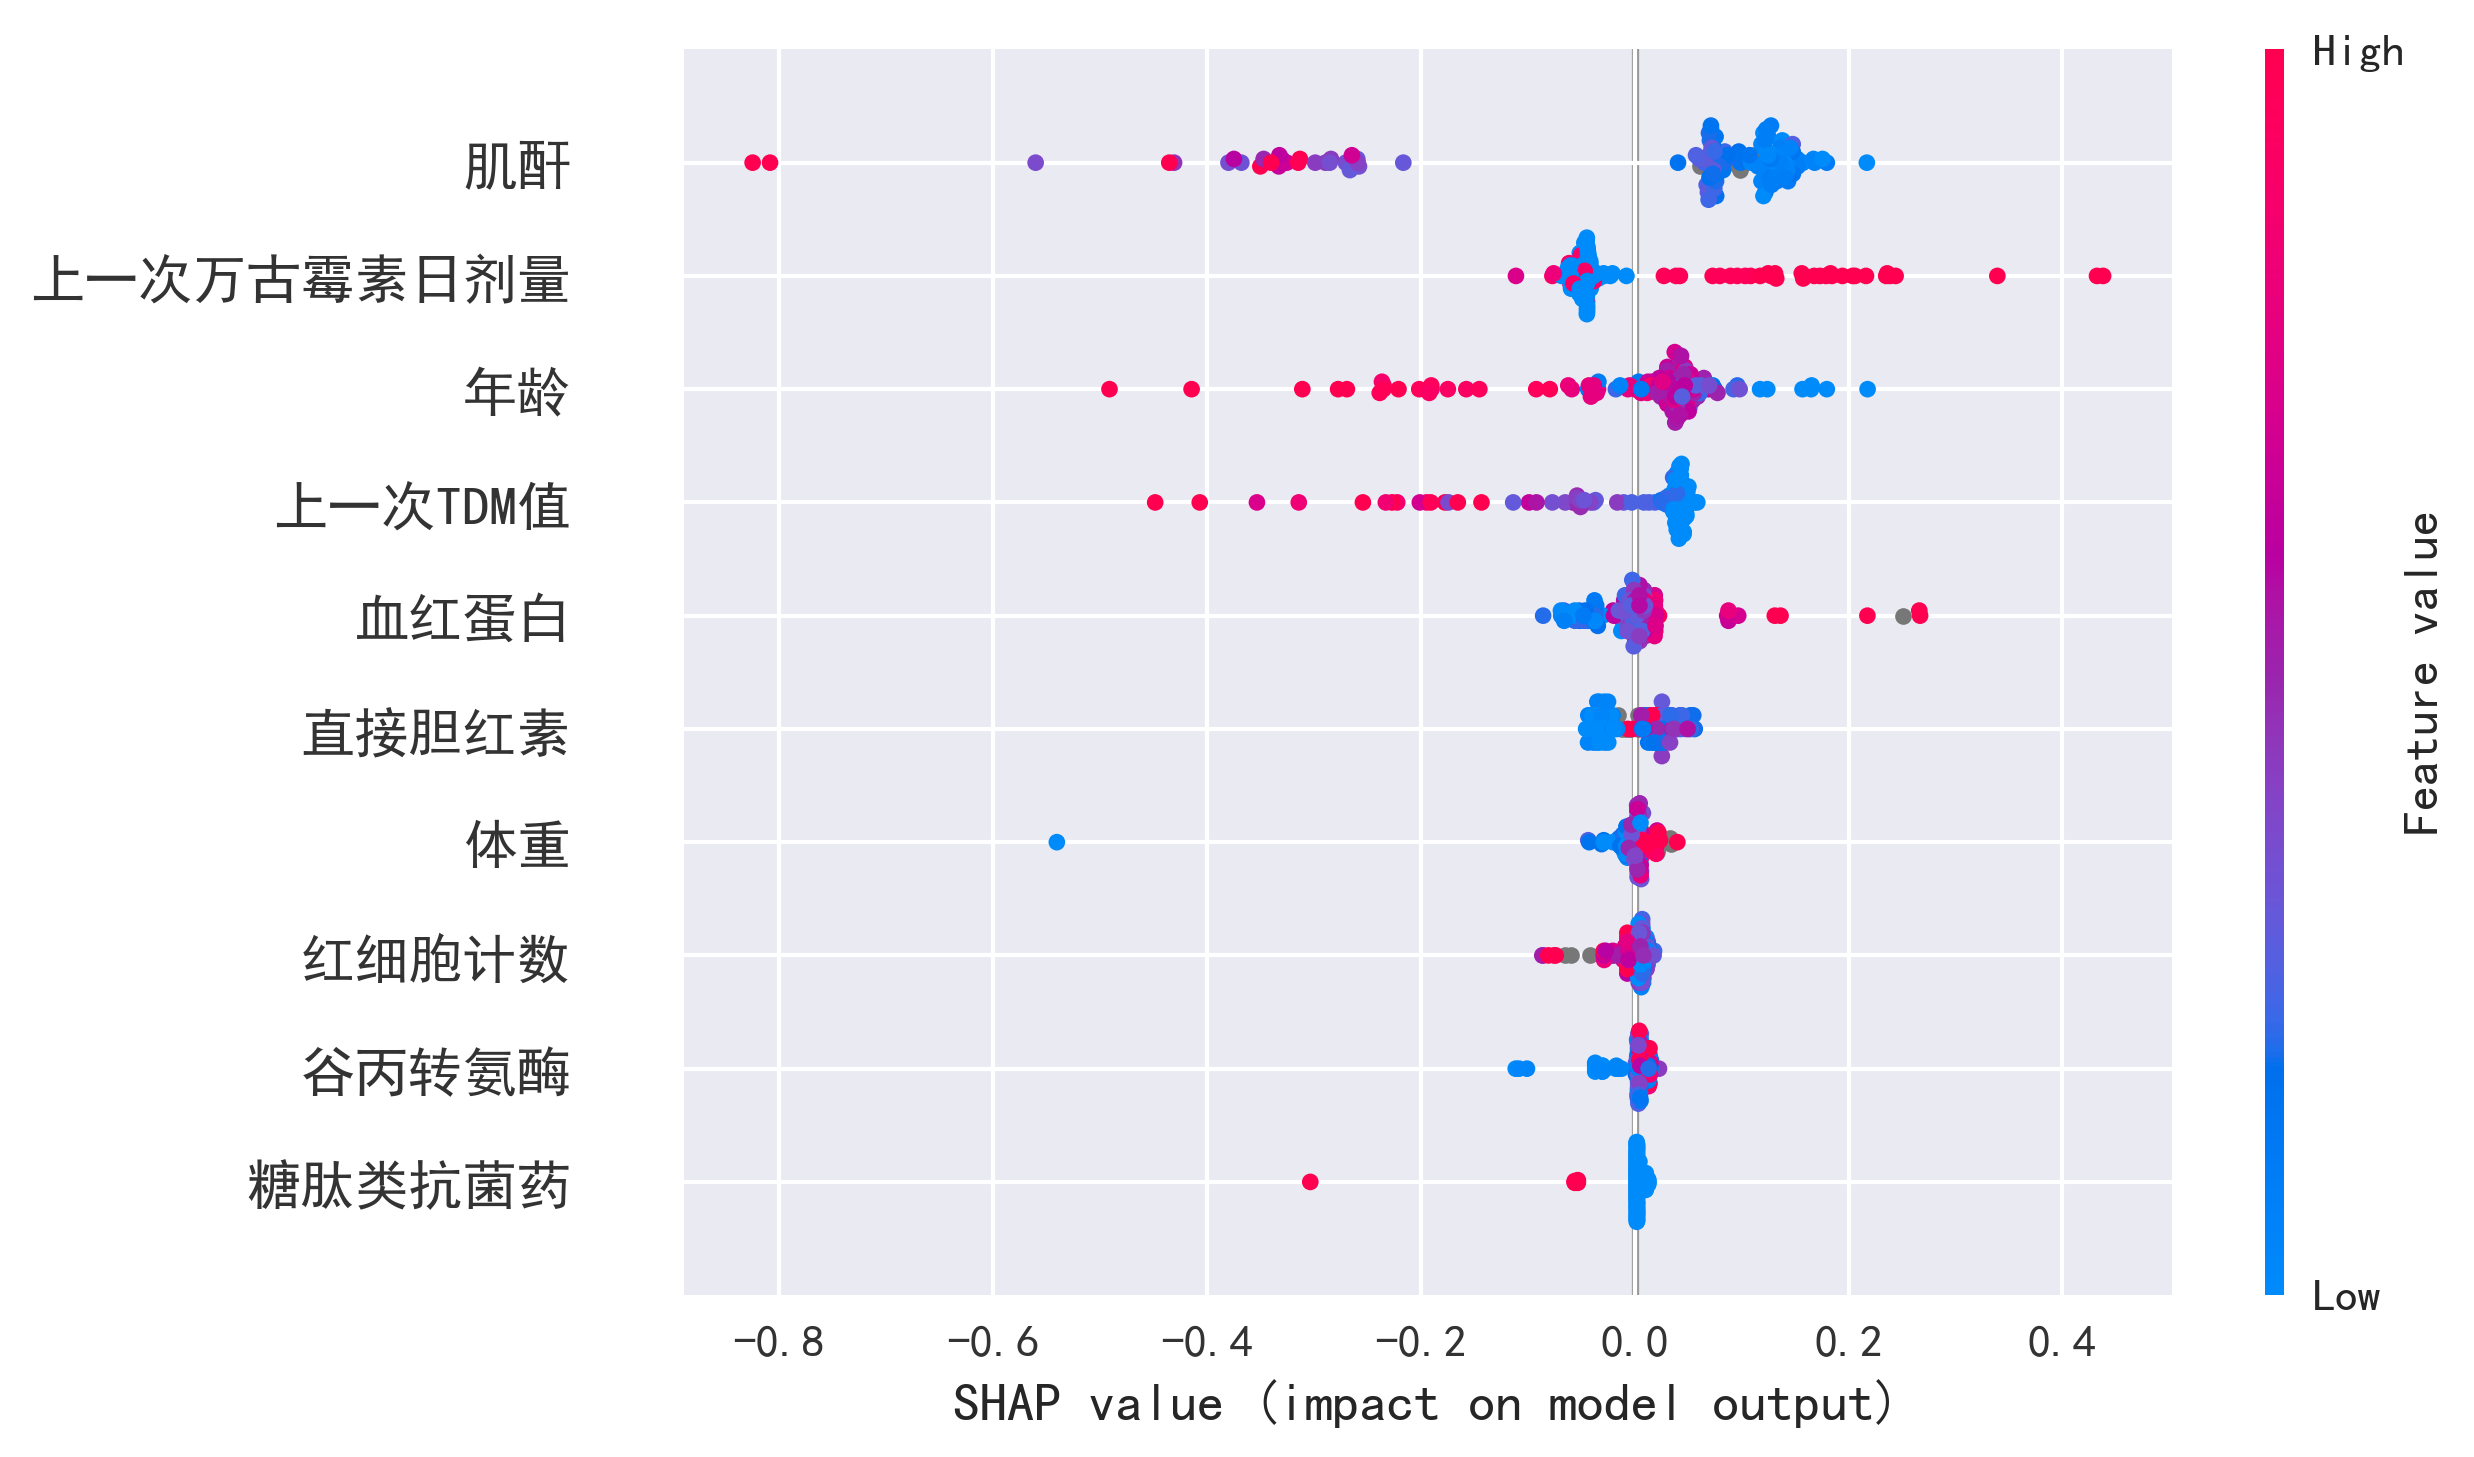

In [48]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
# ================================ 显示中文 ============================
shap.initjs()
shap.summary_plot(shap_values_1, tran_x_1)
## 每一行代表一个特征，横坐标为SHAP值。
#  颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小
#  上一次万古霉素日剂量是一个重要的特征， 与预测值基本成正相关。  年龄也是，大部分红色都分布在右边
#   肌酐、尿酸就是明显的负相关


In [49]:
# #  取出 top 10的 tran_x的列名
shap_list = list(im_auto['Variable Name'])
tranx_list = list(tran_x.columns)

# 取出 top20 列名对应的index
a_list = []
for i in shap_list:
    a_list.append(tranx_list.index(i))
    
# 取出 top_X  的shap值和dataframe
tran_x_1 = tran_x[shap_list]
shap_values_1 = shap_values[:,a_list]

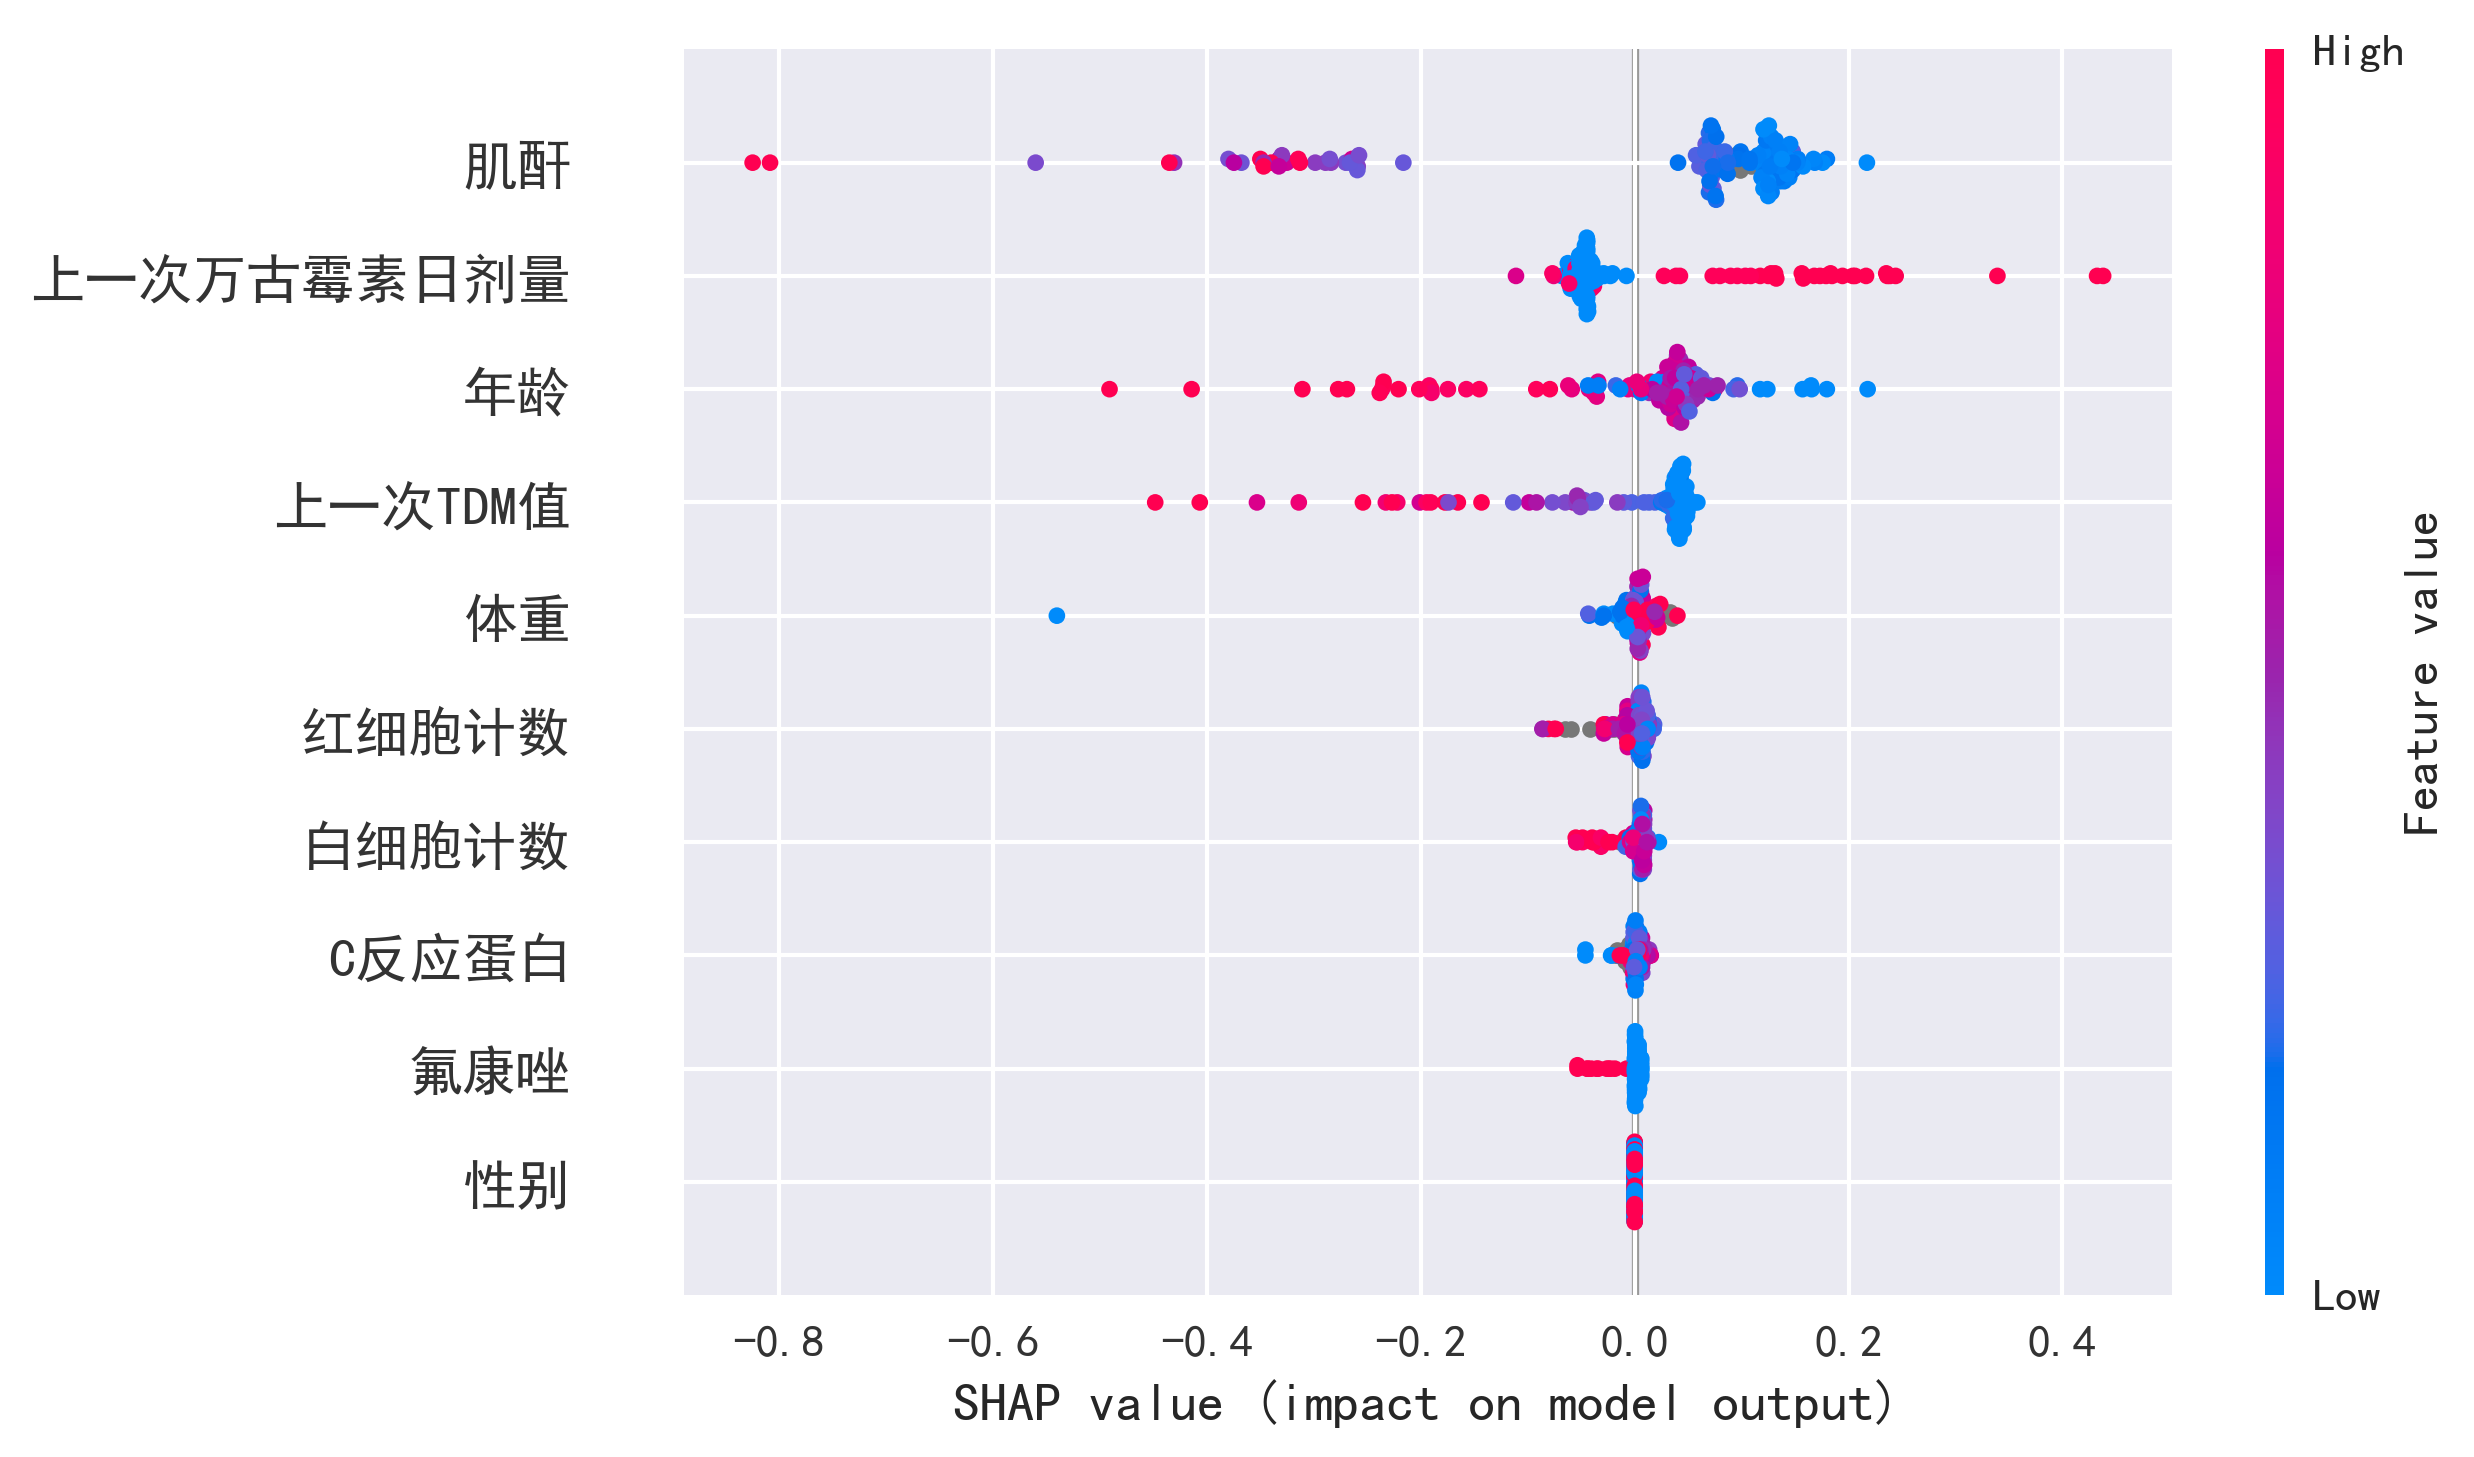

In [50]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
# ================================ 显示中文 ============================
shap.initjs()
shap.summary_plot(shap_values_1, tran_x_1)
## 每一行代表一个特征，横坐标为SHAP值。
#  颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小
#  上一次万古霉素日剂量是一个重要的特征， 与预测值基本成正相关。  年龄也是，大部分红色都分布在右边
#   肌酐、尿酸就是明显的负相关


## 交叉变量

In [51]:
print(df_old_2.columns)
print(df_new_2.columns)

Index(['patient_id', '年龄', '性别', '体重', '万古霉素日剂量', '上一次万古霉素日剂量', '上一次TDM值',
       '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸', '肌酐', '降钙素原',
       'C反应蛋白', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '总蛋白', '红细胞计数', '白细胞计数',
       '血小板计数', '血红蛋白', '红细胞压积'],
      dtype='object')
Index(['patient_id', '年龄', '性别', '体重', '万古霉素日剂量', '上一次万古霉素日剂量', '上一次TDM值',
       '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸', '肌酐', '降钙素原',
       'C反应蛋白', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '总蛋白', '红细胞计数', '白细胞计数',
       '血小板计数', '血红蛋白', '红细胞压积'],
      dtype='object')


In [52]:
df_old_2.shape

(117, 27)

In [53]:
df_new_2.shape

(67, 27)

In [54]:
df_old_2['type'] = 'old'
df_new_2['type'] = 'new'

df_old_new = pd.concat([df_old_2,df_new_2],axis=0)
df_old_new = df_old_new.reset_index()
del df_old_new['index']

In [55]:
df_old_new.shape

(184, 28)

In [56]:
df_old_new['体重'].describe()

count    154.000000
mean      63.367208
std       13.084766
min       35.000000
25%       55.000000
50%       62.500000
75%       70.000000
max      174.000000
Name: 体重, dtype: float64

In [57]:
df_old_new[df_old_new['性别']==0]['体重'].describe()

count     99.000000
mean      65.975758
std       14.015226
min       35.000000
25%       60.000000
50%       65.000000
75%       70.000000
max      174.000000
Name: 体重, dtype: float64

In [58]:
df_old_new[df_old_new['性别']==1]['体重'].describe()

count    55.000000
mean     58.671818
std       9.679377
min      43.000000
25%      50.000000
50%      55.000000
75%      60.000000
max      80.500000
Name: 体重, dtype: float64

In [59]:
def dispersed_niaosuan(x,y):
    if x<428 and y==0:
        z='偏低'
    elif x>208 and y==0:
        z='偏高'
    elif x<149 and y==1:
        z='偏低'
    elif x>369 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'尿酸']=dispersed_niaosuan(df_old_new.loc[i,'尿酸'],df_old_new.loc[i,'性别'])

In [60]:
def dispersed_jigan(x,y):
    if x<58 and y==0:
        z='偏低'
    elif x>110 and y==0:
        z='偏高'
    elif x<46 and y==1:
        z='偏低'
    elif x>92 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'肌酐']=dispersed_jigan(df_old_new.loc[i,'肌酐'],df_old_new.loc[i,'性别'])

In [61]:
def dispersed_weight(x,y):
    if x<=60 and y==0:
        z='偏低'
    elif x>=70 and y==0:
        z='偏高'
    elif x<=50 and y==1:
        z='偏低'
    elif x>=60 and y==1:
        z='偏高'
    else:
        z='中等'
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'体重_分段']=dispersed_weight(df_old_new.loc[i,'体重'],df_old_new.loc[i,'性别'])

In [62]:
# def dispersed_niaosu(x,y):
#     if x<3.2 and y==0:
#         z='偏低'
#     elif x>7.1 and y==0:
#         z='偏高'
#     elif x<2.5 and y==1:
#         z='偏低'
#     elif x>6.1 and y==1:
#         z='偏高'
#     else:
#         z=np.nan
#     return z
# for i in range(df_old_new.shape[0]):
#     df_old_new.loc[i,'尿素氮']=dispersed_niaosu(df_old_new.loc[i,'尿素氮'],df_old_new.loc[i,'性别'])

In [63]:
def dispersed_gucao(x,y):
    if x<17 and y==0:
        z='偏低'
    elif x>59 and y==0:
        z='偏高'
    elif x<14 and y==1:
        z='偏低'
    elif x>36 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'谷草转氨酶']=dispersed_gucao(df_old_new.loc[i,'谷草转氨酶'],df_old_new.loc[i,'性别'])

In [64]:
def dispersed_gubing(x,y):
    if x<21 and y==0:
        z='偏低'
    elif x>72 and y==0:
        z='偏高'
    elif x<9 and y==1:
        z='偏低'
    elif x>52 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'谷丙转氨酶']=dispersed_gubing(df_old_new.loc[i,'谷丙转氨酶'],df_old_new.loc[i,'性别'])

In [65]:
def dispersed_red(x,y):
    if x<4 and y==0:
        z='偏低'
    elif x>5.5 and y==0:
        z='偏高'
    elif x<3.5 and y==1:
        z='偏低'
    elif x>5 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'红细胞计数']=dispersed_red(df_old_new.loc[i,'红细胞计数'],df_old_new.loc[i,'性别'])

In [66]:
def dispersed_xuehong(x,y):
    if x<120 and y==0:
        z='偏低'
    elif x>160 and y==0:
        z='偏高'
    elif x<110 and y==1:
        z='偏低'
    elif x>150 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'血红蛋白']=dispersed_xuehong(df_old_new.loc[i,'血红蛋白'],df_old_new.loc[i,'性别'])

In [67]:
def dispersed_redy(x,y):
    if x<35 and y==0:
        z='偏低'
    elif x>49 and y==0:
        z='偏高'
    elif x<33 and y==1:
        z='偏低'
    elif x>45 and y==1:
        z='偏高'
    else:
        z=np.nan
    return z
for i in range(df_old_new.shape[0]):
    df_old_new.loc[i,'红细胞压积']=dispersed_redy(df_old_new.loc[i,'红细胞压积'],df_old_new.loc[i,'性别'])

In [68]:
df_old_new['年龄_分段']=df_old_new['年龄'].apply(lambda x: '小于18岁' if x<18 else '18到60岁' if 18<=x<=60 else '大于60岁' if x>60 else x)
df_old_new['上一次万古霉素日剂量']=df_old_new['上一次万古霉素日剂量'].apply(lambda x: '小于1000mg' if x<1000 else '1000到2000mg' if 1000<=x<=2000 else '大于2000mg' if x>2000 else x)
df_old_new['上一次TDM值']=df_old_new['上一次TDM值'].apply(lambda x: '小于10' if x<10 else '10到20' if 10<=x<=20 else '大于20' if x>20 else x)

df_old_new['降钙素原']=df_old_new['降钙素原'].apply(lambda x: np.nan if x<=0.5 else '偏高' if x>0.5 else x)
df_old_new['C反应蛋白']=df_old_new['C反应蛋白'].apply(lambda x:np.nan if x<=8 else '偏高' if x>8 else x)
df_old_new['总胆红素']=df_old_new['总胆红素'].apply(lambda x: '偏低' if x<3 else np.nan if 3<=x<=21 else '偏高' if x>21 else x)
df_old_new['直接胆红素']=df_old_new['直接胆红素'].apply(lambda x: np.nan if x<=5 else '偏高' if x>5 else x)
df_old_new['总蛋白']=df_old_new['总蛋白'].apply(lambda x: '偏低' if x<63 else np.nan if 63<=x<=85 else '偏高' if x>85 else x)

df_old_new['血小板计数']=df_old_new['血小板计数'].apply(lambda x: '偏低' if x<100 else np.nan if 100<=x<=300 else '偏高' if x>300 else x)
df_old_new['白细胞计数']=df_old_new['白细胞计数'].apply(lambda x: '偏低' if x<4 else np.nan if 4<=x<=10 else '偏高' if x>10 else x)

# df_old_new['中性粒细胞%']=df_old_new['中性粒细胞%'].apply(lambda x: '偏低' if x<50 else np.nan if 50<=x<=70 else '偏高' if x>70 else x)
# df_old_new['淋巴细胞%']=df_old_new['淋巴细胞%'].apply(lambda x:'偏低' if x<20 else np.nan if 20<=x<=40 else '偏高' if x>40 else x)


In [69]:
df_old_new.columns

Index(['patient_id', '年龄', '性别', '体重', '万古霉素日剂量', '上一次万古霉素日剂量', '上一次TDM值',
       '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类', '免疫抑制剂', '尿酸', '肌酐', '降钙素原',
       'C反应蛋白', '谷丙转氨酶', '谷草转氨酶', '总胆红素', '直接胆红素', '总蛋白', '红细胞计数', '白细胞计数',
       '血小板计数', '血红蛋白', '红细胞压积', 'type', '体重_分段', '年龄_分段'],
      dtype='object')

In [70]:
## 这里的性别分段了， 性别_男 、 性别_女
one_hot_cols=['年龄_分段','上一次万古霉素日剂量','上一次TDM值','体重_分段','性别',\
              '尿酸','肌酐','降钙素原','C反应蛋白','谷草转氨酶','谷丙转氨酶',
              '总胆红素','直接胆红素','总蛋白','红细胞计数','白细胞计数','血小板计数',
              '血红蛋白','红细胞压积']
for j in one_hot_cols:
    temp1=pd.get_dummies(df_old_new[j])
    for i in temp1.columns:
        df_old_new[str(j) + '_' +str(i)]=temp1[i] 
df_old_new=df_old_new.drop(one_hot_cols,axis=1)

In [71]:
df_old_new = df_old_new.rename(columns={'性别_0':'性别_男','性别_1':'性别_女'})

In [72]:
df_old_new.columns

Index(['patient_id', '年龄', '体重', '万古霉素日剂量', '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑',
       '喹诺酮类', '免疫抑制剂', 'type', '年龄_分段_18到60岁', '年龄_分段_大于60岁',
       '上一次万古霉素日剂量_小于1000mg', '上一次TDM值_10到20', '上一次TDM值_大于20', '上一次TDM值_小于10',
       '体重_分段_中等', '体重_分段_偏低', '体重_分段_偏高', '性别_男', '性别_女', '尿酸_偏低', '尿酸_偏高',
       '肌酐_偏低', '肌酐_偏高', '降钙素原_偏高', 'C反应蛋白_偏高', '谷草转氨酶_偏低', '谷草转氨酶_偏高',
       '谷丙转氨酶_偏低', '谷丙转氨酶_偏高', '总胆红素_偏高', '直接胆红素_偏高', '总蛋白_偏低', '红细胞计数_偏低',
       '红细胞计数_偏高', '白细胞计数_偏低', '白细胞计数_偏高', '血小板计数_偏低', '血小板计数_偏高', '血红蛋白_偏低',
       '血红蛋白_偏高', '红细胞压积_偏低'],
      dtype='object')

In [73]:
df_old_new.shape

(184, 44)

In [74]:
df_old_new=df_old_new.rename(columns={'万古霉素日剂量':'wwwww'})
df_old_new=df_old_new.drop(columns=['年龄', '体重'])


In [75]:
df_old_new.shape

(184, 42)

In [76]:
import pandas as pd
import featuretools as ft

es = ft.EntitySet(id='vancomycin')
es.entity_from_dataframe(entity_id='vancomycin',dataframe=df_old_new,make_index=True,index='index')
feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'vancomycin',trans_primitives=['multiply_numeric'])
feature_matrix.head()

patient_id     wwwww  糖肽类抗菌药  袢利尿剂  氨基糖苷类  氟康唑  喹诺酮类  免疫抑制剂 type  \
index                                                                    
0       10107453  6.907755     1.0   1.0    1.0  0.0   0.0    0.0  old   
1       11097678  7.313220     0.0   0.0    1.0  0.0   0.0    0.0  old   
2       30019203  6.907755     0.0   1.0    0.0  0.0   0.0    1.0  old   
3       30028672  7.600902     0.0   1.0    1.0  1.0   0.0    0.0  old   
4       30087383  6.907755     0.0   0.0    0.0  1.0   1.0    0.0  old   

       年龄_分段_18到60岁  ...  体重_分段_中等 * 谷草转氨酶_偏低  年龄_分段_大于60岁 * 白细胞计数_偏高  \
index                ...                                                
0                 0  ...                    0                       0   
1                 0  ...                    0                       1   
2                 0  ...                    0                       1   
3                 0  ...                    0                       1   
4                 0  ...                    0                       0   

       白细胞计数_偏高 * 血小板计数_偏低  上一次TDM值_小于10 * 体重_分段_偏高  上一次TDM值_大于20 * 血红蛋白_偏高  \
index                                                                         
0                        0                        0                       0   
1                        0                        0                       0   
2                        1                        1                       0   
3                        0                        1                       0   
4                        0                        0                       0   

       血红蛋白_偏低 * 袢利尿剂  上一次万古霉素日剂量_小于1000mg * 血红蛋白_偏高  血小板计数_偏低 * 血红蛋白_偏高  \
index                                                                      
0                 1.0                              0                   0   
1                 0.0                              0                   0   
2                 1.0                              0                   0   
3                 1.0                              0                   0   
4                 0.0                              0                   0   

       年龄_分段_大于60岁 * 糖肽类抗菌药  C反应蛋白_偏高 * 谷草转氨酶_偏高  
index                                             
0                       1.0                    1  
1                       0.0                    0  
2                       0.0                    0  
3                       0.0                    0  
4                       0.0                    0  

[5 rows x 822 columns]

In [77]:
feature_matrix.columns[0:50]

Index(['patient_id', 'wwwww', '糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类',
       '免疫抑制剂', 'type', '年龄_分段_18到60岁', '年龄_分段_大于60岁', '上一次万古霉素日剂量_小于1000mg',
       '上一次TDM值_10到20', '上一次TDM值_大于20', '上一次TDM值_小于10', '体重_分段_中等', '体重_分段_偏低',
       '体重_分段_偏高', '性别_男', '性别_女', '尿酸_偏低', '尿酸_偏高', '肌酐_偏低', '肌酐_偏高',
       '降钙素原_偏高', 'C反应蛋白_偏高', '谷草转氨酶_偏低', '谷草转氨酶_偏高', '谷丙转氨酶_偏低', '谷丙转氨酶_偏高',
       '总胆红素_偏高', '直接胆红素_偏高', '总蛋白_偏低', '红细胞计数_偏低', '红细胞计数_偏高', '白细胞计数_偏低',
       '白细胞计数_偏高', '血小板计数_偏低', '血小板计数_偏高', '血红蛋白_偏低', '血红蛋白_偏高', '红细胞压积_偏低',
       '红细胞压积_偏低 * 血红蛋白_偏高', '上一次万古霉素日剂量_小于1000mg * 体重_分段_偏低',
       '上一次TDM值_大于20 * 红细胞压积_偏低', '上一次TDM值_大于20 * 性别_女',
       '年龄_分段_18到60岁 * 谷丙转氨酶_偏高', 'wwwww * 肌酐_偏高', '红细胞压积_偏低 * 红细胞计数_偏低',
       '上一次万古霉素日剂量_小于1000mg * 谷丙转氨酶_偏高'],
      dtype='object')

In [78]:
df_feature = feature_matrix.drop(columns=['糖肽类抗菌药', '袢利尿剂', '氨基糖苷类', '氟康唑', '喹诺酮类',
       '免疫抑制剂', '年龄_分段_18到60岁', '年龄_分段_大于60岁', '上一次万古霉素日剂量_小于1000mg',
       '上一次TDM值_10到20', '上一次TDM值_大于20', '上一次TDM值_小于10', '体重_分段_中等', '体重_分段_偏低',
       '体重_分段_偏高', '性别_男', '性别_女', '尿酸_偏低', '尿酸_偏高', '肌酐_偏低', '肌酐_偏高',
       '降钙素原_偏高', 'C反应蛋白_偏高', '谷草转氨酶_偏低', '谷草转氨酶_偏高', '谷丙转氨酶_偏低', '谷丙转氨酶_偏高',
       '总胆红素_偏高', '直接胆红素_偏高', '总蛋白_偏低', '红细胞计数_偏低', '红细胞计数_偏高', '白细胞计数_偏低',
       '白细胞计数_偏高', '血小板计数_偏低', '血小板计数_偏高', '血红蛋白_偏低', '血红蛋白_偏高', '红细胞压积_偏低'])

In [79]:
df_feature.shape

(184, 783)

In [80]:
a = []
b = []
c = []
for x in df_feature.columns:
    if 'wwww' in x:
        a.append(x)
    if 'patient_id' in x:
        b.append(x)
    if 'type' in x:
        c.append(x)

In [81]:
a

['wwwww',
 'wwwww * 肌酐_偏高',
 'wwwww * 谷丙转氨酶_偏高',
 'wwwww * 红细胞计数_偏高',
 'wwwww * 性别_男',
 'wwwww * 袢利尿剂',
 'wwwww * 降钙素原_偏高',
 'wwwww * 氟康唑',
 'wwwww * 白细胞计数_偏高',
 'wwwww * 血小板计数_偏低',
 'wwwww * 氨基糖苷类',
 'wwwww * 体重_分段_偏高',
 'wwwww * 上一次TDM值_小于10',
 'wwwww * 尿酸_偏高',
 'wwwww * 上一次万古霉素日剂量_小于1000mg',
 'wwwww * 体重_分段_偏低',
 'wwwww * 血红蛋白_偏高',
 'C反应蛋白_偏高 * wwwww',
 'wwwww * 尿酸_偏低',
 'wwwww * 上一次TDM值_大于20',
 'wwwww * 年龄_分段_大于60岁',
 'wwwww * 红细胞计数_偏低',
 'wwwww * 肌酐_偏低',
 'wwwww * 直接胆红素_偏高',
 'wwwww * 血红蛋白_偏低',
 'wwwww * 喹诺酮类',
 'wwwww * 年龄_分段_18到60岁',
 'wwwww * 上一次TDM值_10到20',
 'wwwww * 谷草转氨酶_偏低',
 'wwwww * 性别_女',
 'wwwww * 总蛋白_偏低',
 'wwwww * 体重_分段_中等',
 'wwwww * 总胆红素_偏高',
 'wwwww * 白细胞计数_偏低',
 'wwwww * 血小板计数_偏高',
 'wwwww * 谷丙转氨酶_偏低',
 'wwwww * 免疫抑制剂',
 'wwwww * 谷草转氨酶_偏高',
 'wwwww * 红细胞压积_偏低',
 'wwwww * 糖肽类抗菌药']

In [82]:
df_feature_1=df_feature.drop(columns=['wwwww * 上一次TDM值_大于20', 'wwwww * 上一次万古霉素日剂量_小于1000mg', 'wwwww * 尿酸_偏高', 
                                      'wwwww * 红细胞计数_偏高', 'wwwww * 体重_分段_偏低', 'wwwww * 白细胞计数_偏低', 'wwwww * 总蛋白_偏低',
                                      'wwwww * 直接胆红素_偏高', 'wwwww * 红细胞压积_偏低', 'wwwww * 总胆红素_偏高', 'wwwww * 血小板计数_偏低',
                                      'wwwww * 氨基糖苷类', 'wwwww * 谷草转氨酶_偏低', 'wwwww * 上一次TDM值_10到20', 'wwwww * 性别_男',
                                      'wwwww * 降钙素原_偏高', 'wwwww * 氟康唑', 'wwwww * 体重_分段_中等', 'wwwww * 上一次TDM值_小于10',
                                      'wwwww * 喹诺酮类', 'wwwww * 白细胞计数_偏高', 'wwwww * 谷丙转氨酶_偏高', 'wwwww * 谷丙转氨酶_偏低',
                                      'wwwww * 血红蛋白_偏低', 'wwwww * 红细胞计数_偏低', 'wwwww * 肌酐_偏低', 'wwwww * 尿酸_偏低',
                                      'wwwww * 年龄_分段_大于60岁', 'wwwww * 血小板计数_偏高', 'wwwww * 年龄_分段_18到60岁', 'wwwww * 性别_女',
                                      'wwwww * 体重_分段_偏高', 'C反应蛋白_偏高 * wwwww', 'wwwww * 肌酐_偏高', 'wwwww * 血红蛋白_偏高',
                                      'wwwww * 糖肽类抗菌药', 'wwwww * 免疫抑制剂', 'wwwww * 谷草转氨酶_偏高', 'wwwww * 袢利尿剂'])
df_feature_1.shape

(184, 744)

In [83]:
a = []
b = []
c = []
for x in df_feature_1.columns:
    if 'wwww' in x:
        a.append(x)
    if 'patient_id' in x:
        b.append(x)
    if 'type' in x:
        c.append(x)

In [84]:
print(a)
print(b)
print(c)

['wwwww']
['patient_id']
['type']


In [85]:
df_feature_1 = df_feature_1.rename(columns={'wwwww':'万古霉素日剂量'})

In [86]:
df_feature_1.columns

Index(['patient_id', '万古霉素日剂量', 'type', '红细胞压积_偏低 * 血红蛋白_偏高',
       '上一次万古霉素日剂量_小于1000mg * 体重_分段_偏低', '上一次TDM值_大于20 * 红细胞压积_偏低',
       '上一次TDM值_大于20 * 性别_女', '年龄_分段_18到60岁 * 谷丙转氨酶_偏高', '红细胞压积_偏低 * 红细胞计数_偏低',
       '上一次万古霉素日剂量_小于1000mg * 谷丙转氨酶_偏高',
       ...
       '体重_分段_中等 * 谷草转氨酶_偏低', '年龄_分段_大于60岁 * 白细胞计数_偏高', '白细胞计数_偏高 * 血小板计数_偏低',
       '上一次TDM值_小于10 * 体重_分段_偏高', '上一次TDM值_大于20 * 血红蛋白_偏高', '血红蛋白_偏低 * 袢利尿剂',
       '上一次万古霉素日剂量_小于1000mg * 血红蛋白_偏高', '血小板计数_偏低 * 血红蛋白_偏高',
       '年龄_分段_大于60岁 * 糖肽类抗菌药', 'C反应蛋白_偏高 * 谷草转氨酶_偏高'],
      dtype='object', length=744)

In [87]:
# writer=pd.ExcelWriter(r'../数据提取/df_featire_交叉变量_0710.xlsx')
# df_feature_1.to_excel(writer)
# writer.save()

## XGBoost 跑交叉变量

In [88]:
np.unique(df_feature_1['type'])

array(['new', 'old'], dtype=object)

In [89]:
df_old_feature = df_feature_1[df_feature_1['type'] == 'old']
df_new_feature = df_feature_1[df_feature_1['type'] == 'new']

df_old_feature = df_old_feature.drop(columns=['type'])
df_new_feature = df_new_feature.drop(columns=['type'])

df_old_feature = df_old_feature.reset_index()
del df_old_feature['index']

df_new_feature = df_new_feature.reset_index()
del df_new_feature['index']

In [90]:
print(df_old_feature.shape)
print(df_new_feature.shape)

(117, 743)
(67, 743)


In [91]:
# df_old_feature.columns

In [92]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import lightgbm as lgb
import catboost as ctb

In [93]:
from sklearn.model_selection import train_test_split
x_old_feature = df_old_feature.iloc[:,1:]
y_old_feature = df_old_feature['万古霉素日剂量']
tran_x_old_feature,test_x_old_feature,tran_y_old_feature,test_y_old_feature = train_test_split(x_old_feature,y_old_feature,test_size=0.3,random_state = 60)
x_new_feature = df_new_feature.iloc[:,1:]
y_new_feature = df_new_feature['万古霉素日剂量']
tran_x_new_feature,test_x_new_feature,tran_y_new_feature,test_y_new_feature = train_test_split(x_new_feature,y_new_feature,test_size=0.3,random_state = 60)

tran_x_new_feature.index += 1000
test_x_new_feature.index += 1000
tran_y_new_feature.index += 1000
test_y_new_feature.index += 1000
# 训练集
tran_x_feature = pd.concat([tran_x_old_feature,tran_x_new_feature],axis=0)
tran_y_feature = pd.concat([tran_y_old_feature,tran_y_new_feature],axis=0)
# 测试集
test_x_feature = pd.concat([test_x_old_feature,test_x_new_feature],axis=0)
test_y_feature = pd.concat([test_y_old_feature,test_y_new_feature],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

# Tell auto_ml which column is 'output'
# Also note columns that aren't purely numerical
# Examples include ['nlp', 'date', 'categorical', 'ignore']

column_descriptions = {
    '万古霉素日剂量': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(tran_x_feature, model_names=['XGBRegressor'])
# ml_predictor.train(tran_x, model_names=['LGBMRegressor'])
# ml_predictor.train(tran_x, model_names=['CatBoostRegressor'])


test_score = ml_predictor.score(test_x_feature, test_x_feature['万古霉素日剂量'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x_feature)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 万古霉素日剂量
Started at:
2020-08-03 09:47:36
[09:47:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:l

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
0.36124894979041217

Here is the average of the predictions:
7.388723933905886

Here is the average actual value on this validation set:
7.378356612969535

Here is the median prediction:
7.444209575653076

Here is the median actual value:
7.600902459542082

Here is the mean absolute error:
0.27852599774133197

Here is the median absolute error (robust to outliers):
0.2558793062343341

Here is the explained variance:
0.3879068725577568

Here is the R-squared value:
0.38740233298149407
Count of positive differences (prediction > actual):
29
Count of negative differences:
28
Average positive difference:
0.28391239939013474
Average negative difference:
-0.27294722460507204


***********************************************




We have saved the trained pipeline to a filed called "auto_ml_saved_pipeline.d

In [94]:
# b = []
# for i in range(1000):
#     x_old_feature = df_old_feature.iloc[:,1:]
#     y_old_feature =df_old_feature['万古霉素日剂量']
#     tran_x_old_feature,test_x_old_feature,tran_y_old_feature,test_y_old_feature=train_test_split(x_old_feature.drop(columns=['万古霉素日剂量']),y_old_feature,test_size=0.3,random_state = i)
#     x_new_feature = df_new_feature.iloc[:,1:]
#     y_new_feature = df_new_feature['万古霉素日剂量']
#     tran_x_new_feature,test_x_new_feature,tran_y_new_feature,test_y_new_feature=train_test_split(x_new_feature.drop(columns=['万古霉素日剂量']),y_new_feature,test_size=0.3,random_state = i)

#     tran_x_new_feature.index += 1000
#     test_x_new_feature.index += 1000
#     tran_y_new_feature.index += 1000
#     test_y_new_feature.index += 1000
#     # 训练集
#     tran_x_feature = pd.concat([tran_x_old_feature,tran_x_new_feature],axis=0)
#     tran_y_feature = pd.concat([tran_y_old_feature,tran_y_new_feature],axis=0)
#     # 测试集
#     test_x_feature = pd.concat([test_x_old_feature,test_x_new_feature],axis=0)
#     test_y_feature = pd.concat([test_y_old_feature,test_y_new_feature],axis=0)
    
    
# #     tran_x,test_x,tran_y,test_y=train_test_split(x.drop(columns=['万古霉素日剂量']),y,test_size=0.2,random_state=i)
#     trained_model = load_ml_model(file_name)
#     params = trained_model.named_steps['final_model'].model.get_params()

#     model = xgb.XGBRegressor(**params)
#     eval_set = [(test_x_feature, test_y_feature)]
#     clt = model.fit(tran_x_feature,tran_y_feature,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
#     y_pred_feature = clt.predict(test_x_feature)
    
#     b.append(r2_score(test_y_feature,y_pred_feature,multioutput='variance_weighted'))

In [95]:
# print('最大r2:',max(b))
# print('对应的最大random_state:',b.index(max(b)))

# # 最大r2: 0.5875652884376468
# # 对应的最大random_state: 493

In [96]:
# c=sorted(b,reverse=1)
# c[0:20]

In [97]:
'''
 log() 后
 ============= 7:3 ==============
0.5875652884376468        493
0.5844942546464107        901 
0.576105703871431         688
0.5725400688124982        547
0.5679570378027935        112

0.5634291425696802        330
0.5621437011124042        788
0.5548465659446529        75
0.54808551729709          346
0.5380260121802629        549

0.5276221435891992        755
0.5231242765423815        305
0.5215084790121689        833
0.5140473238347055        860
0.5076120032693805        745
'''

'\n log() 后\n ============= 7:3 ==============\n0.5875652884376468        493\n0.5844942546464107        901 \n0.576105703871431         688\n0.5725400688124982        547\n0.5679570378027935        112\n\n0.5634291425696802        330\n0.5621437011124042        788\n0.5548465659446529        75\n0.54808551729709          346\n0.5380260121802629        549\n\n0.5276221435891992        755\n0.5231242765423815        305\n0.5215084790121689        833\n0.5140473238347055        860\n0.5076120032693805        745\n'

In [98]:
'''
单因素
 ============= 7:3 ==============
0.7316746151482905        60
0.6630077680548268        902 
0.6611028253253104        240
0.6444995618759257        541
0.6421280779466055        855

0.641494295256263         276
0.6411859039973263        150
0.6404612212348619        327
0.6344162313942889        473
0.6319221879612936        259
'''

'\n单因素\n ============= 7:3 ==============\n0.7316746151482905        60\n0.6630077680548268        902 \n0.6611028253253104        240\n0.6444995618759257        541\n0.6421280779466055        855\n\n0.641494295256263         276\n0.6411859039973263        150\n0.6404612212348619        327\n0.6344162313942889        473\n0.6319221879612936        259\n'

In [99]:
# b.index(0.5380260121802629)

In [100]:
df_old_feature

patient_id   万古霉素日剂量  红细胞压积_偏低 * 血红蛋白_偏高  上一次万古霉素日剂量_小于1000mg * 体重_分段_偏低  \
0     10107453  6.907755                   0                               1   
1     11097678  7.313220                   0                               0   
2     30019203  6.907755                   0                               0   
3     30028672  7.600902                   0                               0   
4     30087383  6.907755                   0                               0   
..         ...       ...                 ...                             ...   
112   77806695  7.600902                   0                               0   
113   77922168  8.006368                   0                               0   
114   77924632  8.006368                   0                               0   
115   77936191  6.214608                   0                               1   
116   77948666  8.006368                   0                               0   

     上一次TDM值_大于20 * 红细胞压积_偏低  上一次TDM值_大于20 * 性别_女  年龄_分段_18到60岁 * 谷丙转氨酶_偏高  \
0                          0                    0                        0   
1                          0                    0                        0   
2                          0                    0                        0   
3                          0                    0                        0   
4                          1                    1                        0   
..                       ...                  ...                      ...   
112                        0                    0                        0   
113                        0                    0                        0   
114                        0                    0                        0   
115                        1                    0                        0   
116                        0                    0                        0   

     红细胞压积_偏低 * 红细胞计数_偏低  上一次万古霉素日剂量_小于1000mg * 谷丙转氨酶_偏高  体重_分段_偏低 * 谷丙转氨酶_偏高  \
0                      1                               0                    0   
1                      1                               0                    0   
2                      1                               0                    0   
3                      0                               0                    0   
4                      0                               0                    0   
..                   ...                             ...                  ...   
112                    0                               0                    0   
113                    0                               0                    0   
114                    1                               0                    0   
115                    0                               0                    0   
116                    0                               0                    0   

     ...  体重_分段_中等 * 谷草转氨酶_偏低  年龄_分段_大于60岁 * 白细胞计数_偏高  白细胞计数_偏高 * 血小板计数_偏低  \
0    ...                    0                       0                    0   
1    ...                    0                       1                    0   
2    ...                    0                       1                    1   
3    ...                    0                       1                    0   
4    ...                    0                       0                    0   
..   ...                  ...                     ...                  ...   
112  ...                    1                       0                    0   
113  ...                    0                       1                    0   
114  ...                    0                       0                    0   
115  ...                    0                       0                    0   
116  ...                    0                       1                    0   

     上一次TDM值_小于10 * 体重_分段_偏高  上一次TDM值_大于20 * 血红蛋白_偏高  血红蛋白_偏低 * 袢利尿剂  \
0                          0                       0             1.0   
1                          0                       0

In [101]:
x_old_feature = df_old_feature.iloc[:,1:]
y_old_feature =df_old_feature['万古霉素日剂量']
tran_x_old_feature,test_x_old_feature,tran_y_old_feature,test_y_old_feature=train_test_split(x_old_feature.drop(columns=['万古霉素日剂量']),y_old_feature,test_size=0.3,random_state = 60)
x_new_feature = df_new_feature.iloc[:,1:]
y_new_feature = df_new_feature['万古霉素日剂量']
tran_x_new_feature,test_x_new_feature,tran_y_new_feature,test_y_new_feature=train_test_split(x_new_feature.drop(columns=['万古霉素日剂量']),y_new_feature,test_size=0.3,random_state = 60)

tran_x_new_feature.index += 1000
test_x_new_feature.index += 1000
tran_y_new_feature.index += 1000
test_y_new_feature.index += 1000
# 训练集
tran_x_feature = pd.concat([tran_x_old_feature,tran_x_new_feature],axis=0)
tran_y_feature = pd.concat([tran_y_old_feature,tran_y_new_feature],axis=0)
# 测试集
test_x_feature = pd.concat([test_x_old_feature,test_x_new_feature],axis=0)
test_y_feature = pd.concat([test_y_old_feature,test_y_new_feature],axis=0)
#============================= model ==================================
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x_feature, test_y_feature)]
clt = model.fit(tran_x_feature,tran_y_feature,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred_feature = clt.predict(test_x_feature)

b.append(r2_score(test_y_feature,y_pred_feature,multioutput='variance_weighted'))

[09:47:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
print('R2:  ',r2_score(test_y_feature,y_pred_feature,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_feature,y_pred_feature))
print('RMSE:',mean_squared_error(test_y_feature,y_pred_feature) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_feature,y_pred_feature))

R2:   0.4175480247925349
MSE:  0.12407891016878929
RMSE: 0.3522483643237954
MAE:  0.26632711698903605


In [103]:
im=pd.DataFrame({'Variable Name':tran_x_feature.columns,'Importance Score':model.feature_importances_})
im=im.sort_values(by='Importance Score',ascending=False)

im=im.reset_index()
del im['index']
im['Importance Score']=round(im['Importance Score'],4)
im = im[0:10]

im

Variable Name  Importance Score
0             红细胞压积_偏低 * 肌酐_偏高            0.0614
1               总蛋白_偏低 * 肌酐_偏高            0.0335
2             白细胞计数_偏高 * 肌酐_偏高            0.0288
3                 喹诺酮类 * 肌酐_偏高            0.0279
4         上一次TDM值_大于20 * 尿酸_偏高            0.0237
5          体重_分段_偏低 * 血小板计数_偏低            0.0206
6          年龄_分段_大于60岁 * 肌酐_偏高            0.0203
7                 性别_女 * 肌酐_偏高            0.0200
8  上一次万古霉素日剂量_小于1000mg * 肌酐_偏高            0.0192
9               性别_男 * 血红蛋白_偏低            0.0178

In [104]:
list(im['Variable Name'])

['红细胞压积_偏低 * 肌酐_偏高',
 '总蛋白_偏低 * 肌酐_偏高',
 '白细胞计数_偏高 * 肌酐_偏高',
 '喹诺酮类 * 肌酐_偏高',
 '上一次TDM值_大于20 * 尿酸_偏高',
 '体重_分段_偏低 * 血小板计数_偏低',
 '年龄_分段_大于60岁 * 肌酐_偏高',
 '性别_女 * 肌酐_偏高',
 '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高',
 '性别_男 * 血红蛋白_偏低']

In [105]:
im_cross_auto = pd.DataFrame(data={'Variable Name':['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
                                 '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
                                 '体重_分段_偏低 * 血小板计数_偏低','年龄_分段_大于60岁 * 肌酐_偏高',
                                 '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低','上一次TDM值_10到20 * 尿酸_偏高'],
                                   'Importance Score':[0.0584,0.0544,0.0319,0.0265,0.0225,
                                                      0.0195,0.0193,0.0190,0.0169,0.0165]})

In [106]:
im_cross_auto

Variable Name  Importance Score
0             红细胞压积_偏低 * 肌酐_偏高            0.0584
1  上一次万古霉素日剂量_小于1000mg * 肌酐_偏高            0.0544
2               总蛋白_偏低 * 肌酐_偏高            0.0319
3                 喹诺酮类 * 肌酐_偏高            0.0265
4         上一次TDM值_大于20 * 尿酸_偏高            0.0225
5          体重_分段_偏低 * 血小板计数_偏低            0.0195
6          年龄_分段_大于60岁 * 肌酐_偏高            0.0193
7                 性别_女 * 肌酐_偏高            0.0190
8               性别_男 * 血红蛋白_偏低            0.0169
9        上一次TDM值_10到20 * 尿酸_偏高            0.0165

## SHAP(交叉变量 Top20)

In [107]:
import shap
explainer = shap.TreeExplainer(model)

# shap值
shap_values = explainer.shap_values(tran_x_feature)

# 模型的基线ybase     (通常是所有样本的目标变量的均值)
y_base = explainer.expected_value
print(y_base)
y_pred_1 = model.predict(tran_x_feature)  # 这里是训练集的预测值，不是   *****
print(y_pred_1.mean())


7.3303533
7.330354


In [108]:
b = []
for i in range(shap_values.shape[1]):
    s = 0
    for j in range(shap_values.shape[0]):
        s += abs(shap_values[j][i])
#     print(n)
    b.append(round(s/shap_values.shape[0],4))

In [109]:
df_sv_sum = pd.DataFrame({'Variable Name':list(tran_x_feature.columns),'Shap Value':b})
df_sv_sum_1 = df_sv_sum.sort_values('Shap Value',ascending=False)
df_sv_sum_1 = df_sv_sum_1.reset_index()
del df_sv_sum_1['index']

In [110]:
# df_sv_sum_1[df_sv_sum_1['Variable Name']=='喹诺酮类 * 肌酐_偏高']
df_sv_sum_1.iloc[0:22]

Variable Name  Shap Value
0          年龄_分段_大于60岁 * 总蛋白_偏低      0.0617
1              红细胞压积_偏低 * 肌酐_偏高      0.0444
2                  性别_女 * 肌酐_偏高      0.0406
3   上一次TDM值_小于10 * 年龄_分段_18到60岁      0.0368
4                总蛋白_偏低 * 肌酐_偏高      0.0260
5           体重_分段_偏低 * 血小板计数_偏低      0.0250
6          上一次TDM值_大于20 * 尿酸_偏高      0.0235
7   上一次万古霉素日剂量_小于1000mg * 肌酐_偏高      0.0230
8                 尿酸_偏低 * 氨基糖苷类      0.0174
9                   性别_女 * 袢利尿剂      0.0166
10          上一次TDM值_大于20 * 性别_男      0.0149
11                   氟康唑 * 袢利尿剂      0.0145
12      上一次TDM值_大于20 * 体重_分段_中等      0.0142
13              尿酸_偏高 * 血红蛋白_偏低      0.0134
14                尿酸_偏低 * 肌酐_偏低      0.0124
15          年龄_分段_大于60岁 * 肌酐_偏高      0.0122
16             糖肽类抗菌药 * 降钙素原_偏高      0.0109
17              白细胞计数_偏高 * 袢利尿剂      0.0108
18      上一次TDM值_小于10 * 红细胞计数_偏低      0.0103
19             C反应蛋白_偏高 * 肌酐_偏高      0.0101
20             C反应蛋白_偏高 * 肌酐_偏低      0.0087
21          C反应蛋白_偏高 * 体重_分段_偏高      0.0080

In [111]:
# #  取出 top 10的 tran_x的列名
shap_list = list(im_cross_auto['Variable Name'])
tranx_list = list(tran_x_feature.columns)

# 取出 top20 列名对应的index
a_list = []
for i in shap_list:
    a_list.append(tranx_list.index(i))
    
# 取出 top_X  的shap值和dataframe
tran_x_1 = tran_x_feature[shap_list]
shap_values_1 = shap_values[:,a_list]

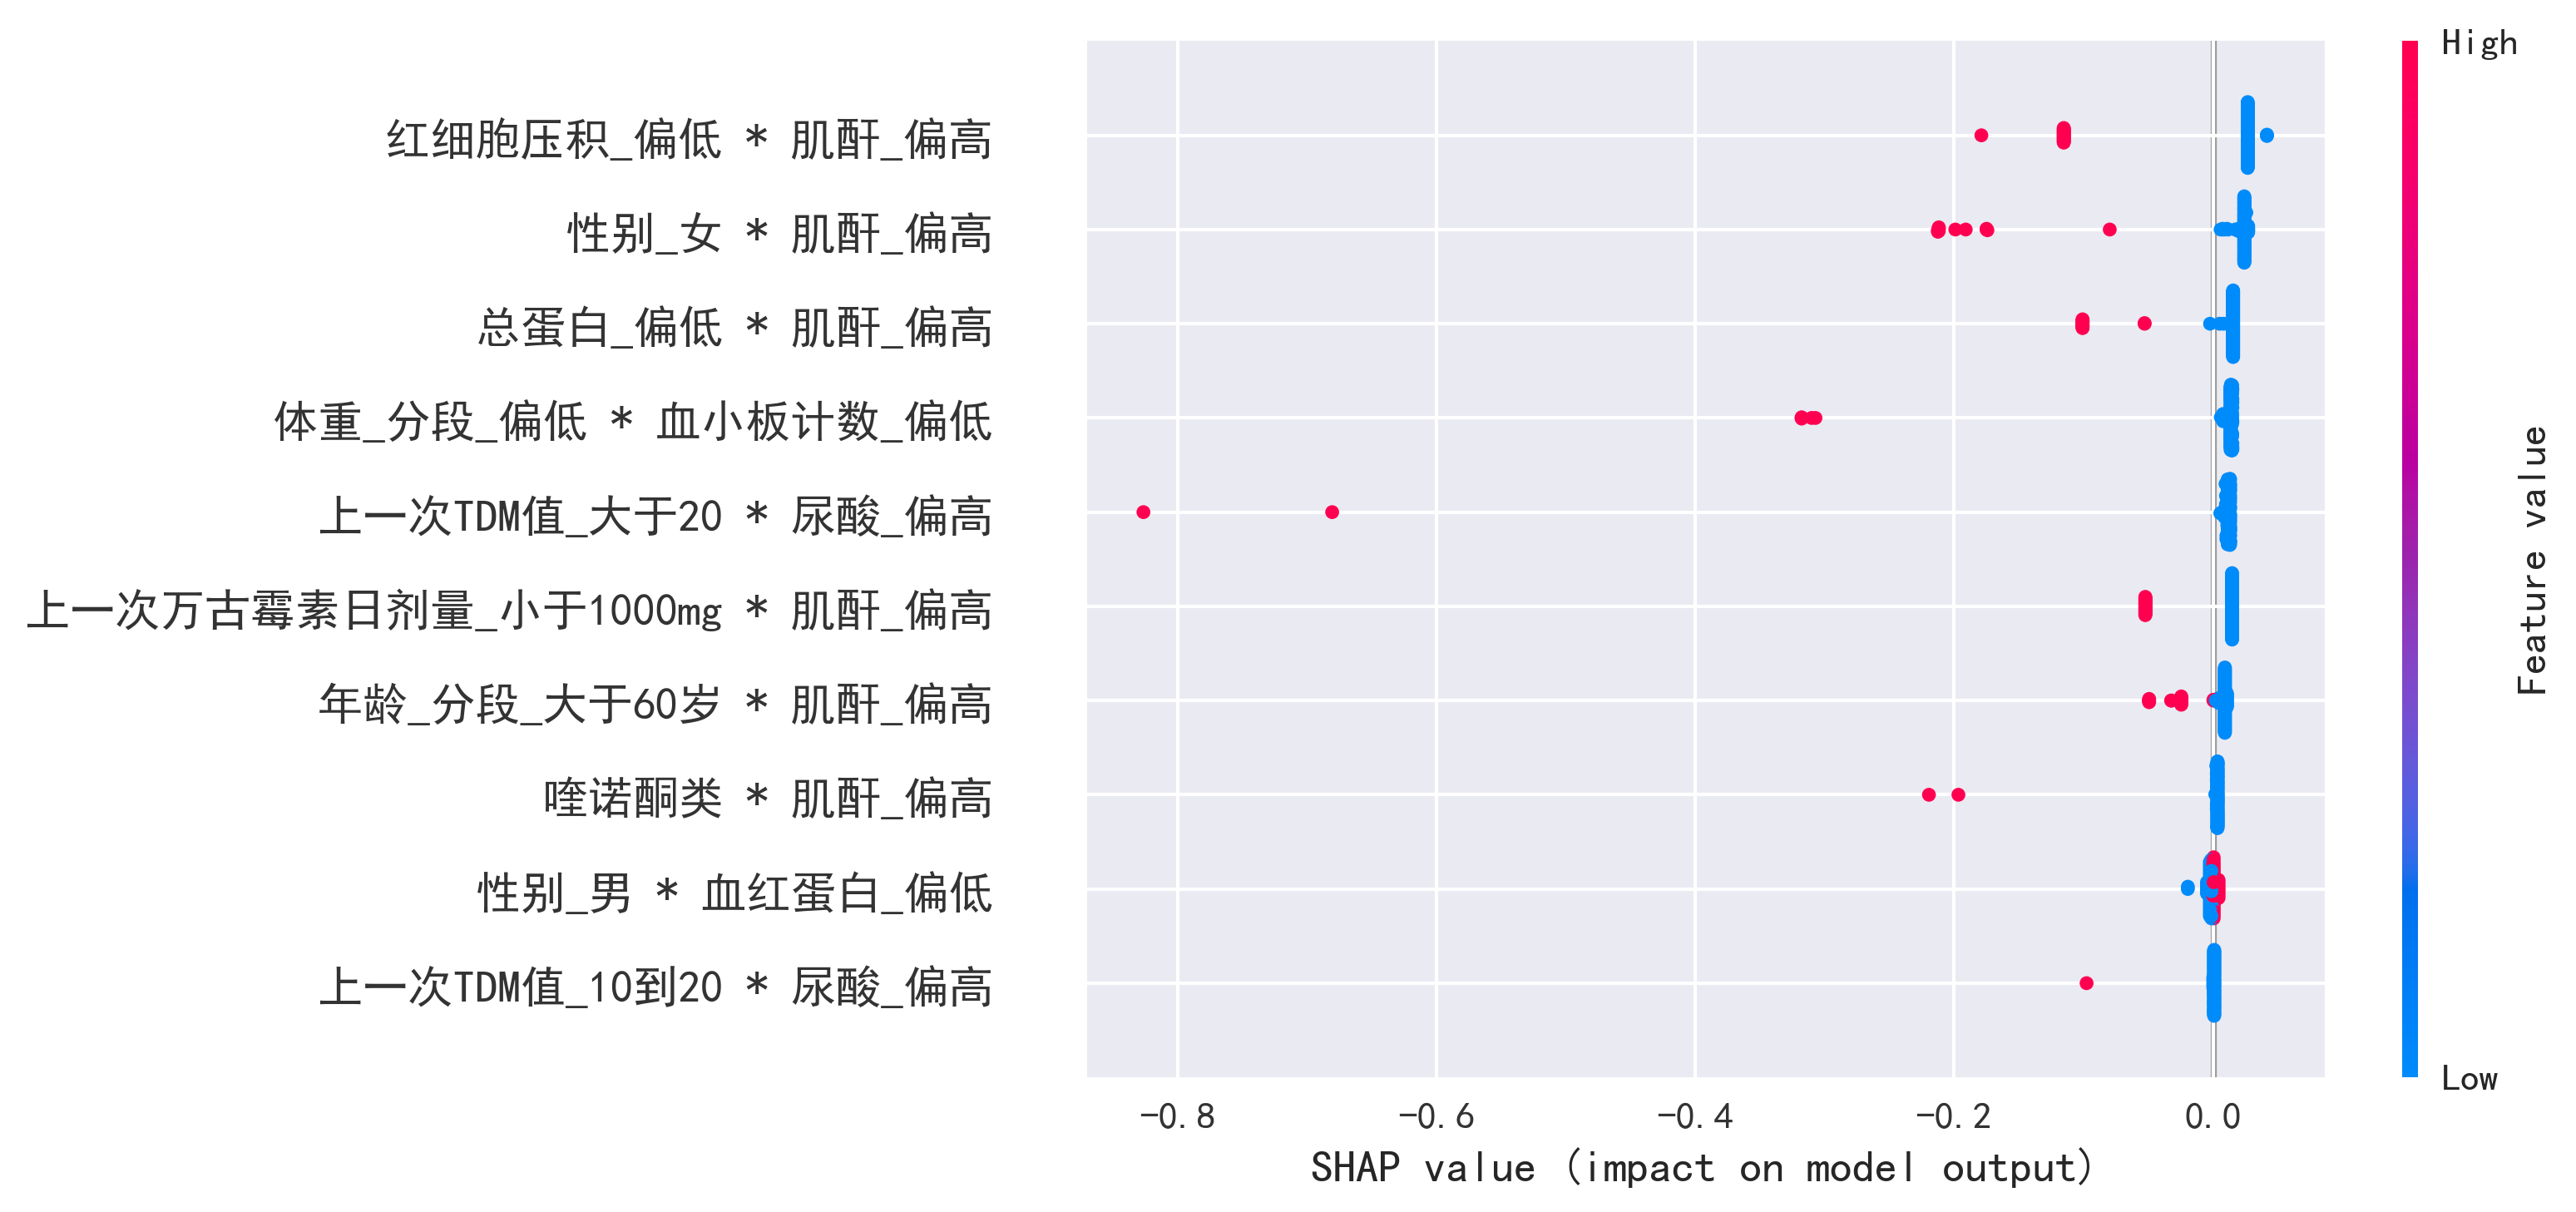

In [112]:
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
# ================================ 显示中文 ============================
shap.initjs()
shap.summary_plot(shap_values_1, tran_x_1)
## 每一行代表一个特征，横坐标为SHAP值。
#  颜色越红说明特征本身数值越大，颜色越蓝说明特征本身数值越小
#  上一次万古霉素日剂量是一个重要的特征， 与预测值基本成正相关。  年龄也是，大部分红色都分布在右边
#   肌酐、尿酸就是明显的负相关


## 单因素 + 交叉变量

In [113]:
# # stepwise 时候，分开训练集和测试集
# df_single_old = df_old_1[['patient_id','万古霉素日剂量','预期TDM值',
#                      '肌酐', '糖肽类抗菌药', '上一次TDM值', '谷丙转氨酶', '红细胞计数', 
#                      '上一次万古霉素日剂量', '直接胆红素', '体重', '血红蛋白', '年龄']]

# df_single_new = df_new_1[['patient_id','万古霉素日剂量','预期TDM值',
#                      '肌酐', '糖肽类抗菌药', '上一次TDM值', '谷丙转氨酶', '红细胞计数', 
#                      '上一次万古霉素日剂量', '直接胆红素', '体重', '血红蛋白', '年龄']]

# auto_ml
df_single_old = df_old_1[['patient_id','万古霉素日剂量','预期TDM值',
                     '肌酐','上一次万古霉素日剂量','上一次TDM值','红细胞计数','年龄', 
                     '体重','氟康唑','性别','C反应蛋白','白细胞计数']]

df_single_new = df_new_1[['patient_id','万古霉素日剂量','预期TDM值',
                     '肌酐','上一次万古霉素日剂量','上一次TDM值','红细胞计数','年龄', 
                     '体重','氟康唑','性别','C反应蛋白','白细胞计数']]


In [114]:
# df_feature_old = df_old_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
#                                  '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
#                                  '体重_分段_偏低 * 血小板计数_偏低','性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低',
#                                  '上一次TDM值_10到20 * 尿酸_偏高','糖肽类抗菌药 * 降钙素原_偏高']]

# df_feature_new = df_new_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
#                                  '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
#                                  '体重_分段_偏低 * 血小板计数_偏低','性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低',
#                                  '上一次TDM值_10到20 * 尿酸_偏高','糖肽类抗菌药 * 降钙素原_偏高']]
# auto_ml
df_feature_old = df_old_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
                                 '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
                                 '体重_分段_偏低 * 血小板计数_偏低','年龄_分段_大于60岁 * 肌酐_偏高',
                                 '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低','上一次TDM值_10到20 * 尿酸_偏高',
                                 ]]

df_feature_new = df_new_feature[['红细胞压积_偏低 * 肌酐_偏高', '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', 
                                 '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高', '上一次TDM值_大于20 * 尿酸_偏高',
                                 '体重_分段_偏低 * 血小板计数_偏低','年龄_分段_大于60岁 * 肌酐_偏高',
                                 '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低','上一次TDM值_10到20 * 尿酸_偏高',]]

In [115]:
print(df_single_old.shape)
print(df_feature_old.shape)

(117, 13)
(117, 10)


In [116]:
df_old_common = pd.concat([df_single_old,df_feature_old],axis=1)
df_new_common = pd.concat([df_single_new,df_feature_new],axis=1)

df_old_common['万古霉素日剂量'] = df_old_common['万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_common['万古霉素日剂量'] = df_new_common['万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)
df_old_common['上一次万古霉素日剂量'] = df_old_common['上一次万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)   # log取得时候， x不能取到0
df_new_common['上一次万古霉素日剂量'] = df_new_common['上一次万古霉素日剂量'].apply(lambda x: math.log(x) if x>0 else 0)

In [117]:
print(df_old_common.shape)
print(df_new_common.shape)

(117, 23)
(67, 23)


In [118]:
from sklearn.model_selection import train_test_split
x_old_common = df_old_common.iloc[:,1:]
y_old_common = df_old_common['万古霉素日剂量']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common = train_test_split(x_old_common,y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['万古霉素日剂量']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common = train_test_split(x_new_common,y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# 训练集
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# 测试集
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)
# ===========================================  Model =========================================== 
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

# Tell auto_ml which column is 'output'
# Also note columns that aren't purely numerical
# Examples include ['nlp', 'date', 'categorical', 'ignore']

column_descriptions = {
    '万古霉素日剂量': 'output' 
}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)

ml_predictor.train(tran_x_common.drop(columns=['预期TDM值']), model_names=['XGBRegressor'])
# ml_predictor.train(tran_x, model_names=['LGBMRegressor'])
# ml_predictor.train(tran_x, model_names=['CatBoostRegressor'])


test_score = ml_predictor.score(test_x_common.drop(columns=['预期TDM值']), test_x_common['万古霉素日剂量'])
file_name = ml_predictor.save()
trained_model = load_ml_model(file_name)

predictions = ml_predictor.predict(test_x_common.drop(columns=['预期TDM值']))

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 万古霉素日剂量
Started at:
2020-08-03 09:47:47
[09:47:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:l

In [119]:
# b = []
# for i in range(1000):
#     x_old_common = df_old_common.iloc[:,1:]
#     y_old_common =df_old_common['万古霉素日剂量']
#     tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common=train_test_split(x_old_common.drop(columns=['万古霉素日剂量']),y_old_common,test_size=0.3,random_state = i)
#     x_new_common = df_new_common.iloc[:,1:]
#     y_new_common = df_new_common['万古霉素日剂量']
#     tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common=train_test_split(x_new_common.drop(columns=['万古霉素日剂量']),y_new_common,test_size=0.3,random_state = i)

#     tran_x_new_common.index += 1000
#     test_x_new_common.index += 1000
#     tran_y_new_common.index += 1000
#     test_y_new_common.index += 1000
#     # 训练集
#     tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
#     tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
#     # 测试集
#     test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
#     test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)


#     #     tran_x,test_x,tran_y,test_y=train_test_split(x.drop(columns=['万古霉素日剂量']),y,test_size=0.2,random_state=i)
#     trained_model = load_ml_model(file_name)
#     params = trained_model.named_steps['final_model'].model.get_params()

#     model = xgb.XGBRegressor(**params)
#     eval_set = [(test_x_common.drop(columns=['预期TDM值']), test_y_common)]
#     clt = model.fit(tran_x_common.drop(columns=['预期TDM值']),tran_y_common,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
#     y_pred_common = clt.predict(test_x_common.drop(columns=['预期TDM值']))

#     b.append(r2_score(test_y_common,y_pred_common,multioutput='variance_weighted'))

In [120]:
# print('最大r2:',max(b))
# print('对应的最大random_state:',b.index(max(b)))

In [121]:
# c=sorted(b,reverse=1)
# c[0:20]

In [122]:
# print('最大r2:',max(b))
# print('对应的最大random_state:',b.index(max(b)))

In [123]:
# c=sorted(b,reverse=1)
# c[0:20]

In [124]:
x_old_common = df_old_common.iloc[:,1:]
y_old_common =df_old_common['万古霉素日剂量']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common=train_test_split(x_old_common.drop(columns=['万古霉素日剂量']),y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['万古霉素日剂量']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common=train_test_split(x_new_common.drop(columns=['万古霉素日剂量']),y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# 训练集
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# 测试集
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)


#     tran_x,test_x,tran_y,test_y=train_test_split(x.drop(columns=['万古霉素日剂量']),y,test_size=0.2,random_state=i)
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
eval_set = [(test_x_common.drop(columns=['预期TDM值']), test_y_common)]
clt = model.fit(tran_x_common.drop(columns=['预期TDM值']),tran_y_common,early_stopping_rounds=50,eval_set=eval_set,verbose=False)
y_pred_common = clt.predict(test_x_common.drop(columns=['预期TDM值']))

# b.append(r2_score(test_y_common,y_pred_common,multioutput='variance_weighted'))

[09:47:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:47:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [125]:
print('R2:  ',r2_score(test_y_common,y_pred_common,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_common,y_pred_common))
print('RMSE:',mean_squared_error(test_y_common,y_pred_common) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_common,y_pred_common))

R2:   0.6749075189916672
MSE:  0.09657385568308631
RMSE: 0.31076334353183666
MAE:  0.2118113748775765


### 抽取规则 ---- XGBoost

In [126]:
model.feature_importances_

array([0.04385177, 0.04113244, 0.04613598, 0.02621004, 0.03310511,
       0.03212507, 0.0544682 , 0.02601403, 0.04241303, 0.02717561,
       0.        , 0.        , 0.0911913 , 0.14223056, 0.08215012,
       0.07693239, 0.        , 0.1169074 , 0.05052958, 0.06742742],
      dtype=float32)

In [127]:
tran_x_common.drop(columns=['预期TDM值'])

肌酐  上一次万古霉素日剂量  上一次TDM值  红细胞计数  年龄     体重  氟康唑  性别  C反应蛋白  白细胞计数  \
52     44.6    7.313220     8.68   3.52  66   70.0  0.0   1   98.0  13.30   
63     54.0    7.600902     9.09   3.71  69   67.5  0.0   0   58.0   8.50   
61     56.3    0.000000     0.00   3.36  31   60.0  0.0   1   60.0  16.40   
60     36.0    0.000000     0.00   2.73  65  174.0  0.0   0   39.0   8.90   
101   106.0    0.000000     0.00   3.47  79   70.0  0.0   0  114.0   7.70   
...     ...         ...      ...    ...  ..    ...  ...  ..    ...    ...   
1056   47.8    0.000000     0.00   4.04  77   55.0  0.0   1   19.0   6.70   
1009  271.0    0.000000     0.00   2.98  70   76.0  0.0   0  160.0  12.05   
1044   77.3    6.907755    16.49   2.75  42   80.0  0.0   0   27.0   2.87   
1054   75.0    0.000000     0.00   3.31  91   65.0  0.0   0   24.0   4.40   
1065   54.0    7.600902    12.03   3.31  59   65.0  0.0   0   55.0   6.00   

      红细胞压积_偏低 * 肌酐_偏高  上一次万古霉素日剂量_小于1000mg * 肌酐_偏高  总蛋白_偏低 * 肌酐_偏高  \
52                   0                            0               0   
63                   0                            0               0   
61                   0                            0               0   
60                   0                            0               0   
101                  0                            0               0   
...                ...                          ...             ...   
1056                 0                            0               0   
1009                 1                            1               0   
1044                 0                            0               0   
1054                 0                            0               0   
1065                 0                            0               0   

      喹诺酮类 * 肌酐_偏高  上一次TDM值_大于20 * 尿酸_偏高  体重_分段_偏低 * 血小板计数_偏低  \
52             0.0                     0                    0   
63             0.0                     0                    0   
61             0.0                     0                    0   
60             0.0                     0                    0   
101            0.0                     0                    0   
...            ...                   ...                  ...   
1056           0.0                     0                    0   
1009           0.0                     0                    0   
1044           0.0                     0                    0   
1054           0.0                     0                    0   
1065           0.0                     0                    0   

      年龄_分段_大于60岁 * 肌酐_偏高  性别_女 * 肌酐_偏高  性别_男 * 血红蛋白_偏低  上一次TDM值_10到20 * 尿酸_偏高  
52                      0             0               0                      0  
63                      0             0               1                      0  
61                      0             0               0                      0  
60                      0             0               1                      0  
101                     0             0               1                      0  
...                   ...           ...             ...                    ...  
1056                    0             0               0                      0  
1009                    1             0               1                      0  
1044                    0             0               1                      0  
1054                    0             0               1                      0  
1065                    0             0               1                      0  

[127 rows x 20 columns]

In [128]:
values=pd.DataFrame(model.feature_importances_)#变量置信度
names=pd.DataFrame(tran_x_common.drop(columns=['预期TDM值']).columns)#变量名
feat_importance=pd.concat([names,values],axis=1)
feat_importance.columns=['feat','importance']
feat_importance=feat_importance.sort_values(['importance'],ascending=0)#根据置信度排序，降序

In [129]:
# feat_importance

In [130]:
feat_importance

feat  importance
13                 喹诺酮类 * 肌酐_偏高    0.142231
17                 性别_女 * 肌酐_偏高    0.116907
12               总蛋白_偏低 * 肌酐_偏高    0.091191
14         上一次TDM值_大于20 * 尿酸_偏高    0.082150
15          体重_分段_偏低 * 血小板计数_偏低    0.076932
19        上一次TDM值_10到20 * 尿酸_偏高    0.067427
6                           氟康唑    0.054468
18               性别_男 * 血红蛋白_偏低    0.050530
2                       上一次TDM值    0.046136
0                            肌酐    0.043852
8                         C反应蛋白    0.042413
1                    上一次万古霉素日剂量    0.041132
4                            年龄    0.033105
5                            体重    0.032125
9                         白细胞计数    0.027176
3                         红细胞计数    0.026210
7                            性别    0.026014
11  上一次万古霉素日剂量_小于1000mg * 肌酐_偏高    0.000000
16          年龄_分段_大于60岁 * 肌酐_偏高    0.000000
10             红细胞压积_偏低 * 肌酐_偏高    0.000000

In [131]:
#删除得分为0的变量
feat_set = feat_importance[feat_importance['importance']!=0]['feat']#保存变量得分不为0的变量名
# ====================================================================
x_common = pd.concat([x_old_common,x_new_common],axis=0)
# ====================================================================
x = x_common[feat_set]
#y = xuqiu2_1['诱导预后_ED']
x.shape#变量得分不为0的变量个数

(184, 17)

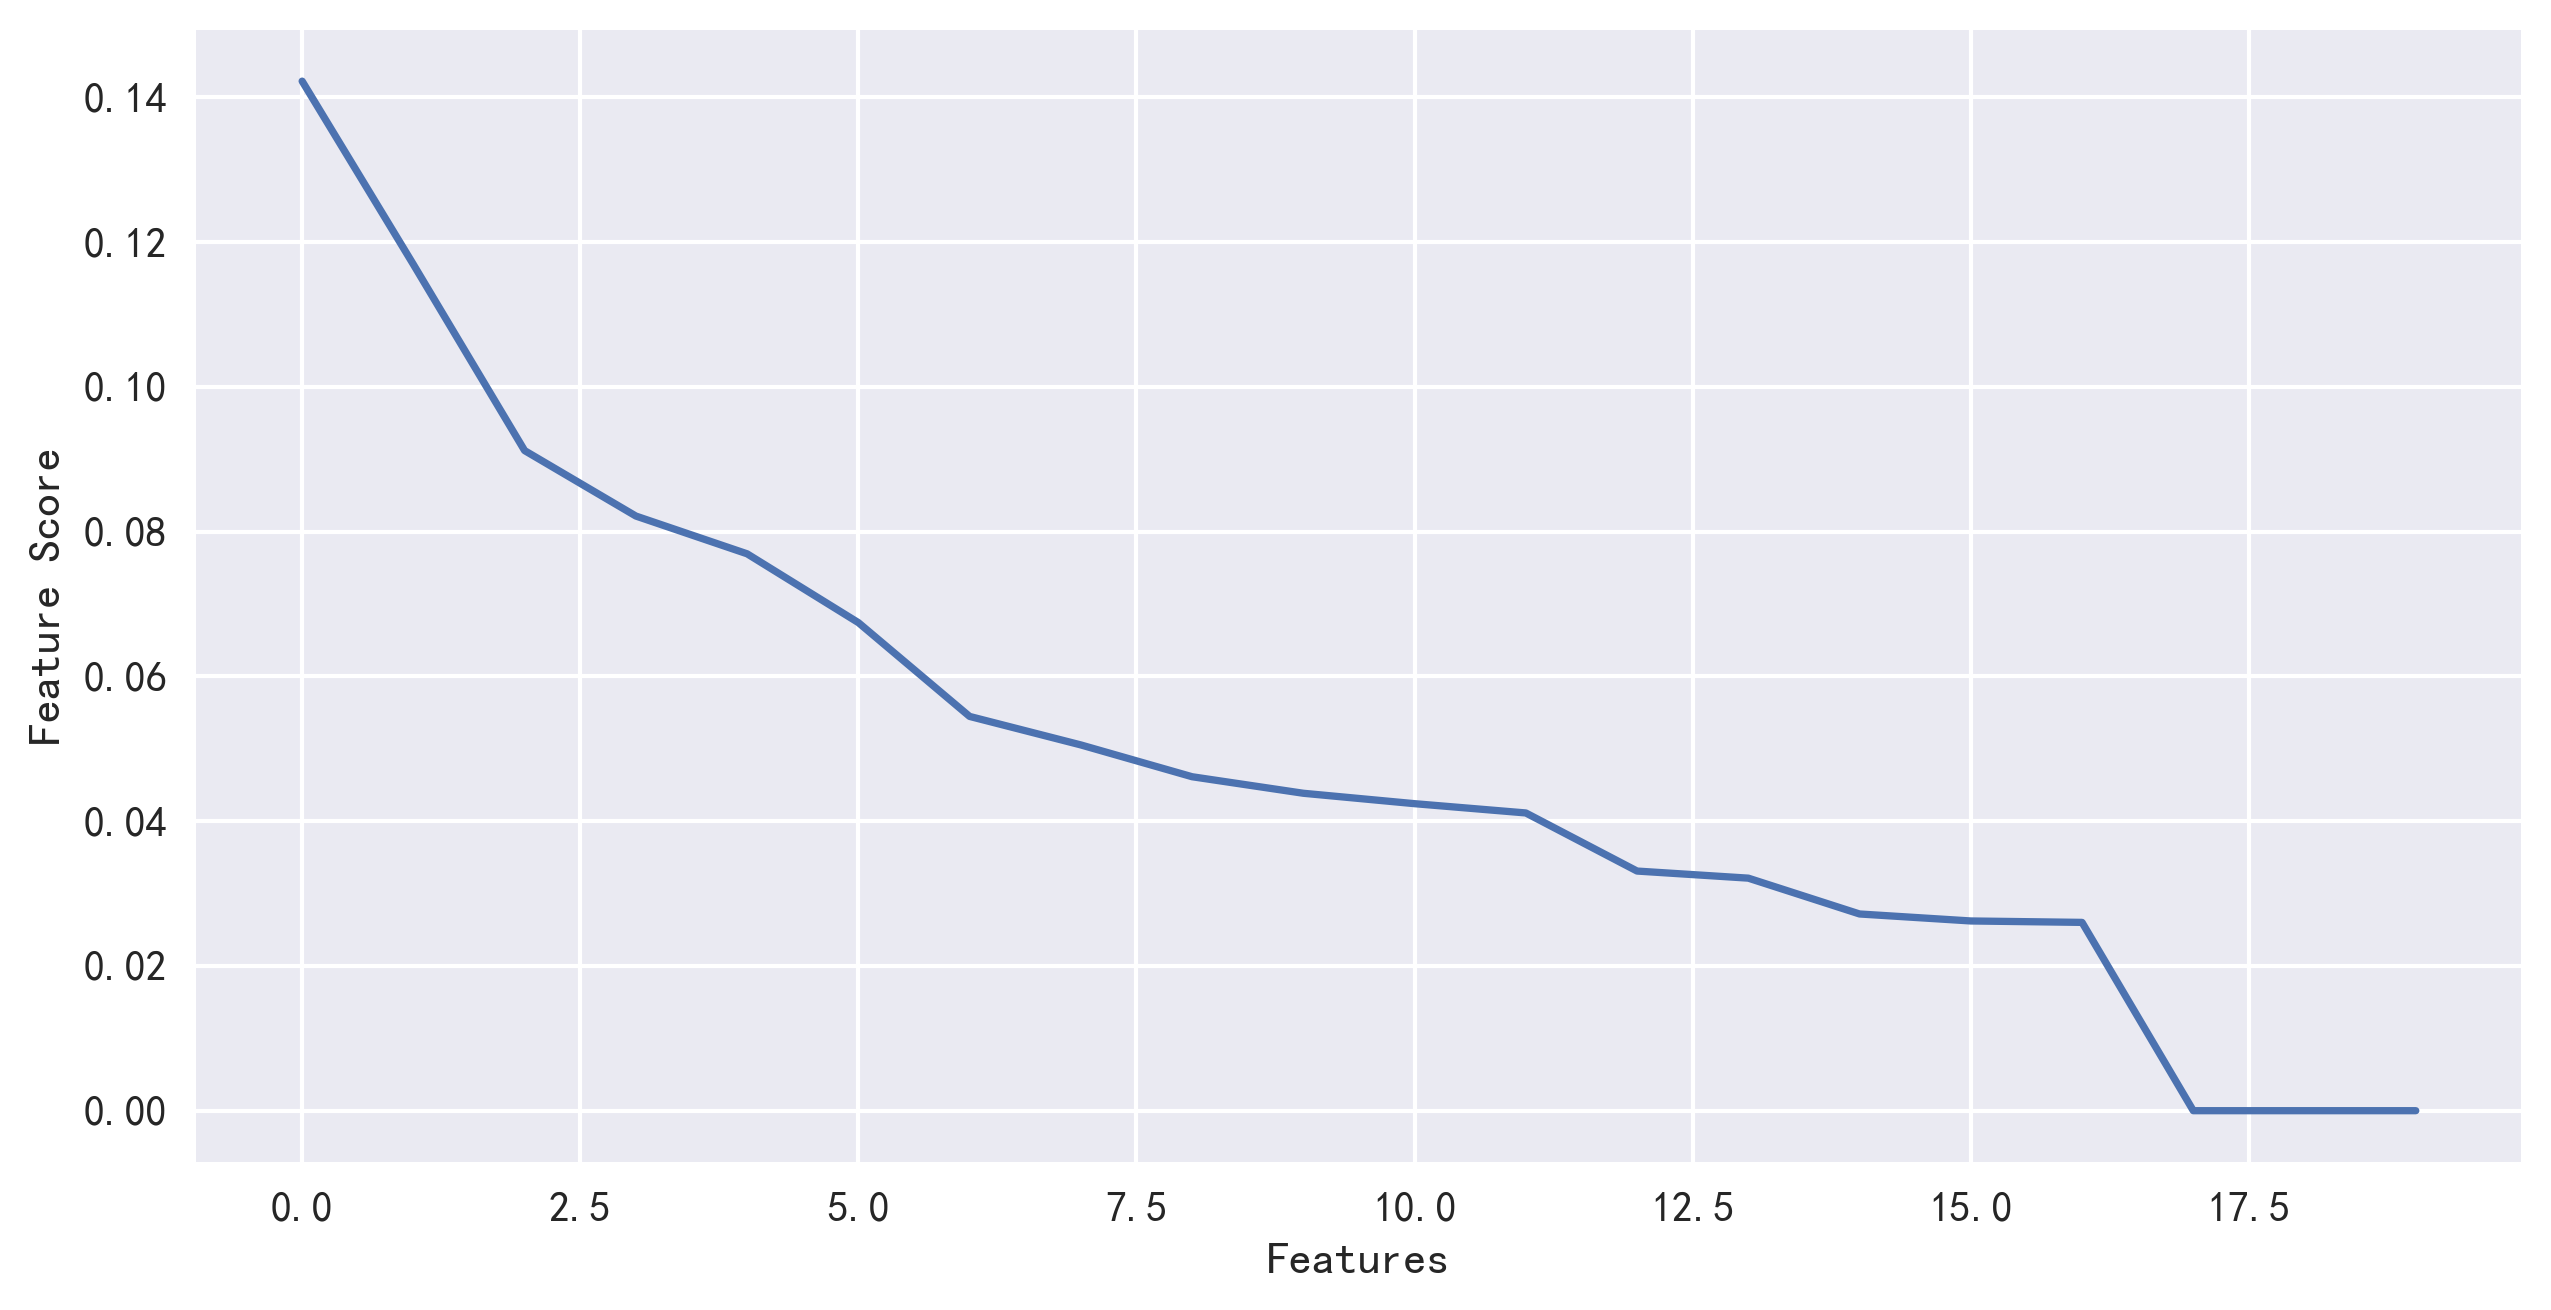

In [132]:
#变量重要性折线图，横坐标为重要变量（共143个），纵坐标为重要变量得分
plt.figure(figsize=(10,5))
plt.plot(range(feat_importance.shape[0]),feat_importance['importance'])
plt.xlabel('Features')
plt.ylabel('Feature Score')
#plt.title('Gene Clusters')
plt.show()

In [133]:
#截取重要变量得分前20的变量及得分情况
feat_importance=feat_importance.reset_index()
del feat_importance['index']
feat_importance.iloc[:20,:]

feat  importance
0                  喹诺酮类 * 肌酐_偏高    0.142231
1                  性别_女 * 肌酐_偏高    0.116907
2                总蛋白_偏低 * 肌酐_偏高    0.091191
3          上一次TDM值_大于20 * 尿酸_偏高    0.082150
4           体重_分段_偏低 * 血小板计数_偏低    0.076932
5         上一次TDM值_10到20 * 尿酸_偏高    0.067427
6                           氟康唑    0.054468
7                性别_男 * 血红蛋白_偏低    0.050530
8                       上一次TDM值    0.046136
9                            肌酐    0.043852
10                        C反应蛋白    0.042413
11                   上一次万古霉素日剂量    0.041132
12                           年龄    0.033105
13                           体重    0.032125
14                        白细胞计数    0.027176
15                        红细胞计数    0.026210
16                           性别    0.026014
17  上一次万古霉素日剂量_小于1000mg * 肌酐_偏高    0.000000
18          年龄_分段_大于60岁 * 肌酐_偏高    0.000000
19             红细胞压积_偏低 * 肌酐_偏高    0.000000

In [134]:
#抽取规则
rules=[]
#获取树的路径（规则）
for i in range(len(model.get_booster().get_dump())):
    rules.append(np.array(model.get_booster().get_dump()[i].split()))

In [135]:
temp =[]
index1= []
index2=[]
for i in range(len(rules)):#循环规则数
    for j in range(len(rules[i])):#每条规则的长度
           if 'leaf' in str(rules[i][j]):
                temp.append(rules[i][j])#保留叶子节点得分
                index1.append(i)#第几条规则
                index2.append(j)#该规则中的哪个位置

In [136]:
temp2=pd.DataFrame()
temp2['index1']=index1
temp2['index2']=index2
temp2['score']=np.zeros#生成相应大小的0矩阵

for i in range(len(temp)):
    temp2.iloc[i,2]=temp[i].split('leaf=')[1]#将规则在‘leaf=’处分割，后面的数为得分，赋给变量score
temp2['score']=temp2['score'].astype(np.float64)#将得分转换为float类型
top20=temp2.sort_values(['score'],ascending=0)[:20]#将得分排序，获取前20
top20

index1  index2     score
0        0       0  0.684346
1        1       0  0.616446
2        2       0  0.555283
3        3       0  0.500189
4        4       0  0.450560
5        5       2  0.407308
7        6       2  0.366898
9        7       2  0.331427
11       8       4  0.302672
13       9       2  0.277006
15      10       8  0.249080
18      11       8  0.224458
14       9       3  0.212645
12       8       5  0.207941
22      12       6  0.202423
17      10      10  0.181826
26      13      10  0.179497
30      14       8  0.165612
19      11       9  0.151808
34      15      10  0.150363

In [137]:
j=1
for i in top20['index1']:
    print(str(j) + '：','\n',rules[i],'\n','\n')#\n为换行，打出得分前20的每一条规则
    j=j+1

1： 
 ['0:leaf=0.68434602'] 
 

2： 
 ['0:leaf=0.616446018'] 
 

3： 
 ['0:leaf=0.55528307'] 
 

4： 
 ['0:leaf=0.500188529'] 
 

5： 
 ['0:leaf=0.45056048'] 
 

6： 
 ['0:[肌酐<404.149994]' 'yes=1,no=2,missing=1' '1:leaf=0.40730834'
 '2:leaf=0.11073184'] 
 

7： 
 ['0:[肌酐<404.149994]' 'yes=1,no=2,missing=1' '1:leaf=0.366898209'
 '2:leaf=0.105195247'] 
 

8： 
 ['0:[肌酐<320.75]' 'yes=1,no=2,missing=1' '1:leaf=0.331426948'
 '2:leaf=0.137742907'] 
 

9： 
 ['0:[性别_女' '*' '肌酐_偏高<1]' 'yes=1,no=2,missing=1' '1:leaf=0.30267188'
 '2:leaf=0.207941204'] 
 

10： 
 ['0:[肌酐<108.5]' 'yes=1,no=2,missing=1' '1:leaf=0.277005702'
 '2:leaf=0.212644845'] 
 

11： 
 ['0:[总蛋白_偏低' '*' '肌酐_偏高<1]' 'yes=1,no=2,missing=1' '1:[上一次TDM值_大于20' '*'
 '尿酸_偏高<1]' 'yes=3,no=4,missing=3' '3:leaf=0.249079823'
 '4:leaf=0.069078207' '2:leaf=0.181825817'] 
 

12： 
 ['0:[肌酐<320.75]' 'yes=1,no=2,missing=1' '1:[上一次TDM值<43.7450027]'
 'yes=3,no=4,missing=3' '3:[性别_女' '*' '肌酐_偏高<1]' 'yes=5,no=6,missing=5'
 '5:leaf=0.224458292' '6:leaf=0.151808

In [138]:
# xgb.to_graphviz(model,num_trees=73)#决策树可视化，num_trees为输出第几课树的树状图64，66，67.69

## 将初次用药和调整用药分开预测
###  初次用药

In [151]:
x_old_common = df_old_common.iloc[:,1:]
y_old_common =df_old_common['万古霉素日剂量']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common=train_test_split(x_old_common.drop(columns=['万古霉素日剂量']),y_old_common,test_size=0.3,random_state = 327)
# 将初次用药分开
old_0_list = list(test_x_old_common[test_x_old_common['上一次万古霉素日剂量']==0].index)
old_1_list = list(test_x_old_common[test_x_old_common['上一次万古霉素日剂量']!=0].index)
test_x_old_common_0 = test_x_old_common[test_x_old_common['上一次万古霉素日剂量']==0]
test_x_old_common_1 = test_x_old_common[test_x_old_common['上一次万古霉素日剂量']!=0]
test_y_old_common_0 = test_y_old_common[old_0_list]
test_y_old_common_1 = test_y_old_common[old_1_list]



x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['万古霉素日剂量']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common=train_test_split(x_new_common.drop(columns=['万古霉素日剂量']),y_new_common,test_size=0.3,random_state = 327)
# 将调整用药分开
new_0_list = list(test_x_new_common[test_x_new_common['上一次万古霉素日剂量']==0].index)
new_1_list = list(test_x_new_common[test_x_new_common['上一次万古霉素日剂量']!=0].index)
test_x_new_common_0 = test_x_new_common[test_x_new_common['上一次万古霉素日剂量']==0]
test_x_new_common_1 = test_x_new_common[test_x_new_common['上一次万古霉素日剂量']!=0]
test_y_new_common_0 = test_y_new_common[new_0_list]
test_y_new_common_1 = test_y_new_common[new_1_list]

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# 训练集
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# 测试集
test_x_common_0 = pd.concat([test_x_old_common_0,test_x_new_common_0],axis=0)
test_y_common_0 = pd.concat([test_y_old_common_0,test_y_new_common_0],axis=0)
# ================================ 调整用药 ==================================
test_x_common_1 = pd.concat([test_x_old_common_1,test_x_new_common_1],axis=0)
test_y_common_1 = pd.concat([test_y_old_common_1,test_y_new_common_1],axis=0)


#     tran_x,test_x,tran_y,test_y=train_test_split(x.drop(columns=['万古霉素日剂量']),y,test_size=0.2,random_state=i)
trained_model = load_ml_model(file_name)
params = trained_model.named_steps['final_model'].model.get_params()

model = xgb.XGBRegressor(**params)
# ============ 分开初次和调整 ===============
eval_set_0 = [(test_x_common_0.drop(columns=['预期TDM值']), test_y_common_0)]
eval_set_1 = [(test_x_common_1.drop(columns=['预期TDM值']), test_y_common_1)]
clt = model.fit(tran_x_common.drop(columns=['预期TDM值']),tran_y_common,early_stopping_rounds=50,eval_set=eval_set,verbose=False)

y_pred_common_0 = clt.predict(test_x_common_0.drop(columns=['预期TDM值']))
y_pred_common_1 = clt.predict(test_x_common_1.drop(columns=['预期TDM值']))

[09:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:48:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [152]:
print(test_x_common.shape[0],test_y_common.shape[0])
print(test_y_common_0.shape[0],y_pred_common_0.shape[0])
print(test_y_common_1.shape[0],y_pred_common_1.shape[0])

57 57
33 33
24 24


In [153]:
print('============ 初次用药 ============')
print('R2:  ',r2_score(test_y_common_0,y_pred_common_0,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_common_0,y_pred_common_0))
print('RMSE:',mean_squared_error(test_y_common_0,y_pred_common_0) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_common_0,y_pred_common_0))

print('============ 调整用药 ============')
print('R2:  ',r2_score(test_y_common_1,y_pred_common_1,multioutput='variance_weighted'))
print('MSE: ',mean_squared_error(test_y_common_1,y_pred_common_1))
print('RMSE:',mean_squared_error(test_y_common_1,y_pred_common_1) ** 0.5)
print('MAE: ',mean_absolute_error(test_y_common_1,y_pred_common_1))


============ 初次用药 ============
R2:   0.4470557847807067
MSE:  0.08027638237658061
RMSE: 0.2833308708499316
MAE:  0.21367686474797187
============ 调整用药 ============
R2:   0.7586728853029334
MSE:  0.11898288147953166
RMSE: 0.3449389532649678
MAE:  0.20924632630578285


In [154]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 100,
 'nthread': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1}

In [143]:
# #创建数据
# rs = np.random.RandomState(2)
# df = pd.DataFrame(rs.randn(200,2), columns = ['A','B'])
 
# sns.jointplot(x=df['A'], y=df['B'], #设置xy轴，显示columns名称
#               data = df,  #设置数据
#               color = 'b', #设置颜色
#               s = 50, edgecolor = 'w', linewidth = 1,#设置散点大小、边缘颜色及宽度(只针对scatter)
#               stat_func=sci.pearsonr,
#               kind = 'scatter',#设置类型：'scatter','reg','resid','kde','hex'
#               #stat_func=<function pearsonr>,
#               space = 0.1, #设置散点图和布局图的间距
#               size = 8, #图表大小(自动调整为正方形))
#               ratio = 5, #散点图与布局图高度比，整型
#               marginal_kws = dict(bins=15, rug =True), #设置柱状图箱数，是否设置rug
#               )
# ————————————————
# 版权声明：本文为CSDN博主「一行数据」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/qq_42554007/article/details/82625118

In [144]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy import stats
  
# tips = sns.load_dataset("tips")
  
# def pearson(x,y):
#    return stats.pearsonr(x,y)
  
# g =  sns.jointplot("total_bill","tip",tips,kind='reg')
# g.annotate(pearson,template='r: {val:.2f}\np: {p:.3f}')

In [155]:
test_x_common.columns

Index(['预期TDM值', '肌酐', '上一次万古霉素日剂量', '上一次TDM值', '红细胞计数', '年龄', '体重', '氟康唑',
       '性别', 'C反应蛋白', '白细胞计数', '红细胞压积_偏低 * 肌酐_偏高',
       '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高',
       '上一次TDM值_大于20 * 尿酸_偏高', '体重_分段_偏低 * 血小板计数_偏低', '年龄_分段_大于60岁 * 肌酐_偏高',
       '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低', '上一次TDM值_10到20 * 尿酸_偏高'],
      dtype='object')

In [146]:
# test_y_common = round((math.e) ** test_y_common,0)
# y_pred_common = round((math.e) ** y_pred_common,0)

In [156]:
y_pred_common

array([7.566358 , 6.9210553, 7.4953494, 6.8985043, 7.372473 , 7.4480405,
       7.5223823, 7.1214204, 6.8042026, 7.4407077, 7.490984 , 7.4088035,
       7.426331 , 7.4874415, 6.958533 , 6.3090916, 7.510696 , 7.6262317,
       7.445604 , 7.612654 , 7.33762  , 7.407034 , 6.866973 , 7.5672545,
       7.4600463, 6.8857937, 6.5196376, 7.124866 , 6.90908  , 7.304229 ,
       7.334319 , 7.6952205, 7.4636784, 7.6138024, 7.4242945, 7.1785374,
       7.5099516, 5.5468664, 7.481185 , 7.410717 , 7.4871707, 7.6210723,
       7.447042 , 7.5795493, 7.5192504, 7.210695 , 7.4218383, 6.501437 ,
       7.5538645, 6.7478256, 7.8205   , 7.811802 , 7.339639 , 7.2514467,
       7.361268 , 6.7377915, 7.255489 ], dtype=float32)

In [157]:
import scipy.stats as sci
# 'scatter', 'reg', 'resid', 'kde', or 'hex'
# g = sns.jointplot(y_pred_common, test_y_common, kind="reg", size=7, space=0,
#                  marginal_kws = dict(bins=15, rug = False),
# #                  color='i'
#                  )
plt.figure(figsize=(8,8),dpi=600)
g = sns.jointplot(test_x_common['万古霉素日剂量'], test_x_common['万古霉素日剂量预测值'],kind="reg", size=7, space=0.1,
                 marginal_kws = dict(bins=15, rug = False),
#                  color='i'
                 )

g.annotate(r2_score,template="{stat}=0.67",
#           stat="$R^2$",loc="upper right",fontsize=12)
          stat="$R^2$",loc="lower right",fontsize=12)
# plt.title('Test Data')
# plt.xlabel('Predicted dose(mg/d)')
# plt.ylabel('Actual dose(mg/d)')   
font = {'size':15}

plt.xlabel('Actual dose(mg/d)',font)
plt.ylabel('Predicted dose(mg/d)',font)   

# 保存
foo_fig = plt.gcf() # 'get current figure'
# foo_fig.savefig('san_3.png',dpi=600,bbox_inches = 'tight')
# foo_fig.savefig('san_3.tif',dpi=600,bbox_inches = 'tight')
# 显示
plt.show()

KeyError: '万古霉素日剂量'

<Figure size 4800x4800 with 0 Axes>

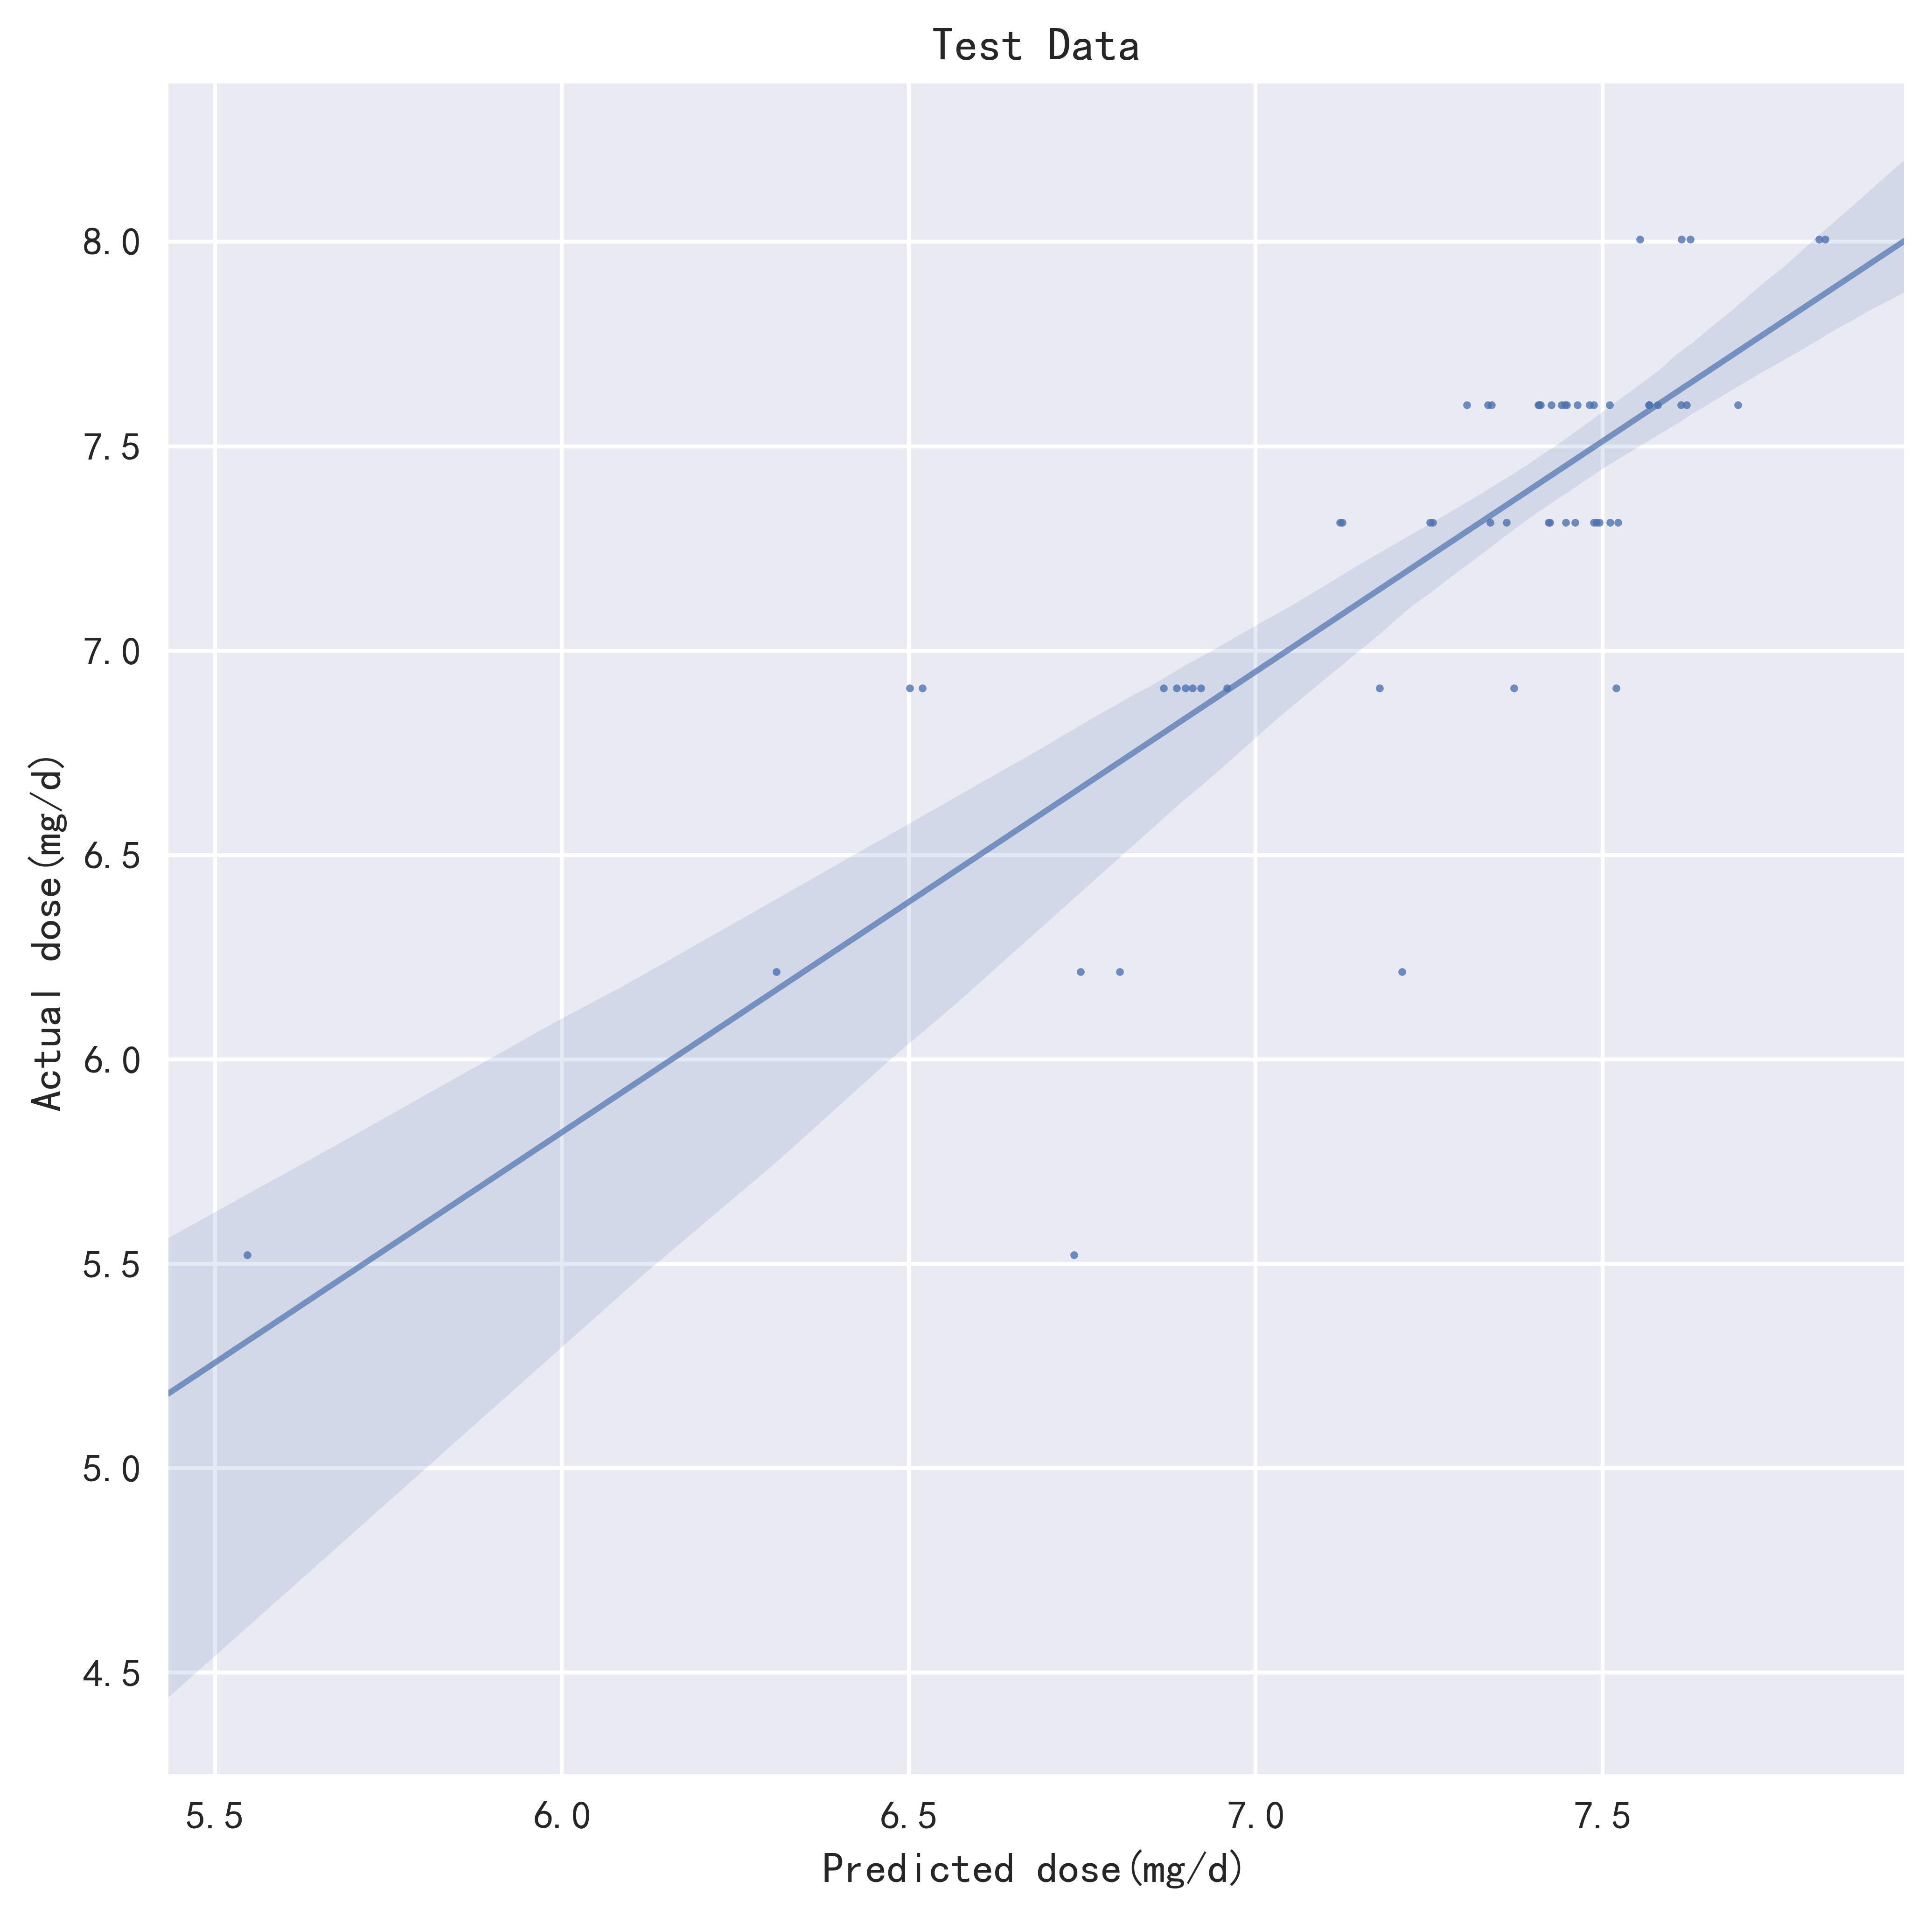

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# 准备数据：自带数据集
# tips = sns.load_dataset("test_x_1")
# print(tips.head())
# plt.figure(figsize=(12,6),dpi=600)
plt.figure(figsize=(8,8),dpi=600)

# # 绘画散点图
# sns.regplot(x=test_x_1['日剂量预测值'], y=test_x_1['日剂量'],scatter_kws={"s":4},line_kws={"alpha":0.7,"lw":1.5});
sns.regplot(x=y_pred_common, y=test_y_common,scatter_kws={"s":4},line_kws={"alpha":0.7,"lw":1.5});
# sns.jointplot(test_x_1['日剂量预测值'], test_x_1['日剂量'], kind='reg', size=8)  #方法2
# sns.lmplot('日剂量预测值','日剂量',data=test_x_1 ,size=8)  #方法3


plt.title('Test Data')
plt.xlabel('Predicted dose(mg/d)')
plt.ylabel('Actual dose(mg/d)')             # 设置坐标轴标签
# plt.text(1.2, 9.2, '$\mathregular{R^2}$=0.862', fontsize=8)
# plt.text(1.19, 9.0, 'r =0.847', fontsize=8)
# plt.text(1.1, 9.42, 'MAE=0.392',fontsize=8)

# 保存
foo_fig = plt.gcf() # 'get current figure'
# foo_fig.savefig('san_3.tif',dpi=600)
# 显示
plt.show()


## 亚组分析

In [158]:
x_old_common = df_old_common.iloc[:,1:]
y_old_common = df_old_common['万古霉素日剂量']
tran_x_old_common,test_x_old_common,tran_y_old_common,test_y_old_common = train_test_split(x_old_common,y_old_common,test_size=0.3,random_state = 327)
x_new_common = df_new_common.iloc[:,1:]
y_new_common = df_new_common['万古霉素日剂量']
tran_x_new_common,test_x_new_common,tran_y_new_common,test_y_new_common = train_test_split(x_new_common,y_new_common,test_size=0.3,random_state = 327)

tran_x_new_common.index += 1000
test_x_new_common.index += 1000
tran_y_new_common.index += 1000
test_y_new_common.index += 1000
# 训练集
tran_x_common = pd.concat([tran_x_old_common,tran_x_new_common],axis=0)
tran_y_common = pd.concat([tran_y_old_common,tran_y_new_common],axis=0)
# 测试集
test_x_common = pd.concat([test_x_old_common,test_x_new_common],axis=0)
test_y_common = pd.concat([test_y_old_common,test_y_new_common],axis=0)

In [159]:
# 亚组分析的指标
test_x_common['万古霉素日剂量预测值'] = y_pred_common
test_x_common['性别_系数'] = test_x_common['性别'].apply(lambda x: 1 if x==1 else 0.85)
# test_x_common['血肝清除率'] = ((140-test_x_common['年龄']) * test_x_common['体重'] * test_x_common['性别_系数']) / (0.81 * test_x_common['肌酐'])
# test_x_common['血肝清除率'] = ((140-test_x_common['年龄']) * test_x_common['体重'] * test_x_common['性别_系数']) / (0.818 * test_x_common['肌酐'])

In [160]:
test_x_common[['万古霉素日剂量','万古霉素日剂量预测值']]

万古霉素日剂量  万古霉素日剂量预测值
36    7.600902    7.566358
70    6.907755    6.921055
32    7.313220    7.495349
94    6.907755    6.898504
18    6.907755    7.372473
21    7.600902    7.448040
28    7.313220    7.522382
93    7.313220    7.121420
107   6.214608    6.804203
77    7.600902    7.440708
91    7.313220    7.490984
50    7.600902    7.408803
33    7.600902    7.426331
89    7.600902    7.487442
59    6.907755    6.958533
80    6.214608    6.309092
62    7.313220    7.510696
116   8.006368    7.626232
26    7.600902    7.445604
13    7.600902    7.612654
16    7.313220    7.337620
9     7.600902    7.407034
74    6.907755    6.866973
76    7.600902    7.567255
1     7.313220    7.460046
72    6.907755    6.885794
2     6.907755    6.519638
30    7.313220    7.124866
106   6.907755    6.909080
6     7.600902    7.304229
85    7.600902    7.334319
92    7.600902    7.695220
45    7.600902    7.463678
69    8.006368    7.613802
110   7.313220    7.424294
103   6.907755    7.178537
1029  7.600902    7.509952
1036  5.521461    5.546866
1064  7.600902    7.481185
1013  7.600902    7.410717
1035  7.313220    7.487171
1066  7.600902    7.621072
1012  7.313220    7.447042
1047  7.600902    7.579549
1042  6.907755    7.519250
1030  6.214608    7.210695
1045  7.313220    7.421838
1051  6.907755    6.501437
1062  8.006368    7.553864
1010  6.214608    6.747826
1018  8.006368    7.820500
1055  8.006368    7.811802
1028  7.600902    7.339639
1021  7.313220    7.251447
1020  7.313220    7.361268
1040  5.521461    6.737792
1052  7.313220    7.255489

In [161]:
test_x_common.columns

Index(['万古霉素日剂量', '预期TDM值', '肌酐', '上一次万古霉素日剂量', '上一次TDM值', '红细胞计数', '年龄', '体重',
       '氟康唑', '性别', 'C反应蛋白', '白细胞计数', '红细胞压积_偏低 * 肌酐_偏高',
       '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高',
       '上一次TDM值_大于20 * 尿酸_偏高', '体重_分段_偏低 * 血小板计数_偏低', '年龄_分段_大于60岁 * 肌酐_偏高',
       '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低', '上一次TDM值_10到20 * 尿酸_偏高', '万古霉素日剂量预测值',
       '性别_系数'],
      dtype='object')

In [163]:
# 体重分组
def dp_weight(x,y):
    if x<=60 and y==0:
        z='偏低'
    elif x>=70 and y==0:
        z='偏高'
    elif x<=50 and y==1:
        z='偏低'
    elif x>=60 and y==1:
        z='偏高'
    else:
        z='中等'
    return z
# 肌酐分组
def jigan(x,y):
    if x<=58 and y==0:
        z='偏低'
    elif x>=110 and y==0:
        z='偏高'
    elif x<=46 and y==1:
        z='偏低'
    elif x>=92 and y==1:
        z='偏高'
    else:
        z='中等'
    return z
    
    
for i in test_x_common.index:
    test_x_common.loc[i,'体重_分段']=dp_weight(test_x_common.loc[i,'体重'],test_x_common.loc[i,'性别'])
    test_x_common.loc[i,'肌酐_分段']=jigan(test_x_common.loc[i,'肌酐'],test_x_common.loc[i,'性别'])
#  各种分组
test_x_common['TDM_分组']=test_x_common['预期TDM值'].apply(lambda x: 0 if x<10 else 1 if 10<=x<15 else 2 if 15<=x<20 else 3 if 10<=x<20 else 4 if 20<=x else x)
# test_x_common['血肝清除率_分组'] = test_x_common['血肝清除率'].apply(lambda x: 0 if 40<=x<50 else 1 if 50<=x<60 else 2 if 60<=x<70 else 3 if 70<=x<80 else 4 if 80<=x<90 else 5 if 90<=x<100 else 6 if x>=100 else x )
# test_x_common['血肝清除率_分组'] = test_x_common['血肝清除率'].apply(lambda x: 0 if 40<=x<60 else 1 if 60<=x<80 else 2 if 80<=x<100 else 3 if x>=100 else x )

In [164]:
test_x_common['肌酐'].describe()

count     57.000000
mean      88.770175
std       80.073926
min       28.000000
25%       50.000000
50%       69.000000
75%      102.200000
max      609.000000
Name: 肌酐, dtype: float64

In [165]:
import math
test_x_common['万古霉素日剂量'] = round((math.e) ** test_x_common['万古霉素日剂量'],0)
test_x_common['万古霉素日剂量预测值'] = round((math.e) ** test_x_common['万古霉素日剂量预测值'],0)
# test_x_common['万古霉素日剂量stepwise预测值'] = round((math.e) ** test_x_common['万古霉素日剂量stepwise预测值'],0)

In [166]:
test_x_common['预测准确率'] = (test_x_common['万古霉素日剂量预测值']-test_x_common['万古霉素日剂量'])/test_x_common['万古霉素日剂量']
# test_x_common['预测准确率']=(test_x_common['万古霉素日剂量stepwise预测值']-test_x_common['万古霉素日剂量'])/test_x_common['万古霉素日剂量']
test_x_common['预测准确率_5'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.05 else 0)
test_x_common['预测准确率_10'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.1 else 0)
test_x_common['预测准确率_15'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.15 else 0)
test_x_common['预测准确率_20'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.2 else 0)
test_x_common['预测准确率_25'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.25 else 0)
test_x_common['预测准确率_30'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.3 else 0)
test_x_common['预测准确率_120'] = test_x_common['预测准确率'].apply(lambda x:1 if x<-0.2 else 0)
test_x_common['预测准确率_220'] = test_x_common['预测准确率'].apply(lambda x:1 if x>0.2 else 0)

test_x_common['预测准确率'] = test_x_common['预测准确率'].apply(lambda x:1 if abs(x)<=0.2 else 0)


In [167]:
print(np.unique(test_x_common['预测准确率']))
print(test_x_common[test_x_common['预测准确率']==0].shape[0])
print(test_x_common[test_x_common['预测准确率']==1].shape[0])

[0 1]
17
40


In [168]:
print('总体预测准确率:',(test_x_common[test_x_common['预测准确率']==1].shape[0])/(test_x_common.shape[0]))

总体预测准确率: 0.7017543859649122


In [169]:
print(np.unique(test_x_common['体重_分段']))
print(np.unique(test_x_common['TDM_分组']))
print(np.unique(test_x_common['肌酐_分段']))

['中等' '偏低' '偏高']
[1 2]
['中等' '偏低' '偏高']


In [170]:
##  体重分段
W_aaa=test_x_common[test_x_common['体重_分段']=='偏低']
W_bbb=test_x_common[test_x_common['体重_分段']=='中等']
W_ccc=test_x_common[test_x_common['体重_分段']=='偏高']
print('体重偏低:',W_aaa[W_aaa['预测准确率']==1].shape[0],' ',W_aaa.shape[0],
      '   男-女：',W_aaa[(W_aaa['预测准确率']==1)&(W_aaa['性别']==0)].shape[0],W_aaa[(W_aaa['预测准确率']==1)&(W_aaa['性别']==1)].shape[0],
      ' ',W_aaa[(W_aaa['性别']==0)].shape[0],W_aaa[(W_aaa['性别']==1)].shape[0])
print('体重中等:',W_bbb[W_bbb['预测准确率']==1].shape[0],' ',W_bbb.shape[0],
      '   男-女：',W_bbb[(W_bbb['预测准确率']==1)&(W_bbb['性别']==0)].shape[0],W_bbb[(W_bbb['预测准确率']==1)&(W_bbb['性别']==1)].shape[0],
      ' ',W_bbb[(W_bbb['性别']==0)].shape[0],W_bbb[(W_bbb['性别']==1)].shape[0])
print('体重偏高:',W_ccc[W_ccc['预测准确率']==1].shape[0],' ',W_ccc.shape[0],
      '   男-女：',W_ccc[(W_ccc['预测准确率']==1)&(W_ccc['性别']==0)].shape[0],W_ccc[(W_ccc['预测准确率']==1)&(W_ccc['性别']==1)].shape[0],
      ' ',W_ccc[(W_ccc['性别']==0)].shape[0],W_ccc[(W_ccc['性别']==1)].shape[0])
print('')
print('体重偏低:',W_aaa[W_aaa['预测准确率']==1].shape[0]/W_aaa.shape[0])
print('体重中等:',W_bbb[W_bbb['预测准确率']==1].shape[0]/W_bbb.shape[0])
print('体重偏高:',W_ccc[W_ccc['预测准确率']==1].shape[0]/W_ccc.shape[0])

体重偏低: 10   16    男-女： 10 0   14 2
体重中等: 16   22    男-女： 12 4   15 7
体重偏高: 14   19    男-女： 6 8   9 10

体重偏低: 0.625
体重中等: 0.7272727272727273
体重偏高: 0.7368421052631579


In [171]:
print('男+女：',W_ccc[(W_ccc['预测准确率']==1)&(W_ccc['性别']==0)].shape[0],W_ccc[(W_ccc['预测准确率']==1)&(W_ccc['性别']==1)].shape[0],' ',W_ccc[(W_ccc['性别']==0)].shape[0],W_ccc[(W_ccc['性别']==1)].shape[0])

男+女： 6 8   9 10


In [172]:
TDM_aaa=test_x_common[test_x_common['TDM_分组']==1]
TDM_bbb=test_x_common[test_x_common['TDM_分组']==2]
# TDM_ccc=test_x_common[test_x_common['TDM_分组']==3]
print('TDM 10-15: ',TDM_aaa[TDM_aaa['预测准确率']==1].shape[0],' ',TDM_aaa.shape[0])
print('TDM 15-20: ',TDM_bbb[TDM_bbb['预测准确率']==1].shape[0],' ',TDM_bbb.shape[0])
print('TDM 10-20: ',(TDM_aaa[TDM_aaa['预测准确率']==1].shape[0] + TDM_bbb[TDM_bbb['预测准确率']==1].shape[0]),' ',(TDM_aaa.shape[0] + TDM_bbb.shape[0]))
print('')
print('TDM 10-15: ',TDM_aaa[TDM_aaa['预测准确率']==1].shape[0]/TDM_aaa.shape[0])
print('TDM 15-20: ',TDM_bbb[TDM_bbb['预测准确率']==1].shape[0]/TDM_bbb.shape[0])
print('TDM 10-20: ',(TDM_aaa[TDM_aaa['预测准确率']==1].shape[0] + TDM_bbb[TDM_bbb['预测准确率']==1].shape[0])/(TDM_aaa.shape[0] + TDM_bbb.shape[0]))

TDM 10-15:  22   31
TDM 15-20:  18   26
TDM 10-20:  40   57

TDM 10-15:  0.7096774193548387
TDM 15-20:  0.6923076923076923
TDM 10-20:  0.7017543859649122


In [173]:
# B_aaa=test_x_common[test_x_common['血肝清除率_分组']==0]
# B_bbb=test_x_common[test_x_common['血肝清除率_分组']==1]
# B_ccc=test_x_common[test_x_common['血肝清除率_分组']==2]
# B_ddd=test_x_common[test_x_common['血肝清除率_分组']==3]
# B_eee=test_x_common[test_x_common['血肝清除率_分组']==4]
# B_fff=test_x_common[test_x_common['血肝清除率_分组']==5]
# B_ggg=test_x_common[test_x_common['血肝清除率_分组']==6]
# print('血肝清除率40-49： ',B_aaa[B_aaa['预测准确率']==1].shape[0],' ',B_aaa.shape[0])
# print('血肝清除率50-59： ',B_bbb[B_bbb['预测准确率']==1].shape[0],' ',B_bbb.shape[0])
# print('血肝清除率60-69： ',B_ccc[B_ccc['预测准确率']==1].shape[0],' ',B_ccc.shape[0])
# print('血肝清除率70-79： ',B_ddd[B_ddd['预测准确率']==1].shape[0],' ',B_ddd.shape[0])
# print('血肝清除率80-89： ',B_ddd[B_ddd['预测准确率']==1].shape[0],' ',B_ddd.shape[0])
# print('血肝清除率90-99： ',B_fff[B_fff['预测准确率']==1].shape[0],' ',B_fff.shape[0])
# print('血肝清除率≥100： ',B_ggg[B_ggg['预测准确率']==1].shape[0],' ',B_ggg.shape[0])
# print('')
# print(B_aaa[B_aaa['预测准确率']==1].shape[0]/B_aaa.shape[0])
# print(B_bbb[B_bbb['预测准确率']==1].shape[0]/B_bbb.shape[0])
# print(B_ccc[B_ccc['预测准确率']==1].shape[0]/B_ccc.shape[0])
# print(B_ddd[B_ddd['预测准确率']==1].shape[0]/B_ddd.shape[0])
# print(B_eee[B_eee['预测准确率']==1].shape[0]/B_eee.shape[0])
# print(B_fff[B_fff['预测准确率']==1].shape[0]/B_fff.shape[0])
# print(B_ggg[B_ggg['预测准确率']==1].shape[0]/B_ggg.shape[0])

In [174]:
# B_aaa=test_x_common[test_x_common['血肝清除率_分组']==0]
# B_bbb=test_x_common[test_x_common['血肝清除率_分组']==1]
# B_ccc=test_x_common[test_x_common['血肝清除率_分组']==2]
# B_ddd=test_x_common[test_x_common['血肝清除率_分组']==3]
# print('血肝清除率40-59： ',B_aaa[B_aaa['预测准确率']==1].shape[0],' ',B_aaa.shape[0])
# print('血肝清除率60-79： ',B_bbb[B_bbb['预测准确率']==1].shape[0],'',B_bbb.shape[0])
# print('血肝清除率80-99： ',B_ccc[B_ccc['预测准确率']==1].shape[0],' ',B_ccc.shape[0])
# print('血肝清除率≥100： ',B_ddd[B_ddd['预测准确率']==1].shape[0],' ',B_ddd.shape[0])
# print('')
# print('血肝清除率40-59： ',B_aaa[B_aaa['预测准确率']==1].shape[0]/B_aaa.shape[0])
# print('血肝清除率60-79： ',B_bbb[B_bbb['预测准确率']==1].shape[0]/B_bbb.shape[0])
# print('血肝清除率80-99： ',B_ccc[B_ccc['预测准确率']==1].shape[0]/B_ccc.shape[0])
# print('血肝清除率≥100： ',B_ddd[B_ddd['预测准确率']==1].shape[0]/B_ddd.shape[0])

# '''
# 血肝清除率40-59：  6   10
# 血肝清除率60-79：  11  12
# 血肝清除率80-99：  6   7
# 血肝清除率≥100：  8   12

# 血肝清除率40-59：  0.6
# 血肝清除率60-79：  0.9166666666666666
# 血肝清除率80-99：  0.8571428571428571
# 血肝清除率≥100：  0.6666666666666666
# '''

In [175]:
# print(B_aaa[B_aaa['预测准确率_5']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_10']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_15']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_20']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_25']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_30']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_120']==1].shape[0]/B_aaa.shape[0])
# print(B_aaa[B_aaa['预测准确率_220']==1].shape[0]/B_aaa.shape[0])


In [176]:
J_aaa=test_x_common[test_x_common['肌酐_分段']=='偏低']
J_bbb=test_x_common[test_x_common['肌酐_分段']=='中等']
J_ccc=test_x_common[test_x_common['肌酐_分段']=='偏高']
print('肌酐偏低:',J_aaa[J_aaa['预测准确率']==1].shape[0],' ',J_aaa.shape[0],
      '   男-女：',J_aaa[(J_aaa['预测准确率']==1)&(J_aaa['性别']==0)].shape[0],J_aaa[(J_aaa['预测准确率']==1)&(J_aaa['性别']==1)].shape[0],
      ' ',J_aaa[(J_aaa['性别']==0)].shape[0],J_aaa[(J_aaa['性别']==1)].shape[0])
print('肌酐中等:',J_bbb[J_bbb['预测准确率']==1].shape[0],' ',J_bbb.shape[0],
      '   男-女：',J_bbb[(J_bbb['预测准确率']==1)&(J_bbb['性别']==0)].shape[0],J_bbb[(J_bbb['预测准确率']==1)&(J_bbb['性别']==1)].shape[0],
      ' ',J_bbb[(J_bbb['性别']==0)].shape[0],J_bbb[(J_bbb['性别']==1)].shape[0])
print('肌酐偏高: ',J_ccc[J_ccc['预测准确率']==1].shape[0],' ',J_ccc.shape[0],
      '   男-女：',J_ccc[(J_ccc['预测准确率']==1)&(J_ccc['性别']==0)].shape[0],J_ccc[(J_ccc['预测准确率']==1)&(J_ccc['性别']==1)].shape[0],
      ' ',J_ccc[(J_ccc['性别']==0)].shape[0],J_ccc[(J_ccc['性别']==1)].shape[0])
print('')
print('肌酐偏低:',J_aaa[J_aaa['预测准确率']==1].shape[0]/J_aaa.shape[0])
print('肌酐中等:',J_bbb[J_bbb['预测准确率']==1].shape[0]/J_bbb.shape[0])
print('肌酐偏高:',J_ccc[J_ccc['预测准确率']==1].shape[0]/J_ccc.shape[0])

肌酐偏低: 14   18    男-女： 13 1   17 1
肌酐中等: 19   26    男-女： 12 7   16 10
肌酐偏高:  7   13    男-女： 3 4   5 8

肌酐偏低: 0.7777777777777778
肌酐中等: 0.7307692307692307
肌酐偏高: 0.5384615384615384


In [177]:
J_aaa.shape[0] + J_bbb.shape[0] + J_ccc.shape[0]

57

## 折现趋势图

In [205]:
#　做折线图
predict_list = [5,10,15,20,25,30,120,220]
# predict_list = [5,10,15,20,25,30]
predict_list_p = ['5%','10%','15%','20%','25%','30%']

In [206]:
# =================================    体重分组   =====================================
W_aaa_list = []
W_bbb_list = []
W_ccc_list = []
# =================================    TDM分组   =====================================
TDM_aaa_list = []
TDM_bbb_list = []
TDM_ccc_list = []
# ================================= 血肝清除率分组 =====================================
B_aaa_list = []
B_bbb_list = []
B_ccc_list = []
B_ddd_list = []
# ================================= 肌酐分组 =====================================
J_aaa_list = []
J_bbb_list = []
J_ccc_list = []

for i in predict_list:
    ## 体重分组
    W_aaa_list.append(W_aaa[W_aaa['预测准确率_' + str(i)]==1].shape[0]/W_aaa.shape[0])
    W_bbb_list.append(W_bbb[W_bbb['预测准确率_' + str(i)]==1].shape[0]/W_bbb.shape[0])
    W_ccc_list.append(W_ccc[W_ccc['预测准确率_' + str(i)]==1].shape[0]/W_ccc.shape[0])
    ## TDM分组
    TDM_aaa_list.append(TDM_aaa[TDM_aaa['预测准确率_' + str(i)]==1].shape[0]/TDM_aaa.shape[0])
    TDM_bbb_list.append(TDM_bbb[TDM_bbb['预测准确率_' + str(i)]==1].shape[0]/TDM_bbb.shape[0])
    TDM_ccc_list.append((TDM_aaa[TDM_aaa['预测准确率_' + str(i)]==1].shape[0] + TDM_bbb[TDM_bbb['预测准确率_' + str(i)]==1].shape[0])/(TDM_aaa.shape[0] + TDM_bbb.shape[0]))
    ## 肌酐分组
    J_aaa_list.append(J_aaa[J_aaa['预测准确率_' + str(i)]==1].shape[0]/J_aaa.shape[0])
    J_bbb_list.append(J_bbb[J_bbb['预测准确率_' + str(i)]==1].shape[0]/J_bbb.shape[0])
    J_ccc_list.append(J_ccc[J_ccc['预测准确率_' + str(i)]==1].shape[0]/J_ccc.shape[0])
#     ## 血肝清除率分组
#     B_aaa_list.append(B_aaa[B_aaa['预测准确率_' + str(i)]==1].shape[0]/B_aaa.shape[0])
#     B_bbb_list.append(B_bbb[B_bbb['预测准确率_' + str(i)]==1].shape[0]/B_bbb.shape[0])
#     B_ccc_list.append(B_ccc[B_ccc['预测准确率_' + str(i)]==1].shape[0]/B_ccc.shape[0])
#     B_ddd_list.append(B_ddd[B_ddd['预测准确率_' + str(i)]==1].shape[0]/B_ddd.shape[0])

In [207]:
print(test_x_common.shape)
print(test_x_common.columns)

(57, 36)
Index(['万古霉素日剂量', '预期TDM值', '肌酐', '上一次万古霉素日剂量', '上一次TDM值', '红细胞计数', '年龄', '体重',
       '氟康唑', '性别', 'C反应蛋白', '白细胞计数', '红细胞压积_偏低 * 肌酐_偏高',
       '上一次万古霉素日剂量_小于1000mg * 肌酐_偏高', '总蛋白_偏低 * 肌酐_偏高', '喹诺酮类 * 肌酐_偏高',
       '上一次TDM值_大于20 * 尿酸_偏高', '体重_分段_偏低 * 血小板计数_偏低', '年龄_分段_大于60岁 * 肌酐_偏高',
       '性别_女 * 肌酐_偏高', '性别_男 * 血红蛋白_偏低', '上一次TDM值_10到20 * 尿酸_偏高', '万古霉素日剂量预测值',
       '性别_系数', '体重_分段', '肌酐_分段', 'TDM_分组', '预测准确率', '预测准确率_5', '预测准确率_10',
       '预测准确率_15', '预测准确率_20', '预测准确率_25', '预测准确率_30', '预测准确率_120',
       '预测准确率_220'],
      dtype='object')


In [209]:
#　120是低于-20%, 120是高于20%
df_low20 = test_x_common[test_x_common['预测准确率_120']==1]
df_within20 = test_x_common[test_x_common['预测准确率_20']==1]
df_high20 = test_x_common[test_x_common['预测准确率_220']==1]

print(df_low20.shape)
print(df_within20.shape)
print(df_high20.shape)

(8, 36)
(40, 36)
(9, 36)


In [197]:
print('万古霉素日剂量_<-20%')
print('预测值:',df_low20['万古霉素日剂量预测值'].mean())
print('预测值:',np.std(df_low20['万古霉素日剂量预测值'],ddof=1))
print('实际值:',df_low20['万古霉素日剂量'].mean())
print('实际值:',np.std(df_low20['万古霉素日剂量'],ddof=1))

print('万古霉素日剂量_within20%')
print('预测值:',df_within20['万古霉素日剂量预测值'].mean())
print('预测值:',np.std(df_within20['万古霉素日剂量预测值'],ddof=1))
print('实际值:',df_within20['万古霉素日剂量'].mean())
print('实际值:',np.std(df_within20['万古霉素日剂量'],ddof=1))

print('万古霉素日剂量_>20%')
print('预测值:',df_high20['万古霉素日剂量预测值'].mean())
print('预测值:',np.std(df_high20['万古霉素日剂量预测值'],ddof=1))
print('实际值:',df_high20['万古霉素日剂量'].mean())
print('实际值:',np.std(df_high20['万古霉素日剂量'],ddof=1))

万古霉素日剂量_<-20%
预测值: 1486.0
预测值: 550.2214965820312
实际值: 2125.0
实际值: 834.5229603962803
万古霉素日剂量_within20%
预测值: 1583.4000244140625
预测值: 463.44696044921875
实际值: 1656.25
实际值: 550.895250408893
万古霉素日剂量_>20%
预测值: 1374.888916015625
预测值: 429.948974609375
实际值: 861.1111111111111
实际值: 452.61585380000895


In [198]:
print(J_aaa.shape[0])
print(J_bbb.shape[0])
print(J_ccc.shape[0])

18
26
13


In [199]:
## 体重分组
print("================================")
print(W_aaa_list)
print(W_bbb_list)
print(W_ccc_list)
## TDM分组
print("================================")
print(TDM_aaa_list)
print(TDM_bbb_list)
print(TDM_ccc_list)
## 肌酐分组
print("================================")
print(J_aaa_list)
print(J_bbb_list)
print(J_ccc_list)
# ## 血肝清除率分组
# print("================================")
# print(B_aaa_list)
# print(B_bbb_list)
# print(B_ccc_list)
# print(B_ddd_list)

[0.3125, 0.3125, 0.5, 0.625, 0.6875, 0.75]
[0.13636363636363635, 0.3181818181818182, 0.45454545454545453, 0.7272727272727273, 0.8636363636363636, 0.8636363636363636]
[0.2631578947368421, 0.3684210526315789, 0.5263157894736842, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579]
[0.2903225806451613, 0.3870967741935484, 0.5161290322580645, 0.7096774193548387, 0.7741935483870968, 0.7741935483870968]
[0.15384615384615385, 0.2692307692307692, 0.46153846153846156, 0.6923076923076923, 0.7692307692307693, 0.8076923076923077]
[0.22807017543859648, 0.3333333333333333, 0.49122807017543857, 0.7017543859649122, 0.7719298245614035, 0.7894736842105263]
[0.3888888888888889, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8333333333333334, 0.8333333333333334]
[0.07692307692307693, 0.11538461538461539, 0.38461538461538464, 0.7307692307692307, 0.8461538461538461, 0.8846153846153846]
[0.3076923076923077, 0.5384615384615384, 0.5384615384615384, 0.5384615384615384, 0.5384615384615384, 0.5384615384615

In [200]:
# from matplotlib import pyplot as plt;  plt.style.use('ggplot')   # 
from matplotlib import pyplot as plt;  plt.style.use('seaborn')
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False

import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 600 #图片像素
plt.rcParams['figure.dpi'] = 600 #分辨率

# print(len(plt.style.available))
# print(plt.style.available)

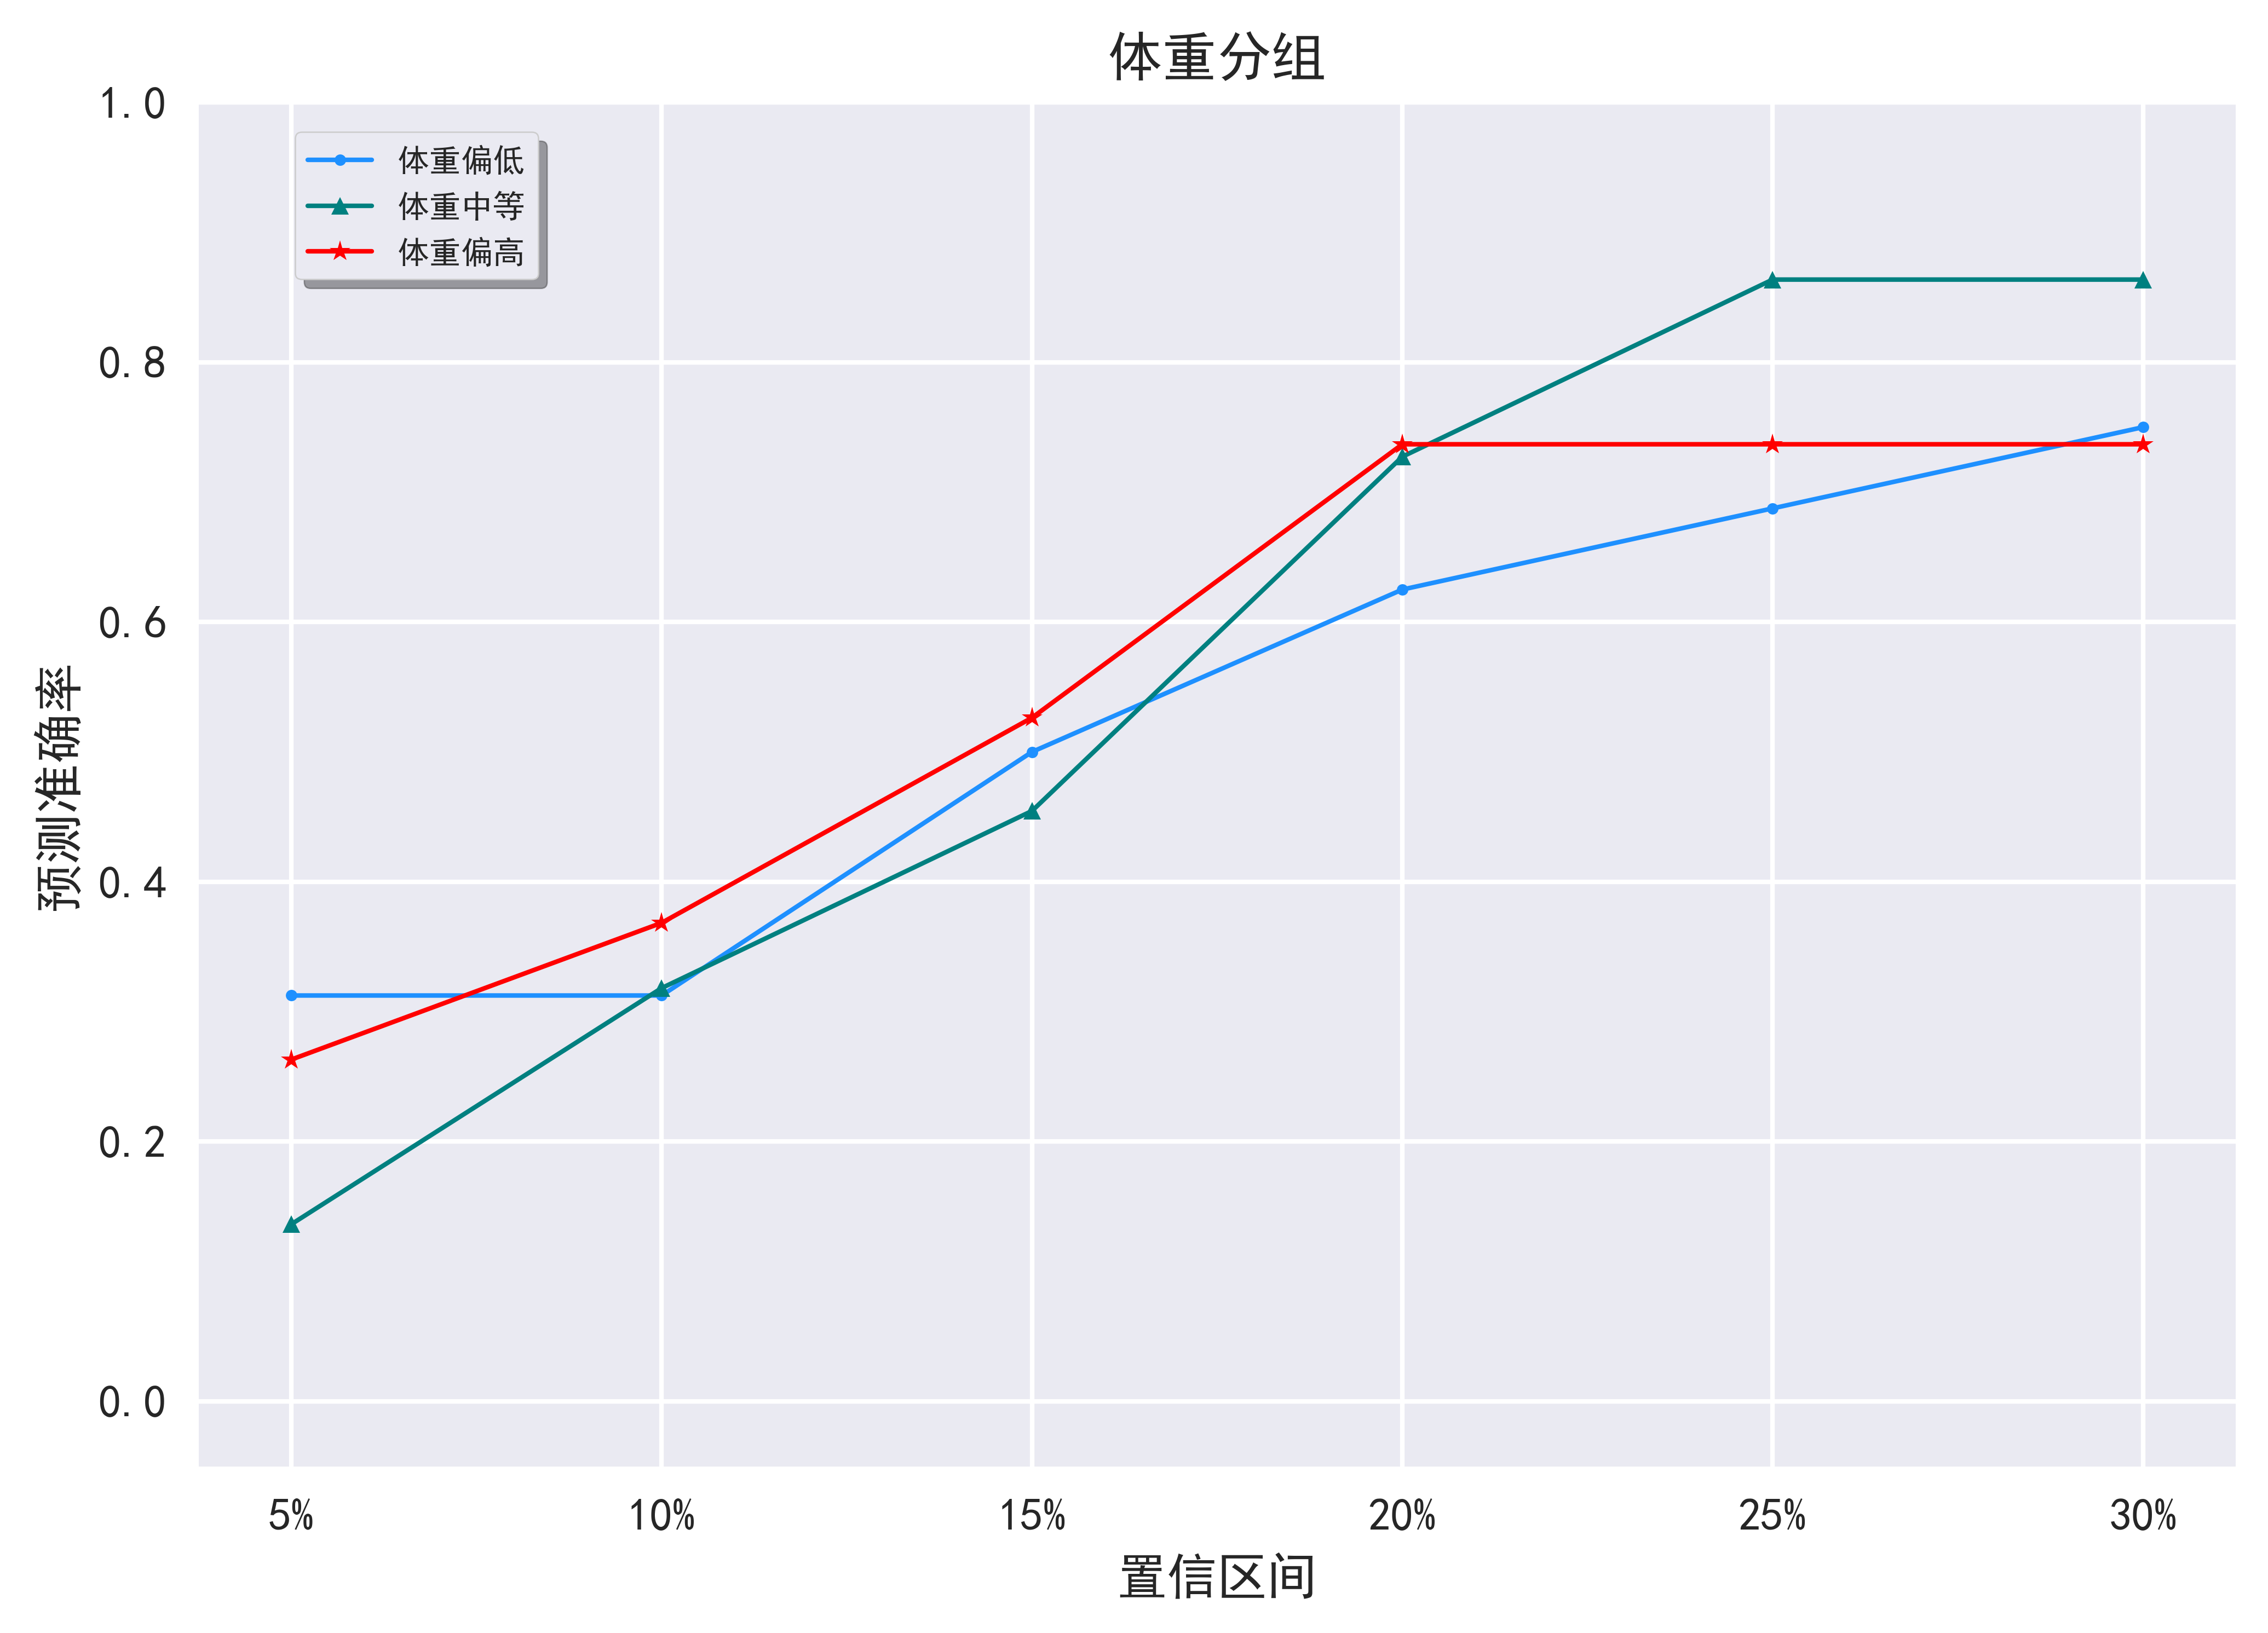

In [201]:
ax = plt.gca()
# ax.spines['bottom'].set_position(('data', 0))   # 把图像与坐标轴关联
# ax.spines['left'].set_position(('data', 0))

plt.title("体重分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息


plt.plot(predict_list_p, W_aaa_list, label='体重偏低', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, W_bbb_list, label='体重中等',  marker='^', markersize=3.8, linewidth=1.0, color='teal')
plt.plot(predict_list_p, W_ccc_list, label='体重偏高',  marker='*', markersize=4.8, linewidth=1.0, color='r')


plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.107, 0.99), markerfirst=True, shadow='True', fontsize=7)
plt.ylim(-0.05, 1.0,)

# 保存
foo_fig = plt.gcf() # 'get current figure'
# foo_fig.savefig('line_体重_0729.png',dpi=600)
# foo_fig.savefig('line_体重_0729.eps',dpi=600)
# 显示
plt.show()     

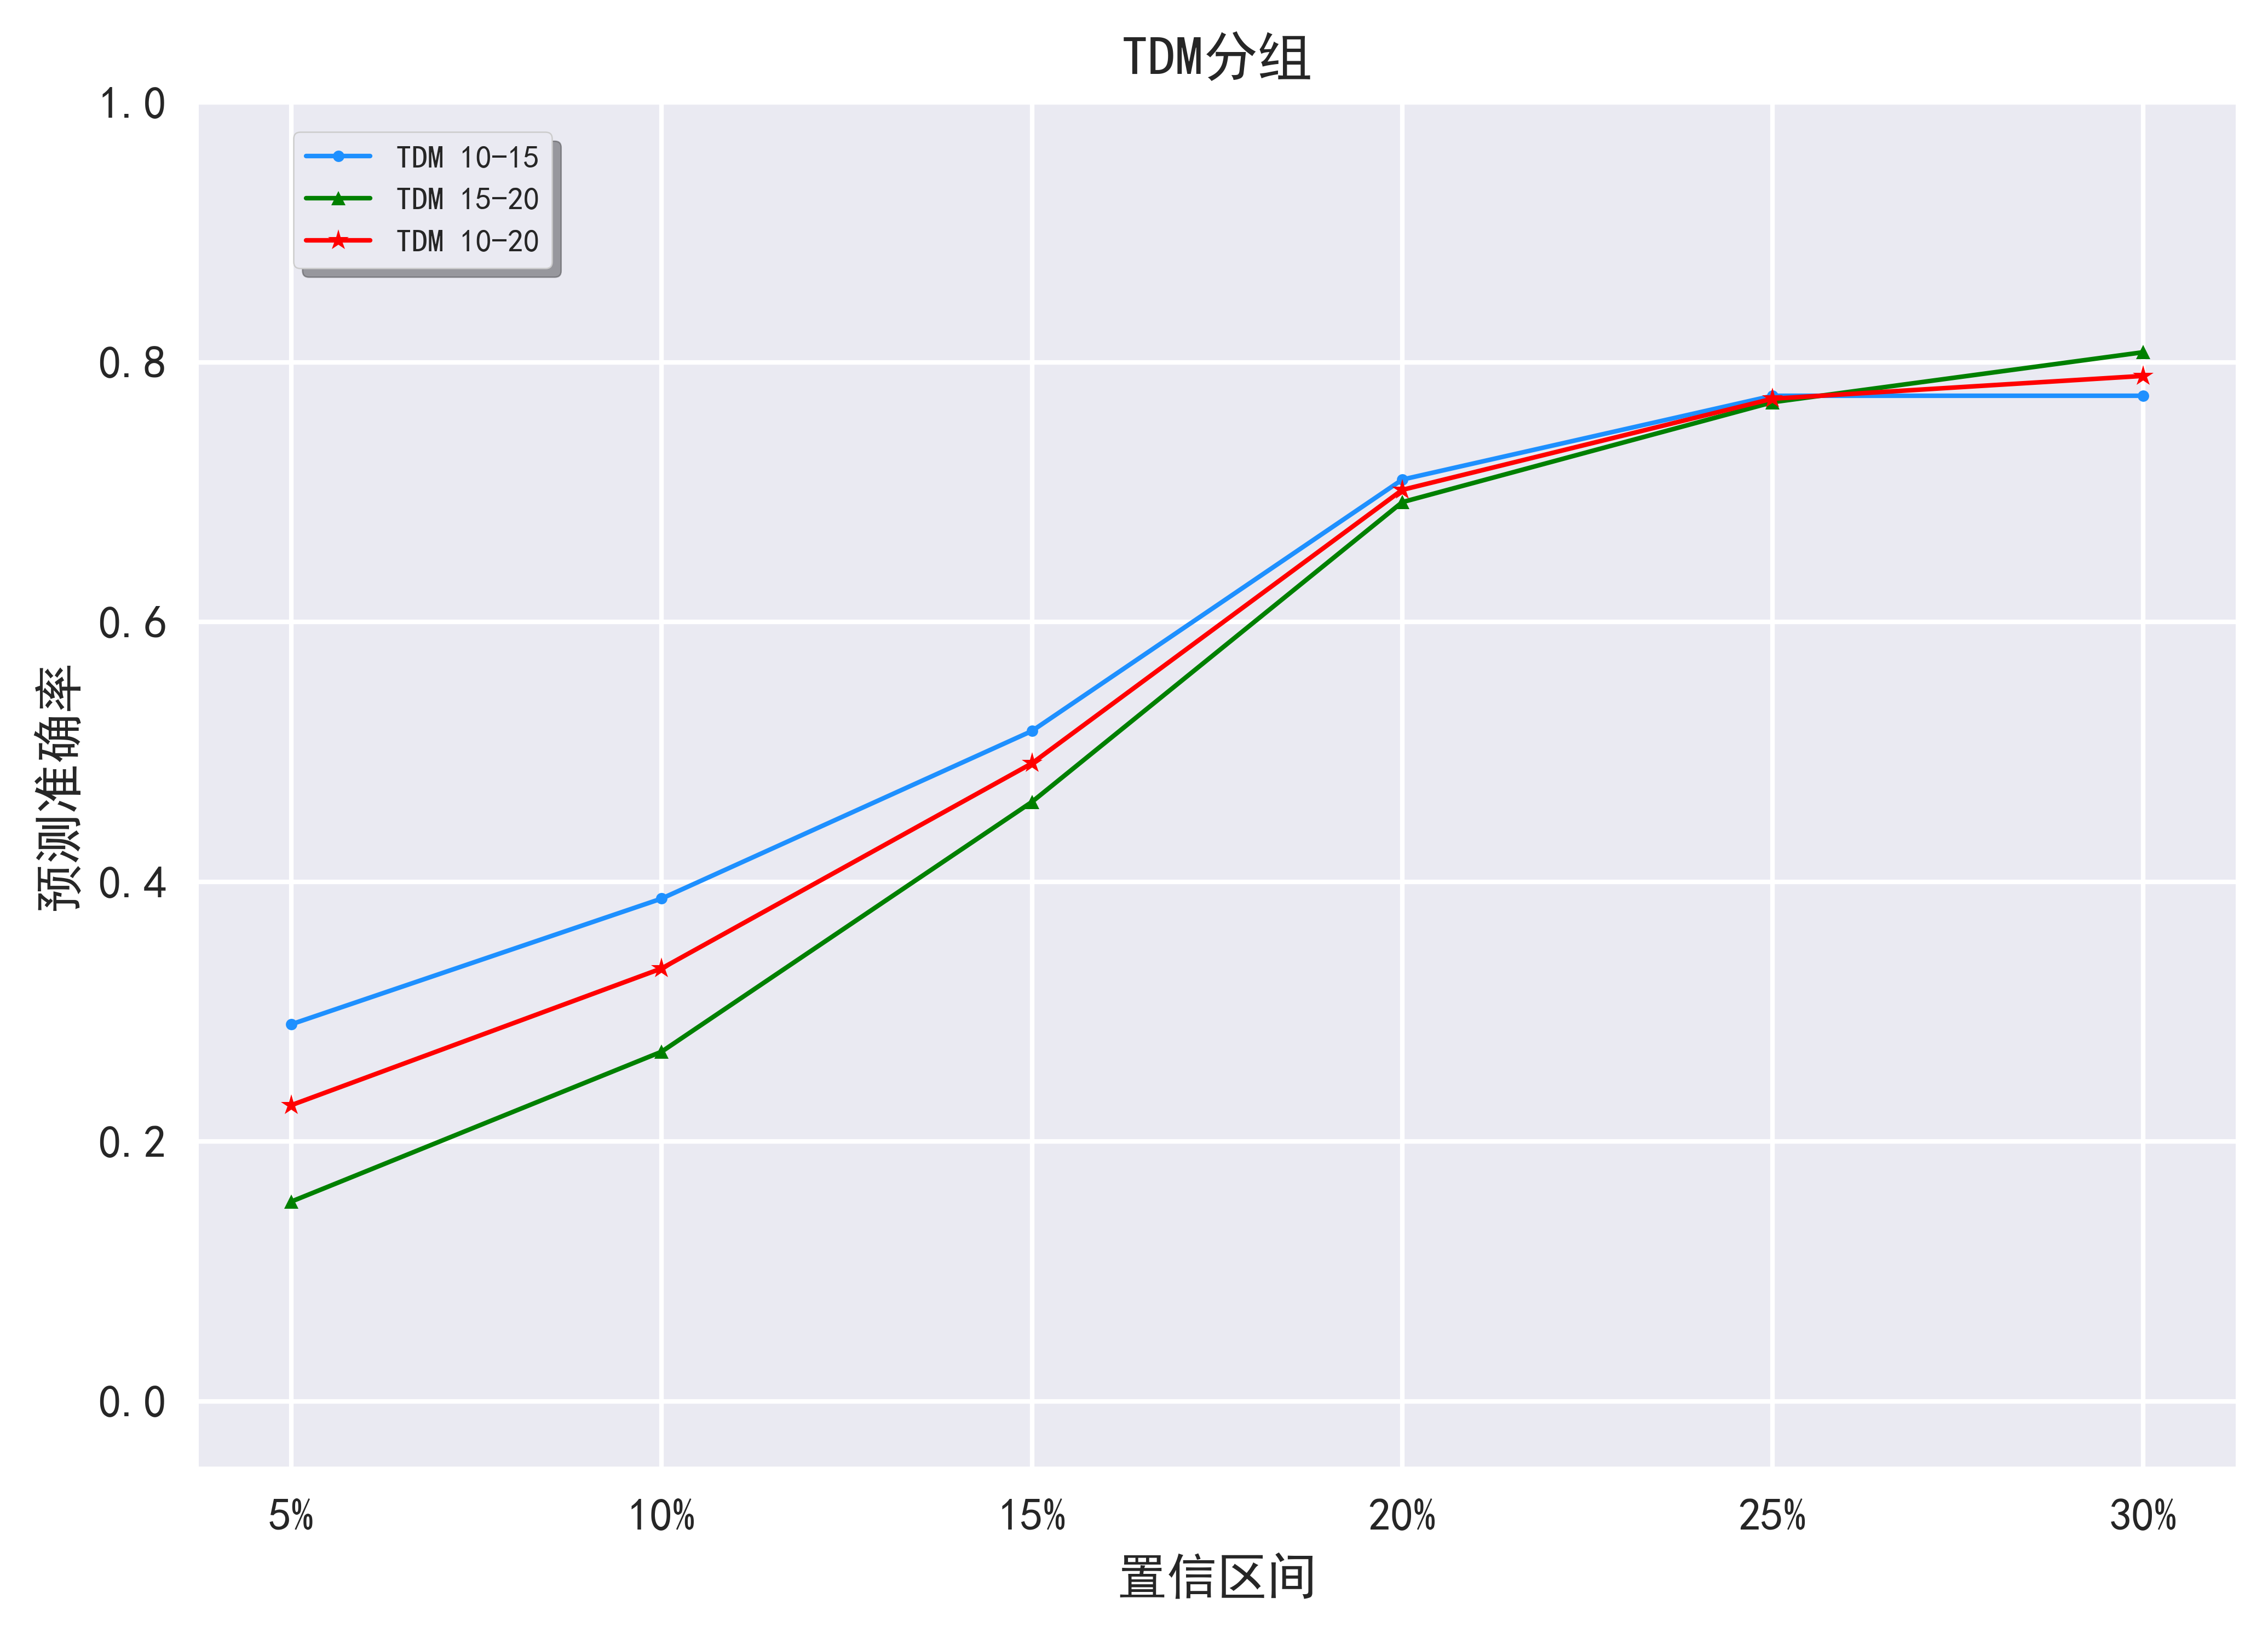

In [202]:
ax = plt.gca()
# ax.spines['bottom'].set_position(('data', 0))   # 把图像与坐标轴关联
# ax.spines['left'].set_position(('data', 0))

plt.title("TDM分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息

plt.plot(predict_list_p, TDM_aaa_list, label='TDM 10-15', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, TDM_bbb_list, label='TDM 15-20',  marker='^', markersize=3.2, linewidth=1.0, color='green')
plt.plot(predict_list_p, TDM_ccc_list, label='TDM 10-20',  marker='*', markersize=4.8, linewidth=1.0, color='r')


plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.11, 0.99), markerfirst=True, shadow='True', fontsize=7)
plt.ylim(-0.05, 1.0,)

# 保存
foo_fig = plt.gcf() # 'get current figure'
# foo_fig.savefig('line_TDM_0729.png',dpi=600)
# foo_fig.savefig('line_TDM_0729.eps',dpi=600)
# 显示
plt.show()     

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

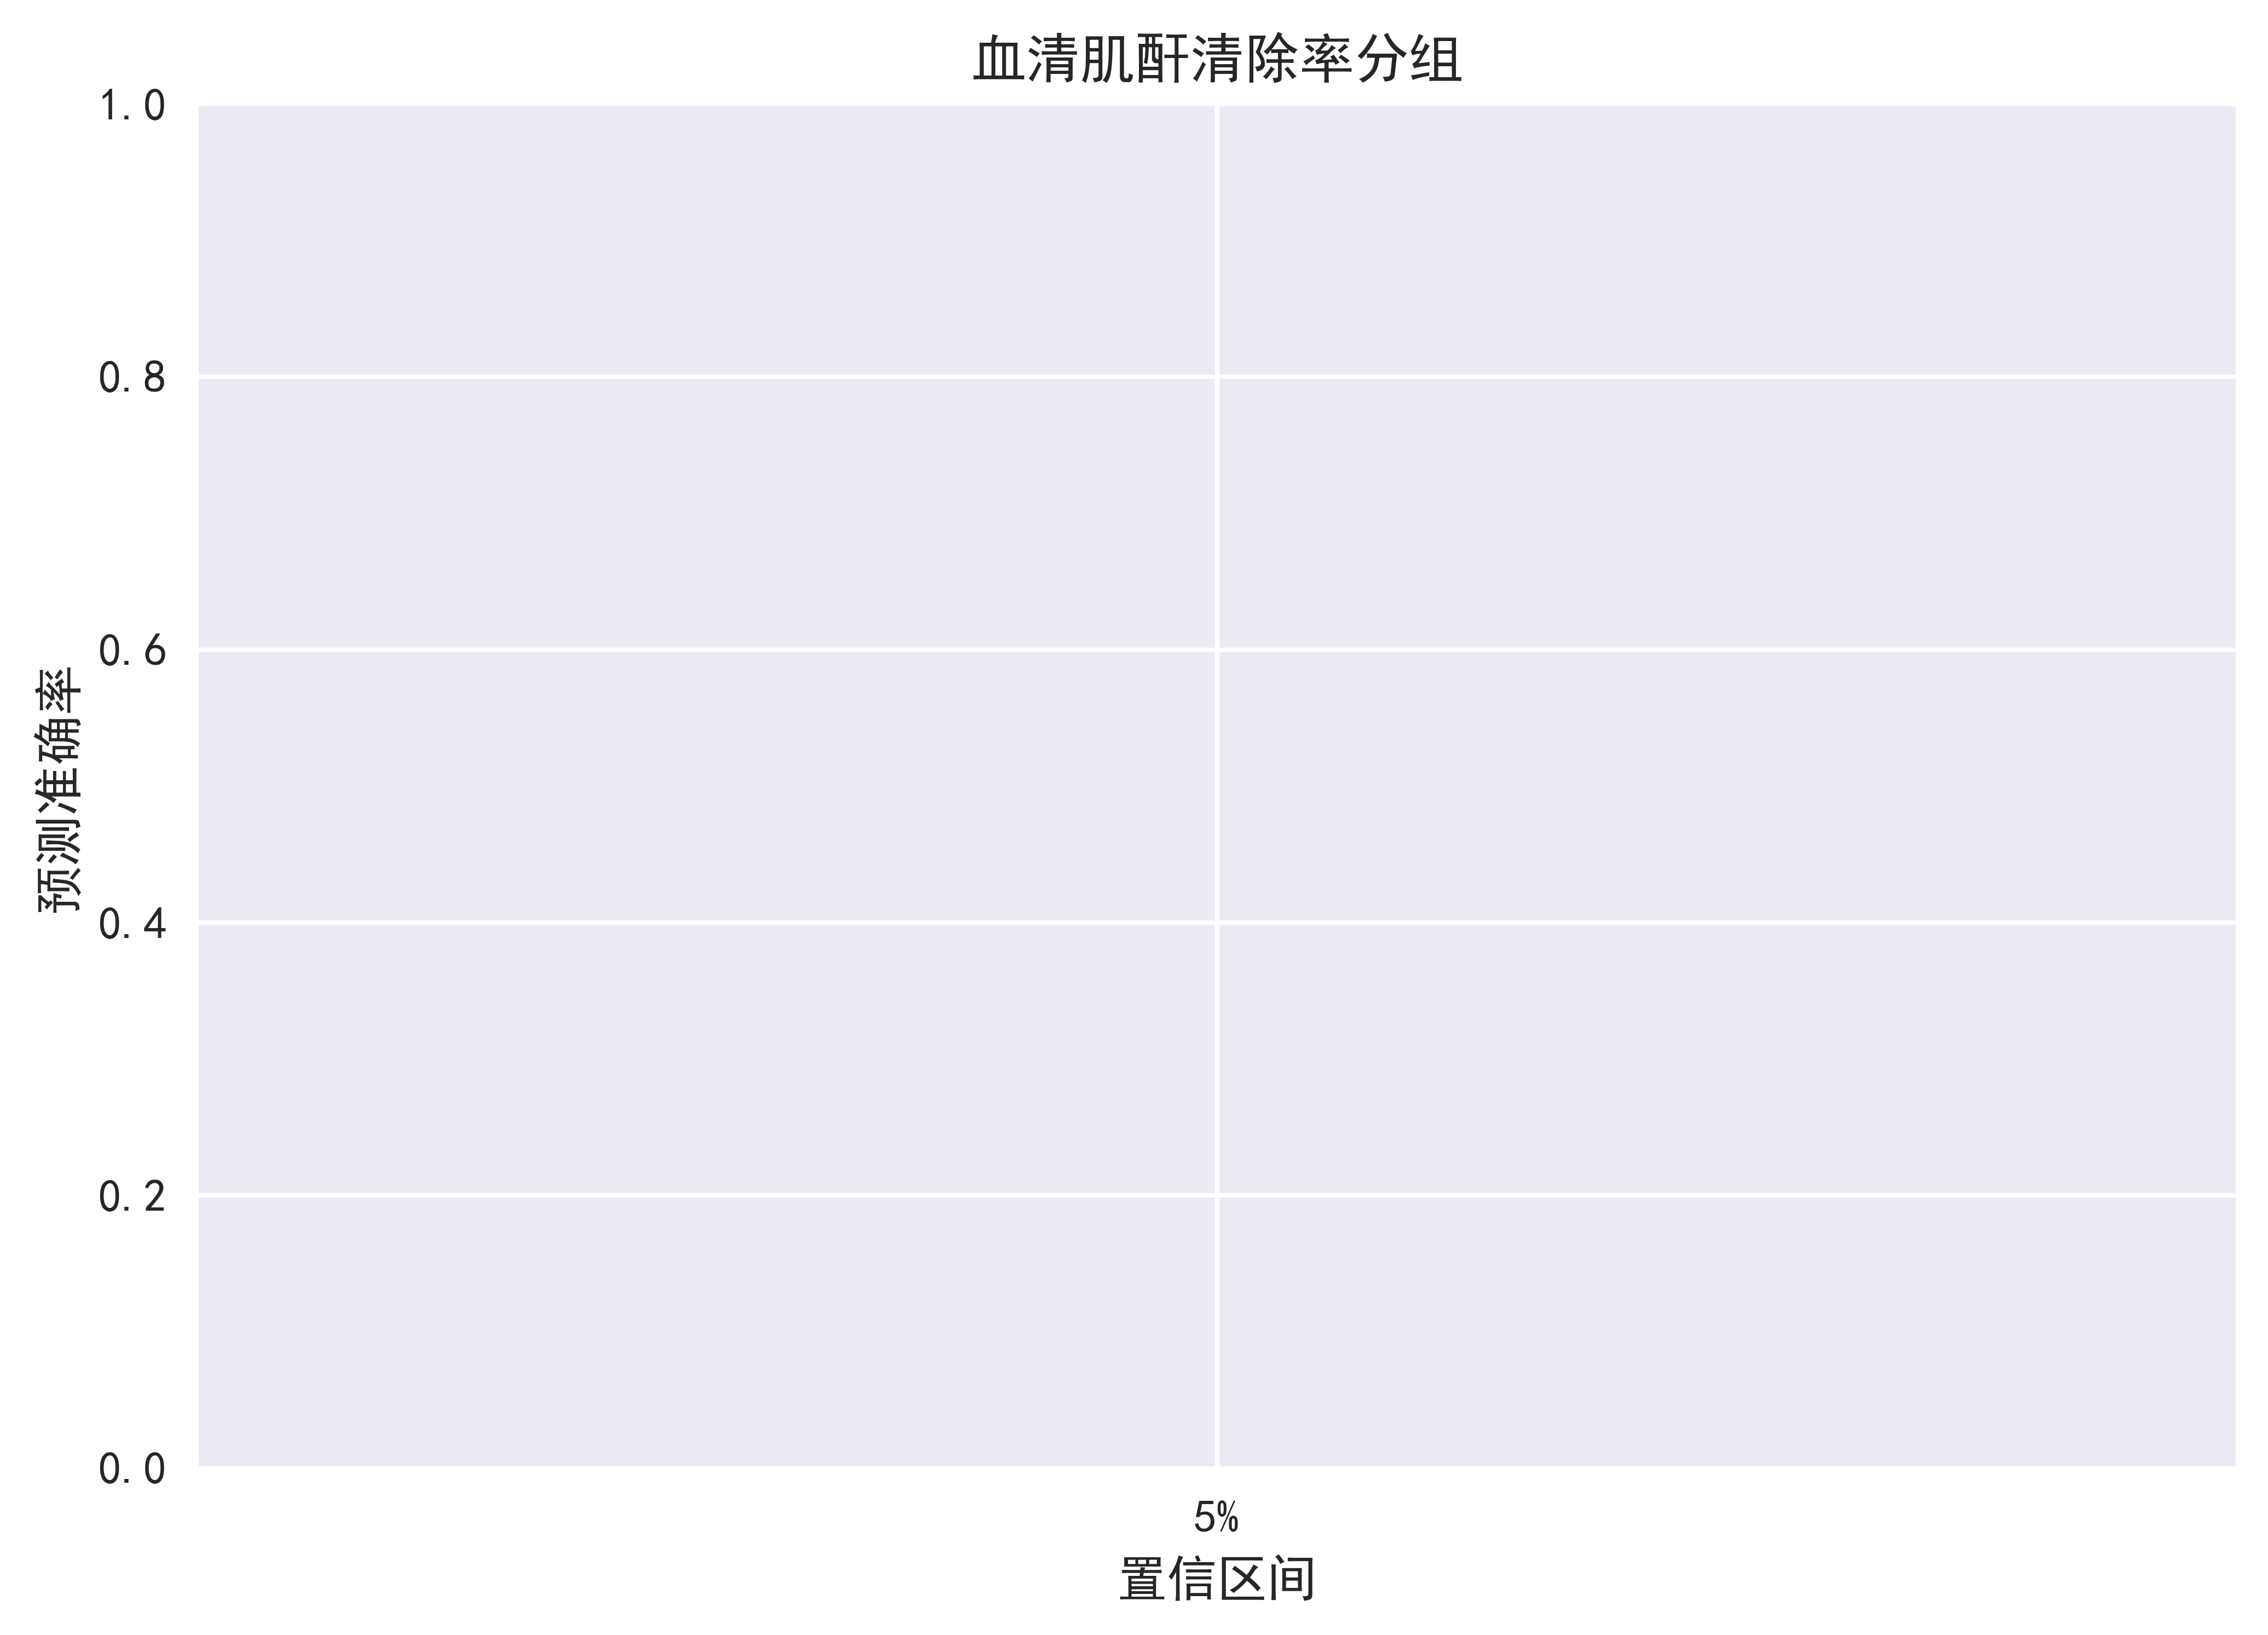

In [204]:
ax = plt.gca()
# ax.spines['bottom'].set_position(('data', 0))   # 把图像与坐标轴关联
# ax.spines['left'].set_position(('data', 0))

plt.title("血清肌酐清除率分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息

plt.plot(predict_list_p, B_aaa_list, label='血清肌酐清除率40-59', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, B_bbb_list, label='血清肌酐清除率60-79',  marker='s', markersize=3.0, linewidth=1.0, color='gold')
plt.plot(predict_list_p, B_ccc_list, label='血清肌酐清除率80-99',  marker='^', markersize=3.5, linewidth=1.0,color='teal')
plt.plot(predict_list_p, B_ddd_list, label='血清肌酐清除率≥100',  marker='*', markersize=5.0, linewidth=1.0, color='r')

plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.11, 0.99), markerfirst=True, shadow='True', fontsize=7)

# 保存
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('line_blood_0729.png',dpi=600)
foo_fig.savefig('line_blood_0729.eps',dpi=600)
# 显示
plt.show()             

### 三张图比较

In [ ]:
fig = plt.figure(figsize=(20,12))

##  ============================  画图一   ==================================
plt.subplot(2,2,1)
plt.title("体重分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息

plt.plot(predict_list_p, W_aaa_list, label='体重偏低', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, W_bbb_list, label='体重中等',  marker='^', markersize=3.8, linewidth=1.0, color='teal')
plt.plot(predict_list_p, W_ccc_list, label='体重偏高',  marker='*', markersize=4.8, linewidth=1.0, color='r')

plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.107, 0.99), markerfirst=True, shadow='True', fontsize=7)
plt.ylim(-0.05, 1.0,)

##  ============================  画图二   ==================================
plt.subplot(2,2,2)
plt.title("TDM分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息

plt.plot(predict_list_p, TDM_aaa_list, label='TDM 10-15', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, TDM_bbb_list, label='TDM 15-20',  marker='^', markersize=3.2, linewidth=1.0, color='green')
plt.plot(predict_list_p, TDM_ccc_list, label='TDM 10-20',  marker='*', markersize=4.8, linewidth=1.0, color='r')

plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.11, 0.99), markerfirst=True, shadow='True', fontsize=7)
plt.ylim(-0.05, 1.0,)
   
##  ============================  画图三   ==================================
plt.subplot(2,2,3)
plt.title("血肝清除率分组")      # 标题
plt.xlabel("置信区间")         # x 轴信息
plt.ylabel("预测准确率")         # y 轴信息

plt.plot(predict_list_p, B_aaa_list, label='血肝清除率40-59', marker='.', markersize=5.0, linewidth=1.0, color='dodgerblue')      # 画出图像
plt.plot(predict_list_p, B_bbb_list, label='血肝清除率60-79',  marker='s', markersize=3.0, linewidth=1.0, color='gold')
plt.plot(predict_list_p, B_ccc_list, label='血肝清除率80-99',  marker='^', markersize=3.5, linewidth=1.0,color='teal')
plt.plot(predict_list_p, B_ddd_list, label='血肝清除率≥100',  marker='*', markersize=5.0, linewidth=1.0, color='r')

plt.legend(loc='upper center', frameon='True',  bbox_to_anchor=(0.11, 0.99), markerfirst=True, shadow='True', fontsize=7)

# 保存
# foo_fig = plt.gcf() 
# foo_fig.savefig('line_common_0729.png',dpi=600)
#显示
plt.show()


In [ ]:
test_x_common.shape

In [210]:
test_x_common['预测_实际偏差'] = ((test_x_common['万古霉素日剂量预测值'] - test_x_common['万古霉素日剂量']) / test_x_common['万古霉素日剂量'])

In [219]:
# print(test_x_common[test_x_common['预测_实际偏差']<-0.7].shape[0])
print('-0.7 - -0.6: ',test_x_common[(test_x_common['预测_实际偏差']>-0.7)&(test_x_common['预测_实际偏差']<=-0.6)].shape[0])
print('-0.6 - -0.5: ',test_x_common[(test_x_common['预测_实际偏差']>-0.6)&(test_x_common['预测_实际偏差']<=-0.5)].shape[0])
print('-0.5 - -0.4: ',test_x_common[(test_x_common['预测_实际偏差']>-0.5)&(test_x_common['预测_实际偏差']<=-0.4)].shape[0])
print('-0.4 - -0.3: ',test_x_common[(test_x_common['预测_实际偏差']>-0.4)&(test_x_common['预测_实际偏差']<=-0.3)].shape[0])
print('-0.3 - -0.2: ',test_x_common[(test_x_common['预测_实际偏差']>-0.3)&(test_x_common['预测_实际偏差']<=-0.2)].shape[0])
print('-0.2 - -0.1: ',test_x_common[(test_x_common['预测_实际偏差']>-0.2)&(test_x_common['预测_实际偏差']<=-0.1)].shape[0])
print('-0.1 - 0   : ',test_x_common[(test_x_common['预测_实际偏差']>-0.1)&(test_x_common['预测_实际偏差']<=0)].shape[0])
print('0 - 0.1    : ',test_x_common[(test_x_common['预测_实际偏差']>0)&(test_x_common['预测_实际偏差']<=0.1)].shape[0])
print('0.1 - 0.2  : ',test_x_common[(test_x_common['预测_实际偏差']>0.1)&(test_x_common['预测_实际偏差']<=0.2)].shape[0])
print('0.2 - 0.3  : ',test_x_common[(test_x_common['预测_实际偏差']>0.2)&(test_x_common['预测_实际偏差']<=0.3)].shape[0])
print('0.3 - 0.4  : ',test_x_common[(test_x_common['预测_实际偏差']>0.3)&(test_x_common['预测_实际偏差']<=0.4)].shape[0])
print('0.4 - 0.5  : ',test_x_common[(test_x_common['预测_实际偏差']>0.4)&(test_x_common['预测_实际偏差']<=0.5)].shape[0])
print('0.5 - 0.6  : ',test_x_common[(test_x_common['预测_实际偏差']>0.5)&(test_x_common['预测_实际偏差']<=0.6)].shape[0])
print('0.6 - 0.7  : ',test_x_common[(test_x_common['预测_实际偏差']>0.6)&(test_x_common['预测_实际偏差']<=0.7)].shape[0])

print('0.8 - 1.0  : ',test_x_common[(test_x_common['预测_实际偏差']>0.8)&(test_x_common['预测_实际偏差']<=1.0)].shape[0])
print('     >1.0  : ',test_x_common[(test_x_common['预测_实际偏差']>1.0)].shape[0])

-0.7 - -0.6:  0
-0.6 - -0.5:  0
-0.5 - -0.4:  0
-0.4 - -0.3:  5
-0.3 - -0.2:  3
-0.2 - -0.1:  14
-0.1 - 0   :  9
0 - 0.1    :  10
0.1 - 0.2  :  7
0.2 - 0.3  :  2
0.3 - 0.4  :  1
0.4 - 0.5  :  0
0.5 - 0.6  :  1
0.6 - 0.7  :  0
0.8 - 1.0  :  2
     >1.0  :  2


#### 偏离程度大的几个人

In [ ]:
test_x_common[test_x_common['预测_实际偏差']>=0.7].shape[0]

In [ ]:
test_x_common[test_x_common['万古霉素日剂量']==250]

In [ ]:
test_x_common[test_x_common['预测_实际偏差']>=0.7][['万古霉素日剂量','上一次万古霉素日剂量','万古霉素日剂量预测值','预测_实际偏差']]

In [ ]:
test_x_common[test_x_common['预测_实际偏差']>=0.7].iloc[:,0:10]

In [ ]:
df_piancha = test_x_common[test_x_common['预测_实际偏差']>=0.7]

In [ ]:
df_piancha

In [ ]:
df_piancha['上一次万古霉素日剂量'] = df_piancha['上一次万古霉素日剂量'].apply(lambda x: round((math.e) ** x,0) if x>0 else 0) 

In [ ]:
test_x_common['万古霉素日剂量'].describe()

In [ ]:
print(test_x_common[test_x_common['万古霉素日剂量']>500].shape[0])
print(test_x_common[test_x_common['万古霉素日剂量']<=500].shape[0])

In [ ]:
6/51

In [ ]:
math.log(500)

In [ ]:
print(tran_x_common[tran_x_common['万古霉素日剂量']>math.log(500)].shape[0])
print(tran_x_common[tran_x_common['万古霉素日剂量']<=math.log(500)].shape[0])

In [ ]:
7/120

In [ ]:
df_piancha

In [ ]:
df_info.上一次万古霉素日剂量.unique()

In [ ]:
round((math.e) ** test_x_common.loc[1042,'上一次万古霉素日剂量'],0)

In [ ]:
round((math.e) ** test_x_common['万古霉素日剂量预测值'],0)

In [ ]:
im_auto = pd.DataFrame(data={'Variable Name':['肌酐','上一次万古霉素日剂量','上一次TDM值',
                                              '红细胞计数','年龄','体重',
                                              '氟康唑','性别','C反应蛋白','白细胞计数'],
                             'Importance Score':[0.1148,0.1112,0.1018,0.0614,
                                                0.0519,0.0493,0.0487,0.0426,
                                                0.0403,0.0368]})

In [ ]:
my_x_ticks = np.arange(-5, 5, 0.5)
my_y_ticks = np.arange(-2, 2, 0.3)
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)


In [ ]:
df_70_0 = pd.DataFrame(data={'Deviation from actual vancomycin dose(%)':[-65,-55,-45,
                                                                        -35,-25,-15,
                                                                        -5,5,15,
                                                                        25,35,45,
                                                                        55,65],
                              'Frequency':[0,0,0,5,3,14,9,9,7,3,1,0,1,0]})

In [ ]:
df_70_0


In [ ]:
from pylab import mpl  
mpl.rcParams['font.sans-serif'] = ['SimHei'] ##绘图显示中文
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('mathtext', default='regular')

plt.rcParams['savefig.dpi'] = 600 #图片像素
plt.rcParams['figure.dpi'] = 600 #分辨率

In [ ]:
names=list(df_70_0['Deviation from actual vancomycin dose(%)'])
index=np.arange(-70,70,10)
# index=np.arange(len(names))
plt.figure(figsize=(35,20))
plt.bar(index,df_70_0['Frequency'],width=10,color=(0.32941176470588235, 0.7294117647058823, 0.7490196078431373),tick_label=names,align="center")
plt.xticks(index)
plt.ylabel('Frequency')
plt.xlabel('Deviation from actual vancomycin dose(%)')
## 将最后一列，为 '...' 的那个画柱形
for a, b in zip(index, df_70_0['Frequency']):
    if b==0:                                   
        break
    plt.text(a, b+0.002, '%.4f' % b, ha='center', va='bottom', fontsize=19)
#plt.title('重要变量得分柱形图')
# plt.savefig(r'../数据提取/重要性300dpi(取消单因素).jpg',dpi=300,bbox_inches = 'tight')
plt.show()